In [2]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import tflearn
import ipdb as pdb
import time

for k in range(5):
    
    tf.reset_default_graph()
    
    print('---------' + str(k) + '------------')
    
    MAX_EPISODE = 2000
    MAX_EPISODE_LEN = 200

    NUM_T = 1
    NUM_R = 4
    SIGMA2 = 1e-9

    t_factor = 0.5
    noise_sigma = 0.12

    config = {'state_dim':3, 'action_dim':2};
    train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                    'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                    'random_seed':int(time.clock()*1000%1000), 'noise_sigma':noise_sigma, 'sigma2':SIGMA2}
    
    IS_TRAIN = False
#     rate = 3.0
    res_path = 't_M_05_nB/'
    model_path = 'model_M_05_nB/my_train_model_'+str(k)+'-2000'
    meta_path = model_path+'.meta'
    init_path = ''
    init_seqCnt = 40
    
    user_config = [{'id':'1', 'model':'AR', 'num_r':NUM_R, 'rate':1.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'2', 'model':'AR', 'num_r':NUM_R, 'rate':2.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000},
                   {'id':'3', 'model':'AR', 'num_r':NUM_R, 'rate':3.0, 'dis':100, 'action_bound':2, 
                    'data_buf_size':100, 't_factor':t_factor, 'penalty':1000}]
    
    if not os.path.exists(res_path):
        os.mkdir(res_path) 
    
    print(user_config)
    # 0. initialize the session object
    sess = tf.Session() 

    # gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
    # sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

    # 1. include all user in the system according to the user_config
    user_list = [];
    for info in user_config:
        info.update(config)
        info['model_path'] = model_path + '_' + info['id']
        info['meta_path'] = info['model_path']+'.meta'
        info['init_path'] = init_path
        info['init_seqCnt'] = init_seqCnt
        user_list.append(MecTermRL(sess, info, train_config))
        print('Initialization OK!----> user ' + info['id'])

    # 2. create the simulation env
    env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)

    sess.run(tf.global_variables_initializer())
    
    tflearn.config.is_training(is_training=IS_TRAIN, session=sess)

    env.init_target_network()

    res_r = []
    res_p = []
    res_b = []
    res_o = []
    res_d = []
    # 3. start to explore for each episode
    for i in range(MAX_EPISODE):

        cur_init_ds_ep = env.reset()

        cur_r_ep = np.zeros(len(user_list))
        cur_p_ep = np.zeros(len(user_list))
        cur_op_ep = np.zeros(len(user_list))
        cur_ts_ep = np.zeros(len(user_list))
        cur_ps_ep = np.zeros(len(user_list))
        cur_rs_ep = np.zeros(len(user_list))
        cur_ds_ep = np.zeros(len(user_list))
        cur_ch_ep = np.zeros(len(user_list))
        cur_of_ep = np.zeros(len(user_list))

        for j in range(MAX_EPISODE_LEN):

            # first try to transmit from current state
            [cur_r, done, cur_p, cur_op, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()

            cur_r_ep += cur_r
            cur_p_ep += cur_p
            cur_op_ep += cur_op
            cur_ts_ep += cur_ts
            cur_ps_ep += cur_ps
            cur_rs_ep += cur_rs
            cur_ds_ep += cur_ds
            cur_ch_ep += cur_ch
            cur_of_ep += cur_of


            if done:
                res_r.append(cur_r_ep/MAX_EPISODE_LEN)
                res_p.append(cur_p_ep/MAX_EPISODE_LEN)
                res_b.append(cur_ds_ep/MAX_EPISODE_LEN)
                res_o.append(cur_of_ep/MAX_EPISODE_LEN)
                res_d.append(cur_ds)
                print('%d:r:%s,p:%s,op:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s,rbuf:%s' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_op_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep, cur_ds))

    name = res_path+'test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
    np.savez(name, res_r, res_p, res_b, res_o, res_d)
    
    tflearn.config.is_training(is_training=False, session=sess)
    #Create a saver object which will save all the variables
    saver = tf.train.Saver() 
    saver.save(sess, model_path)

    sess.close()

---------0------------
[{'id': '1', 'model': 'AR', 'num_r': 4, 'rate': 1.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.5, 'penalty': 1000}, {'id': '2', 'model': 'AR', 'num_r': 4, 'rate': 2.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.5, 'penalty': 1000}, {'id': '3', 'model': 'AR', 'num_r': 4, 'rate': 3.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.5, 'penalty': 1000}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -8.24868942 -12.77596596 -36.52307871],p:[0.76680303 1.17264968 1.02816401],op:[0.76493393 0.33840214 0.09879875],tr:[1.01280741 1.09545035 0.65452613],pr:[1.87383429 1.80578814 1.18713792],rev:[0.935 2.085 2.9  ],dbuf:[ 1.18000931 10.4414138  61.77652984],ch:[4.13616333 4.20368204 3.28798841],ibuf:[9.5, 44.0, 7.0],rbuf:[  4.22554634  37.76327052 259.26239809]
1:r:[  -2.10005798  -61.65861517 -140.1760539 ],p:[1.50320150e-01 2.38633464e-01 1.30862165e-0

22:r:[ -41.94065717 -121.965       -63.96913955],p:[0.04339455 0.         0.54445603],op:[0. 0. 0.],tr:[0.02459176 0.         0.29809664],pr:[0.33227503 0.         1.45266953],rev:[1.04  2.205 2.89 ],dbuf:[ 83.44736886 243.93       122.49371883],ch:[3.44185546 4.52618782 3.64570197],ibuf:[14.0, 27.5, 14.5],rbuf:[150.62664292 468.5        242.34676455]
23:r:[ -21.63802138 -114.53288541  -80.70303104],p:[0.12015886 0.00615517 0.43212454],op:[0. 0. 0.],tr:[0.15318538 0.00610619 0.13752061],pr:[0.58587519 0.0849337  1.44811861],rev:[1.105 2.045 2.835],dbuf:[ 42.07445417 229.00421917 157.08481665],ch:[3.48137334 3.71226094 3.83669262],ibuf:[23.0, 25.5, 26.0],rbuf:[ 96.18788705 416.29202023 275.87215638]
24:r:[-72.71997728 -96.31599569 -88.20224173],p:[0.03747011 0.05519961 0.31015296],op:[0. 0. 0.],tr:[0.10209275 0.12112599 0.00159537],pr:[0.         0.38500151 1.34453679],rev:[1.15  2.12  3.065],dbuf:[145.06525345 192.07999529 173.3029539 ],ch:[3.41581853 4.96486488 4.59717861],ibuf:[37.5,

46:r:[-49.7025     -16.02054951 -64.01103634],p:[0.         1.81978005 1.6260176 ],op:[0.         0.18021995 0.        ],tr:[0. 0. 0.],pr:[0.         2.5198421  2.35143628],rev:[0.96 2.16 3.07],dbuf:[ 99.405       12.04109903 111.76189665],ch:[5.04777228 4.12634533 4.44723321],ibuf:[8.5, 43.5, 33.0],rbuf:[200.5          1.4801579  176.71274471]
47:r:[-54.315      -11.62066363 -47.13254533],p:[0.         1.42586079 1.70910812],op:[0.         0.56825923 0.        ],tr:[0. 0. 0.],pr:[0.         2.51736006 2.39099722],rev:[1.    2.045 2.855],dbuf:[108.63         3.30012708  77.17400942],ch:[4.19520958 3.58274059 3.72878481],ibuf:[7.5, 10.0, 31.5],rbuf:[207.5          3.         124.30055684]
48:r:[-65.21       -19.01305407 -44.45836356],p:[0.         1.68751983 1.83605204],op:[0.         0.31134577 0.        ],tr:[0. 0. 0.],pr:[0.         2.51936383 2.4488231 ],rev:[1.01  2.105 3.12 ],dbuf:[130.42       18.0374522  70.5562067],ch:[3.23487213 4.10515797 4.59072618],ibuf:[35.5, 41.5, 16.0],r

69:r:[-10.98255921 -12.94236422 -23.66515709],p:[0.16436671 1.30584533 2.1926913 ],op:[0.01696021 0.81814556 0.0342829 ],tr:[0.12033154 0.39491096 0.40593165],pr:[0.85301826 2.49297958 2.5198421 ],rev:[1.065 1.96  3.165],dbuf:[20.15184917  4.64481951 25.06057224],ch:[5.03420222 3.3621452  3.55745837],ibuf:[38.0, 33.0, 8.0],rbuf:[72.33862331  3.         61.71882986]
70:r:[-71.53       -13.60013395 -22.71341025],p:[0.         1.19947259 2.1177056 ],op:[0.         1.08490504 0.        ],tr:[0.         0.63047135 0.31528918],pr:[0.         2.5198269  2.51269855],rev:[1.07  1.885 2.925],dbuf:[143.06         4.35649158  24.24976445],ch:[3.94189424 4.06746876 4.1983092 ],ibuf:[33.5, 37.0, 18.0],rbuf:[247.5         2.         37.4024545]
71:r:[-70.90412159 -12.72777302 -27.05170046],p:[0.03211551 1.10679369 2.01706164],op:[0.         1.20933305 0.01279941],tr:[0.09306296 0.78668864 0.18150133],pr:[0.         2.5198421  2.51069422],rev:[1.115 1.99  3.125],dbuf:[141.48708813   2.29427857  33.804

91:r:[ -4.81139306 -12.14512184 -16.02071377],p:[0.53793529 1.16418231 2.08235409],op:[0.12866546 0.88405471 0.08309026],tr:[0.        0.5274754 0.4707225],pr:[1.67689529 2.46207317 2.5198421 ],rev:[1.19 1.97 3.  ],dbuf:[ 2.95677864  3.80787345 10.38698411],ch:[4.45724576 5.11132218 3.98480885],ibuf:[32.0, 28.0, 7.0],rbuf:[ 0.          3.80690335 24.91745339]
92:r:[ -5.29385871 -11.92199591 -23.22154852],p:[0.49035506 1.20708366 2.1920565 ],op:[0.26129674 0.88239765 0.        ],tr:[0.         0.54662978 0.43387678],pr:[1.75252595 2.45125605 2.5029511 ],rev:[0.925 1.95  3.01 ],dbuf:[ 3.07119946  2.94917873 24.522532  ],ch:[2.26323678 4.33767894 3.59150734],ibuf:[33.5, 17.5, 12.0],rbuf:[ 2.02307763  4.         26.63442492]
93:r:[ -3.72073597 -11.77190085 -33.62447348],p:[0.33771643 1.0804173  2.11768657],op:[0.26831627 1.04940284 0.        ],tr:[0.         0.72432961 0.44122621],pr:[1.6511322  2.41643587 2.49867004],rev:[0.91  1.985 2.95 ],dbuf:[ 1.38114502  2.24560031 46.07208125],ch:[3

114:r:[ -4.02033226 -12.62915783 -66.51893299],p:[0.35839088 1.42972402 1.9581812 ],op:[0.22079379 0.42923617 0.        ],tr:[0.00012596 0.         0.        ],pr:[1.6291655  2.45886388 2.50203211],rev:[0.935 1.965 3.18 ],dbuf:[  2.2488178    6.66871374 113.456054  ],ch:[4.5279267  5.06702311 5.12862152],ibuf:[24.0, 28.5, 45.5],rbuf:[  0.           2.         181.09357799]
115:r:[ -3.78223092 -11.87482629 -42.77534577],p:[0.3550206  1.53699047 1.92704684],op:[0.19318147 0.42962929 0.01780221],tr:[0.04840342 0.         0.        ],pr:[1.57464488 2.50564814 2.49627631],rev:[1.025 2.125 3.1  ],dbuf:[ 2.08244117  4.08345495 66.10220101],ch:[4.6575071  3.50539552 4.33912589],ibuf:[23.5, 7.5, 0.5],rbuf:[  1.56264212   1.1242274  124.34136146]
116:r:[ -2.71028221 -13.2161198  -57.53918433],p:[0.26031901 1.47653965 1.98669205],op:[0.02634754 0.38547837 0.        ],tr:[1.07570733e-01 0.00000000e+00 6.16948731e-06],pr:[1.12826781 2.46016596 2.51421604],rev:[0.975 2.03  3.085],dbuf:[ 2.5538989   

137:r:[ -3.2671154  -12.55828964 -44.6844663 ],p:[0.36697243 1.33519652 1.95537239],op:[0.        0.5804501 0.       ],tr:[0.         0.38133433 0.0684849 ],pr:[1.05272509 2.40104511 2.48581684],rev:[1.045 2.09  2.865],dbuf:[ 2.86450646  5.9601131  69.81520869],ch:[3.40990085 3.86732958 4.2266476 ],ibuf:[3.0, 30.5, 33.5],rbuf:[ 1.45498172  8.9176953  95.63965211]
138:r:[ -5.3444015  -10.79152933 -34.45926438],p:[0.53167098 1.13006013 1.98635571],op:[0.         0.72976269 0.00418572],tr:[0.         0.41929357 0.00182586],pr:[1.20845485 2.36385324 2.51567306],rev:[0.995 1.92  2.955],dbuf:[ 5.37209318  2.98483045 49.01311445],ch:[4.52511252 3.70439096 4.05737609],ibuf:[46.0, 18.0, 13.5],rbuf:[  3.30902986   3.03861586 101.41689943]
139:r:[ -6.23917279 -13.34404132 -62.65062321],p:[0.55917184 1.19643012 1.99396432],op:[0.         0.47561703 0.        ],tr:[0.         0.30761266 0.        ],pr:[1.24570522 2.31650088 2.51729253],rev:[1.025 1.925 2.985],dbuf:[  6.88662715   9.96761111 105.361

160:r:[ -4.33052519 -22.77128752 -21.67698637],p:[0.46169547 1.71327526 2.71086142],op:[0.         0.19362608 1.28913858],tr:[0.37236563 0.         1.94316769],pr:[0.74782403 2.47998981 2.5198421 ],rev:[0.95 2.08 2.89],dbuf:[ 4.04409572 26.4735616   3.35397274],ch:[4.13420914 4.66510329 3.56735468],ibuf:[32.5, 46.0, 0.5],rbuf:[2.60835319 0.         1.42975424]
161:r:[ -5.00075103 -14.67102553 -21.64017556],p:[0.51825236 1.51049121 2.80918803],op:[0.         0.45594451 1.19081197],tr:[0.35399863 0.         1.77030426],pr:[0.91409486 2.50552245 2.5198421 ],rev:[1.075 1.965 2.85 ],dbuf:[4.81897843 9.67769385 3.28035112],ch:[4.62529643 4.54297154 3.18240995],ibuf:[38.0, 40.0, 10.0],rbuf:[2.06693792 6.4801579  2.        ]
162:r:[ -3.71268006 -13.56708911 -21.82183329],p:[0.50220368 1.65347268 2.77294903],op:[0.         0.34652732 1.10625042],tr:[0.6946191  0.         2.12234509],pr:[0.5567184 2.5198421 2.4676099],rev:[1.045 2.1   2.905],dbuf:[2.40332335 7.13417821 4.85167204],ch:[3.89643159

183:r:[ -4.4033838  -12.6432107  -21.15743572],p:[0.48246879 1.61600517 2.9468664 ],op:[0.0128082  0.30413017 0.76670766],tr:[0.0789264  0.         1.90448348],pr:[1.24052838 2.48575275 2.39312419],rev:[1.015 2.11  3.045],dbuf:[3.85399767 6.085068   5.17913076],ch:[3.50329071 3.66089031 2.85029843],ibuf:[43.5, 21.0, 28.0],rbuf:[2.         1.         4.61388769]
184:r:[ -4.78351362 -16.98615008 -21.76353854],p:[0.49858214 1.43482185 2.79250134],op:[0.10693616 0.43262494 1.13756532],tr:[0.00670728 0.         1.73029007],pr:[1.57162474 2.46275778 2.48997841],rev:[0.99  1.835 2.73 ],dbuf:[ 3.51184425 15.29783232  4.22641057],ch:[4.1615533  3.96243844 3.01706835],ibuf:[37.0, 46.5, 13.5],rbuf:[3. 2. 4.]
185:r:[ -2.97402368 -14.62546062 -21.75398331],p:[0.36087994 1.43518064 2.79572804],op:[0.07849585 0.39956276 0.78996933],tr:[0.         0.         1.82737031],pr:[1.43347528 2.44824988 2.5198421 ],rev:[1.055 1.875 3.12 ],dbuf:[ 1.55428947 10.90348723  7.6509929 ],ch:[4.36202286 4.24658167 4.

206:r:[ -2.77004805 -11.1525972  -15.94767137],p:[0.27940144 1.08777986 2.02272656],op:[3.52318105e-04 9.09576393e-01 4.67636529e-01],tr:[0.09755536 0.4167212  1.02034649],pr:[0.95527321 2.43139339 2.47269731],rev:[0.94  1.94  2.935],dbuf:[2.74255855 2.33163182 6.99171189],ch:[3.69003382 3.32658052 4.06539489],ibuf:[22.5, 3.5, 22.5],rbuf:[2.01230699 4.84299213 1.86333023]
207:r:[ -3.41480808 -12.05005507 -18.62977909],p:[0.31382978 1.10259227 2.32504406],op:[0.         1.05005971 0.14775973],tr:[0.         0.55558531 0.93671147],pr:[1.06606239 2.47866155 2.47033992],rev:[0.955 1.9   3.055],dbuf:[ 3.69131839  2.57359032 12.53152033],ch:[4.08297175 3.94254458 4.61391136],ibuf:[23.0, 16.5, 47.5],rbuf:[0.78752123 3.         4.95492863]
208:r:[ -3.74279798 -12.91524886 -18.08374455],p:[0.36249726 1.21360701 2.37871865],op:[0.00924664 0.84082118 0.19152773],tr:[0.00212525 0.52513994 0.91089487],pr:[1.22551769 2.45420098 2.4853298 ],rev:[0.985 1.975 3.065],dbuf:[ 3.76815696  5.28621589 10.465

229:r:[ -5.20663434 -11.91604313 -18.94213619],p:[0.38133008 1.47201446 2.40661632],op:[0.         0.55381639 0.00996578],tr:[0.27953972 0.03612179 0.57956088],pr:[0.86950757 2.5198421  2.51245232],rev:[1.025 2.095 2.965],dbuf:[ 6.59996788  3.57377768 13.71845136],ch:[4.99194753 3.0098259  4.11515904],ibuf:[28.5, 7.0, 41.5],rbuf:[ 3.69054135  6.8412632  18.237471  ]
230:r:[ -3.74439342 -11.63464193 -18.44383363],p:[0.26775709 1.32823135 2.25006211],op:[0.00130886 0.67220568 0.02208611],tr:[0.24831626 0.00049567 0.32589258],pr:[0.90294526 2.5198421  2.49503316],rev:[0.97  1.905 2.84 ],dbuf:[ 4.79812733  3.26491354 14.16618505],ch:[4.43986373 3.60929822 5.34333391],ibuf:[35.0, 9.5, 9.5],rbuf:[ 0.12237803  0.         17.09356506]
231:r:[ -3.21320562 -12.8527976  -22.36728836],p:[0.29214531 1.37892903 2.62380283],op:[0.0176934 0.6309768 0.       ],tr:[0.11666449 0.0258183  0.74353634],pr:[1.11203502 2.51762654 2.45516436],rev:[0.9  1.93 3.15],dbuf:[ 3.3280241   5.6065369  18.49654844],ch:[

252:r:[ -3.00267178 -13.97191745 -25.57472345],p:[0.27938304 1.36971701 2.20624607],op:[0.00890086 0.25313334 0.        ],tr:[0.42765019 0.05556409 0.37023986],pr:[0.74667395 2.33993437 2.48506496],rev:[0.885 1.955 2.88 ],dbuf:[ 3.12250454 11.71533143 29.08698616],ch:[4.17887464 4.35203367 3.76985523],ibuf:[25.5, 42.0, 28.0],rbuf:[ 0.          1.         32.93903539]
253:r:[ -3.22475058 -15.4834665  -23.47420484],p:[0.37523732 1.58322951 2.13097189],op:[0.02804103 0.1750806  0.        ],tr:[0.43923415 0.01740623 0.21258957],pr:[0.91321287 2.41091471 2.49062172],rev:[1.025 2.065 2.88 ],dbuf:[ 2.41671765 13.38383187 25.63869074],ch:[3.39936664 4.2069985  4.83193309],ibuf:[15.5, 47.5, 4.5],rbuf:[ 1.          1.6195482  39.85774221]
254:r:[ -3.60011962 -14.70483924 -21.56315533],p:[0.4415912  1.33942499 2.17951009],op:[0.10323985 0.40273017 0.04536745],tr:[0.50451574 0.25347515 0.38215298],pr:[1.22355891 2.35769846 2.49933793],rev:[1.02 1.99 2.95],dbuf:[ 1.75192875 11.98812693 20.87753527]

275:r:[ -5.31920333 -12.5260017  -27.09577167],p:[0.38982746 1.53217299 2.26176586],op:[0.         0.49188681 0.        ],tr:[0.34936946 0.05177536 0.53480055],pr:[0.83538684 2.5198421  2.5031582 ],rev:[1.005 2.025 3.08 ],dbuf:[ 6.74013208  4.81140532 31.57388469],ch:[4.82788206 3.38175903 3.7302374 ],ibuf:[43.5, 28.5, 34.0],rbuf:[ 7.54873875  4.4404737  42.40824997]
276:r:[ -3.95479664 -12.37042692 -35.16901421],p:[0.35420572 1.16994905 2.45992828],op:[0.01205585 0.92918033 0.        ],tr:[0.3618322  0.30778489 0.59901701],pr:[0.96577397 2.5141478  2.5198421 ],rev:[1.06  1.88  3.145],dbuf:[ 4.24697754  3.74956005 45.73874564],ch:[2.82479377 3.91307355 3.74011027],ibuf:[36.5, 17.5, 44.0],rbuf:[ 0.          2.         49.22817812]
277:r:[ -2.57577387 -11.14304484 -28.70569706],p:[0.28406322 1.31346825 2.17354947],op:[0.04741179 0.47294555 0.03164062],tr:[0.26197059 0.12137094 0.29210946],pr:[1.1331198  2.40185845 2.5198421 ],rev:[0.985 1.96  3.04 ],dbuf:[ 1.83679766  4.42195168 35.35949

298:r:[ -2.38100075 -11.58335185 -31.91823927],p:[0.23937881 1.33616391 2.31675137],op:[0.09388713 0.66383609 0.        ],tr:[0.         0.         0.39360097],pr:[1.35945171 2.5198421  2.46967917],rev:[0.99  1.95  2.925],dbuf:[ 1.42934205  3.1667037  40.66896481],ch:[4.55215445 5.00116743 3.83935058],ibuf:[0.5, 10.0, 30.0],rbuf:[ 1.          1.         42.34397242]
299:r:[ -2.79263462 -14.39834819 -35.83846893],p:[0.27300215 1.5828138  2.36983147],op:[0.10495241 0.4171862  0.        ],tr:[0.04317979 0.         0.50120571],pr:[1.35414627 2.5198421  2.50838824],rev:[0.92  1.98  3.085],dbuf:[ 1.80572362  8.79669638 47.97862312],ch:[3.68702519 2.77859653 4.25866677],ibuf:[21.0, 38.5, 32.0],rbuf:[ 2.19567007  2.4801579  47.08121101]
300:r:[ -2.89561847 -11.78549448 -34.22814105],p:[0.30563679 1.43278614 2.31851302],op:[0.08507187 0.56721386 0.        ],tr:[0.06009467 0.         0.3348498 ],pr:[1.35632621 2.5198421  2.51759107],rev:[0.92  2.075 2.94 ],dbuf:[ 1.88415034  3.57098897 45.271151

321:r:[ -5.18926958 -10.34766828 -16.48287061],p:[0.51934416 1.2991067  2.07511496],op:[0.25585185 0.43267894 0.15309409],tr:[0.15006285 0.         0.87429387],pr:[1.7251287  2.40112544 2.39502142],rev:[1.05  1.965 3.08 ],dbuf:[ 2.62657897  3.37748015 10.68365069],ch:[3.22554064 3.33790953 3.66899315],ibuf:[47.5, 10.5, 28.5],rbuf:[ 1.10447345  2.         19.0990912 ]
322:r:[ -4.11112673 -12.39162307 -13.57272997],p:[0.4140139  1.40825221 1.7587433 ],op:[0.08910089 0.58775849 0.40188952],tr:[0.13767917 0.         1.02868025],pr:[1.4008411  2.51815591 2.40751367],rev:[1.03 1.91 2.96],dbuf:[3.19110556 4.82313917 5.53913166],ch:[4.126245   3.16951175 4.88564735],ibuf:[46.0, 28.5, 14.0],rbuf:[5.93099796 4.76223559 4.63813605]
323:r:[ -3.80311852 -11.20640603 -18.83230758],p:[0.38046512 1.31972345 2.04519639],op:[0.15074692 0.58772766 0.12315025],tr:[0.2367077  0.         0.83845315],pr:[1.43836824 2.48023298 2.4379966 ],rev:[0.87  1.985 2.99 ],dbuf:[ 2.29411664  3.33830102 15.98114878],ch:[

344:r:[ -3.87243328 -14.24596065 -21.41184733],p:[0.47403258 1.56924446 2.60747209],op:[0.04513918 0.45609616 1.22651772],tr:[0.42897157 0.05946382 2.03699863],pr:[1.10279601 2.51982904 2.51974534],rev:[1.045 2.09  2.895],dbuf:[2.55314897 8.2385151  4.48379656],ch:[4.3783284  3.44680034 3.67609781],ibuf:[32.0, 30.0, 32.0],rbuf:[2.86649495 5.80419055 2.37318884]
345:r:[ -4.04802697 -13.02796383 -21.64917957],p:[0.3855658  1.49253325 2.67429048],op:[0.0030832  0.50746675 1.06130747],tr:[0.1258746 0.        2.0322153],pr:[1.09988905 2.5198421  2.51281176],rev:[0.975 1.985 3.075],dbuf:[4.20956392 6.05592766 5.94237962],ch:[4.09578675 3.66603961 3.81294391],ibuf:[47.0, 30.0, 35.0],rbuf:[2.46443771 3.9603158  2.        ]
346:r:[ -2.64055629 -16.28658867 -22.68454177],p:[0.28542824 1.65571869 2.64705452],op:[0.04052479 0.3441587  1.22233837],tr:[0.03817841 0.         2.39870334],pr:[1.19845409 2.51979053 2.51876731],rev:[0.985 2.    2.855],dbuf:[ 2.02158226 12.57440337  6.67515461],ch:[3.2653

367:r:[ -3.55809475 -10.98360963 -21.97278968],p:[0.42420226 1.17038402 2.65741123],op:[0.04029734 0.77486607 1.28098128],tr:[0.3179917  0.         2.46346503],pr:[1.18834587 2.49629536 2.49353643],rev:[1.085 1.78  3.005],dbuf:[2.47119348 2.51471835 4.56165419],ch:[3.74402724 2.97598313 4.86559357],ibuf:[34.0, 9.0, 39.5],rbuf:[2.93224687 0.         2.55370717]
368:r:[ -1.75775682 -13.84404848 -21.80620292],p:[0.16838712 1.4023792  2.60865315],op:[0.03954453 0.36870946 1.37606334],tr:[0.03574145 0.         2.39040721],pr:[1.07012371 2.41928561 2.51899498],rev:[0.82 1.96 2.88],dbuf:[1.43619712 9.97721036 3.76524088],ch:[4.64083908 3.45514059 5.31407352],ibuf:[6.5, 31.0, 30.0],rbuf:[0.         3.07395141 8.9025843 ]
369:r:[ -4.83955681 -15.95206894 -21.07036601],p:[0.50587824 1.50470917 2.70515451],op:[0.11489177 0.49183749 1.14035833],tr:[0.41698828 0.         1.8984731 ],pr:[1.39490922 2.51838565 2.47467837],rev:[1.065 1.89  2.995],dbuf:[ 3.47141355 11.93867136  3.68560366],ch:[4.763448

390:r:[ -3.78171282 -14.17366031 -19.27815072],p:[0.36032538 1.42761451 2.58611584],op:[0.19490561 0.41149375 0.91297958],tr:[0.04827488 0.13714448 2.13484273],pr:[1.59997597 2.42927441 2.30125839],rev:[1.075 2.015 3.015],dbuf:[2.01111575 9.95623804 3.56534723],ch:[3.86269522 4.08532708 3.89050689],ibuf:[24.5, 42.5, 0.0],rbuf:[2.         9.82009344 5.15861865]
391:r:[ -4.96286085 -12.12899479 -19.58371037],p:[0.49116756 1.17348452 2.67018109],op:[0.2034257  0.98468353 0.74909681],tr:[0.08368199 0.35494187 2.28212751],pr:[1.63526834 2.51721691 2.26939056],rev:[1.04  1.95  3.255],dbuf:[2.97978912 2.6763091  4.97464168],ch:[4.03843232 3.26585538 4.155062  ],ibuf:[39.5, 3.5, 10.0],rbuf:[4.13373745 4.95048019 3.        ]
392:r:[ -2.65635604 -12.42789972 -21.1992328 ],p:[0.24364242 1.23730228 2.82679181],op:[0.12258385 0.92114819 0.63700417],tr:[0.01556984 0.36771019 2.03186706],pr:[1.38216802 2.5198421  2.29345771],rev:[0.915 1.98  3.12 ],dbuf:[1.65044943 3.27129478 7.76050584],ch:[3.912920

413:r:[ -3.46977202 -11.01455424 -17.20282244],p:[0.32548352 1.34639986 2.37086421],op:[0.00847562 0.10818578 0.04109988],tr:[0.07085485 0.01641675 0.46208641],pr:[1.18314644 2.26341186 2.49673426],rev:[1.085 2.085 2.925],dbuf:[ 3.59995258  7.48325207 10.28600395],ch:[3.24033902 5.43650303 3.6626321 ],ibuf:[27.0, 18.0, 11.0],rbuf:[ 2.06759837  2.         10.88816566]
414:r:[ -3.7586808  -13.27203753 -15.54588546],p:[0.38781884 1.46155808 2.00531351],op:[0.03041538 0.1486608  0.29638355],tr:[0.08723039 0.00373068 0.59176119],pr:[1.23618638 2.34250165 2.5198421 ],rev:[0.965 2.045 2.93 ],dbuf:[ 3.33501941 10.44188621  8.07480031],ch:[3.19879988 4.96946049 3.92755017],ibuf:[41.5, 32.5, 3.0],rbuf:[ 3.26588755  0.         15.98007409]
415:r:[ -2.98439315 -10.02281844 -15.03520682],p:[0.32780566 1.25771369 1.96554463],op:[0.01613846 0.29596879 0.51093098],tr:[0.05943877 0.         0.85004446],pr:[1.18703969 2.31585335 2.5198421 ],rev:[1.005 2.065 2.88 ],dbuf:[2.52934511 4.508812   5.30565755]

436:r:[ -3.68159342 -13.38566449 -20.07141749],p:[0.40311264 1.27974009 2.14192653],op:[0.12469613 0.75418064 0.05065932],tr:[0.12026011 0.34558651 0.29241267],pr:[1.43353666 2.46601463 2.49783452],rev:[0.945 1.945 2.855],dbuf:[ 2.08509915  6.43212167 18.21697643],ch:[3.49075428 3.52068025 4.09351201],ibuf:[31.0, 33.5, 4.0],rbuf:[ 2.40321736  5.60175827 25.76927942]
437:r:[ -4.0386542  -12.20177092 -21.7712658 ],p:[0.40770691 1.23650481 2.17586617],op:[0.12060067 0.39112293 0.        ],tr:[0.16236408 0.00049519 0.30571041],pr:[1.41793946 2.35195073 2.50220171],rev:[0.865 1.935 2.83 ],dbuf:[ 2.79423261  8.12726439 21.78386995],ch:[4.39764969 2.80443089 3.71208972],ibuf:[43.5, 16.5, 9.0],rbuf:[ 1.36991455  5.41716538 13.41757568]
438:r:[ -3.30527606 -11.75649546 -22.2346291 ],p:[0.35814292 1.23396242 2.32485969],op:[0.13083758 0.46049984 0.        ],tr:[1.25200210e-01 4.93746060e-04 5.95649582e-01],pr:[1.43753926 2.38372477 2.51954348],rev:[1.105 1.83  3.115],dbuf:[ 1.72074716  6.5683683

459:r:[ -3.06740919 -12.2907439  -25.00058713],p:[0.30957787 1.20762013 2.30449822],op:[0.13964302 0.95737848 0.        ],tr:[0.02463486 0.40866934 0.53654041],pr:[1.47438281 2.51964312 2.4365095 ],rev:[0.95 1.99 2.97],dbuf:[ 1.64260946  2.9315017  26.95619205],ch:[3.94219984 3.82840668 3.46037613],ibuf:[16.5, 0.0, 26.0],rbuf:[ 1.          1.         25.39001731]
460:r:[ -4.44749289 -13.13312001 -24.51578062],p:[0.45301407 1.28779901 2.29384501],op:[0.18791171 1.04021981 0.        ],tr:[0.17452297 0.53293809 0.63952219],pr:[1.57486976 2.5198421  2.4747612 ],rev:[0.99  1.95  3.085],dbuf:[ 2.48572799  2.98605188 26.09311108],ch:[3.85863214 3.2078129  4.13350395],ibuf:[40.0, 18.0, 34.5],rbuf:[ 1.          2.         28.64332316]
461:r:[ -4.94222415 -13.16188445 -16.84168729],p:[0.51530851 1.4871071  2.0138721 ],op:[0.15352516 0.59219576 0.12560288],tr:[0.22559423 0.1930375  0.40123955],pr:[1.50328557 2.5198421  2.51313015],rev:[0.98 2.06 2.62],dbuf:[ 3.19611154  5.53074031 12.28862483],ch

482:r:[ -3.36059631 -12.92383325 -22.92260322],p:[0.37738311 1.25959907 2.41700111],op:[0.00717182 1.06789331 0.        ],tr:[0.15085322 0.54545561 0.64137032],pr:[1.12084923 2.5198421  2.43589577],rev:[1.045 2.05  3.045],dbuf:[ 2.87564326  2.57274272 21.67519536],ch:[3.30092792 3.28339272 3.87635753],ibuf:[37.0, 3.5, 31.0],rbuf:[ 3.30914633  0.         24.54678275]
483:r:[ -2.07919638 -13.16655837 -22.09242588],p:[0.19918845 1.31317242 2.62183401],op:[0.03990296 0.93969817 0.        ],tr:[0.         0.50840662 0.60653474],pr:[1.13299406 2.5198421  2.51278354],rev:[0.91 1.96 3.12],dbuf:[ 1.76747861  3.8044108  17.96651164],ch:[4.01673968 3.76690736 3.75291905],ibuf:[7.0, 26.0, 22.0],rbuf:[ 0.          1.         22.13634424]
484:r:[ -3.76601544 -13.72731257 -20.37886959],p:[0.40725969 1.46865432 2.40654059],op:[0.09350557 0.72747144 0.        ],tr:[0.09279122 0.38154901 0.54271555],pr:[1.43640152 2.5198421  2.48707263],rev:[1.035 2.015 2.985],dbuf:[ 2.52437828  5.49336761 16.69233331],

505:r:[ -4.81473113 -14.64821734 -20.05307243],p:[0.5651638  1.68126185 2.37538235],op:[0.2652781  0.31462523 0.00922047],tr:[8.36670243e-01 1.62636191e-04 5.84217471e-01],pr:[1.43593813 2.51806937 2.47873758],rev:[0.955 2.065 3.005],dbuf:[ 1.32504328  9.33756394 16.2601167 ],ch:[4.34248413 3.58974703 3.84173553],ibuf:[17.5, 38.0, 34.5],rbuf:[ 1.         1.        24.1184257]
506:r:[ -5.58722865 -12.1329262  -19.71168864],p:[0.70750905 1.41284852 2.36725995],op:[0.26276513 0.60058374 0.00298288],tr:[1.01492414 0.05068164 0.49193573],pr:[1.45607408 2.51966774 2.50063692],rev:[1.095 1.955 3.065],dbuf:[ 1.47171555  4.1315298  15.72094897],ch:[4.14912489 5.1304216  3.16731848],ibuf:[21.5, 24.0, 6.0],rbuf:[ 2.          3.54489555 20.77515581]
507:r:[ -4.59651195 -11.77133345 -21.08206502],p:[0.55898113 1.33849116 2.3531517 ],op:[0.25974485 0.68903547 0.        ],tr:[0.871189   0.06725633 0.39187699],pr:[1.39522255 2.5198421  2.51981477],rev:[0.93  1.97  2.865],dbuf:[ 1.0057641   3.26740061 

528:r:[ -3.28015742 -12.30512928 -18.15240155],p:[0.29177533 1.2135226  2.25037087],op:[5.18904536e-04 9.84786083e-01 8.59098070e-02],tr:[0.07136647 0.49017423 0.71972522],pr:[1.04687177 2.51157149 2.5010793 ],rev:[0.97 2.   3.05],dbuf:[ 3.63737247  2.62717177 12.94199631],ch:[3.27595613 3.98249219 5.03766253],ibuf:[29.5, 6.0, 35.0],rbuf:[ 2.          2.06727282 13.95009157]
529:r:[ -3.88358926 -12.9734966  -17.84595197],p:[0.26969014 1.52701781 2.27577598],op:[0.         0.57743587 0.02468561],tr:[0.06236927 0.21086435 0.73947319],pr:[1.11914218 2.51740367 2.44513166],rev:[1.075 2.15  3.05 ],dbuf:[ 5.07027717  4.90245647 12.687288  ],ch:[4.84191728 4.0998346  3.79439261],ibuf:[29.0, 19.5, 36.5],rbuf:[ 7.69771107  4.30939853 12.54058443]
530:r:[ -3.69650668 -15.20796184 -19.77928893],p:[0.16801434 1.31782801 2.40008345],op:[0.         0.88316452 0.04686393],tr:[0.08131961 0.5630546  0.61616996],pr:[0.92096747 2.48119545 2.50096709],rev:[1.    1.885 3.1  ],dbuf:[ 5.71286998  8.40599836 

551:r:[ -5.26623127 -14.43139843 -20.54046845],p:[0.72430103 1.62033447 2.26498848],op:[0.04971482 0.35877936 0.        ],tr:[1.00923133 0.         0.69705463],pr:[0.91074937 2.51098635 2.40977226],rev:[1.03 2.08 2.98],dbuf:[ 2.792304    9.07165858 18.43105208],ch:[4.36261263 3.95407752 4.41132878],ibuf:[45.5, 32.5, 46.5],rbuf:[ 3.          3.         21.13462136]
552:r:[ -4.29453223 -12.16043429 -20.27354305],p:[0.60582416 1.54272231 2.23253612],op:[0.11568023 0.25778799 0.        ],tr:[1.13735936 0.00586019 0.49703578],pr:[1.06135232 2.43153705 2.45851666],rev:[1.13  2.145 2.98 ],dbuf:[ 1.3740206   6.31576557 18.22172486],ch:[4.85689766 3.47151098 3.85574935],ibuf:[10.5, 19.5, 14.0],rbuf:[ 3.82533815  6.24108621 18.88951248]
553:r:[ -5.30804614 -12.17995576 -21.41017581],p:[0.68274326 1.31296088 2.49907063],op:[0.0681453  0.58461444 0.00097816],tr:[0.73013962 0.31582377 0.57129157],pr:[0.91751798 2.41440893 2.51975692],rev:[0.85 2.14 3.1 ],dbuf:[ 3.10720668  5.38415832 17.81986371],c

574:r:[ -3.56125791 -12.12460994 -15.09055263],p:[0.47426178 1.44157096 1.96920985],op:[0.01730779 0.35310331 0.2428802 ],tr:[0.70802187 0.07233739 0.74161469],pr:[0.72066878 2.40911214 2.49898957],rev:[1.08  2.035 2.91 ],dbuf:[2.20682006 6.30247722 8.06020476],ch:[3.68637797 3.7122402  5.5390255 ],ibuf:[20.0, 28.5, 26.5],rbuf:[2.54290444 2.44000733 3.46056109]
575:r:[ -4.44644961  -9.1970787  -15.63621785],p:[0.57803434 1.19208153 2.02240883],op:[0.01842954 0.28834389 0.2537595 ],tr:[0.88361793 0.         0.65937118],pr:[0.75459734 2.27922484 2.51953635],rev:[1.065 1.94  2.895],dbuf:[2.9282604  3.5899032  8.51075248],ch:[4.82823436 3.35028666 3.80111318],ibuf:[43.5, 11.0, 29.0],rbuf:[ 4.7378462   3.         17.55362671]
576:r:[ -4.90839106 -12.92864075 -19.82065572],p:[0.61401003 1.39391769 2.22472117],op:[0.00088273 0.12134993 0.        ],tr:[0.85066967 0.         0.3070065 ],pr:[0.51704868 2.29666136 2.48523045],rev:[0.98  2.11  2.835],dbuf:[ 3.66785453 10.70460531 17.39409972],ch:[

597:r:[ -4.03118805 -10.7038753  -20.17149647],p:[0.4209118  1.27434213 2.21186842],op:[0.04662237 0.00182748 0.00999291],tr:[0.11915801 0.12663845 0.3264728 ],pr:[1.34403105 1.95723921 2.50496132],rev:[0.995 1.91  2.845],dbuf:[ 3.3870344   8.64605452 18.12437959],ch:[4.44363299 3.28150636 4.89707561],ibuf:[49.0, 41.0, 19.5],rbuf:[ 2.44006667  7.81089546 24.50837243]
598:r:[ -2.91293735 -11.93683311 -21.17041566],p:[0.29151075 1.42614722 2.14107365],op:[0.10680451 0.         0.        ],tr:[0.14033177 0.01201506 0.46314926],pr:[1.34167301 2.11159561 2.41181672],rev:[1.095 2.045 2.82 ],dbuf:[ 1.84272213  9.61219402 20.9300948 ],ch:[3.86838487 4.0903374  3.67528937],ibuf:[2.5, 29.0, 36.0],rbuf:[ 2.64196656 13.27786683 25.00680263]
599:r:[ -2.72172688 -15.46483522 -22.42045079],p:[0.34749444 1.6784136  2.13505541],op:[0.05008193 0.00099354 0.        ],tr:[0.54774008 0.         0.41463372],pr:[0.90165244 2.29063572 2.46366026],rev:[0.99 2.13 2.95],dbuf:[ 1.46769008 14.13559909 23.49034749]

620:r:[ -3.27852039  -9.71005799 -20.26960188],p:[0.4043585  1.37955614 2.35452539],op:[0.00312666 0.         0.        ],tr:[0.65272765 0.42657651 0.55014836],pr:[0.65179128 1.81780201 2.5198421 ],rev:[1.07  2.115 3.165],dbuf:[ 2.48218925  5.62455462 16.99394986],ch:[3.96340743 3.90488899 3.59047863],ibuf:[23.0, 28.5, 3.5],rbuf:[ 0.          2.62429551 22.5019078 ]
621:r:[ -4.63354352  -9.35517225 -19.62416496],p:[0.51120859 1.20899178 2.34922643],op:[0.00028339 0.00128271 0.02642733],tr:[0.53299101 0.34373019 0.5575344 ],pr:[0.74319383 1.70659629 2.5198421 ],rev:[1.03 1.87 2.99],dbuf:[ 4.15216721  6.6075996  15.49179235],ch:[3.50244624 5.16374911 4.09055561],ibuf:[40.5, 42.0, 26.0],rbuf:[ 3.9966585   7.36698364 12.43766404]
622:r:[ -2.97335725  -9.17223109 -21.35192398],p:[0.34847315 1.28635833 2.37944857],op:[0.00173936 0.         0.        ],tr:[0.4754592  0.36243787 0.59078524],pr:[0.68350802 1.76855049 2.5198421 ],rev:[0.97  2.05  3.095],dbuf:[ 2.44458932  5.48087887 18.90936226]

643:r:[ -2.05962538  -9.49109621 -18.88947385],p:[0.21769232 1.29931642 2.32976984],op:[0.09044459 0.01276952 0.03846058],tr:[0.3107984  1.15343954 0.7253682 ],pr:[1.10360426 1.17925921 2.5198421 ],rev:[0.795 1.985 3.065],dbuf:[ 1.03788159  5.86133298 14.09664352],ch:[4.77595192 3.9341276  4.7572024 ],ibuf:[7.0, 47.5, 46.5],rbuf:[ 0.          6.18249685 18.79566782]
644:r:[ -3.33990977  -5.08956566 -24.62693814],p:[0.40085796 0.62747195 2.6329782 ],op:[0.12096083 0.0332775  0.        ],tr:[0.50521325 0.81553281 0.83752988],pr:[1.25894303 1.13193571 2.5198421 ],rev:[0.94  1.675 3.215],dbuf:[ 1.46163163  3.57163686 22.92409424],ch:[4.05351681 4.1901821  4.16300338],ibuf:[23.5, 24.0, 49.0],rbuf:[ 1.          5.77965177 20.52560502]
645:r:[ -4.92543159  -7.90372299 -23.1239147 ],p:[0.61137232 1.05991076 2.46995135],op:[0.10270598 0.00350962 0.        ],tr:[0.54319575 0.98019359 0.52381087],pr:[1.23964922 1.17046444 2.51878496],rev:[0.96  2.115 3.045],dbuf:[ 2.71008016  5.17324219 21.548315

666:r:[ -4.87424034 -10.10785196 -24.00792024],p:[0.57160837 1.39343628 2.61523588],op:[0.163304 0.       0.      ],tr:[0.69744347 0.33818969 0.70858673],pr:[1.34879538 1.67400811 2.5198421 ],rev:[1.    2.    3.125],dbuf:[ 2.39935703  6.28134115 21.86348173],ch:[3.95368677 4.46192488 4.30467401],ibuf:[41.0, 5.5, 44.5],rbuf:[ 1.          3.06044026 23.81423372]
667:r:[ -3.1239028  -10.61340201 -19.3431273 ],p:[0.41926239 1.42102014 2.32396577],op:[0.02503538 0.         0.        ],tr:[0.51620767 0.27607497 0.39815151],pr:[0.91127594 1.92079305 2.5198421 ],rev:[1.045 2.03  2.89 ],dbuf:[ 1.80482797  7.01660263 15.4465969 ],ch:[3.81407298 4.23489854 2.86686261],ibuf:[13.5, 38.0, 27.5],rbuf:[ 2.          4.62639613 21.90127772]
668:r:[ -5.54203637  -8.15672244 -22.59710673],p:[0.69860849 1.08012729 2.49905868],op:[1.09560370e-01 3.88781806e-05 0.00000000e+00],tr:[0.78740241 0.1261331  0.62240581],pr:[1.27713051 1.85253472 2.5184819 ],rev:[1.085 1.905 3.12 ],dbuf:[ 3.0023841   5.51178316 20.

689:r:[ -2.92075585  -9.11979683 -22.18958636],p:[0.22687354 1.23777188 2.31250879],op:[0.         0.00499643 0.        ],tr:[0.18796919 0.27771546 0.38943995],pr:[0.87226375 1.87978878 2.5198421 ],rev:[1.005 2.025 2.81 ],dbuf:[ 3.57277632  5.81191058 21.25408481],ch:[5.35585886 4.25374989 4.62649776],ibuf:[11.5, 31.5, 39.0],rbuf:[ 0.76851883  6.93237112 19.14359079]
690:r:[ -3.1489539   -8.89866256 -22.45813363],p:[0.37602377 1.16876624 2.39918256],op:[0.02125934 0.00238883 0.        ],tr:[0.26789827 0.2008801  0.52859745],pr:[1.00384655 1.80275115 2.51980506],rev:[0.96 1.89 2.95],dbuf:[ 2.32507671  6.0857744  20.92444167],ch:[2.5561555  4.16799253 4.17454011],ibuf:[26.0, 25.5, 37.0],rbuf:[ 3.75100243  4.79716347 17.31949768]
691:r:[ -3.20205055  -7.01009081 -15.42207997],p:[0.27763302 0.88631471 1.90861966],op:[0.         0.01083912 0.34113128],tr:[0.11130924 0.25220014 0.57613476],pr:[0.87255979 1.67423972 2.5198421 ],rev:[0.865 1.87  2.84 ],dbuf:[3.62777088 5.04864331 8.34665049],c

712:r:[ -3.84290524 -13.3126917  -19.81827241],p:[0.393161   1.77673082 2.15349077],op:[0.         0.         0.00397934],tr:[0.33273411 0.55684443 0.34333304],pr:[0.80788612 1.70744465 2.44511729],rev:[0.97  2.115 2.85 ],dbuf:[ 3.75420045  8.85807524 18.0618437 ],ch:[3.77103558 3.00881605 3.92356963],ibuf:[37.5, 38.0, 2.5],rbuf:[ 4.72028562  8.1421841  15.22867442]
713:r:[ -3.61516164 -10.45707611 -21.44563563],p:[0.3674766  1.3246496  2.17014983],op:[0.00399461 0.         0.        ],tr:[0.14036515 0.51534547 0.53038352],pr:[1.12667746 1.48166642 2.42673484],rev:[1.01  1.935 2.895],dbuf:[ 3.51561113  7.66765621 21.189773  ],ch:[4.76082147 4.83718986 4.31048864],ibuf:[43.0, 20.0, 31.0],rbuf:[ 0.          7.59762232 18.57632718]
714:r:[ -3.58225964 -10.1942975  -21.22077958],p:[0.37953964 1.27071283 2.35238631],op:[0.00524141 0.         0.        ],tr:[0.09917131 0.52620513 0.55477291],pr:[1.12097999 1.45826955 2.51032052],rev:[0.97  1.91  3.055],dbuf:[ 3.31670886  7.68146666 18.917696

735:r:[ -3.13094076  -9.79309608 -21.81630372],p:[0.33393903 1.2990954  2.30097287],op:[0.01140476 0.         0.        ],tr:[0.60499196 0.39029554 0.51991642],pr:[0.69416213 1.63973807 2.42532964],rev:[1.095 2.06  2.935],dbuf:[ 2.80844368  6.59523819 20.62287877],ch:[4.56724336 3.20128866 3.48071257],ibuf:[4.5, 1.0, 28.0],rbuf:[ 2.          6.99327788 25.95078972]
736:r:[ -3.51353678 -10.67438564 -23.31827172],p:[0.49370452 1.38928091 2.48315514],op:[0.0503716 0.        0.       ],tr:[0.84412336 0.62089293 0.66941188],pr:[0.82414035 1.55197794 2.42948163],rev:[0.855 2.11  2.97 ],dbuf:[ 1.58631236  7.45596217 21.80499208],ch:[3.99046418 4.46996477 2.92170657],ibuf:[31.5, 21.0, 46.5],rbuf:[ 1.          8.4258269  20.72129786]
737:r:[ -4.86833729 -10.68775404 -22.40634726],p:[0.6433787  1.43439067 2.33803599],op:[0.04536642 0.         0.        ],tr:[0.78866134 0.52414604 0.55149477],pr:[0.96884315 1.55237    2.39343942],rev:[1.01  2.095 3.025],dbuf:[ 2.84922341  7.03160141 21.43233463],

758:r:[ -3.62441717  -8.85261045 -22.56022361],p:[0.41049105 1.28194487 2.41201617],op:[0.15556015 0.00176957 0.        ],tr:[0.3930715  0.31964794 0.59984342],pr:[1.42672933 1.81408098 2.5198421 ],rev:[1.105 2.09  3.015],dbuf:[ 1.58832226  4.86807644 21.00028549],ch:[3.76327074 4.13309625 4.43827195],ibuf:[21.0, 11.0, 33.0],rbuf:[ 3.          4.75102203 12.06289676]
759:r:[ -4.75101733  -9.10894095 -20.94855605],p:[0.52054905 1.3301151  2.31239725],op:[0.14672118 0.         0.        ],tr:[0.32753758 0.35372815 0.38354769],pr:[1.43949021 1.71984524 2.5198421 ],rev:[0.99  2.055 2.955],dbuf:[ 2.82933231  4.91673093 18.77313961],ch:[3.6575567  3.21845171 3.43470303],ibuf:[46.5, 10.5, 10.0],rbuf:[ 1.          6.78532303 20.32204168]
760:r:[ -3.99515949  -8.55693416 -22.87711347],p:[0.37127687 1.21473035 2.43802363],op:[0.0075027 0.        0.       ],tr:[0.17314226 0.63399101 0.54647499],pr:[1.02891317 1.44398691 2.5198421 ],rev:[0.93 2.07 2.95],dbuf:[ 4.20252326  4.96656482 21.37399062],c

781:r:[ -3.413647    -8.22707334 -23.63425373],p:[0.36471697 1.10885436 2.49768813],op:[0. 0. 0.],tr:[0.58398767 0.761342   0.62610711],pr:[0.5045376  1.25267361 2.51947819],rev:[0.92 1.98 3.05],dbuf:[ 3.18012428  5.36560311 22.29162615],ch:[4.26574109 5.32699288 4.94898736],ibuf:[29.5, 12.5, 40.0],rbuf:[ 1.57568102  5.69687816 20.88293888]
782:r:[ -3.11710467  -8.49196473 -23.06838929],p:[0.34045777 1.22850809 2.56041258],op:[0.02260907 0.         0.        ],tr:[0.20990097 0.79619272 0.60254952],pr:[1.06577295 1.30139075 2.50222472],rev:[0.95  2.045 3.1  ],dbuf:[ 2.60354101  4.69884858 20.53265277],ch:[3.33568756 3.60322918 3.18739523],ibuf:[37.0, 14.5, 25.5],rbuf:[ 3.          3.98330414 24.54515239]
783:r:[ -3.01680588  -7.65701791 -25.03060198],p:[0.34543552 1.04420874 2.65049115],op:[0.04910872 0.         0.        ],tr:[0.12972215 0.93984538 0.74654107],pr:[1.29690886 1.10977889 2.50397483],rev:[1.105 2.005 3.145],dbuf:[ 2.08816936  4.87194841 23.55629248],ch:[4.7082131  5.76634

804:r:[ -3.12001755  -8.44970183 -21.47169285],p:[0.3717744  1.16430466 2.36432815],op:[0.0019792 0.        0.       ],tr:[0.51291146 0.58571944 0.39081599],pr:[0.69217392 1.44571618 2.5198421 ],rev:[1.08  2.055 2.885],dbuf:[ 2.50249906  5.25635709 19.30010417],ch:[3.58523895 5.02172945 3.59136342],ibuf:[11.5, 1.5, 25.0],rbuf:[ 1.33200173  6.21287574 19.86838291]
805:r:[ -2.13152849  -8.82494128 -21.00808376],p:[0.24081215 1.18599437 2.43364593],op:[0.03984647 0.         0.        ],tr:[0.14704361 0.67486145 0.41178356],pr:[1.0146319  1.44174923 2.5198421 ],rev:[0.895 1.955 2.905],dbuf:[ 1.45647075  5.78993891 17.67970822],ch:[4.31970728 4.15744199 3.12512425],ibuf:[14.0, 35.5, 15.0],rbuf:[1.58232727 3.17786263 9.67486723]
806:r:[ -4.34772414 -12.3687123  -22.00573086],p:[0.50243733 1.61929154 2.49465174],op:[0.11090823 0.         0.19465664],tr:[0.38758402 0.49997998 0.72613528],pr:[1.38472582 1.82702433 2.5198421 ],rev:[0.99  2.11  2.885],dbuf:[ 2.5619927   8.54450918 17.11837791],ch

827:r:[ -3.47956991  -8.07271107 -22.35194588],p:[0.44528337 1.09359949 2.64982019],op:[0.05511782 0.         0.        ],tr:[0.29651058 0.83383419 0.73760439],pr:[1.17526575 1.11829475 2.51311409],rev:[1.065 1.86  3.105],dbuf:[ 1.95512788  5.20942724 18.20568983],ch:[3.32093126 4.03132588 3.46172281],ibuf:[18.5, 25.0, 46.5],rbuf:[ 2.03783955  6.57421177 17.35630499]
828:r:[ -2.46560602 -10.01963462 -19.43040377],p:[0.26077255 1.29325926 2.43416315],op:[0.08381755 0.         0.03132705],tr:[0.06844982 1.20028742 0.67981368],pr:[1.28587005 0.88395433 2.51221452],rev:[0.98  1.895 2.975],dbuf:[ 1.48531108  7.10667666 14.20590552],ch:[4.04875658 4.77116969 5.27612579],ibuf:[10.0, 40.5, 49.0],rbuf:[ 1.69393104  2.65165025 10.16863517]
829:r:[ -2.72641495  -9.93171779 -17.99867875],p:[0.32699474 1.23440066 2.24727945],op:[0.04763485 0.         0.0531219 ],tr:[0.3060206  1.04140756 0.49308579],pr:[1.11378423 1.05811871 2.48779416],rev:[1.035 1.895 2.85 ],dbuf:[ 1.70653397  7.51942898 12.99334

850:r:[ -3.95484525  -6.60350387 -22.1476286 ],p:[0.5383527  0.88130115 2.55801478],op:[0.02200197 0.0021394  0.        ],tr:[0.74710092 0.80022312 0.68866493],pr:[0.6870179  1.24355929 2.51131016],rev:[0.84  2.025 3.03 ],dbuf:[ 2.30614381  4.37260224 18.71510945],ch:[3.63709764 3.84958681 4.07841326],ibuf:[36.0, 6.0, 48.0],rbuf:[ 4.12496745  5.37033239 14.00498084]
851:r:[ -3.34064042  -9.60877642 -20.37380595],p:[0.4223748  1.30956093 2.7637001 ],op:[0.07527883 0.         0.        ],tr:[0.52635575 0.76839897 0.59146562],pr:[1.0227754  1.35432872 2.5198421 ],rev:[0.9  1.94 3.14],dbuf:[ 1.70474456  6.12194353 13.11061087],ch:[3.77933876 3.9009605  3.07811982],ibuf:[30.0, 42.5, 9.5],rbuf:[ 1.          5.95446263 15.23845678]
852:r:[ -2.29820256  -7.037533   -16.63585457],p:[0.24041187 0.8683653  2.31091227],op:[0.10803339 0.         0.0552026 ],tr:[0.29354121 1.00883254 0.42472462],pr:[1.17868831 1.00156469 2.5198421 ],rev:[0.86  1.83  2.905],dbuf:[1.11195256 5.39141295 9.61056045],ch:

873:r:[ -3.03560316  -8.14901318 -18.17826592],p:[0.33826205 1.15287027 2.39540101],op:[0.11952393 0.0006762  0.00110342],tr:[0.40437346 0.67135077 0.50169247],pr:[1.29393612 1.43745683 2.51977108],rev:[1.05 2.04 2.89],dbuf:[ 1.49334654  4.76256165 12.39148752],ch:[4.73661243 3.81236171 4.06410084],ibuf:[10.5, 17.5, 45.5],rbuf:[ 0.          4.35495103 19.30360621]
874:r:[ -3.6584631   -6.90819015 -19.99190759],p:[0.36024577 0.97391321 2.46044662],op:[0.15810587 0.06426811 0.        ],tr:[0.32488493 0.96321974 0.55962272],pr:[1.40430867 1.41693045 2.5198421 ],rev:[0.955 1.975 2.93 ],dbuf:[ 2.13340976  3.43456704 15.37934901],ch:[5.00862684 3.77453353 4.3990892 ],ibuf:[40.0, 21.0, 43.0],rbuf:[ 1.          4.81513531 13.10703604]
875:r:[ -3.90595685  -7.98848485 -16.454643  ],p:[0.37998522 1.1687422  2.10696408],op:[0.19296331 0.01450448 0.05586484],tr:[0.24268671 1.31605537 0.2546838 ],pr:[1.4989007  1.10039151 2.5198421 ],rev:[0.93 2.08 2.74],dbuf:[ 2.08242838  4.1445029  11.2809968 ],c

896:r:[ -2.07207432 -10.90949892 -15.11659696],p:[0.17539563 1.43767976 2.05699016],op:[0.00182618 0.         0.19677533],tr:[0.02963406 1.10115016 0.53879393],pr:[0.97820685 1.20022669 2.5198421 ],rev:[0.98  2.12  2.795],dbuf:[2.37193058 7.44220022 7.695539  ],ch:[3.38955266 3.65491995 4.27068768],ibuf:[6.5, 41.0, 23.0],rbuf:[4.28679874 4.72462973 4.21466825]
897:r:[ -2.27989252  -8.73359138 -17.17433922],p:[0.21792543 1.15884798 2.39418789],op:[6.09981856e-02 0.00000000e+00 8.97308655e-05],tr:[0.05076595 1.03008135 0.57388355],pr:[1.2325928  0.99104733 2.5198421 ],rev:[1.02  1.905 3.11 ],dbuf:[ 1.77054883  5.87870293 10.40590226],ch:[2.98764491 3.88628418 4.10824222],ibuf:[0.0, 27.5, 9.0],rbuf:[ 0.          4.27426457 12.26242928]
898:r:[ -3.09993157  -9.62727874 -18.89369417],p:[0.33384243 1.28973134 2.60044801],op:[0.1194947 0.        0.1113298],tr:[0.04706922 1.44682195 0.99228558],pr:[1.43132218 0.68778471 2.51976534],rev:[0.98 2.   3.26],dbuf:[ 1.66649185  6.35724408 10.66961028

919:r:[ -2.60727652  -6.86006533 -14.89091525],p:[0.28430321 0.96262926 2.1450775 ],op:[0.05375032 0.01899609 0.13985569],tr:[0.07217914 0.74806362 0.68425709],pr:[1.23377855 1.45715947 2.45493938],rev:[0.945 1.995 2.995],dbuf:[1.83401771 3.90387711 6.93249862],ch:[3.36772323 3.9971366  4.06785326],ibuf:[15.0, 32.5, 14.0],rbuf:[ 2.          1.         13.34907795]
920:r:[ -3.18505757  -8.47761895 -16.7465889 ],p:[0.33790313 1.1293682  2.33099341],op:[0.06458396 0.00784526 0.12615801],tr:[0.07364158 0.85247749 0.80321498],pr:[1.26055109 1.38510462 2.51976337],rev:[0.905 2.    3.16 ],dbuf:[2.34524423 5.5831033  8.92166361],ch:[3.39124614 4.04259454 4.77510609],ibuf:[27.5, 46.5, 24.5],rbuf:[ 2.60152616  5.22521774 13.1094421 ]
921:r:[ -3.54837575  -7.04078478 -15.09878283],p:[0.35190702 1.00078817 2.19947673],op:[0.01176464 0.00099109 0.04341529],tr:[0.25498899 1.38122757 0.44270288],pr:[1.01156288 0.51643897 2.51373512],rev:[0.945 1.855 2.945],dbuf:[3.46003488 4.06377689 7.7686455 ],ch:[

942:r:[ -3.16454192  -8.56676952 -17.96207579],p:[0.30571846 1.04906454 2.33008583],op:[0.17104097 0.00041459 0.35426067],tr:[0.10550545 1.20841681 0.86797124],pr:[1.45130066 0.84851045 2.5198421 ],rev:[0.985 1.84  2.935],dbuf:[1.5614896  6.63874774 9.08068655],ch:[3.32122082 5.21827864 3.41257208],ibuf:[9.0, 46.0, 40.0],rbuf:[ 1.          3.12315826 11.13121756]
943:r:[ -2.98133265  -7.19914709 -18.86992945],p:[0.31978288 1.0031863  2.48217299],op:[0.09639868 0.0017782  0.15532168],tr:[0.07150567 0.84711568 0.77017305],pr:[1.4098437  1.21822801 2.5198421 ],rev:[1.12  2.03  2.995],dbuf:[ 1.80084965  4.34864926 11.36491219],ch:[3.37923329 3.90252291 3.71583128],ibuf:[11.5, 6.0, 42.5],rbuf:[0.63728177 1.12301811 9.95439115]
944:r:[ -2.36913983  -9.20824416 -17.47275036],p:[0.23870445 1.27924112 2.32878638],op:[0.0624742  0.         0.00975467],tr:[0.22942983 1.2528975  0.34988356],pr:[1.14983314 0.94546105 2.5198421 ],rev:[1.015 2.17  2.96 ],dbuf:[ 1.72649316  5.62407716 11.56009025],ch:

965:r:[ -3.45082971  -7.36135806 -15.69779416],p:[0.40528911 1.03708601 2.18703252],op:[0.07517351 0.05727706 0.16429325],tr:[0.45832191 0.90371475 0.5939638 ],pr:[1.218265   1.54366266 2.5048967 ],rev:[0.995 2.065 2.915],dbuf:[2.09703324 3.77908534 7.88233063],ch:[4.47140771 3.98383309 3.46350213],ibuf:[31.5, 38.5, 15.5],rbuf:[0.         4.03862387 7.97212206]
966:r:[ -3.68234514  -9.63041271 -16.22684338],p:[0.39937936 1.34548415 2.20929718],op:[0.18964661 0.00339642 0.18490611],tr:[0.44445325 1.00586853 0.71841448],pr:[1.42339011 1.24099517 2.4990916 ],rev:[1.07 2.06 3.04],dbuf:[1.47443057 5.7720197  8.51165384],ch:[4.08422433 3.38030239 4.56441654],ibuf:[12.0, 36.0, 14.5],rbuf:[ 0.86589242  2.69101049 10.85202988]
967:r:[ -2.5323109   -7.27428913 -19.89818695],p:[0.27949375 1.02649335 2.70284622],op:[0.10819145 0.0009294  0.00801116],tr:[0.28226875 1.15123795 0.71847282],pr:[1.21642524 0.76148698 2.5146374 ],rev:[0.89  1.845 3.09 ],dbuf:[ 1.18776974  4.27435077 12.68780008],ch:[4.4

988:r:[ -4.21349572  -9.1194934  -17.91741269],p:[0.43208916 1.2148536  2.52304771],op:[0.30816544 0.         0.        ],tr:[0.77035316 1.11015508 0.67713982],pr:[1.44812    1.13315884 2.5198421 ],rev:[0.925 2.05  2.995],dbuf:[ 1.02444548  6.0904508  10.60434831],ch:[4.55277505 4.31682657 3.95778407],ibuf:[0.5, 44.5, 46.5],rbuf:[1.         5.8372144  6.10361548]
989:r:[ -2.76965455  -8.54710627 -18.55808246],p:[0.27202219 1.14070031 2.50234816],op:[0.1324442  0.00411374 0.01371492],tr:[0.19025581 1.12667501 0.57283572],pr:[1.32486452 1.27279547 2.51192016],rev:[1.02 2.17 2.89],dbuf:[ 1.49464521  5.64607202 11.95553405],ch:[3.72421442 4.31604858 3.26701641],ibuf:[0.0, 44.5, 47.5],rbuf:[ 1.          3.57644254 10.78897197]
990:r:[ -2.91240702  -8.25874178 -16.06883012],p:[0.3566972  1.13064249 2.28981172],op:[0.09980517 0.00180973 0.        ],tr:[0.62848946 1.1970547  0.45108914],pr:[1.07422246 1.0122362  2.49827007],rev:[1.05 2.08 2.96],dbuf:[1.25979033 5.19296132 9.23954306],ch:[5.075

1011:r:[ -4.60993674  -8.76115711 -16.70092208],p:[0.50755104 1.1739694  2.30767184],op:[0.25526632 0.         0.31478971],tr:[0.5690976  1.03493639 1.05976836],pr:[1.50663653 0.90153507 2.49767029],rev:[1.025 1.85  3.095],dbuf:[1.59169993 5.78262023 7.17722864],ch:[3.56074432 3.70685272 4.28059919],ibuf:[26.0, 21.0, 44.0],rbuf:[1.         3.7057083  8.18715417]
1012:r:[ -3.82437029  -9.37727224 -16.67416179],p:[0.42444583 1.27535941 2.29518783],op:[0.23325092 0.         0.19315412],tr:[0.71349415 1.06649886 0.82165265],pr:[1.36899362 1.02152024 2.46345117],rev:[0.99  2.095 2.95 ],dbuf:[1.07177314 6.00095036 8.46490409],ch:[4.26371669 3.22994677 3.52614636],ibuf:[4.0, 8.5, 42.5],rbuf:[0.         9.89617965 7.32110633]
1013:r:[ -3.9506915  -10.42659257 -15.13249891],p:[0.48489466 1.48284682 2.11995224],op:[0.17371896 0.         0.23424622],tr:[0.86455224 1.15119537 0.76095071],pr:[1.26355421 1.18375997 2.46852183],rev:[1.015 2.265 3.025],dbuf:[1.3152468  6.0247169  6.72301319],ch:[4.361

1034:r:[ -3.37046051  -7.04138771 -18.52751031],p:[0.39904013 0.88533423 2.58129441],op:[0.00084577 0.00032451 0.01047048],tr:[0.51043796 0.76978179 0.73178709],pr:[0.55409469 1.20476089 2.44948225],rev:[0.93  1.885 3.04 ],dbuf:[ 2.74206196  5.22618802 11.13737177],ch:[3.4474065  4.73424297 2.9610087 ],ibuf:[23.0, 27.5, 36.5],rbuf:[1.08316364 9.9356417  9.48177658]
1035:r:[ -5.41792884  -7.66388376 -15.85349566],p:[0.67376404 0.97889268 2.33633087],op:[0.00013783 0.         0.01867063],tr:[0.73311794 0.88402718 0.45155279],pr:[0.61877668 1.04391758 2.50098934],rev:[1.07  1.96  2.935],dbuf:[4.09683893 5.53884073 8.15697632],ch:[3.4614514  3.69852283 3.88693668],ibuf:[44.0, 0.5, 11.5],rbuf:[ 1.84265092  6.91104807 10.74163276]
1036:r:[ -4.13571901  -6.57823272 -15.50212559],p:[0.54384428 0.87405731 2.22377216],op:[0.04474068 0.00244849 0.07995652],tr:[0.61474724 0.80276104 0.35467802],pr:[1.07167258 1.1061707  2.50879824],rev:[1.07  1.87  2.745],dbuf:[2.38558838 4.3914074  7.9669644 ],ch

1057:r:[ -2.66741079  -6.59778581 -15.49261392],p:[0.2719164  0.85922546 2.18588133],op:[0.03733542 0.15328277 0.20227143],tr:[0.13343747 0.71988571 0.65552051],pr:[1.17264017 1.66040211 2.51454167],rev:[0.945 1.805 3.015],dbuf:[2.24230337 3.0704893  7.10370019],ch:[2.83571736 3.08749005 4.35849115],ibuf:[33.0, 29.0, 15.0],rbuf:[ 3.          1.         13.21632117]
1058:r:[ -2.77690749  -8.71038447 -15.42353253],p:[0.30196835 1.15671483 2.0338276 ],op:[0.01909215 0.07719142 0.4688248 ],tr:[0.26853249 1.01915838 0.98664202],pr:[0.94301008 1.52421313 2.50409511],rev:[0.895 2.115 2.91 ],dbuf:[2.34320992 5.08170647 5.820541  ],ch:[5.07361052 3.6852256  4.63057931],ibuf:[31.5, 37.5, 29.0],rbuf:[1.63454478 2.24062621 6.80983119]
1059:r:[ -6.18210225  -8.43550199 -15.95876   ],p:[0.6108558  1.12180545 2.14785889],op:[0.         0.05740491 0.40964913],tr:[0.72205461 1.00685524 1.11030041],pr:[0.44471152 1.52513112 2.46515478],rev:[0.985 2.13  3.05 ],dbuf:[6.25564649 5.07890039 6.3424398 ],ch:[

1080:r:[ -3.70145615  -9.29307042 -15.70216838],p:[0.26734394 1.14829949 2.20220087],op:[0.3676229  0.         0.11674873],tr:[0.08122589 0.67606851 0.74838823],pr:[1.68311019 1.54003075 2.40310942],rev:[0.94  2.075 3.01 ],dbuf:[1.05324387 7.10314599 8.21484083],ch:[4.39256915 3.3170989  3.88666534],ibuf:[0.5, 34.0, 10.5],rbuf:[0.         5.78014858 6.54891494]
1081:r:[ -2.69521486  -8.2248808  -17.11056754],p:[0.25565782 0.99259556 2.45223023],op:[0.15721343 0.         0.08358347],tr:[0.11014937 0.75833703 0.62438241],pr:[1.35906975 1.26891246 2.50886721],rev:[0.88 1.86 2.98],dbuf:[1.26171721 6.52380595 8.86299813],ch:[4.28348573 4.08778267 3.61572969],ibuf:[16.0, 40.0, 26.5],rbuf:[4.15580353 6.55010066 9.3527509 ]
1082:r:[ -2.14331944  -7.517952   -17.12809837],p:[0.21600524 0.9004433  2.42240407],op:[0.01064355 0.         0.06321139],tr:[0.191318   0.714413   0.58040735],pr:[0.84972505 1.22219869 2.5198421 ],rev:[0.965 1.965 2.9  ],dbuf:[2.020151   6.03147102 9.40004218],ch:[4.15969

1103:r:[ -3.39794193  -7.55116167 -21.69403025],p:[0.34831915 0.94093118 2.65798135],op:[0.00383587 0.         0.        ],tr:[0.23033396 1.02487557 2.03968018],pr:[1.02627803 1.06075924 1.04960989],rev:[1.045 2.06  3.07 ],dbuf:[ 3.27433364  5.69301156 16.80824696],ch:[3.20750344 4.06663272 3.6259519 ],ibuf:[32.0, 9.0, 30.5],rbuf:[ 1.70402235  3.87303912 26.64198514]
1104:r:[ -2.37454351  -7.51947422 -22.7197144 ],p:[0.24182637 0.89609572 2.69308767],op:[0.0390589 0.        0.       ],tr:[0.10971451 0.94165981 2.06495419],pr:[1.12103596 1.11283586 0.99732941],rev:[0.995 1.96  2.995],dbuf:[ 1.94023425  6.07799121 18.50855212],ch:[3.63812524 4.84344835 3.88234957],ibuf:[15.0, 23.5, 29.5],rbuf:[ 0.          4.60086648 16.04328079]
1105:r:[ -4.02441705  -7.82325588 -21.25955422],p:[0.43692777 0.92890217 2.36027866],op:[0.0938674 0.        0.       ],tr:[0.35301934 0.81997773 2.10575614],pr:[1.31716759 1.19318061 0.75264476],rev:[1.045 1.9   2.77 ],dbuf:[ 2.74088245  6.35749003 18.91632184]

1126:r:[ -3.55488492  -6.72393086 -18.55380487],p:[0.43003412 0.82462125 2.27891929],op:[0.02377533 0.         0.        ],tr:[0.85569408 0.95644145 1.97973064],pr:[0.51300722 1.00279783 0.88186052],rev:[1.04  1.995 2.895],dbuf:[ 2.57167534  5.20164922 14.31841683],ch:[5.41281734 3.77172113 4.06615278],ibuf:[8.0, 0.5, 9.0],rbuf:[ 1.66261892  7.65214389 15.68176895]
1127:r:[ -3.18959187  -8.60027679 -19.09114215],p:[0.40089925 1.06764167 2.3328976 ],op:[0.06272257 0.         0.        ],tr:[0.43238287 1.35828487 2.10547597],pr:[1.14258888 0.67460777 1.09242788],rev:[1.145 1.905 3.04 ],dbuf:[ 1.74296554  6.52413692 14.85330828],ch:[3.83260436 4.6991351  4.70891785],ibuf:[15.5, 32.0, 46.5],rbuf:[ 1.88433208  6.42147161 14.91923078]
1128:r:[ -3.39327443  -8.8060399  -18.16904555],p:[0.45137809 1.12555701 2.21558018],op:[0.01952996 0.         0.        ],tr:[0.55359047 1.03250825 2.09162473],pr:[0.77939003 1.06245652 0.98485533],rev:[1.    1.99  2.945],dbuf:[ 2.07746838  6.35650971 14.18228

1149:r:[ -3.06174711  -6.94195138 -20.13294835],p:[0.34168105 0.93522345 2.72674278],op:[0.0340622  0.06661353 0.        ],tr:[0.24176004 0.41945172 1.52221187],pr:[1.08898346 1.77882033 1.67316882],rev:[0.94  1.865 3.07 ],dbuf:[ 2.36606165  3.86553296 12.99846896],ch:[3.90344899 3.53351173 3.01528615],ibuf:[27.5, 41.5, 43.5],rbuf:[ 0.45649697  2.         18.42386181]
1150:r:[ -4.2301698  -10.07257011 -19.19354258],p:[0.44131    1.29324642 2.5894549 ],op:[0.02547777 0.13177247 0.        ],tr:[0.31836652 0.63877961 1.90570995],pr:[1.10101228 1.93418396 1.13494754],rev:[1.05 2.14 3.08],dbuf:[ 3.79246191  5.89495135 12.49253621],ch:[3.95907443 4.18241335 4.15114015],ibuf:[47.0, 42.0, 11.5],rbuf:[ 3.41595703  0.         19.36850239]
1151:r:[ -4.88101963  -7.62973149 -16.63223165],p:[0.53198066 1.03546348 2.29469769],op:[0.         0.17395826 0.00180252],tr:[0.84782767 0.58018027 1.85093853],pr:[0.18283564 1.91559288 1.22285776],rev:[0.98  2.075 3.02 ],dbuf:[ 4.44223267  3.16524563 10.29946

1172:r:[ -6.41573619  -7.87073454 -13.35346219],p:[0.5553412  1.07810249 2.01759813],op:[0.         0.24052315 0.        ],tr:[0.85542161 1.20146322 1.37249561],pr:[0.37666576 1.70352047 1.42136521],rev:[1.025 2.07  2.74 ],dbuf:[7.27806042 2.55521268 6.53094308],ch:[4.37604616 4.98755658 3.55950343],ibuf:[48.5, 16.0, 17.5],rbuf:[7.08252776 4.54691881 6.72783515]
1173:r:[ -5.71356468  -9.43942752 -14.50077525],p:[0.48543095 1.33451556 2.0548834 ],op:[0.         0.18380166 0.01153215],tr:[0.81636815 1.13339854 1.53286455],pr:[0.31327572 1.7730433  1.69809483],rev:[1.05 2.25 3.04],dbuf:[6.57281984 3.69568287 8.337395  ],ch:[4.37632927 3.74830157 4.08381918],ibuf:[25.5, 32.5, 36.5],rbuf:[9.57122603 5.6839526  6.17671247]
1174:r:[ -5.62463902  -7.84077141 -16.02030283],p:[0.43615851 1.08015314 2.22636381],op:[0.         0.10503496 0.00472868],tr:[0.66297296 0.61544234 1.55390182],pr:[0.35237106 1.77363885 1.69978106],rev:[1.025 1.97  3.025],dbuf:[6.88769296 3.82966179 9.72968079],ch:[3.7660

1195:r:[ -2.52462139  -7.69313306 -16.24526266],p:[0.3145537  1.00605732 2.12221675],op:[0.04929611 0.000711   0.00540913],tr:[0.69314527 0.8959551  2.05820047],pr:[0.84739995 1.29420965 0.96818103],rev:[1.    1.99  2.885],dbuf:[ 1.41074462  5.31858286 11.21426655],ch:[5.38867878 3.89712802 4.48166029],ibuf:[4.0, 43.0, 24.0],rbuf:[0.         3.96234875 2.70016851]
1196:r:[ -3.93088712  -5.76279164 -15.47993996],p:[0.47445182 0.7749316  2.10905364],op:[0.13285923 0.01345826 0.00576037],tr:[0.7144026  0.54904071 2.05107973],pr:[1.27258129 1.5562401  1.30926075],rev:[0.97  2.015 3.265],dbuf:[1.78866379 3.64168475 9.81173983],ch:[4.45863165 4.41941021 4.29327221],ibuf:[33.0, 15.0, 30.0],rbuf:[ 0.1475165   4.17769246 16.27118048]
1197:r:[ -3.81789161  -5.31072793 -15.45752921],p:[0.45004088 0.71630113 2.13733651],op:[0.14451963 0.02568036 0.00073392],tr:[0.61633286 0.64017564 1.48997563],pr:[1.32111103 1.42872923 1.46211945],rev:[1.06  1.92  2.965],dbuf:[1.69017808 3.20164096 9.53435411],ch

1218:r:[ -4.66611608  -6.13745574 -16.61555732],p:[0.49278066 0.82895482 2.08185179],op:[0.         0.00051895 0.00037864],tr:[0.73894067 0.44818564 1.31476794],pr:[0.47439984 1.44494063 1.82340508],rev:[1.    1.915 3.06 ],dbuf:[ 4.40442556  3.9801737  12.40881031],ch:[4.12463551 2.73886029 3.2626823 ],ibuf:[44.0, 1.5, 27.0],rbuf:[ 1.33189841  7.41234632 11.73174393]
1219:r:[ -4.00399715  -5.35954137 -16.54228446],p:[0.42442802 0.71287848 2.02836448],op:[0.00126462 0.00011215 0.        ],tr:[0.5098428  0.54037303 1.52389427],pr:[0.72434953 1.35669329 1.44448374],rev:[0.98  1.885 2.96 ],dbuf:[ 3.75106788  3.58917644 12.80092414],ch:[3.87642635 3.37504925 3.80203483],ibuf:[48.5, 4.0, 16.0],rbuf:[ 3.14936035  2.08672841 14.32439807]
1220:r:[ -4.98112723  -8.7158864  -18.13499862],p:[0.51213962 1.16766313 2.25008402],op:[0.02810729 0.0008525  0.        ],tr:[0.40628334 0.78597194 1.54852072],pr:[1.00704106 1.59561386 1.48808664],rev:[1.045 2.24  2.94 ],dbuf:[ 4.55978539  5.74661657 13.7691

1241:r:[ -4.54638857  -7.32017663 -19.10401575],p:[0.46431322 0.93726011 2.35173609],op:[0.10645511 0.         0.        ],tr:[0.12109338 0.56270938 1.59920805],pr:[1.45388418 1.60686984 1.48728489],rev:[1.035 2.17  3.015],dbuf:[ 3.38509384  5.26775213 14.6906706 ],ch:[3.12160332 3.33872737 4.0392754 ],ibuf:[45.5, 6.0, 28.5],rbuf:[ 1.55777755  6.08415545 14.20141273]
1242:r:[ -4.98629464  -7.12246321 -17.99645355],p:[0.49972478 0.92829556 2.1703838 ],op:[0.1843633  0.02206872 0.        ],tr:[0.12278396 0.74012254 1.54987928],pr:[1.61122883 1.50237386 1.36578647],rev:[1.065 1.94  2.815],dbuf:[ 3.13170847  4.74128362 14.28906907],ch:[4.41941745 4.46529235 3.88307923],ibuf:[41.5, 48.0, 35.0],rbuf:[ 1.36696231  4.68904132 14.86685061]
1243:r:[ -3.65839355  -7.16435636 -18.81163451],p:[0.36174418 1.02064752 2.30166862],op:[0.16478343 0.01815992 0.        ],tr:[0.05981804 0.66662229 1.85305701],pr:[1.55441428 1.66135138 1.32926677],rev:[1.06  2.08  3.125],dbuf:[ 2.05151105  3.94063832 14.606

1264:r:[ -4.38638446  -6.8057452  -19.83518797],p:[0.45093526 0.89072349 2.51731147],op:[0.         0.00134444 0.        ],tr:[0.85705197 0.64088831 1.65696506],pr:[0.1795496  1.52587158 1.54695172],rev:[1.045 2.05  3.16 ],dbuf:[ 4.26341627  4.69081116 14.4972612 ],ch:[4.63516733 3.6174294  3.396324  ],ibuf:[4.0, 23.5, 33.0],rbuf:[ 5.6796871   2.46482174 24.21664434]
1265:r:[ -5.84121733  -8.5979863  -18.24207272],p:[0.56964257 1.05307103 2.28596708],op:[0. 0. 0.],tr:[0.66869871 0.60045767 1.93709438],pr:[0.47902278 1.63466906 1.09023079],rev:[0.985 2.11  2.875],dbuf:[ 5.986009    6.66526229 13.62447468],ch:[3.30380579 4.01132183 4.52812731],ibuf:[38.5, 31.5, 42.0],rbuf:[ 5.95570264  6.47465429 11.53496527]
1266:r:[ -4.20278149  -6.4433406  -19.64950611],p:[0.3822081  0.76213518 2.55302618],op:[0. 0. 0.],tr:[0.48071888 0.53910273 1.56555816],pr:[0.44051202 1.4384195  1.54427707],rev:[0.925 1.96  2.99 ],dbuf:[ 4.58348195  5.2653294  13.76875038],ch:[3.5076375  3.8983608  3.45773263],ibu

1287:r:[ -2.66864459  -6.18443704 -17.80282441],p:[0.29898693 0.82332594 2.16208774],op:[0.08345069 0.         0.        ],tr:[0.1419839  0.87966988 1.54947365],pr:[1.26031217 1.0390169  1.47200622],rev:[0.92 1.87 2.88],dbuf:[ 1.51291301  4.13561464 13.98477145],ch:[3.70350222 3.61437224 4.04714287],ibuf:[18.0, 13.5, 41.0],rbuf:[ 0.          5.37888215 12.70402672]
1288:r:[ -4.06994431  -7.00356949 -16.66234019],p:[0.52759367 0.89291122 2.11821893],op:[0.01415264 0.         0.        ],tr:[0.61242756 1.13724917 1.14720944],pr:[0.82148361 0.85914093 1.79612115],rev:[1.035 2.01  2.945],dbuf:[ 2.72242557  5.07802676 12.14249109],ch:[3.74544961 3.82356675 3.24257708],ibuf:[38.5, 0.0, 11.5],rbuf:[ 1.          2.94110837 11.83388275]
1289:r:[ -3.82036756  -9.13111603 -18.91988481],p:[0.46595722 1.1064441  2.50215964],op:[0.01651921 0.         0.        ],tr:[0.40275456 0.85504455 1.36147   ],pr:[1.01794518 1.34178918 1.87766841],rev:[1.08  2.065 3.245],dbuf:[ 2.81597078  7.19779111 12.818173

1310:r:[ -3.00580248  -5.4343417  -16.34035279],p:[0.3273095  0.72512112 2.00811381],op:[0.0865479  0.00261494 0.        ],tr:[0.15504104 0.66349633 1.84709874],pr:[1.35413758 1.44466998 1.01757811],rev:[1.085 2.04  2.865],dbuf:[ 1.87303092  3.59132282 12.59956746],ch:[3.90894586 4.06613314 4.16068207],ibuf:[23.5, 12.5, 14.5],rbuf:[ 4.6398031   1.88198336 14.56463095]
1311:r:[ -3.69494025  -7.17880004 -15.0609059 ],p:[0.43943022 0.94271225 1.96918411],op:[0.11300648 0.03101103 0.00140368],tr:[0.74131844 0.4676466  1.58629722],pr:[1.17172452 1.74159554 1.35451684],rev:[0.975 1.97  2.88 ],dbuf:[ 1.86551341  4.62036724 10.41593385],ch:[4.92944213 4.72897634 3.9932481 ],ibuf:[35.0, 33.0, 15.0],rbuf:[3.         1.         5.54586026]
1312:r:[ -3.64779664  -5.52170919 -19.9678668 ],p:[0.48353456 0.76881918 2.44337428],op:[0.08451985 0.04523898 0.        ],tr:[0.77027765 0.33258492 1.91104764],pr:[0.82050947 1.71723191 1.32753252],rev:[0.925 1.87  3.125],dbuf:[ 1.61504919  2.90283679 15.50199

1333:r:[ -3.10792018  -5.97973736 -12.13254718],p:[0.39746479 0.72211205 1.62913947],op:[0.03446378 0.00040544 0.00610119],tr:[0.37487456 0.51107987 1.22629863],pr:[1.00962446 1.49720788 1.67333456],rev:[1.095 2.015 2.94 ],dbuf:[1.89655465 4.73429986 7.9126877 ],ch:[2.75169912 5.12817008 3.50192884],ibuf:[7.5, 4.5, 0.5],rbuf:[ 1.          5.99121577 11.91589727]
1334:r:[ -3.45003359  -5.5017939  -11.8583187 ],p:[0.3788613  0.72765675 1.57536355],op:[0.03011976 0.00505934 0.00574362],tr:[0.44729578 0.56854556 1.2530254 ],pr:[0.98957784 1.43298246 1.72171147],rev:[1.015 1.965 2.92 ],dbuf:[2.81025657 3.67642683 7.90556576],ch:[4.00298151 3.9485735  4.2019128 ],ibuf:[44.0, 5.0, 21.5],rbuf:[ 2.25542801  2.         12.97565606]
1335:r:[ -2.55667605  -7.65006712 -12.0173032 ],p:[0.2747708  0.95839521 1.67133586],op:[0.00803246 0.00460016 0.01443037],tr:[0.36907445 0.59914777 1.06923821],pr:[0.67761446 1.66987714 1.84189208],rev:[0.96  2.265 2.845],dbuf:[2.28531956 5.67018049 7.17694401],ch:[4

1356:r:[ -2.65829856  -6.79883296 -16.51580763],p:[0.32236627 0.66065198 2.02705002],op:[0.04481913 0.         0.        ],tr:[0.47208925 0.58127799 1.7631273 ],pr:[0.93094918 1.38896485 1.1620102 ],rev:[0.92  1.945 2.97 ],dbuf:[ 1.64474312  6.99114617 12.76111503],ch:[4.61820039 5.00875727 4.71031357],ibuf:[6.5, 12.0, 2.0],rbuf:[ 1.          6.9514315  10.97250099]
1357:r:[ -3.9891446   -8.20348947 -18.14459448],p:[0.47575065 0.72510377 2.27667822],op:[0.10446484 0.         0.        ],tr:[0.50652328 0.45462036 1.17904244],pr:[1.26862945 1.48776246 1.838147  ],rev:[1.06  1.85  3.005],dbuf:[ 2.17613436  9.15594127 13.52240675],ch:[3.1882563  3.19650612 3.31191809],ibuf:[32.0, 30.0, 18.5],rbuf:[ 1.88102852 11.52343507 16.06211338]
1358:r:[ -4.77222346  -9.93080206 -19.80101598],p:[0.61906351 0.97936902 2.41265524],op:[0.12746323 0.         0.        ],tr:[0.793191   0.46255503 1.41314321],pr:[1.21607042 1.72575825 1.7131596 ],rev:[0.975 2.    3.005],dbuf:[ 2.07917947 10.06791396 15.4754

1379:r:[ -4.28652726  -7.40911261 -20.23881438],p:[0.57027694 0.73244637 2.65392845],op:[0.04914784 0.         0.        ],tr:[0.94671045 0.87314286 1.89440266],pr:[0.83670477 1.12679039 1.37950708],rev:[0.985 2.04  3.1  ],dbuf:[ 2.37880669  7.49376153 13.93834422],ch:[4.40168524 3.52826262 3.56941955],ibuf:[43.0, 3.5, 41.5],rbuf:[ 4.         11.51334997  6.71805326]
1380:r:[ -4.30993909  -8.67494824 -18.76074795],p:[0.5560863  0.834817   2.30429003],op:[0.00275838 0.         0.        ],tr:[0.80947809 0.7597085  1.94062198],pr:[0.35569325 1.27023945 1.19096587],rev:[1.04  1.965 2.975],dbuf:[ 3.03143141  9.00172649 14.47859558],ch:[3.73811237 3.61734956 5.52439569],ibuf:[18.5, 18.5, 41.5],rbuf:[ 8.96076362  5.51040995 10.18242972]
1381:r:[ -5.30333083  -7.79498808 -19.62413529],p:[0.55343818 0.78265045 2.39965961],op:[0. 0. 0.],tr:[0.81066342 0.78276903 1.84946032],pr:[0.22473513 1.29303612 1.37048981],rev:[0.955 2.02  3.055],dbuf:[ 5.07227987  7.76347171 15.25167446],ch:[3.66740774 3.

1402:r:[ -2.7271001   -5.94004445 -14.47184867],p:[0.25817201 0.66076564 1.90412537],op:[0.09982297 0.         0.00047643],tr:[0.03321249 0.68118918 1.5481067 ],pr:[1.36630579 1.30513521 1.5199246 ],rev:[1.035 1.97  3.09 ],dbuf:[1.87425037 5.27243254 9.89767934],ch:[3.02341038 4.5542683  4.44200523],ibuf:[8.5, 8.0, 11.0],rbuf:[ 4.42038539  4.73512231 15.68511341]
1403:r:[ -3.37358276  -6.39580044 -16.24574716],p:[0.32580007 0.72219073 2.11133692],op:[1.13263604e-04 8.97301273e-05 3.60704509e-03],tr:[0.30146784 1.02200486 1.54392886],pr:[0.87946708 1.07327018 1.520791  ],rev:[1.04  1.945 2.96 ],dbuf:[ 3.48803216  5.56879629 11.34205469],ch:[5.20391202 5.23142521 3.61401102],ibuf:[29.5, 31.0, 21.5],rbuf:[1.43796441 1.         3.        ]
1404:r:[ -3.42936499  -8.33580751 -18.77650604],p:[0.32927022 1.05226477 2.37684194],op:[5.02460605e-05 2.23785733e-03 0.00000000e+00],tr:[0.401411   0.93745301 1.35173066],pr:[0.74607677 1.42199786 1.77118307],rev:[1.07  2.125 3.055],dbuf:[ 3.56552533  

1425:r:[ -4.15391136  -8.20052741 -19.85254019],p:[0.39437499 0.94379135 2.46739624],op:[0.00559409 0.00782414 0.        ],tr:[0.52760254 0.45513599 1.58437595],pr:[0.64374556 1.69699943 1.67888516],rev:[1.055 1.925 3.225],dbuf:[ 4.30813192  6.88489987 15.031118  ],ch:[3.56166962 3.91338124 3.84611015],ibuf:[21.5, 41.0, 25.5],rbuf:[ 4.09709014  1.         17.84777772]
1426:r:[ -4.39801112  -4.93494414 -18.38441922],p:[0.43498188 0.64646101 2.25052698],op:[0.00021923 0.01108327 0.        ],tr:[0.4540084  0.64012707 1.93432313],pr:[0.71820862 1.34064785 1.32334526],rev:[1.11  1.86  3.135],dbuf:[ 4.44401116  3.29444556 14.26356868],ch:[3.54516748 4.56777923 4.91036382],ibuf:[19.5, 11.5, 39.5],rbuf:[ 7.55946528  2.96207972 14.96632031]
1427:r:[ -4.58218707  -8.130736   -17.53829661],p:[0.43986208 1.00158056 2.25603224],op:[0.         0.00578189 0.        ],tr:[0.71113204 0.73362994 1.52256671],pr:[0.3416971  1.57788998 1.49588648],rev:[1.07  2.075 2.97 ],dbuf:[ 4.76575331  6.18784752 12.51

1448:r:[ -4.28008362  -7.16891376 -14.34009512],p:[0.4595     0.856332   1.88602498],op:[6.26147439e-02 9.51832219e-05 0.00000000e+00],tr:[0.24039215 0.7664872  1.3893679 ],pr:[1.32372092 1.34034482 1.71461801],rev:[1.11 1.96 3.05],dbuf:[3.33901985 5.7735557  9.81994046],ch:[3.50663206 3.5782967  4.1069654 ],ibuf:[45.5, 33.5, 22.0],rbuf:[ 4.09648694  5.47917527 11.2028176 ]
1449:r:[ -4.03858428  -5.74323513 -14.84404488],p:[0.40976863 0.72362401 1.91940341],op:[0.09807819 0.00147666 0.00012193],tr:[0.19476708 0.6291264  1.27202871],pr:[1.4085612  1.3507341  1.72050595],rev:[1.06  1.965 2.905],dbuf:[ 2.99870034  4.23546359 10.49283645],ch:[3.93966933 3.61385769 3.71916901],ibuf:[42.0, 5.5, 28.5],rbuf:[ 1.          4.19946081 11.05652325]
1450:r:[ -3.56801541  -6.40581703 -15.26014151],p:[0.38136074 0.81530523 1.95705861],op:[0.06650247 0.00512995 0.        ],tr:[0.17411312 0.88076658 1.48259031],pr:[1.33303315 1.25137976 1.73869574],rev:[1.02 2.06 3.23],dbuf:[ 2.65739873  4.60728225 10.

1471:r:[ -2.35615554  -6.0769369  -15.81160957],p:[0.23726662 0.80462894 1.96139279],op:[0.10678686 0.04082892 0.        ],tr:[0.18042835 0.5464052  1.03592991],pr:[1.26190373 1.64855997 1.86271971],rev:[0.865 2.05  2.765],dbuf:[ 1.27177629  3.69929522 12.00929125],ch:[4.40943773 4.22097077 3.35151582],ibuf:[14.0, 11.5, 38.0],rbuf:[ 0.          4.03250231 11.27007501]
1472:r:[ -4.71426577  -7.33712043 -15.63336543],p:[0.48334728 0.95195968 1.92854035],op:[0.14532289 0.05533995 0.        ],tr:[0.28743036 0.65116854 1.61816565],pr:[1.48135122 1.69475787 1.16030117],rev:[1.095 2.14  2.75 ],dbuf:[ 3.1418298   4.60124457 11.9813274 ],ch:[3.38887558 4.70199619 4.26265333],ibuf:[47.0, 19.5, 15.5],rbuf:[0.         2.53684579 9.80663638]
1473:r:[ -4.81397024  -5.73084961 -15.98369534],p:[0.53077029 0.77259369 1.97313362],op:[0.16185602 0.02319486 0.        ],tr:[0.60548486 0.69626733 1.63485704],pr:[1.4256937  1.55262491 1.23116523],rev:[1.135 2.13  2.82 ],dbuf:[ 2.70167746  3.50381374 12.23605

1494:r:[ -6.79031362  -6.60002607 -14.37303126],p:[0.61625093 0.7326811  1.72707288],op:[0.         0.00321276 0.00238191],tr:[0.82234767 0.42253072 1.38064668],pr:[0.32756676 1.53362681 1.7183872 ],rev:[1.   1.79 3.05],dbuf:[ 7.41811793  5.84111354 11.4515147 ],ch:[3.54867921 3.53519622 5.0830455 ],ibuf:[33.0, 32.0, 10.5],rbuf:[3.01711353 1.         2.        ]
1495:r:[ -6.40546775  -6.70632558 -14.57102595],p:[0.55404759 0.74277387 1.83639485],op:[0.        0.0033318 0.       ],tr:[0.89800384 1.06440764 1.36388394],pr:[0.28754982 1.02664035 1.83792174],rev:[1.04 2.05 3.09],dbuf:[ 7.27045957  5.95159444 10.77810337],ch:[5.14430667 4.60437275 4.27631893],ibuf:[35.5, 15.0, 32.0],rbuf:[6.38926959 8.25394841 9.63886382]
1496:r:[ -3.81638406  -9.12610167 -14.41049423],p:[0.30862242 0.83833335 1.71278201],op:[0. 0. 0.],tr:[0.48198936 0.95249225 1.39801891],pr:[0.59205799 1.08883897 1.52489305],rev:[1.055 2.04  2.98 ],dbuf:[ 4.54654388  9.86886979 11.69316839],ch:[3.85556535 3.56250865 4.033

1517:r:[ -7.3836312   -9.26794268 -16.03443662],p:[0.88918866 0.78198301 1.99780649],op:[0. 0. 0.],tr:[1.05049423 0.59558073 1.01277864],pr:[0.09155642 1.49585343 1.91024114],rev:[0.99  2.015 2.92 ],dbuf:[ 5.87537576 10.71605523 12.09080836],ch:[3.70954864 3.75817062 3.59680115],ibuf:[41.0, 27.5, 14.0],rbuf:[13.17792659 12.2131686  13.3960448 ]
1518:r:[ -3.61082986  -9.68520528 -14.99374449],p:[0.49341181 0.822835   1.91832288],op:[0.00340834 0.         0.        ],tr:[1.02969408 0.83725592 1.14341695],pr:[0.20613324 1.38378701 1.78195927],rev:[1.075 2.025 2.92 ],dbuf:[ 2.25345827 11.1420606  10.80426019],ch:[4.55841591 5.15145327 3.39699959],ibuf:[3.0, 47.5, 19.0],rbuf:[ 3.          8.29141363 17.92475569]
1519:r:[ -3.05108987  -7.44446199 -15.33692835],p:[0.41077563 0.72251695 1.95089401],op:[0.03254374 0.         0.        ],tr:[0.70143756 0.65797454 1.36207894],pr:[0.78375964 1.49892632 1.6759407 ],rev:[1.105 2.125 3.13 ],dbuf:[ 1.66898597  7.66375448 11.16491654],ch:[4.25708769 4.

1540:r:[ -3.60201745  -8.74889102 -13.3208399 ],p:[0.49516677 0.78200023 1.5295361 ],op:[0.04269637 0.         0.        ],tr:[0.66945759 0.54403683 1.5249381 ],pr:[1.01911352 1.51918409 1.20619568],rev:[1.07  2.005 2.7  ],dbuf:[ 1.82540342  9.67777976 11.34631883],ch:[3.98781341 3.41919436 4.90848836],ibuf:[27.0, 19.0, 18.5],rbuf:[ 0.          7.35581762 12.27324501]
1541:r:[ -3.6200294   -5.58977815 -15.97656605],p:[0.4421312  0.63393678 1.969562  ],op:[0.03701233 0.00606765 0.        ],tr:[0.45335885 0.47954494 1.07761819],pr:[1.14912074 1.49202049 1.87034736],rev:[1.115 1.84  2.91 ],dbuf:[ 2.44862352  4.77951205 12.2575121 ],ch:[4.29298583 4.95770561 3.04460645],ibuf:[43.5, 25.0, 12.0],rbuf:[1.07119755 1.74794797 4.40688978]
1542:r:[ -4.62276246  -7.12922008 -18.5355862 ],p:[0.50840741 0.94760132 2.18078964],op:[0.00011087 0.05853198 0.        ],tr:[0.61490777 0.78905409 1.43077518],pr:[0.54477519 1.63692692 1.83313403],rev:[1.02  2.205 3.095],dbuf:[ 4.16034208  4.19710717 15.26327

1563:r:[ -4.73699071  -5.36389282 -18.7488525 ],p:[0.56125147 0.66384274 2.29588644],op:[0.00677481 0.00783896 0.        ],tr:[0.79412013 1.04788046 1.29630491],pr:[0.4583238  1.03573541 1.75281216],rev:[1.04  2.065 3.01 ],dbuf:[ 3.79371856  4.01096861 14.5388406 ],ch:[3.55781417 4.67049631 3.08563097],ibuf:[16.0, 1.0, 28.5],rbuf:[ 0.32405094  8.33677759 20.67658604]
1564:r:[ -5.32710624 -10.57469836 -17.29585184],p:[0.55600353 1.01892582 2.16695569],op:[0.09086455 0.         0.        ],tr:[0.5220609  0.96632573 1.3286544 ],pr:[1.22867587 1.19854211 1.61638746],rev:[1.01 2.05 2.98],dbuf:[ 4.18553169 10.96013855 12.92214682],ch:[3.60145539 3.16874688 3.3420013 ],ibuf:[43.0, 30.5, 5.0],rbuf:[ 2.          7.52643191 11.99162853]
1565:r:[ -2.54474796  -8.6062711  -19.95976364],p:[0.25796381 0.86850114 2.37071869],op:[0.13124381 0.         0.        ],tr:[0.38385212 0.80707655 0.96776477],pr:[1.2352014  1.39299259 2.19403092],rev:[0.91 2.16 3.  ],dbuf:[ 1.19741973  8.52753083 16.21234042],

1586:r:[ -6.41411902  -6.24810578 -14.18500776],p:[0.68735585 0.71372494 1.96770089],op:[0.         0.00069123 0.00703281],tr:[0.75545375 0.9006463  2.05118639],pr:[0.26269302 1.1644911  1.17108461],rev:[0.865 1.92  3.06 ],dbuf:[5.95467949 5.3520499  8.62267855],ch:[2.96041977 4.69366319 4.43573116],ibuf:[36.0, 33.0, 28.0],rbuf:[5.37064613 5.36112512 9.47728742]
1587:r:[ -6.30853391  -7.65495708 -16.34140978],p:[0.67164445 0.90638824 2.12831205],op:[0.         0.00111404 0.0157462 ],tr:[0.90081701 0.93450106 1.52812184],pr:[0.07846134 1.26921861 1.73084117],rev:[0.93  1.965 2.95 ],dbuf:[ 5.90062337  6.2348914  11.24223703],ch:[4.08983845 4.17482053 4.53353333],ibuf:[15.5, 48.5, 48.0],rbuf:[5.6443303  3.61390136 4.40481514]
1588:r:[ -6.42957162  -6.22953951 -11.86104907],p:[0.64122733 0.7304606  1.57148266],op:[0.         0.00956353 0.03877574],tr:[0.78317214 0.63288205 1.3278991 ],pr:[0.26011127 1.44657048 1.72695539],rev:[0.98  1.99  2.955],dbuf:[6.44686994 5.05883766 7.61951412],ch:[

1609:r:[ -3.90941757  -7.40563573 -21.69874335],p:[0.4849904  0.86872305 2.55044238],op:[0.00561468 0.03840875 0.        ],tr:[0.51368241 1.0506044  1.32257377],pr:[0.76670306 1.45876338 1.96223449],rev:[1.005 2.165 3.125],dbuf:[ 2.91278434  5.73995347 17.89306286],ch:[4.22875978 5.28524824 3.24120346],ibuf:[36.5, 46.5, 49.0],rbuf:[ 1.          5.60177607 17.03834939]
1610:r:[ -2.95601265  -9.18500715 -17.98366038],p:[0.31757263 0.98141972 2.2448219 ],op:[0.03921373 0.04282354 0.        ],tr:[0.22979673 0.92035247 1.54716333],pr:[1.03962111 1.55752925 1.63957153],rev:[0.935 2.09  3.16 ],dbuf:[ 2.34416162  8.1275817  13.5191018 ],ch:[4.67057222 6.11357881 3.91650668],ibuf:[29.5, 42.5, 16.5],rbuf:[ 2.          3.         11.15302771]
1611:r:[ -6.20993299  -7.38790929 -17.38844289],p:[0.60679455 0.79935908 2.09194663],op:[0.00074403 0.01380504 0.        ],tr:[0.47588229 0.61161035 1.3920855 ],pr:[0.75352992 1.50607109 1.56631705],rev:[1.015 1.915 3.065],dbuf:[ 6.34448022  6.64417746 13.85

1632:r:[ -3.26537547  -7.45455552 -14.48952951],p:[0.35578645 0.96669002 1.81405047],op:[0.12449356 0.08786059 0.00448659],tr:[0.32931912 0.62461642 1.61359771],pr:[1.35299268 1.77192659 1.62645463],rev:[1.01  2.14  3.155],dbuf:[ 1.72795084  4.36360498 10.79368845],ch:[4.52680325 3.36274634 4.9116917 ],ibuf:[23.0, 25.5, 30.0],rbuf:[ 0.          7.21041699 15.19090001]
1633:r:[ -3.01397825  -7.2058585  -17.27153137],p:[0.35561315 0.9069714  2.10306421],op:[0.09225098 0.04323601 0.00204507],tr:[0.38690038 0.40086466 1.21145037],pr:[1.22249766 1.72692943 1.81779062],rev:[1.03 1.95 3.  ],dbuf:[ 1.54931514  4.90964287 13.49196997],ch:[3.79017309 3.38311561 3.88277954],ibuf:[22.5, 17.0, 17.0],rbuf:[ 1.          2.18204588 12.34982954]
1634:r:[ -2.4480706   -6.25985869 -18.19382655],p:[0.27779716 0.81999984 2.16462573],op:[0.04297915 0.12315079 0.        ],tr:[0.27698238 0.52304561 1.46365836],pr:[1.1107543  1.76352181 1.54595435],rev:[1.15 2.04 3.  ],dbuf:[ 1.68837815  3.08821111 14.74139578

1655:r:[ -3.58524502  -8.10304158 -18.12187639],p:[0.32854039 0.83564547 2.22118448],op:[0.00020319 0.         0.        ],tr:[0.37889358 1.21824554 1.83767503],pr:[0.77789299 0.73598928 1.37309274],rev:[0.97  1.975 3.205],dbuf:[ 3.88305427  7.8496285  14.03190795],ch:[4.30220732 3.89044491 4.44799859],ibuf:[38.0, 0.0, 17.0],rbuf:[ 1.48460249  4.79124666 15.846446  ]
1656:r:[ -2.37992968  -9.71218613 -15.77254927],p:[0.25763081 0.93726549 1.87890463],op:[0.00742805 0.         0.        ],tr:[0.36468682 1.24880877 1.73968043],pr:[0.74045809 0.84047607 1.16642204],rev:[0.945 2.005 2.85 ],dbuf:[ 2.10927069 10.05171734 12.75605224],ch:[4.1322284  4.50832193 4.75583815],ibuf:[20.0, 29.5, 23.5],rbuf:[ 3.62658262 12.64303097 12.27950654]
1657:r:[ -2.65470873  -7.22822084 -18.54150033],p:[0.28847243 0.75329381 2.17258202],op:[0.06287942 0.00177685 0.        ],tr:[0.26117911 0.82142927 1.21058694],pr:[1.08304011 1.18050843 1.82073707],rev:[0.915 1.92  3.085],dbuf:[ 1.79589899  6.90573506 15.357

1678:r:[ -3.67208983  -7.78627116 -20.58921157],p:[0.42876682 0.66127372 2.55854715],op:[0.1203865  0.00243591 0.        ],tr:[0.60060458 0.51591814 1.52050646],pr:[1.26709783 1.4518532  1.81521131],rev:[1.085 1.83  3.26 ],dbuf:[ 1.85264646  8.93544604 15.59295167],ch:[4.62651112 3.63830244 3.99631138],ibuf:[25.5, 35.5, 25.0],rbuf:[2.         9.44728384 9.8564445 ]
1679:r:[ -2.97235071  -6.25686413 -17.66190571],p:[0.3464954  0.68718969 2.14673035],op:[0.08096224 0.02955635 0.        ],tr:[0.54817231 0.42784807 1.42459019],pr:[1.03103746 1.58781022 1.60276468],rev:[0.965 1.895 3.025],dbuf:[ 1.67012501  5.34626788 13.85650794],ch:[5.2340989  5.01382956 3.71427763],ibuf:[28.5, 12.0, 17.0],rbuf:[ 1.61612274  3.15784188 16.52902634]
1680:r:[ -4.969021    -7.63566389 -19.62037543],p:[0.56824275 0.88854859 2.40779253],op:[0.02039423 0.01635345 0.        ],tr:[0.53866648 0.6787049  1.4756424 ],pr:[1.04669179 1.58844972 1.6743796 ],rev:[1.175 2.13  3.02 ],dbuf:[ 4.05167229  6.22230743 15.16282

1701:r:[ -2.88994743  -4.39779997 -16.08986301],p:[0.2800767  0.53115035 1.84924771],op:[0.0023006  0.01609907 0.        ],tr:[0.38614318 0.46856121 0.88375625],pr:[0.65146136 1.37150954 1.92624243],rev:[1.035 1.765 2.835],dbuf:[ 2.95612186  3.32310577 13.68724889],ch:[3.87053941 3.89296396 3.92253886],ibuf:[2.0, 4.5, 4.5],rbuf:[4.52912903 5.74867574 9.50026282]
1702:r:[ -6.04423736  -7.20654752 -19.78789505],p:[0.59276018 0.81405277 2.39047087],op:[0.         0.00216422 0.        ],tr:[0.78802845 0.52852349 0.98477497],pr:[0.49273109 1.55167526 2.2069595 ],rev:[1.095 1.94  3.15 ],dbuf:[ 6.1608729   6.25092516 15.67108138],ch:[4.19418216 3.56653392 3.02745719],ibuf:[43.5, 34.5, 25.5],rbuf:[ 6.34809187  7.19029398 17.15310498]
1703:r:[ -2.30939785  -8.36254007 -18.98498696],p:[0.23793554 0.94262498 2.20549793],op:[0.02813336 0.0191365  0.        ],tr:[0.19694209 0.67108329 1.21547975],pr:[1.03216571 1.63936388 2.02327099],rev:[1.015 2.07  3.09 ],dbuf:[ 1.95810667  7.10746533 15.9149946 

1724:r:[ -4.59039482  -6.93125638 -17.05619299],p:[0.55347626 0.88829866 2.0646204 ],op:[0.17482642 0.08294404 0.        ],tr:[0.84633714 0.81252655 1.49991897],pr:[1.33626726 1.57196115 1.41713578],rev:[1.035 2.095 2.975],dbuf:[ 1.89776279  4.15008572 13.46618197],ch:[5.59904034 4.20759646 4.43153402],ibuf:[32.0, 1.5, 2.5],rbuf:[ 1.          2.84721947 14.08904907]
1725:r:[ -4.06887821  -7.38504521 -19.29340608],p:[0.46078396 0.78723847 2.27099596],op:[0.09184016 0.00965843 0.        ],tr:[0.38000955 0.65547447 1.39111195],pr:[1.27890391 1.48440339 1.73620619],rev:[1.025 1.965 3.115],dbuf:[ 2.6115152   6.80112144 15.87685253],ch:[4.11296291 3.62566844 4.3261168 ],ibuf:[41.5, 34.5, 18.5],rbuf:[ 0.          5.63556459 16.03637349]
1726:r:[ -4.21952832  -8.1306864  -17.06266169],p:[0.39427364 0.74782413 1.9831426 ],op:[2.09372519e-01 1.53113397e-04 0.00000000e+00],tr:[0.26416346 0.7899703  1.18278695],pr:[1.50070677 1.16571156 1.78745498],rev:[0.97 2.03 3.01],dbuf:[ 2.40259509  8.7816003

1747:r:[ -5.10154708  -5.70452474 -15.21151224],p:[0.40053182 0.64839395 1.73073368],op:[0.         0.00998178 0.        ],tr:[0.43913687 0.39381336 1.30442878],pr:[0.52579099 1.52206119 1.65991835],rev:[0.915 1.87  2.95 ],dbuf:[ 6.19777599  4.82529221 13.11568765],ch:[2.47896197 3.48502367 3.81229276],ibuf:[17.5, 1.5, 19.5],rbuf:[ 7.51442947  1.60240126 16.63057419]
1748:r:[ -4.88810888  -8.49950321 -16.58713214],p:[0.38388831 0.88819523 1.86709074],op:[0.00255089 0.00437088 0.        ],tr:[0.58198283 0.57647894 1.29908486],pr:[0.52326033 1.59402053 1.55701558],rev:[1.01  1.965 2.805],dbuf:[ 5.91182581  8.07334524 14.50335683],ch:[3.82201469 3.47498935 3.76824577],ibuf:[18.5, 44.0, 24.5],rbuf:[ 2.          7.57335587 14.27991072]
1749:r:[ -2.77857364  -7.75849359 -16.13502836],p:[0.26204547 0.69355544 1.8172231 ],op:[0.02715538 0.00180235 0.        ],tr:[0.12578507 0.41464447 1.3401336 ],pr:[1.13291301 1.51848292 1.45385579],rev:[0.955 1.935 2.805],dbuf:[ 2.66513872  8.56340927 14.097

1770:r:[ -2.69845851  -7.63582838 -18.13627125],p:[0.35581767 0.77108446 2.21596012],op:[0.02492054 0.00079236 0.        ],tr:[0.49558624 0.61345193 1.27126361],pr:[0.8309832  1.47426557 1.76395583],rev:[0.895 1.93  2.975],dbuf:[ 1.58953492  7.55288854 14.11294129],ch:[3.83159241 3.6522021  3.23770329],ibuf:[22.0, 36.0, 27.5],rbuf:[ 2.          5.72408003 15.45611185]
1771:r:[ -4.3555844   -7.23807178 -17.08139274],p:[0.49434227 0.75842166 2.07072412],op:[0.0074698 0.0003549 0.       ],tr:[0.65005899 0.88297127 1.59908291],pr:[0.38267161 1.21921131 1.24286689],rev:[0.965 2.055 2.74 ],dbuf:[ 3.69304807  6.88837798 13.4555443 ],ch:[3.19915909 4.00406888 3.49102308],ibuf:[0.5, 18.0, 30.5],rbuf:[ 1.56861458  8.89486674 10.11004039]
1772:r:[ -6.51537028 -10.36082033 -19.94705344],p:[0.62322892 1.03548208 2.4721108 ],op:[0. 0. 0.],tr:[0.92826795 1.24636664 1.45582308],pr:[0.30424628 0.85920586 1.78233104],rev:[1.11  2.025 3.11 ],dbuf:[ 6.79845141 10.36681991 15.17299891],ch:[4.69540239 3.439

1793:r:[ -4.39802203  -6.61575006 -13.66604807],p:[0.35920088 0.807282   1.61403869],op:[0.         0.04151509 0.        ],tr:[0.61537999 0.51460331 1.51963162],pr:[0.35029219 1.62767057 1.39027154],rev:[0.92  1.9   2.915],dbuf:[ 5.20403521  4.74352923 11.19170929],ch:[4.74144521 3.88522412 5.6234161 ],ibuf:[14.0, 27.0, 13.0],rbuf:[ 4.86556478  1.91948434 14.01936804]
1794:r:[ -4.31030294  -7.69804369 -18.59342699],p:[0.37632435 0.98892031 2.06966996],op:[0.00086604 0.06186195 0.        ],tr:[0.63351721 0.70226371 1.02217389],pr:[0.50394364 1.67856709 2.00548855],rev:[1.045 2.07  2.88 ],dbuf:[ 4.84870196  4.88826471 16.49015438],ch:[5.77560829 3.76895808 3.87674633],ibuf:[24.5, 30.5, 44.5],rbuf:[ 8.24014866  1.20396951 14.96751212]
1795:r:[ -9.24165597  -6.14260184 -17.42173599],p:[0.70345657 0.82370039 2.00561489],op:[0.         0.03241957 0.        ],tr:[0.69709291 0.89686292 0.90103882],pr:[0.56476835 1.36148388 2.09537222],rev:[1.085 2.06  2.955],dbuf:[11.44874623  3.72400406 14.78

1816:r:[ -6.4740878   -9.00941513 -18.51891484],p:[0.56775734 0.96575875 2.31273496],op:[0.         0.00340732 0.        ],tr:[0.77129573 0.54347152 1.66560258],pr:[0.33886441 1.63659438 1.39947607],rev:[0.96  2.005 3.09 ],dbuf:[ 7.27060221  8.32716954 13.91048004],ch:[3.87757251 3.16455822 3.79046946],ibuf:[32.0, 38.5, 11.5],rbuf:[ 1.96797295  5.1203448  16.48427032]
1817:r:[ -2.64424894  -7.87691623 -16.9020176 ],p:[0.29223831 0.82515896 2.08780387],op:[0.0050365 0.        0.       ],tr:[0.41489543 0.75559188 1.88074427],pr:[0.70261318 1.28867014 1.15064109],rev:[1.07  1.945 3.03 ],dbuf:[ 2.31574982  7.50224283 12.92599654],ch:[4.77142128 3.00102676 4.40925302],ibuf:[0.0, 33.0, 17.0],rbuf:[ 2.57641791 13.14759461 16.72292715]
1818:r:[ -2.78888059  -9.64189949 -13.27970171],p:[0.30812361 0.99758665 1.60751654],op:[0.06377283 0.00300057 0.00609144],tr:[0.32357703 1.13062625 1.63530168],pr:[1.15044418 1.25250416 1.31282327],rev:[1.15  2.185 2.795],dbuf:[ 1.8587968   9.27792681 10.423323

1839:r:[ -3.70287334  -8.67288506 -17.61536318],p:[0.37237288 0.69774546 2.23894976],op:[0.04686815 0.         0.        ],tr:[0.26271582 1.07219899 1.88243683],pr:[1.25297514 0.95134293 1.29200158],rev:[1.095 1.955 3.115],dbuf:[ 3.21333638 10.36831551 12.84122872],ch:[4.03493591 4.22066051 3.70742817],ibuf:[45.5, 26.0, 26.5],rbuf:[ 2.3989908  12.2916148  14.61231917]
1840:r:[ -3.81697056 -11.96879271 -18.18277706],p:[0.38132786 0.9811794  2.12139669],op:[0.07634631 0.         0.        ],tr:[0.12291492 1.17728226 1.54080834],pr:[1.33184553 0.7049094  1.51715966],rev:[0.945 1.93  2.885],dbuf:[ 3.05719945 14.12579145 15.15158724],ch:[2.82760164 3.23199044 4.71063201],ibuf:[45.0, 2.0, 49.0],rbuf:[ 1.         11.56166817 14.40640101]
1841:r:[ -3.67485307  -8.28664503 -15.38640748],p:[0.35903772 0.76565566 1.87576457],op:[0.01610042 0.00830798 0.        ],tr:[0.27429966 0.94718945 0.95626602],pr:[1.09968098 1.14650574 1.87132471],rev:[1.045 2.03  2.895],dbuf:[ 3.59832475  8.83365365 12.015

1862:r:[ -4.84633656  -9.56360546 -15.31987701],p:[0.65325652 0.80072501 1.94475479],op:[0.0642602  0.         0.00858562],tr:[0.76189864 0.83233337 1.35512263],pr:[1.01398008 1.26280126 1.83724862],rev:[0.985 2.05  3.03 ],dbuf:[ 2.51750592 11.11996082 11.10634993],ch:[3.67148303 3.82469021 4.53577759],ibuf:[27.5, 28.5, 29.0],rbuf:[ 1.         19.47307399  2.        ]
1863:r:[ -4.38712587 -14.35239834 -11.78710868],p:[0.53619954 1.07069812 1.53454483],op:[0.11498117 0.         0.01442771],tr:[0.76324027 1.32687452 1.32217981],pr:[1.18684702 0.85918303 1.63361448],rev:[0.975 2.085 2.84 ],dbuf:[ 2.2624447  17.99781553  8.08449197],ch:[3.83939105 3.58126212 4.15778672],ibuf:[43.5, 38.0, 21.0],rbuf:[ 1.53274816 17.78848911  9.9570104 ]
1864:r:[ -5.88142601 -12.57902636 -15.72945278],p:[0.66145939 0.97848825 1.96328461],op:[0.21541682 0.         0.00079799],tr:[1.03413415 1.37401865 1.235914  ],pr:[1.39334244 0.7244977  1.88366468],rev:[1.04  2.035 3.05 ],dbuf:[ 2.99408996 15.37317021 11.81

1885:r:[ -3.29573032  -9.00590639 -11.3625813 ],p:[0.3500302  1.02609151 1.6967674 ],op:[0.02518956 0.07309322 0.00292772],tr:[0.25729072 1.14026146 1.41707378],pr:[1.04547246 1.49738384 1.6233094 ],rev:[1.035 2.04  3.065],dbuf:[2.83926303 7.01996547 5.72821135],ch:[3.98209581 4.71692088 5.6356827 ],ibuf:[30.0, 49.0, 7.0],rbuf:[ 3.38257703  7.65437755 14.47874015]
1886:r:[ -4.97165135  -4.60095324 -14.92930874],p:[0.54508115 0.59297709 2.20478339],op:[0.00010441 0.04169127 0.00337787],tr:[0.687955   0.79685927 1.05089856],pr:[0.39209335 1.16569076 2.15107415],rev:[0.925 1.7   3.085],dbuf:[4.49144714 2.85522284 7.77700485],ch:[3.44032163 4.2617368  3.41451021],ibuf:[35.5, 1.0, 23.5],rbuf:[4.92625087 5.18661089 1.84806777]
1887:r:[ -4.56539519  -9.18150501 -13.95754759],p:[0.4684532  0.87700434 2.19068372],op:[1.35011719e-03 3.64526441e-03 2.57079332e-05],tr:[0.6234505  0.70408993 1.03551592],pr:[0.57671536 1.47115886 2.06131978],rev:[1.    1.97  3.115],dbuf:[4.43275718 9.55651402 6.0080

1908:r:[ -5.64591542 -18.13898949 -13.8281725 ],p:[0.56099003 1.44496578 2.16108945],op:[0.00010426 0.         0.00768129],tr:[0.79763731 1.30822216 1.30104243],pr:[0.4086563  0.87950146 1.92778205],rev:[1.07  2.06  3.095],dbuf:[ 5.68088792 21.82832118  5.96863759],ch:[4.58085684 3.25786257 4.00030716],ibuf:[28.5, 44.0, 26.5],rbuf:[ 1.5730557  18.4552748   4.33715838]
1909:r:[ -3.30558532 -15.82188926 -13.95113242],p:[0.31416577 1.24472804 2.14192791],op:[0.00252934 0.         0.00224424],tr:[0.37003283 1.51499074 1.2225239 ],pr:[0.78031949 0.39652292 1.97786171],rev:[0.985 1.96  3.035],dbuf:[ 3.44421958 19.19649816  6.46054329],ch:[3.90278201 4.06888372 3.52159457],ibuf:[34.0, 15.0, 35.5],rbuf:[ 6.76049446 24.69726905  4.48023721]
1910:r:[ -2.73207924 -14.27632218 -13.12634969],p:[0.27298582 1.06540672 2.07825126],op:[0.05203282 0.         0.00056216],tr:[0.15198267 1.69657836 1.22847818],pr:[1.20033588 0.26648532 1.90602387],rev:[1.01  1.91  3.055],dbuf:[ 2.21397207 17.89857715  5.46

1931:r:[ -5.48239478  -8.81498541 -13.82780216],p:[0.50555303 0.73855095 2.06079267],op:[0. 0. 0.],tr:[0.6705247  0.69553591 1.55203373],pr:[0.56687773 1.42166027 1.48460961],rev:[1.08  2.02  2.945],dbuf:[ 5.90925922 10.24446127  7.04767759],ch:[5.43012044 3.82449321 4.00706876],ibuf:[35.5, 26.0, 23.0],rbuf:[4.0195134  6.56076527 4.67133075]
1932:r:[ -5.73200844  -8.49929959 -13.94400367],p:[0.53991751 0.62815707 2.08317563],op:[0. 0. 0.],tr:[0.92930803 0.6086717  1.63531032],pr:[0.03935535 1.38295198 1.58868162],rev:[1.   2.04 3.06],dbuf:[ 6.06484175 10.71702849  7.056251  ],ch:[3.80942918 3.77268194 3.9279464 ],ibuf:[7.0, 4.0, 38.0],rbuf:[13.26732514 13.67526354  5.20161279]
1933:r:[ -5.93951192  -7.71182991 -13.98292707],p:[0.62532089 0.5531035  2.03305724],op:[0.0003984 0.        0.       ],tr:[0.83744818 0.84070831 1.3972418 ],pr:[0.19756225 1.17599284 1.69496874],rev:[0.95  1.95  3.145],dbuf:[5.62183095 9.89262479 7.63528172],ch:[4.30006901 5.06262157 4.37745673],ibuf:[17.0, 23.0

1954:r:[ -2.31714155 -10.55658616 -13.7410949 ],p:[0.2050372  1.23393071 2.12845788],op:[0.12250783 0.04061972 0.        ],tr:[0.00914531 0.55229084 1.54816416],pr:[1.35844939 1.89037631 1.51437712],rev:[0.95  2.25  3.005],dbuf:[1.35883282 8.36766805 6.19761105],ch:[3.31610621 2.69229468 4.53183781],ibuf:[2.5, 23.0, 16.0],rbuf:[0.         2.         4.49174457]
1955:r:[ -3.63663977  -6.55769509 -19.61895713],p:[0.41900562 0.8156071  2.61507992],op:[0.0971321  0.03796966 0.        ],tr:[0.32484925 0.64103347 1.29423806],pr:[1.29462944 1.6783352  1.98243876],rev:[1.075 2.175 3.19 ],dbuf:[ 2.11190231  4.57962252 13.08711507],ch:[3.84731162 5.36753744 3.51031877],ibuf:[25.0, 15.0, 22.0],rbuf:[2.06762005 4.33372935 4.664635  ]
1956:r:[ -2.88387566  -8.05155132 -12.78248604],p:[0.32226297 0.93744046 2.01703061],op:[0.07658311 0.01267891 0.        ],tr:[0.37327686 0.69188367 1.56304465],pr:[1.08815611 1.62238693 1.4406957 ],rev:[0.98 2.06 2.97],dbuf:[1.77929052 6.60190899 5.39466597],ch:[3.91

1977:r:[ -6.69609504  -8.46300208 -14.28195189],p:[0.6292899  0.88279705 2.04465081],op:[0.         0.00039702 0.00015303],tr:[1.04831018 0.37444173 1.58003068],pr:[0.18628631 1.73077494 1.35161869],rev:[1.055 1.985 2.765],dbuf:[7.0992911  8.09406347 8.11586539],ch:[5.16435191 3.33473631 4.53871159],ibuf:[43.5, 31.5, 35.0],rbuf:[7.5807023  7.5752343  2.59534037]
1978:r:[ -6.95365368 -10.75257134 -15.94804292],p:[0.58949458 1.12106161 2.38521931],op:[0.         0.00071624 0.00126394],tr:[0.79481902 0.41320214 1.57807463],pr:[0.39345079 1.8709993  1.74573329],rev:[0.995 2.15  3.125],dbuf:[ 8.01236154 10.28736409  8.03125325],ch:[4.70607355 3.40937938 3.7875687 ],ibuf:[48.5, 33.0, 44.0],rbuf:[9.84603867 6.81795177 4.44841926]
1979:r:[ -2.74737208  -7.48127765 -13.68573691],p:[0.23633595 0.78907826 2.07920433],op:[0.04726408 0.00103097 0.        ],tr:[0.12735245 0.59702227 1.40680182],pr:[1.18333238 1.52384261 1.66863126],rev:[1.045 2.01  3.015],dbuf:[2.65874393 7.06146306 6.57943056],ch:[

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
---------1------------
[{'id': '1', 'model': 'AR', 'num_r': 4, 'rate': 1.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.5, 'penalty': 1000}, {'id': '2', 'model': 'AR', 'num_r': 4, 'rate': 2.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.5, 'penalty': 1000}, {'id': '3', 'model': 'AR', 'num_r': 4, 'rate': 3.0, 'dis': 100, 'action_bound': 2, 'data_buf_size': 100, 't_factor': 0.5, 'penalty': 1000}]
Initialization OK!----> user 1
Initialization OK!----> user 2
Initialization OK!----> user 3
0:r:[ -9.03185246 -15.91280148 -23.50341673],p:[0.95667678 0.89574089 1.16365512],op:[0.63016935 0.

20:r:[ -39.45205928  -24.40297743 -104.00703573],p:[0.17056701 0.60340348 0.09926484],op:[0. 0. 0.],tr:[3.85784073e-01 5.42695271e-01 3.86532166e-05],pr:[0.01709366 1.37124013 0.82367675],rev:[1.01  1.875 2.695],dbuf:[ 77.19844848  42.77192005 207.02142302],ch:[4.52344198 3.80170902 5.12544639],ibuf:[18.0, 47.5, 43.0],rbuf:[139.42445385  39.71292021 417.25691987]
21:r:[ -59.61463488  -38.73002399 -170.47159305],p:[0.22991812 0.44976515 0.02051651],op:[0. 0. 0.],tr:[0.4406257  0.54976889 0.0747401 ],pr:[0.00000000e+00 1.23277404e+00 8.60390777e-04],rev:[1.07 1.96 3.22],dbuf:[116.93008852  72.96239646 340.73802103],ch:[2.85512626 4.26148869 4.72616744],ibuf:[48.0, 37.0, 35.5],rbuf:[173.87486028  72.49141361 664.37990221]
22:r:[ -46.47125419  -38.18595865 -140.19879673],p:[0.26136812 0.53589086 0.32993592],op:[0. 0. 0.],tr:[0.55942883 0.49658736 0.5980287 ],pr:[0.         1.33807978 0.        ],rev:[1.05 2.15 2.95],dbuf:[ 90.32882723  71.01300871 277.09823425],ch:[3.89592088 3.73703944 3.

43:r:[ -48.9175      -82.96372213 -125.57970385],p:[0.         0.01871047 0.42054825],op:[0. 0. 0.],tr:[0.         0.         0.80234347],pr:[0.         0.27697404 0.32464746],rev:[0.885 1.925 3.02 ],dbuf:[ 97.835      165.74033956 246.95392521],ch:[3.03681486 4.63092807 4.49608487],ibuf:[13.0, 8.5, 32.0],rbuf:[190.         338.10519284 410.60181525]
44:r:[ -57.1775    -107.1        -87.9110038],p:[0.         0.         0.28734711],op:[0. 0. 0.],tr:[0.         0.         0.66381127],pr:[0.         0.         0.55935837],rev:[1.07  2.005 2.95 ],dbuf:[114.355      214.2        172.94853653],ch:[5.05946735 3.68783799 4.93806451],ibuf:[11.0, 10.0, 7.0],rbuf:[225.         411.         352.36607099]
45:r:[ -66.80742911  -98.775      -109.65834959],p:[0.00074077 0.         0.35496307],op:[0. 0. 0.],tr:[0.00148593 0.         0.53144968],pr:[0.         0.         0.75857325],rev:[1.02  1.805 3.115],dbuf:[133.60745055 197.55       215.76706851],ch:[3.7108995  3.73721284 3.59229254],ibuf:[28.5, 2

66:r:[ -4.10641255 -21.12757573 -21.02040558],p:[0.32639202 2.26858588 2.0559244 ],op:[0.17836828 1.73098686 0.00338353],tr:[0.2125175  2.34648326 0.1878907 ],pr:[1.49738489 2.5198421  2.51495553],rev:[1.09  1.995 2.97 ],dbuf:[ 3.16522205  2.25942406 21.44773193],ch:[4.01285576 4.52531573 3.61462808],ibuf:[21.0, 22.5, 2.5],rbuf:[ 7.5542324   3.         56.23300418]
67:r:[-11.21612855 -21.51608525 -39.18948009],p:[0.39243267 2.29364768 1.87343411],op:[1.30956577 1.70635232 0.        ],tr:[1.32288146e-03 2.27807976e+00 0.00000000e+00],pr:[2.33284767 2.5198421  2.46435971],rev:[0.9   2.015 2.975],dbuf:[ 5.41227268  3.03217051 59.64461904],ch:[4.15954112 4.44499722 4.5833747 ],ibuf:[35.0, 34.5, 7.5],rbuf:[  0.           1.         109.62805825]
68:r:[-10.62476184 -20.96676253 -61.66946374],p:[0.49944738 2.25268216 1.49138056],op:[1.50055262 1.71422607 0.        ],tr:[0.         2.03716217 0.        ],pr:[2.5198421  2.50571336 2.28336083],rev:[1.085 1.83  3.15 ],dbuf:[  1.24952369   2.26444

89:r:[ -5.96601943 -11.81973645 -46.46233491],p:[0.58741533 1.58355799 2.00095169],op:[0.02441344 0.         0.        ],tr:[0.56587994 0.1428446  0.00114247],pr:[1.00246211 2.15592327 2.5195786 ],rev:[1.11  2.15  2.915],dbuf:[ 5.81375113  7.80389301 72.91515288],ch:[3.79939847 4.24008538 3.34307017],ibuf:[46.5, 34.5, 31.5],rbuf:[  1.           4.74642536 110.35578637]
90:r:[ -4.70464069  -9.07901856 -60.44747106],p:[0.55290462 1.22239517 1.99955111],op:[0.04921686 0.         0.        ],tr:[0.95682199 0.         0.        ],pr:[0.88950858 1.93216165 2.51965318],rev:[0.92  1.9   3.085],dbuf:[  3.38806657   5.93408545 100.89943107],ch:[4.83585056 4.38525605 3.37291212],ibuf:[39.0, 11.0, 41.5],rbuf:[  1.           4.56766997 154.56936365]
91:r:[ -5.68136586 -11.18991749 -49.26511929],p:[0.4719878  1.51685355 1.99626212],op:[0.00380363 0.         0.        ],tr:[9.33890081e-01 1.16661384e-01 4.85698693e-04],pr:[0.35037186 2.08464494 2.51821388],rev:[1.055 2.105 3.19 ],dbuf:[ 6.60481746  7

112:r:[ -5.22608232 -11.19175003 -37.84545267],p:[0.33924436 1.56764068 1.86283801],op:[0.       0.       0.039375],tr:[0.00206864 1.80362828 0.        ],pr:[0.92864928 0.42420816 2.47792978],rev:[0.865 2.11  3.065],dbuf:[ 7.059721    6.70709321 56.66877523],ch:[3.78667906 4.69797068 4.16389859],ibuf:[17.5, 28.5, 2.0],rbuf:[  4.35641596   4.93271157 125.53309612]
113:r:[ -3.97427562  -7.70915777 -31.97473727],p:[0.33849513 1.06883597 1.89175653],op:[0.00954521 0.00027034 0.        ],tr:[0.42385784 1.23058672 0.        ],pr:[0.76447276 0.57291951 2.47336432],rev:[1.045 1.735 2.755],dbuf:[ 4.46814787  4.72725248 45.03190921],ch:[4.38245914 3.79994399 4.93080231],ibuf:[3.5, 17.0, 17.5],rbuf:[ 2.79661577  4.74471383 73.82713598]
114:r:[ -3.20675793  -9.53831055 -47.60074239],p:[0.33133299 1.28437839 1.96485967],op:[0.01743756 0.         0.        ],tr:[0.36495503 1.15591697 0.        ],pr:[0.94755732 0.87606887 2.50492203],rev:[0.905 1.975 2.87 ],dbuf:[ 2.92581035  6.23283716 75.55288808],

135:r:[ -3.52512254  -6.73504188 -21.86030477],p:[0.24226245 0.89635463 2.87158808],op:[0.         0.02619809 1.12742979],tr:[0.         0.98243361 1.99266622],pr:[0.96760103 1.24842129 2.51942757],rev:[0.955 2.04  3.035],dbuf:[4.62762055 4.24455651 3.73043082],ch:[3.69597773 3.92747034 3.61335652],ibuf:[7.5, 19.5, 19.0],rbuf:[4.97979363 2.         5.        ]
136:r:[ -4.37602772  -5.99967999 -21.77738481],p:[0.39097715 0.80948201 2.6284899 ],op:[2.05534034e-04 8.14242529e-02 1.34411679e+00],tr:[0.         0.94910433 2.21229847],pr:[1.1651071  1.38532082 2.50813853],rev:[1.02  2.035 2.89 ],dbuf:[4.84022856 3.09029736 3.8287028 ],ch:[3.6694197  4.05547698 3.73972173],ibuf:[30.5, 11.5, 25.5],rbuf:[2.10139974 4.0572048  4.        ]
137:r:[ -3.99475705  -8.66892013 -21.29053179],p:[0.3617969  1.13785301 2.66672348],op:[0.00923617 0.1381316  1.2376652 ],tr:[0.         1.19449894 2.24147576],pr:[1.18235034 1.53443383 2.47898815],rev:[0.95 2.11 2.99],dbuf:[4.27918348 4.5779942  3.53717677],ch

158:r:[ -2.69929499  -9.00392107 -22.85383812],p:[0.24141513 1.02769562 3.03422018],op:[0.1749914  0.         0.76020346],tr:[0.09725969 0.37863907 1.86502412],pr:[1.41776923 1.54109041 2.43029587],rev:[0.94  1.925 3.09 ],dbuf:[1.23452468 7.73088598 7.76343981],ch:[4.02082724 2.94367353 3.41154084],ibuf:[6.5, 5.5, 45.5],rbuf:[0.         6.55410456 4.        ]
159:r:[ -4.67940463 -11.46827901 -20.85315436],p:[0.42227465 1.31337298 2.75025126],op:[0.06761243 0.         0.99151897],tr:[0.03635343 0.69020797 2.03627761],pr:[1.3989634  1.3774924  2.41976094],rev:[0.875 1.87  3.04 ],dbuf:[4.4599384  9.80282817 4.28860642],ch:[3.27338075 2.59558538 3.49167687],ibuf:[47.5, 44.5, 2.5],rbuf:[0.         4.95992618 1.        ]
160:r:[ -6.08244223  -8.75159368 -20.40219341],p:[0.93333275 1.09151805 2.77598995],op:[1.38962092e-01 6.92321364e-05 8.69061418e-01],tr:[0.95996443 0.9718025  1.939332  ],pr:[1.25758731 1.04295901 2.38854846],rev:[1.085 1.93  3.07 ],dbuf:[1.44193608 6.58731452 4.35387312],c

181:r:[ -4.25802159 -10.49808056 -17.88898264],p:[0.41800226 1.38534172 2.3749149 ],op:[0.07693263 0.15394674 0.82948789],tr:[0.01540429 0.10122226 1.45780399],pr:[1.47078102 2.23594854 2.50065928],rev:[0.99 2.02 2.92],dbuf:[3.56669435 5.60327648 3.73393738],ch:[4.1061814  5.51467864 3.78853458],ibuf:[37.5, 34.5, 14.0],rbuf:[0.         3.4932331  6.10887143]
182:r:[ -3.87331724 -10.29963164 -16.02103761],p:[0.36666362 1.35283735 2.36835726],op:[0.12458347 0.03191866 0.37760108],tr:[0.06750097 0.13494133 0.85208923],pr:[1.46944088 2.12808315 2.50520878],rev:[0.895 2.055 2.96 ],dbuf:[2.83416356 6.75170318 4.58249177],ch:[4.88741408 4.68688358 3.88201759],ibuf:[41.5, 35.5, 25.5],rbuf:[0.         3.71513397 3.        ]
183:r:[ -2.46345943 -10.28521487 -18.69200924],p:[0.23737157 1.40316492 2.48296464],op:[0.01286346 0.01559023 0.65943676],tr:[0.         0.14860256 1.04352783],pr:[1.16316261 2.15675128 2.51181479],rev:[1.055 2.12  2.88 ],dbuf:[2.42456863 6.38287821 5.9600045 ],ch:[3.5637681

204:r:[ -2.47422403  -6.57526119 -15.02959655],p:[0.21449583 0.93865497 2.27032669],op:[0.01120924 0.07450319 0.22181572],tr:[0.         0.90166583 0.84230876],pr:[1.07095367 1.25658304 2.45006689],rev:[0.99  1.925 3.095],dbuf:[2.69139737 3.0189408  5.13776902],ch:[4.42347469 3.20016682 3.59886192],ibuf:[7.5, 14.5, 12.5],rbuf:[3.64846779 8.607901   4.4428505 ]
205:r:[ -3.24215563  -8.43560027 -14.86393053],p:[0.2856483  1.14675319 2.16328782],op:[0.00059085 0.13670448 0.07417112],tr:[0.         1.1317228  0.70542353],pr:[1.18077077 1.4442197  2.38359652],rev:[1.155 1.925 2.895],dbuf:[3.6219198  4.03662378 7.35327167],ch:[3.48172198 4.03253653 4.34590087],ibuf:[6.5, 37.0, 36.5],rbuf:[ 3.38470178  0.         10.06034174]
206:r:[ -4.50868676  -6.22448806 -15.04539121],p:[0.32289224 0.87595567 2.29398043],op:[0.         0.10569841 0.09271255],tr:[0.05463958 1.03356057 0.74024477],pr:[1.02500446 1.32838584 2.38433022],rev:[0.875 1.925 2.995],dbuf:[5.78845109 2.6324353  6.22385265],ch:[4.986

227:r:[ -2.24717239 -10.84823552 -16.57406272],p:[0.22007975 1.51156486 2.21794106],op:[0.06033088 0.21774915 0.64110963],tr:[0.         1.16966317 1.27954158],pr:[1.25149983 1.69309706 2.49582439],rev:[1.    2.075 3.135],dbuf:[1.69023854 4.40333088 4.5576185 ],ch:[4.78491022 3.23427709 4.5239971 ],ibuf:[2.5, 42.0, 13.0],rbuf:[3.62863934 1.         4.        ]
228:r:[ -2.76688679  -7.46395483 -17.13856287],p:[0.2201213  1.03899132 2.40249585],op:[0.         0.15808948 0.4120414 ],tr:[0.         0.70439502 1.20332815],pr:[1.01317901 1.61466739 2.47000821],rev:[1.025 1.98  3.12 ],dbuf:[3.33256061 2.95710171 6.13175316],ch:[4.40599665 3.49425583 3.90872736],ibuf:[1.5, 2.0, 43.5],rbuf:[3.86419786 2.04930027 8.62281625]
229:r:[ -3.529223    -7.31878833 -17.34705477],p:[0.30379748 1.04844375 2.22242676],op:[0.         0.11619419 0.71557813],tr:[0.06930234 1.10955572 1.39391583],pr:[1.01271534 1.4532811  2.49032027],rev:[0.915 2.04  3.025],dbuf:[4.02047123 2.99119729 5.31406067],ch:[3.1642090

250:r:[ -1.87225626  -9.55648252 -18.91726635],p:[0.17991087 1.37432124 2.31920905],op:[0.04247112 0.01183919 0.62502915],tr:[0.02326743 1.20993393 0.96240494],pr:[1.15166536 1.2086473  2.5198421 ],rev:[0.9   2.235 2.78 ],dbuf:[1.5206927  5.25136066 8.39215074],ch:[3.88612904 4.4796131  3.80693599],ibuf:[4.0, 25.5, 37.5],rbuf:[1.24354976 5.77581435 6.036781  ]
251:r:[ -3.32761679  -8.03599456 -16.76928693],p:[0.28182809 1.27864778 2.25747155],op:[0.00520599 0.03066896 0.57763789],tr:[0.02773333 1.44066785 1.11731342],pr:[1.1031479  1.08902216 2.5198421 ],rev:[0.98 2.22 3.  ],dbuf:[3.78489274 2.97882167 5.18747943],ch:[4.85648717 4.46707322 4.75902766],ibuf:[25.0, 8.5, 27.0],rbuf:[1.68565339 1.         5.        ]
252:r:[ -1.81733459  -7.38113684 -16.93575415],p:[0.16158859 1.13643411 2.37933916],op:[0.01840928 0.0834027  0.39883905],tr:[0.         1.21221308 0.92592547],pr:[1.04638686 1.24517463 2.51623738],rev:[0.905 1.93  2.93 ],dbuf:[1.8346905  2.56390566 6.08972612],ch:[3.59727382 

273:r:[ -2.47496448  -8.60207528 -16.63282703],p:[0.20854081 1.21270138 2.3609588 ],op:[0.02513854 0.08578709 0.40644088],tr:[0.01394782 1.14816707 0.92494201],pr:[1.06562323 1.34009124 2.5083266 ],rev:[0.925 1.965 3.035],dbuf:[2.61313545 4.21926585 5.59165727],ch:[4.21583441 3.75766514 4.18150423],ibuf:[9.5, 42.0, 33.5],rbuf:[ 0.          2.         13.92157091]
274:r:[ -3.29525154  -8.8604485  -19.49955317],p:[0.30408378 1.29070837 2.70564297],op:[0.21488806 0.08240039 0.34060213],tr:[0.         1.10580358 1.13210972],pr:[1.59524095 1.38821918 2.50615671],rev:[1.01  2.02  3.175],dbuf:[1.40078469 3.98980942 8.53665538],ch:[4.30805972 3.41603068 3.38275046],ibuf:[9.0, 34.0, 47.0],rbuf:[3. 0. 4.]
275:r:[ -3.6244768  -10.08508114 -16.7363425 ],p:[0.37070048 1.33705034 2.30730483],op:[0.15556893 0.21034413 0.51914301],tr:[0.03555874 1.28825633 1.09781406],pr:[1.49453496 1.63254953 2.51260156],rev:[0.945 1.91  3.155],dbuf:[1.98625948 4.69621757 5.20820652],ch:[3.73031168 4.69183748 5.42061

296:r:[ -4.81600849  -8.89464306 -13.36221197],p:[0.50820825 1.46726056 1.8981131 ],op:[0.22934795 0.02335892 0.09503944],tr:[0.33065215 1.57330318 0.88202721],pr:[1.5852695  0.81867275 2.1167087 ],rev:[0.985 2.155 2.865],dbuf:[2.25645497 2.88309131 6.79289852],ch:[3.15247111 3.79712672 3.40913228],ibuf:[39.0, 9.0, 12.0],rbuf:[0.         4.05907404 4.        ]
297:r:[ -3.10914726  -9.44977944 -16.66628315],p:[0.33553433 1.31369749 2.17649403],op:[0.10096037 0.13966546 0.17562025],tr:[0.22448522 1.39525178 0.93469234],pr:[1.30964129 1.37924606 2.26075784],rev:[0.895 1.97  2.885],dbuf:[1.85334753 4.3659293  9.81142343],ch:[3.59053415 4.31971439 3.06337174],ibuf:[30.5, 35.0, 39.5],rbuf:[ 1.36480123  4.         10.24929327]
298:r:[ -4.16605225  -8.15999088 -17.20695943],p:[0.44841419 1.27177908 2.52891335],op:[0.09562644 0.08410648 0.07146692],tr:[0.18021609 1.25267548 1.15372094],pr:[1.46271577 1.28089798 2.33116793],rev:[1.08  1.915 3.415],dbuf:[2.89169824 2.76112615 8.41011619],ch:[2.83

319:r:[ -4.78561586 -11.49259243 -18.03766742],p:[0.26475552 1.74202452 2.73577155],op:[0.         0.18905685 0.16479398],tr:[0.00918695 1.38400737 0.90159456],pr:[1.16372994 1.57256551 2.5198421 ],rev:[1.14  2.085 3.225],dbuf:[6.92367653 3.67437122 7.06967961],ch:[3.34915236 3.25669394 3.26265469],ibuf:[13.5, 30.5, 20.5],rbuf:[6.91662225 1.         5.24865001]
320:r:[ -4.28780991  -9.78921533 -15.82766786],p:[0.17548936 1.32308312 2.14056193],op:[0.         0.17234488 0.51289765],tr:[0.00557131 1.23576843 0.81015774],pr:[0.98021438 1.50842301 2.5198421 ],rev:[0.965 1.9   2.89 ],dbuf:[6.82072625 4.62415067 5.12073995],ch:[4.24281009 4.24834991 4.83012102],ibuf:[15.5, 36.0, 7.0],rbuf:[11.34286123  2.56258147  2.        ]
321:r:[ -3.654825    -8.96300592 -17.73829705],p:[0.13663002 1.43061378 2.43434138],op:[0.         0.11287428 0.50871687],tr:[0.         1.28177099 1.19023533],pr:[0.89512554 1.3038479  2.5198421 ],rev:[0.9   1.975 3.12 ],dbuf:[5.94334982 2.49113128 6.04601159],ch:[4.28

342:r:[ -2.70455855 -10.43856512 -16.30924607],p:[0.37181814 1.46817602 2.29599021],op:[0.00704346 0.21004088 0.06467902],tr:[0.55782761 1.18447331 0.88224198],pr:[0.68494344 1.70354935 2.27188859],rev:[0.955 2.045 2.985],dbuf:[1.62050106 4.09496131 9.0117998 ],ch:[4.75931586 3.67967297 3.65810628],ibuf:[13.0, 22.0, 32.0],rbuf:[0.16815665 6.06352187 9.53527983]
343:r:[ -2.87825947  -9.82241654 -13.95052204],p:[0.27976171 1.25517515 1.816541  ],op:[0.         0.38349149 0.43490707],tr:[0.2444136  1.27407017 1.24649809],pr:[0.79988414 1.78141396 2.2805625 ],rev:[1.025 1.885 3.   ],dbuf:[2.95890184 3.2581666  5.38656342],ch:[3.12640092 4.20249266 4.67186571],ibuf:[3.5, 38.5, 10.0],rbuf:[1.01973826 2.         4.        ]
344:r:[ -2.83636797 -10.87533406 -14.17345178],p:[0.29802384 1.31929325 1.90382809],op:[0.         0.23727182 0.41874843],tr:[0.21823951 0.74787021 1.15058418],pr:[0.87985388 1.94382176 2.29328161],rev:[1.03 2.03 2.96],dbuf:[2.69249751 6.18501734 5.12113834],ch:[3.49577026

365:r:[ -3.16737256  -7.07355678 -17.38217122],p:[0.32489258 1.13927373 2.43740483],op:[0.0800333  0.00977318 0.36923763],tr:[0.06076186 1.012118   0.86707485],pr:[1.33616077 0.99146011 2.5198421 ],rev:[0.89 1.95 2.96],dbuf:[2.28548632 2.65664452 6.69791782],ch:[4.49587897 3.81008255 4.3221106 ],ibuf:[30.0, 10.5, 32.5],rbuf:[1.         4.78319439 0.19756356]
366:r:[ -2.35401473  -7.85035729 -16.33893732],p:[0.24504306 1.19128018 2.39056306],op:[0.06868654 0.03236851 0.3689311 ],tr:[0.         0.89171897 0.94154876],pr:[1.32211589 1.28359373 2.5198421 ],rev:[0.995 2.05  3.215],dbuf:[1.57073345 3.46422769 5.08293303],ch:[4.06790146 4.20969372 4.11015823],ibuf:[9.0, 13.0, 0.0],rbuf:[1.70592662 2.38014608 7.07952975]
367:r:[ -3.24152317  -9.92223825 -19.04291965],p:[0.29735144 1.36194783 2.68218702],op:[0.14256776 0.00811306 0.17663637],tr:[0.01208945 0.8274815  0.83436231],pr:[1.46644229 1.32047176 2.5198421 ],rev:[0.89  1.905 3.075],dbuf:[2.08385436 6.14386766 9.49760543],ch:[4.06816997 

388:r:[ -4.05595828  -7.88366277 -16.15420257],p:[0.50426312 1.2862724  2.34159383],op:[0.03224263 0.01763341 0.35856918],tr:[0.29621716 1.18716657 0.80585182],pr:[1.13247341 0.97712196 2.51711534],rev:[0.955 1.965 2.99 ],dbuf:[2.746859   2.72826752 5.30677505],ch:[3.10594225 4.04912315 4.66501829],ibuf:[38.0, 14.5, 18.5],rbuf:[ 2.26182186  1.43081475 11.20524926]
389:r:[ -2.49015925  -9.70526446 -16.1751221 ],p:[0.33073805 1.49309989 2.38789431],op:[0.0114844  0.00819611 0.26098149],tr:[0.45653263 1.13316776 0.71781086],pr:[0.80051631 1.04685326 2.51926093],rev:[0.89 1.93 2.94],dbuf:[1.55809406 4.39756892 5.86148621],ch:[4.32635479 3.62187601 3.91440515],ibuf:[15.0, 35.0, 20.0],rbuf:[0.         1.44715659 1.9603158 ]
390:r:[ -3.81156715  -8.38518526 -15.45610313],p:[0.44506775 1.32495614 2.18701502],op:[0.04624084 0.00673959 0.4909135 ],tr:[0.34588547 0.97166323 0.83970917],pr:[1.30520396 1.08867982 2.5198421 ],rev:[1.095 2.05  2.97 ],dbuf:[2.7100484  3.45341332 4.13292106],ch:[3.7933

411:r:[ -4.94639899  -8.55493033 -19.1049713 ],p:[0.39755319 1.32713959 2.57579673],op:[0.         0.10855005 0.46939742],tr:[0.11129884 1.46782205 1.38116521],pr:[1.12500503 1.24562444 2.50772616],rev:[1.05  1.845 3.26 ],dbuf:[5.91726608 2.75296431 7.75800107],ch:[4.05315072 4.2481214  3.65151998],ibuf:[44.5, 26.0, 38.0],rbuf:[7.23922694 1.         5.        ]
412:r:[ -3.14694343 -10.08567911 -17.01109167],p:[0.23081829 1.60224091 2.08534384],op:[0.         0.08972358 0.82123148],tr:[0.0249114  1.67505447 1.309857  ],pr:[1.01216494 1.0280313  2.49644231],rev:[0.955 1.905 2.925],dbuf:[3.98570396 3.25171328 4.95643014],ch:[3.77057641 4.89638573 4.00204767],ibuf:[22.5, 40.0, 24.5],rbuf:[6.08473165 1.         2.        ]
413:r:[ -3.95665202  -9.64024049 -14.15395074],p:[0.33716854 1.52798591 1.81185726],op:[0.         0.04912278 0.64881889],tr:[0.12118795 1.21537591 0.94271343],pr:[1.04344246 1.0228533  2.44300867],rev:[0.965 1.86  2.805],dbuf:[4.54161862 3.5093941  3.70114003],ch:[3.9152

434:r:[ -2.59879173  -9.49243961 -15.21319588],p:[0.23122855 1.46723522 2.31381792],op:[0.         0.00314067 0.23730628],tr:[0.         1.18574522 0.75666161],pr:[1.02555334 1.12779104 2.46378202],rev:[1.035 2.1   2.98 ],dbuf:[2.88529798 4.28112033 4.91514984],ch:[4.28370572 3.84701639 3.98041697],ibuf:[1.0, 32.5, 20.5],rbuf:[2.88933237 2.08226227 8.22181413]
435:r:[ -4.10431411  -9.5093413  -16.40741865],p:[0.3457991  1.53228945 2.46595758],op:[0.         0.05564613 0.151531  ],tr:[0.08750738 1.31387293 0.81975219],pr:[1.08071023 1.12870747 2.45847696],rev:[0.97  2.12  2.995],dbuf:[4.75063721 3.13932686 6.63995153],ch:[4.05005781 3.8115958  4.2022207 ],ibuf:[41.0, 17.5, 39.5],rbuf:[1.35647754 4.68725213 4.65306486]
436:r:[ -4.20638591  -8.82470025 -16.57956477],p:[0.28928072 1.36354556 2.38373233],op:[0.         0.089348   0.23574083],tr:[0.06428863 1.47621645 1.06348066],pr:[1.08531758 1.14682743 2.4226922 ],rev:[0.99 2.06 3.13],dbuf:[5.51996467 3.12046491 6.96439792],ch:[4.11965122

457:r:[ -3.82249221  -8.53047896 -14.71210559],p:[0.30750398 1.19775237 2.14598102],op:[0.         0.13109945 0.32927801],tr:[0.30119808 1.09844189 0.55637902],pr:[0.86872818 1.30939634 2.5198421 ],rev:[1.025 1.94  2.82 ],dbuf:[4.56994462 3.77243969 4.67162088],ch:[3.72540868 3.86359876 3.634412  ],ibuf:[31.0, 21.5, 0.0],rbuf:[2.09984173 4.         0.        ]
458:r:[ -4.17478212  -8.12353619 -17.33966945],p:[0.53196309 1.21820979 2.54607243],op:[0.0004333  0.09833782 0.20595311],tr:[1.00823799 1.26842389 0.85750659],pr:[0.36378489 1.36852556 2.51962594],rev:[0.83  2.06  3.055],dbuf:[3.02560038 3.08159628 7.15908352],ch:[4.65106172 4.95313071 3.62566599],ibuf:[46.5, 5.5, 38.5],rbuf:[1.         6.90024144 5.        ]
459:r:[ -2.88899461 -10.28293262 -17.13238461],p:[0.35643823 1.40827341 2.26516424],op:[1.86822798e-04 1.94165751e-01 5.80127697e-01],tr:[0.52664102 1.14118306 1.37860291],pr:[0.65012616 1.72849905 2.50479406],rev:[1.05  1.985 3.14 ],dbuf:[2.21173869 4.54147364 5.81184984],

480:r:[ -2.930656    -9.11964524 -17.05684173],p:[0.33278379 1.24925507 2.57935702],op:[0.0142854  0.17073386 0.13930994],tr:[0.24382605 0.57339854 0.78843603],pr:[1.00615517 1.90512874 2.5198421 ],rev:[0.935 2.115 3.08 ],dbuf:[2.39062008 4.03940125 6.92701386],ch:[3.87158868 3.54762508 3.12633709],ibuf:[32.5, 7.0, 34.5],rbuf:[7.1521777 4.        8.2063108]
481:r:[ -5.77790095 -12.6004031  -15.61725855],p:[0.48111367 1.53801313 2.2000163 ],op:[0.         0.08078281 0.45228532],tr:[0.16416429 0.58018103 0.77225754],pr:[1.24146826 2.02246845 2.51954154],rev:[1.22  2.13  2.895],dbuf:[6.74466522 9.01284678 4.71150092],ch:[3.97477372 3.91312908 4.04902389],ibuf:[41.0, 46.0, 22.5],rbuf:[ 3.87348955  3.28960104 10.80076808]
482:r:[ -3.29652563 -10.96595215 -17.65087116],p:[0.23318085 1.39363587 2.53273681],op:[0.         0.16200153 0.31417233],tr:[0.17706689 0.49708989 0.91598007],pr:[0.90803452 2.06873607 2.51727537],rev:[1.03  2.035 3.115],dbuf:[4.26124273 6.3755303  6.83265094],ch:[3.82390

503:r:[ -4.28743478 -10.38964854 -14.76298511],p:[0.21201911 1.39702603 2.12393624],op:[0.         0.31681663 0.30562945],tr:[0.10497544 1.10093066 0.83616189],pr:[0.97234455 1.90102137 2.41106847],rev:[1.105 2.07  2.9  ],dbuf:[6.45467848 3.64087049 5.23031328],ch:[4.20329387 3.47702754 4.86139398],ibuf:[1.5, 22.5, 20.5],rbuf:[7.03600167 3.79903441 4.60227731]
504:r:[ -5.84313056 -10.25873128 -15.58759905],p:[0.1822714  1.48043229 2.21775043],op:[0.         0.10243104 0.12543773],tr:[0.11358449 1.04070686 0.89425415],pr:[0.80136108 1.46359114 2.3624895 ],rev:[0.995 1.945 2.94 ],dbuf:[9.86354712 4.68882931 7.74331647],ch:[4.26971801 3.8292067  5.39839931],ibuf:[0.5, 40.5, 46.5],rbuf:[16.6730907  4.         0.       ]
505:r:[ -7.17734748 -11.16558663 -16.48838199],p:[0.30663809 1.55647322 2.25853519],op:[0.         0.16555922 0.27894254],tr:[0.15316412 1.30984613 0.9418725 ],pr:[1.03498256 1.45140405 2.39591002],rev:[0.975 1.99  2.93 ],dbuf:[11.2883141   5.11084881  7.60198664],ch:[3.656

526:r:[ -3.22923612 -10.70553696 -19.845516  ],p:[0.3716967  1.58131081 2.714445  ],op:[0.04731752 0.11806161 0.20936069],tr:[0.30212504 1.57997542 0.95070472],pr:[1.15348628 1.20564875 2.5198421 ],rev:[0.96 1.96 3.18],dbuf:[ 2.26833005  4.4173498  10.452975  ],ch:[4.3541641  4.8290843  3.64804533],ibuf:[33.5, 39.0, 31.0],rbuf:[3.63980784 1.         1.83708208]
527:r:[ -3.6190342  -11.11441436 -14.12649861],p:[0.45102949 1.72255836 1.94199967],op:[0.00870874 0.15278786 0.50045203],tr:[0.81588776 1.84169099 0.59282244],pr:[0.64795904 1.10889729 2.5198421 ],rev:[1.065 2.01  2.675],dbuf:[2.64068608 3.47536647 3.82848022],ch:[4.3133156  4.19984674 4.55554524],ibuf:[30.5, 30.5, 18.0],rbuf:[1.        2.        0.4801579]
528:r:[ -3.38688621 -11.37989518 -16.40444242],p:[0.47241505 1.70021583 2.42381221],op:[0.06252669 0.23481733 0.24226608],tr:[0.69776715 1.26577638 0.7686576 ],pr:[0.91347161 1.68388724 2.5198421 ],rev:[1.   2.02 3.03],dbuf:[1.42435499 3.40945868 6.14810199],ch:[3.51254772 3

549:r:[ -5.75554127 -11.43492316 -17.98002907],p:[0.29800043 1.74077594 2.59923897],op:[0.         0.21896927 0.20450974],tr:[0.11309829 1.55986617 0.89770557],pr:[1.11552318 1.66493735 2.5198421 ],rev:[1.07  2.13  3.165],dbuf:[8.53107821 3.27239422 7.92257113],ch:[3.88073804 3.75464273 3.63407105],ibuf:[43.5, 35.0, 30.0],rbuf:[11.77570675  1.          8.07890403]
550:r:[ -3.18112218 -12.4569435  -15.77559266],p:[0.20294663 1.88431518 2.22099596],op:[0.         0.23521737 0.33418669],tr:[0.         1.79600604 0.75182745],pr:[1.11614237 1.54934007 2.51472743],rev:[1.105 2.14  3.065],dbuf:[4.33277807 3.7185615  5.99935873],ch:[4.27439826 4.02427851 4.46739144],ibuf:[5.5, 32.5, 0.0],rbuf:[ 3.27152643  5.07390023 10.50733934]
551:r:[ -4.76320577 -12.59432693 -16.55937047],p:[0.31036966 1.82597296 2.4055935 ],op:[0.         0.28723525 0.27647935],tr:[0.08038613 1.68720234 0.83899681],pr:[1.08247055 1.75068328 2.5198421 ],rev:[0.99 2.17 3.03],dbuf:[6.42271496 4.05657181 6.29801245],ch:[3.583

572:r:[ -3.97121152  -9.99270661 -18.67217032],p:[0.43111216 1.4893618  2.69395643],op:[0.02457754 0.08735476 0.23289515],tr:[0.27830347 1.37615201 0.95568084],pr:[1.14137866 1.3670394  2.5198421 ],rev:[1.085 2.025 3.17 ],dbuf:[3.38552604 4.21824766 8.07582477],ch:[4.5725403  3.59746191 3.69010626],ibuf:[36.5, 38.0, 34.5],rbuf:[2.50446305 0.         8.40212724]
573:r:[ -3.37059336  -8.87293211 -15.20145662],p:[0.35605346 1.481645   2.17790807],op:[0.01775205 0.03785557 0.44183455],tr:[0.05178688 1.29850504 0.86094224],pr:[1.2440995  1.01027289 2.5198421 ],rev:[1.065 1.98  3.075],dbuf:[3.00313159 2.55085849 4.20548701],ch:[2.81026615 2.75360295 5.16941984],ibuf:[29.0, 5.5, 2.5],rbuf:[2.57154023 1.         3.15709955]
574:r:[ -4.15059935 -11.31180651 -15.98489726],p:[0.44411407 1.77932738 2.21178342],op:[0.0584435  0.00267215 0.44387558],tr:[0.0796823  1.51296793 0.85179515],pr:[1.41285817 0.70571662 2.5198421 ],rev:[1.035 1.86  3.015],dbuf:[3.27562291 4.80361772 5.4132045 ],ch:[3.698954

595:r:[ -2.72821876  -7.67655024 -15.77470196],p:[0.27504459 1.12136737 2.2265142 ],op:[0.1118747  0.19587425 0.42594435],tr:[0.05889889 1.28659842 0.914336  ],pr:[1.40214721 1.3988511  2.50343759],rev:[1.08  2.015 2.975],dbuf:[1.58724466 2.18068428 5.02481846],ch:[3.44518774 4.89296242 5.06524618],ibuf:[1.0, 7.5, 25.5],rbuf:[1.         5.16737423 6.79634198]
596:r:[ -2.75632969  -8.53866973 -17.41514542],p:[0.27546137 1.27917011 2.38382096],op:[0.05740595 0.21917029 0.39427962],tr:[0.13800737 1.29722322 0.95957747],pr:[1.27693977 1.43260313 2.50296784],rev:[1.075 1.885 2.97 ],dbuf:[2.18398616 2.0939354  7.04928509],ch:[4.78910974 3.4639028  3.61541874],ibuf:[7.5, 2.5, 37.5],rbuf:[1.08181944 1.         2.16799907]
597:r:[ -4.519665    -8.35948816 -18.06052343],p:[0.49931726 1.18285274 2.55101658],op:[0.04405264 0.27654519 0.27089331],tr:[0.27814184 1.26974692 0.90605428],pr:[1.31834449 1.50232289 2.50510007],rev:[1.165 1.975 3.03 ],dbuf:[3.60563102 2.12499697 7.90194798],ch:[4.01372707

618:r:[ -3.62759544 -10.85522011 -17.20346809],p:[0.35822139 1.30913892 2.57274934],op:[0.03201584 0.         0.16760726],tr:[0.21782099 0.06724386 0.86721652],pr:[1.20355137 1.96182662 2.5198421 ],rev:[1.03 1.95 3.19],dbuf:[3.3528185  8.61905106 7.00337018],ch:[5.21958259 3.26386201 3.49958683],ibuf:[44.5, 28.5, 22.5],rbuf:[ 1.         12.68590393  8.12196178]
619:r:[ -3.86809681 -12.04891409 -15.64429828],p:[0.39778444 1.53749674 2.2549907 ],op:[0.06948764 0.01228061 0.32005406],tr:[0.14082558 0.08114569 0.66301938],pr:[1.42500623 2.17109081 2.5198421 ],rev:[1.045 2.025 2.83 ],dbuf:[3.06347284 8.60005473 5.53814892],ch:[4.31075008 3.32968161 3.71234448],ibuf:[46.5, 45.5, 28.5],rbuf:[0.08475531 6.41559508 6.50845131]
620:r:[ -4.05885541 -11.71733217 -18.41501166],p:[0.40925068 1.44625311 2.46656317],op:[0.04410912 0.00225898 0.36841866],tr:[0.13046072 0.05907748 1.29407475],pr:[1.31143391 2.06378218 2.49345729],rev:[1.015 1.94  3.26 ],dbuf:[3.58411281 8.94954352 8.48020505],ch:[4.1924

641:r:[ -3.50965825 -10.21823458 -17.26421487],p:[0.35303527 1.27267968 2.31956569],op:[0.06291283 0.00484364 0.46173689],tr:[0.09220422 0.15418351 1.19211073],pr:[1.39143079 1.93163883 2.5198421 ],rev:[1.045 1.945 3.1  ],dbuf:[2.85983557 7.66123596 6.71540396],ch:[3.95086966 4.25379845 4.25900508],ibuf:[38.0, 34.0, 38.0],rbuf:[1.01983679 7.57604235 1.639022  ]
642:r:[ -5.50563683 -10.75358124 -18.22627785],p:[0.55755155 1.43953367 2.52059175],op:[0.21686717 0.00068726 0.35536546],tr:[0.07838868 0.11410716 0.92537647],pr:[1.74669988 2.08880806 2.5198421 ],rev:[1.125 2.12  2.99 ],dbuf:[3.26708647 7.10495324 7.69298358],ch:[4.20750082 4.71617712 3.80094701],ibuf:[42.0, 21.5, 36.5],rbuf:[0.67021963 5.95545866 4.53337796]
643:r:[ -4.35119298 -11.05568604 -16.25241305],p:[0.4431921  1.45185689 2.11888415],op:[0.20004535 0.         0.67417287],tr:[0.06426059 0.43640531 1.25334827],pr:[1.64683043 1.8065309  2.5198421 ],rev:[1.02  2.085 3.025],dbuf:[2.27001149 7.59280316 4.57425584],ch:[3.6974

664:r:[ -5.18723829  -9.10592627 -17.3317287 ],p:[0.62367757 1.31717354 2.45055726],op:[0.1588205  0.00590975 0.09588224],tr:[0.86710876 0.16338217 0.86923875],pr:[1.27970042 1.99890593 2.39698479],rev:[0.9  1.99 3.01],dbuf:[2.54949588 4.98101967 9.19906241],ch:[4.27236157 3.40653036 3.65837768],ibuf:[49.0, 36.5, 47.5],rbuf:[0.         4.51087851 9.60658522]
665:r:[ -5.19508306 -11.24760287 -15.67810016],p:[0.66686282 1.58654187 2.28517982],op:[0.23994724 0.00093615 0.10642155],tr:[0.8759792  0.35002352 0.6861775 ],pr:[1.39780472 2.04388151 2.4233174 ],rev:[1.03  2.165 2.995],dbuf:[1.3220656  6.62042552 7.44018659],ch:[3.58021754 3.57578794 3.52013304],ibuf:[13.0, 47.5, 11.5],rbuf:[4.         2.91701206 5.        ]
666:r:[ -5.57069534 -10.5411231  -18.57034905],p:[0.62927593 1.40479231 2.58906373],op:[0.20636133 0.00107933 0.28724355],tr:[0.73664063 0.22579978 1.11057769],pr:[1.44716716 1.937675   2.51354842],rev:[1.005 1.925 3.21 ],dbuf:[2.7850181  7.02352982 8.37762528],ch:[4.5741872

687:r:[ -5.74929028 -10.78754363 -16.41282849],p:[0.24532741 1.591505   2.386344  ],op:[0.         0.00195791 0.31236446],tr:[0.12300895 1.61674389 1.06468902],pr:[0.93326892 0.81783397 2.46924918],rev:[0.87  2.115 3.145],dbuf:[9.04530642 5.64045815 5.83857237],ch:[2.95886949 3.57343284 4.7760644 ],ibuf:[45.5, 43.0, 34.0],rbuf:[8.24442667 0.74557321 2.67873773]
688:r:[ -6.61857483  -8.98918534 -17.72810579],p:[0.25752397 1.37341161 2.48751465],op:[0.         0.00143821 0.38282663],tr:[0.27053989 1.10418966 1.06856379],pr:[0.6392592  0.85906905 2.51288948],rev:[0.865 1.965 3.175],dbuf:[10.66191     4.22987243  6.75279877],ch:[3.69405713 3.13884811 4.76460496],ibuf:[21.0, 0.5, 26.5],rbuf:[12.04018314  5.17459782  5.        ]
689:r:[ -7.80087963  -6.44335426 -15.68198381],p:[0.38089214 0.88998383 2.224737  ],op:[0.         0.03898827 0.40883766],tr:[0.35681152 0.94996277 0.67886585],pr:[0.7617477  1.17190594 2.5198421 ],rev:[1.045 1.88  2.83 ],dbuf:[11.79283792  3.59698754  5.02822101],ch

710:r:[ -4.41092256 -10.03253329 -15.36702287],p:[0.56055004 1.4807796  2.03751918],op:[0.0044299  0.02361821 0.65096726],tr:[0.64034907 1.41098617 1.22249379],pr:[0.70441808 0.92276036 2.48033316],rev:[1.04  1.955 3.095],dbuf:[3.17204572 5.02108854 3.84918133],ch:[3.18658914 4.32809352 4.75968537],ibuf:[39.0, 49.0, 4.5],rbuf:[4.00192699 4.62514417 5.14590552]
711:r:[ -3.29365021 -10.28084575 -16.65466228],p:[0.51291494 1.59472849 2.25262944],op:[0.01255784 0.03162014 0.58807945],tr:[0.92482673 1.34168929 1.1581805 ],pr:[0.48470166 1.06433214 2.50546515],rev:[1.025 2.085 3.12 ],dbuf:[1.33257269 4.29820518 4.90223561],ch:[4.13043805 3.34920977 3.1593298 ],ibuf:[2.5, 32.0, 6.0],rbuf:[3.         1.8767093  7.79071481]
712:r:[ -4.58462688  -9.11960453 -16.45003952],p:[0.63157731 1.37935168 2.02128965],op:[0.07321496 0.08974671 0.71495377],tr:[1.08511204 1.396855   1.11781824],pr:[0.98917009 1.05714173 2.51974168],rev:[1.08  2.085 2.79 ],dbuf:[2.12133106 3.54822514 5.53764481],ch:[4.7710533

733:r:[ -5.05231817  -7.8843167  -17.22689752],p:[0.60969912 1.16917164 2.40532691],op:[0.04254158 0.00122332 0.28072622],tr:[0.91251574 1.01959033 0.76183705],pr:[0.72085281 0.92153879 2.5198421 ],rev:[0.835 1.885 2.905],dbuf:[3.58222934 4.06468378 7.59326375],ch:[3.94043261 3.90477654 4.33442225],ibuf:[45.0, 11.0, 38.0],rbuf:[1.         3.75341286 4.4801579 ]
734:r:[ -2.81168373  -8.75930478 -20.49245922],p:[0.30054893 1.3462719  2.61038619],op:[0.14468146 0.         0.27486434],tr:[0.24944549 1.22442642 0.88113443],pr:[1.35777449 0.90835725 2.5198421 ],rev:[0.955 2.045 2.99 ],dbuf:[ 1.17106357  4.05589058 12.13241309],ch:[4.12596607 4.0358747  4.36066783],ibuf:[3.0, 14.5, 46.5],rbuf:[2.         5.30373117 4.        ]
735:r:[ -2.34520493  -8.96359875 -18.3384555 ],p:[0.24025633 1.26625627 2.5677213 ],op:[0.08120476 0.0042541  0.32448443],tr:[0.         1.02149755 0.92728525],pr:[1.33101221 1.03664937 2.5198421 ],rev:[0.965 1.85  3.025],dbuf:[1.475799   5.2220939  7.75485366],ch:[4.57

756:r:[ -2.11073195  -8.76503537 -18.12635599],p:[0.19918542 1.18627225 2.43240162],op:[0.00552715 0.00181874 0.14149923],tr:[0.         0.97016499 0.92407755],pr:[1.07468618 1.05389423 2.39965381],rev:[0.975 1.81  3.02 ],dbuf:[ 2.17433816  5.64916082 10.51370339],ch:[5.19230927 3.89518153 3.90471425],ibuf:[11.0, 47.5, 48.0],rbuf:[2.7835459  7.4330541  6.84327927]
757:r:[ -3.9076091   -7.92757119 -15.68987201],p:[0.36258668 1.14557793 2.34546335],op:[0.01390251 0.00261508 0.09141569],tr:[0.15358256 0.87472011 0.60326177],pr:[1.0859306  1.36618197 2.46704205],rev:[0.91  2.145 2.98 ],dbuf:[4.0503263  4.37321227 7.01095362],ch:[3.9046796  3.95360182 3.13583452],ibuf:[48.5, 25.0, 20.0],rbuf:[ 0.60224926  8.75918312 14.08991081]
758:r:[ -3.11492952  -7.36164611 -16.35074007],p:[0.2736949  1.06727774 2.44431946],op:[0.00535218 0.00223476 0.22430638],tr:[0.05554542 1.00249117 0.94815137],pr:[1.12355921 1.04721801 2.51925695],rev:[1.025 2.035 3.22 ],dbuf:[3.4393882  4.02816719 6.01522175],ch:[

779:r:[ -2.98413825  -9.76701089 -16.72675198],p:[0.35716035 1.39715587 2.29533578],op:[0.05657218 0.00068233 0.38635935],tr:[0.30887217 0.82228764 0.92301843],pr:[1.17551866 1.37192362 2.50865382],rev:[1.13  2.005 2.935],dbuf:[1.83095118 5.55563979 6.63655264],ch:[3.22775857 3.16458916 4.68140415],ibuf:[11.0, 40.5, 46.5],rbuf:[0.51307518 4.33671177 3.        ]
780:r:[ -2.0377906   -8.56879643 -18.03745831],p:[0.21338006 1.26622113 2.42589565],op:[0.00220042 0.01145173 0.38802621],tr:[0.25630589 1.39249518 1.0486108 ],pr:[0.77351666 0.76032208 2.50163584],rev:[0.975 1.91  3.05 ],dbuf:[1.91977639 4.36086428 7.93569799],ch:[3.18283355 4.77334668 3.43725744],ibuf:[1.5, 40.0, 39.5],rbuf:[2.15332534 1.36047185 6.52118772]
781:r:[ -4.46639307  -7.80038792 -15.97459735],p:[0.39371664 1.22045489 2.32166572],op:[0.         0.01750344 0.34572645],tr:[0.48147987 1.09910119 0.97932351],pr:[0.54429777 1.15866316 2.4856829 ],rev:[0.92  2.065 3.12 ],dbuf:[4.99561972 3.22119256 5.27527296],ch:[4.02370

802:r:[ -3.34477135  -7.52939719 -16.21506418],p:[0.27171064 1.09545175 2.39791755],op:[0.         0.00370855 0.2433268 ],tr:[0.12488406 0.94503438 0.86075396],pr:[1.02082562 1.18002975 2.48846872],rev:[0.995 2.025 3.08 ],dbuf:[3.97243631 4.06719133 6.0176849 ],ch:[5.15033802 3.76136235 3.91545655],ibuf:[32.0, 18.5, 23.5],rbuf:[1.85806402 2.11461931 3.69558948]
803:r:[ -4.05763292  -8.93132969 -18.52235497],p:[0.27247876 1.26122644 2.42465993],op:[0.         0.01328918 0.31670989],tr:[0.07877012 1.27262623 1.12233427],pr:[1.03804166 1.08437595 2.42683138],rev:[0.97  2.05  3.095],dbuf:[5.39047824 5.11750318 9.63101169],ch:[4.72441426 4.80428558 4.44882986],ibuf:[31.0, 45.5, 44.5],rbuf:[1.63764465 2.52100427 3.59247285]
804:r:[ -4.32012984  -8.11347899 -15.57616847],p:[0.29630438 1.31575858 2.24093391],op:[0.         0.         0.33209478],tr:[0.09008341 1.76689107 0.84216255],pr:[1.08878625 0.40220573 2.4660989 ],rev:[1.025 2.085 2.92 ],dbuf:[5.6772159  3.06937216 5.42205008],ch:[4.8460

825:r:[ -2.52204729  -8.0817904  -14.31639177],p:[0.23526963 1.20250626 2.07652766],op:[0.0009075  0.1457273  0.34737704],tr:[0.01195574 0.27893372 0.75856413],pr:[1.1240754  1.98213887 2.46493935],rev:[1.06  1.975 2.905],dbuf:[2.68232326 2.68124525 4.39373654],ch:[3.58359493 3.72037641 4.31939078],ibuf:[16.0, 16.5, 16.0],rbuf:[3.93350059 1.95059753 5.37186297]
826:r:[ -2.25325624  -8.18261339 -17.14330411],p:[0.22676037 1.22145447 2.28483882],op:[0.01415363 0.12635519 0.30777431],tr:[0.0016186  0.20627222 0.78875115],pr:[1.17671264 1.97332458 2.47754988],rev:[1.04  2.01  2.915],dbuf:[2.09737248 2.88713017 8.36047684],ch:[4.08485585 4.07662067 3.77880084],ibuf:[4.5, 4.0, 45.0],rbuf:[ 1.25156649  3.63385787 19.98419604]
827:r:[ -4.53080687 -11.27009776 -16.93498167],p:[0.44490902 1.44180896 2.47105896],op:[0.00810344 0.24964659 0.15049067],tr:[0.08963895 0.61955687 0.66559341],pr:[1.27725576 2.01915475 2.50964356],rev:[1.06  2.115 3.075],dbuf:[4.53148918 5.62564006 7.65446702],ch:[4.226

848:r:[ -5.21554364  -8.28457835 -16.33210399],p:[0.41332491 1.24539032 2.28217115],op:[0.         0.01882291 0.49872898],tr:[0.13286755 0.32100507 0.92683118],pr:[1.15332846 1.9018038  2.5198421 ],rev:[1.075 1.975 2.93 ],dbuf:[6.29783822 3.92702436 4.85520663],ch:[3.46109908 4.35322439 4.29295073],ibuf:[47.0, 41.0, 20.0],rbuf:[4.76079703 0.         2.29984913]
849:r:[ -3.3170659   -8.73204482 -16.55856956],p:[0.19449228 1.35325315 2.27493701],op:[0.         0.09319046 0.51052548],tr:[0.01251125 0.17221591 1.06466915],pr:[1.03150418 2.13669312 2.51839903],rev:[1.045 2.09  3.09 ],dbuf:[4.68920897 2.99965357 5.26251418],ch:[4.33317862 3.10103022 3.99638456],ibuf:[1.5, 8.0, 20.0],rbuf:[1.69691423 2.33490834 2.        ]
850:r:[ -3.9473034   -9.58561068 -18.22193094],p:[0.35484497 1.30804041 2.13795086],op:[0.01685507 0.12734408 0.71017956],tr:[0.1656069  0.32033488 1.218069  ],pr:[1.13970413 2.07844511 2.5198421 ],rev:[0.965 1.975 2.82 ],dbuf:[4.17760636 4.81737648 7.96255767],ch:[3.215459

871:r:[ -3.05765224  -8.0586198  -15.28790276],p:[0.27462798 1.15544652 2.32716674],op:[0.00877311 0.04987863 0.26239407],tr:[0.06371822 0.5842802  0.73746749],pr:[1.08798878 1.72532243 2.5198421 ],rev:[1.035 2.05  3.055],dbuf:[3.28129356 4.06398813 4.68019739],ch:[4.04957414 3.55421444 4.74322192],ibuf:[18.5, 33.5, 8.0],rbuf:[3.53585715 5.         4.92942469]
872:r:[ -3.61647376  -7.97251465 -16.15202245],p:[0.30084385 1.10417421 2.3573229 ],op:[0.         0.09422719 0.2516084 ],tr:[0.14500124 0.91226559 0.80314134],pr:[0.95293413 1.63181853 2.5198421 ],rev:[1.01  2.105 2.97 ],dbuf:[4.22450907 3.96101527 6.21473191],ch:[3.09602972 4.52720227 4.12152851],ibuf:[21.0, 43.5, 45.5],rbuf:[3.4129274 2.        6.9206316]
873:r:[ -4.71906743  -9.14254867 -17.73822615],p:[0.41927841 1.30709838 2.58337349],op:[0.         0.07101241 0.17197952],tr:[0.2393354  0.94682917 0.80013805],pr:[0.91215374 1.68035227 2.5198421 ],rev:[0.955 2.165 3.035],dbuf:[5.24535078 4.5039894  7.92292222],ch:[3.2414927 

894:r:[ -6.01645585  -6.2183899  -15.50317405],p:[0.38545479 0.91734976 2.08405425],op:[0.         0.018565   0.56963602],tr:[0.48225073 0.81016293 0.89996932],pr:[0.43698757 1.33621916 2.5198421 ],rev:[0.96  2.005 2.92 ],dbuf:[8.1783638  3.07763215 4.46944542],ch:[4.11546788 3.90292115 4.17173469],ibuf:[4.5, 12.0, 19.5],rbuf:[12.65234037  5.42369551  8.77565805]
895:r:[ -6.60773494  -5.58121129 -15.49955105],p:[0.53428893 0.8104311  2.3483482 ],op:[0.         0.01166998 0.29348701],tr:[0.35583865 0.59889178 0.77108642],pr:[0.81143755 1.32808077 2.5198421 ],rev:[0.975 1.845 3.075],dbuf:[7.87258062 2.94141177 4.58075003],ch:[3.11746884 5.04575259 4.30917337],ibuf:[43.0, 10.0, 3.0],rbuf:[4.54475967 1.8111337  4.        ]
896:r:[ -7.55341971  -6.77446053 -16.14738741],p:[0.56122705 0.93715382 2.41832134],op:[0.         0.00322001 0.24987248],tr:[0.69768337 0.96119461 0.74183624],pr:[0.45192665 1.02044341 2.5198421 ],rev:[0.975 1.87  3.   ],dbuf:[9.49456896 4.14518273 5.61283662],ch:[4.338

917:r:[ -3.26443214  -6.84491476 -16.80420883],p:[0.34044469 0.93663862 2.32251379],op:[0.05733674 0.01982874 0.33293104],tr:[0.01101915 0.50959837 0.81078621],pr:[1.37429721 1.56923286 2.5198421 ],rev:[1.07 2.   2.89],dbuf:[2.55104994 4.12515591 7.05396933],ch:[3.52622958 4.30732487 3.88707724],ibuf:[19.0, 0.5, 40.5],rbuf:[2.07385578 1.         3.66322637]
918:r:[ -2.79530941  -5.77800988 -15.61133071],p:[0.27471425 0.82500101 1.91994197],op:[0.13171951 0.01781803 0.78193996],tr:[0.         0.43905505 1.04158592],pr:[1.44440472 1.57443442 2.5198421 ],rev:[1.    1.865 2.81 ],dbuf:[1.52628114 3.12782931 4.20384206],ch:[4.34544124 3.96337671 3.92499353],ibuf:[1.5, 22.0, 1.0],rbuf:[1.         4.57333384 4.        ]
919:r:[ -2.40139775  -8.12261354 -16.38790573],p:[0.24330996 1.0979895  1.99805969],op:[0.07194216 0.00849832 0.86364033],tr:[0.00636064 0.51287448 1.43034731],pr:[1.26220616 1.68696801 2.5198421 ],rev:[0.94  2.06  3.045],dbuf:[1.65027425 5.18034892 4.15881121],ch:[2.93106303 3

940:r:[ -5.19013676  -6.23181778 -16.27842688],p:[0.4271217  0.89980268 2.35872005],op:[0.         0.08943207 0.354183  ],tr:[0.24180356 0.70003537 0.91182895],pr:[1.05659077 1.56326015 2.5198421 ],rev:[1.085 1.92  3.1  ],dbuf:[6.10905652 2.57128804 5.42782321],ch:[3.37914774 3.79939717 3.33537738],ibuf:[47.0, 14.0, 9.0],rbuf:[4.32113431 3.         2.        ]
941:r:[ -3.95743349  -7.51118554 -15.66014568],p:[0.40660565 1.09154175 2.20070773],op:[0.03659546 0.1448893  0.46113967],tr:[0.1048546  1.03193264 0.88567642],pr:[1.29242046 1.59534089 2.51920869],rev:[1.025 2.085 3.03 ],dbuf:[3.48285584 2.65806059 4.70181738],ch:[3.54677763 3.57930865 4.71249856],ibuf:[39.5, 17.0, 1.0],rbuf:[1.         2.         3.34054341]
942:r:[ -3.82443729  -8.40628637 -15.59422456],p:[0.38922477 1.21858698 2.18863625],op:[0.00683806 0.11416236 0.48360664],tr:[0.10710194 0.94692644 1.00688579],pr:[1.22962387 1.58279133 2.50424435],rev:[1.035 2.    3.05 ],dbuf:[3.68824627 3.48507935 4.4660203 ],ch:[4.025916

963:r:[ -3.43836868  -7.83413683 -17.19682614],p:[0.5184428  1.12817514 2.55019293],op:[0.02654567 0.01281977 0.12352708],tr:[0.54060701 0.7244463  0.79634585],pr:[0.73668575 1.41520481 2.43515036],rev:[0.86 1.92 3.11],dbuf:[1.42685267 4.25832457 7.65645219],ch:[2.87014927 3.72788556 3.84993732],ibuf:[13.5, 36.0, 10.5],rbuf:[0.         1.         4.50601327]
964:r:[ -4.45294523  -8.1503784  -14.20344685],p:[0.65190208 1.13453646 2.13518056],op:[0.01310973 0.03854677 0.14711736],tr:[1.17004086 1.22770642 0.94838974],pr:[0.43587298 1.11449113 2.31613169],rev:[0.92  1.985 3.025],dbuf:[2.25577242 4.56992447 5.58391458],ch:[4.17341046 4.38462426 4.53234516],ibuf:[37.0, 46.0, 27.5],rbuf:[0.16328334 4.15707311 2.        ]
965:r:[ -4.60509368  -7.78512915 -12.9282507 ],p:[0.54734914 1.10518452 1.90658346],op:[0.         0.01336566 0.16449846],tr:[0.79991874 1.0670469  0.77405735],pr:[0.56236631 0.99632412 2.28215991],rev:[1.165 2.01  2.81 ],dbuf:[3.73669597 4.38475647 5.14568219],ch:[3.9040948

986:r:[ -3.49140103  -6.76934404 -16.58175896],p:[0.34812775 0.92877483 1.9231919 ],op:[0.01018107 0.03728198 0.86968722],tr:[0.22488615 0.44163832 1.43310994],pr:[1.02738975 1.53605236 2.5198421 ],rev:[0.915 1.83  2.955],dbuf:[3.39971393 3.87812004 5.23472672],ch:[4.48512224 3.131852   5.45513552],ibuf:[48.5, 17.5, 45.5],rbuf:[0.5332855  2.96727452 6.21328603]
987:r:[ -3.76124944  -7.88202923 -18.72049508],p:[0.22719366 1.13878345 2.56795751],op:[0.         0.04833501 0.29402722],tr:[0.13592311 0.8958007  0.93995955],pr:[0.82087566 1.36513131 2.5198421 ],rev:[0.97  2.09  2.995],dbuf:[5.25056228 3.89287387 8.8211429 ],ch:[4.59197027 4.44214546 3.54241119],ibuf:[3.5, 18.5, 48.5],rbuf:[6.14024593 3.81500364 3.70491211]
988:r:[ -2.59754264  -9.36421237 -17.14687209],p:[0.22706692 1.28778231 2.25237775],op:[0.01327449 0.00159151 0.53574946],tr:[0.01683858 1.17955756 1.09159982],pr:[1.08707084 0.91542229 2.5198421 ],rev:[0.96  1.925 2.97 ],dbuf:[2.7916712  5.83468657 6.41247212],ch:[3.57503

1009:r:[ -3.56388488  -7.37928566 -15.69756294],p:[0.3413068  1.03387617 2.32407548],op:[0.0068747  0.00867532 0.18462285],tr:[0.13212406 1.23650355 0.56675938],pr:[1.11855327 0.89868588 2.4963228 ],rev:[1.01  2.005 2.985],dbuf:[3.64595473 4.33305636 6.3081426 ],ch:[4.46533031 6.37307995 3.26198019],ibuf:[42.5, 24.0, 0.5],rbuf:[ 1.55259243  2.75629614 11.07619772]
1010:r:[ -2.44425841  -8.86358527 -14.39059317],p:[0.26198402 1.14828138 2.11666747],op:[0.07788061 0.01976551 0.27126939],tr:[0.         0.59215096 0.81295018],pr:[1.3646341  1.67049747 2.40572115],rev:[1.045 1.98  2.915],dbuf:[1.48987055 6.04670163 4.90181776],ch:[3.70248976 3.36259476 4.66663934],ibuf:[2.5, 47.0, 16.0],rbuf:[1.         3.         1.25075662]
1011:r:[ -3.5283847   -6.5455167  -13.91019359],p:[0.34333154 0.91368964 2.05644275],op:[0.16471811 0.02033721 0.14145073],tr:[0.06983739 0.61936485 0.77349668],pr:[1.54112249 1.57879721 2.27803184],rev:[0.995 1.965 2.86 ],dbuf:[1.97627287 3.75076493 5.84145244],ch:[4.

1032:r:[ -2.79328261  -7.78429727 -14.92374177],p:[0.28634044 1.08214753 2.20175463],op:[0.00056636 0.00514975 0.27749271],tr:[0.3802944  0.8114008  0.79497502],pr:[0.71921367 1.23965789 2.43889333],rev:[1.   1.92 3.02],dbuf:[2.71749726 4.69562174 5.05501013],ch:[4.59578578 3.45580852 4.01842581],ibuf:[17.0, 26.5, 9.0],rbuf:[ 2.42445774  3.86937376 11.174042  ]
1033:r:[ -2.66647418  -7.79319581 -14.45857771],p:[0.2258012  0.99874725 1.9986464 ],op:[0.         0.01044374 0.35520675],tr:[0.09183751 0.51261597 1.00189404],pr:[0.9542109  1.6209571  2.35131753],rev:[0.98  1.95  2.915],dbuf:[3.0749364  5.49448166 5.37862385],ch:[3.42952189 3.57673981 4.92725633],ibuf:[16.5, 33.0, 31.0],rbuf:[3.29031912 2.         4.10583457]
1034:r:[ -2.94789037  -5.88946399 -14.68693012],p:[0.22401386 0.86729366 1.98385533],op:[0.00328126 0.02125306 0.32188807],tr:[0.13206772 0.83157887 0.93116816],pr:[0.92982792 1.27252825 2.33015727],rev:[1.05  1.95  2.815],dbuf:[3.62282959 2.89346077 6.31642619],ch:[4.12

1055:r:[ -6.67914111  -7.81250828 -13.63933012],p:[0.67766947 1.07173956 1.99066637],op:[0.         0.03500921 0.32824884],tr:[0.6891359  0.72325712 0.64826876],pr:[0.42276133 1.52066913 2.44723631],rev:[0.93  1.945 2.87 ],dbuf:[6.58158749 4.55752878 4.08950814],ch:[3.29347744 3.87669249 5.34282241],ibuf:[38.5, 38.0, 5.0],rbuf:[2.66287961 7.65253109 8.05605065]
1056:r:[ -4.60484818  -7.75828161 -15.22170073],p:[0.57487704 1.07458465 2.26832244],op:[0.0068007  0.04322472 0.18936627],tr:[0.86281869 0.60880311 0.6901165 ],pr:[0.60436319 1.70677105 2.46512911],rev:[1.01  2.07  3.015],dbuf:[3.39291902 4.33846947 5.8665144 ],ch:[4.20060802 2.84549747 3.65171732],ibuf:[48.5, 20.0, 7.0],rbuf:[3.66648518 2.46173396 8.92090256]
1057:r:[ -3.41641871  -5.99772806 -19.99577397],p:[0.44367291 0.83511311 2.70421162],op:[0.10489826 0.04305301 0.12196494],tr:[0.62683818 0.674075   0.88609671],pr:[1.11803685 1.49113774 2.49955429],rev:[0.895 2.    3.08 ],dbuf:[ 1.34712573  3.21379495 11.7297824 ],ch:[3.

1078:r:[ -3.23209176  -5.91928827 -13.89824222],p:[0.34587395 0.84514571 2.09265802],op:[0.04502467 0.00105857 0.18943565],tr:[0.09307568 0.78293872 0.40212529],pr:[1.26756054 1.21230665 2.5198421 ],rev:[0.94 1.92 2.74],dbuf:[2.55519729 3.37653368 4.97554774],ch:[3.74723501 4.26304424 5.1038618 ],ibuf:[38.0, 13.5, 15.0],rbuf:[1.61480997 0.         6.13708916]
1079:r:[ -3.40269677  -6.14622145 -15.65659016],p:[0.33051828 0.81255411 2.3770841 ],op:[0.11674978 0.01014394 0.15667277],tr:[0.0534806  0.44123531 0.7020834 ],pr:[1.41871671 1.56719496 2.5198421 ],rev:[0.895 1.865 2.935],dbuf:[2.33271291 4.06546242 5.97561157],ch:[3.51533799 3.42271085 4.67111614],ibuf:[33.0, 25.0, 40.5],rbuf:[2.         3.71638888 4.        ]
1080:r:[ -2.17374103  -7.24371869 -17.0857279 ],p:[0.21735692 0.9130168  2.50556279],op:[0.07905078 0.05517713 0.19314303],tr:[0.         0.34217164 0.89224869],pr:[1.29934063 1.74115796 2.5198421 ],rev:[0.92  1.775 3.07 ],dbuf:[1.38340505 4.80549804 7.18439751],ch:[3.5930

1101:r:[ -2.80302586  -9.45696368 -15.60022652],p:[0.28081109 1.25228834 2.41010276],op:[0.0009218  0.04200994 0.15633818],tr:[0.24380398 0.61897254 0.71076715],pr:[0.84927572 1.77951503 2.51982607],rev:[0.975 2.14  3.11 ],dbuf:[2.78872284 5.97094452 5.53604369],ch:[3.75293384 3.57390024 4.50250111],ibuf:[21.5, 36.5, 7.0],rbuf:[2.83068726 5.95842315 4.43097341]
1102:r:[ -4.34577336  -8.7012022  -15.26523321],p:[0.40003068 1.11534478 2.34271397],op:[0.         0.04117849 0.1883042 ],tr:[0.20180431 0.45486594 0.63024215],pr:[1.0382652  1.83282357 2.5198421 ],rev:[1.045 2.08  2.985],dbuf:[4.69123987 5.83717178 5.22028473],ch:[3.65170784 3.69075341 4.33546327],ibuf:[42.5, 26.0, 7.5],rbuf:[3.48609824 2.00833855 2.        ]
1103:r:[ -2.63791566  -6.59352124 -15.94914123],p:[0.22937517 0.90663946 2.25190349],op:[0.03415553 0.15254206 0.31706456],tr:[0.06533992 0.34712932 0.71692319],pr:[1.12281422 1.90807565 2.48872917],rev:[0.885 2.    2.835],dbuf:[2.64052439 2.59522728 6.20860194],ch:[4.820

1124:r:[ -3.93795987  -6.37986737 -15.68425265],p:[0.40227591 0.90902422 2.40724424],op:[0.20519743 0.01622288 0.19555757],tr:[0.18515456 0.87326176 0.76112193],pr:[1.58847969 1.39847139 2.51838527],rev:[1.065 2.17  3.15 ],dbuf:[1.80118632 3.50726368 5.34048722],ch:[3.49756107 3.97140561 3.27565265],ibuf:[22.0, 5.0, 3.5],rbuf:[3.74018216 1.         3.65129691]
1125:r:[ -2.88853647  -6.56017468 -15.14627487],p:[0.28700388 0.93676164 2.24607202],op:[0.13562124 0.00642531 0.27230793],tr:[0.15424011 0.86072467 0.69903586],pr:[1.40242467 1.35242659 2.46786969],rev:[0.99  2.035 2.935],dbuf:[1.55082173 3.68847991 5.10875022],ch:[4.34548438 4.73763867 3.58920252],ibuf:[7.5, 34.0, 7.5],rbuf:[0.         5.70505845 4.45884872]
1126:r:[ -4.05885574  -6.53965164 -17.86024812],p:[0.50046609 0.93327297 2.6847002 ],op:[0.08160815 0.05335062 0.1906333 ],tr:[0.44961803 0.68754865 0.84478325],pr:[1.27487583 1.55458362 2.48868392],rev:[1.135 2.05  3.2  ],dbuf:[2.2969691  3.21306738 6.96716122],ch:[3.75961

1147:r:[ -3.75162172  -5.775482   -14.59362558],p:[0.42051972 0.81054164 2.19710458],op:[0.22817996 0.07616236 0.20471903],tr:[0.48616688 0.49093037 0.67402718],pr:[1.40885991 1.66849841 2.43991897],rev:[0.935 1.995 2.925],dbuf:[1.0162466  2.68392399 5.16901501],ch:[2.9705765  4.72055223 3.85178681],ibuf:[2.0, 0.5, 5.0],rbuf:[1.         5.88590099 3.24819135]
1148:r:[ -4.3001042   -7.83390951 -15.14559209],p:[0.49014413 1.02689236 2.23059383],op:[0.17112511 0.08632197 0.23063963],tr:[0.42508525 0.5664166  0.65191932],pr:[1.44412725 1.76962251 2.45773976],rev:[0.965 1.995 2.9  ],dbuf:[1.987516   4.53567566 5.67884956],ch:[3.37374917 3.89187047 4.54286625],ibuf:[35.0, 32.5, 7.5],rbuf:[0.         4.38791145 2.        ]
1149:r:[ -4.48550435  -7.17632603 -15.54317554],p:[0.52524577 1.02718817 2.32966698],op:[0.25411281 0.06544471 0.18551446],tr:[0.69164055 0.83002301 0.61534742],pr:[1.45971271 1.62128256 2.51113226],rev:[0.975 2.165 3.015],dbuf:[1.17742298 3.42632325 5.9345367 ],ch:[3.41573

1170:r:[ -2.22879021  -7.43662744 -14.35136386],p:[0.19408173 0.98377219 2.03489259],op:[0.00551153 0.09317288 0.38777254],tr:[0.01260025 0.52285301 0.61524918],pr:[1.09031462 1.75385816 2.5198421 ],rev:[1.02  1.855 2.755],dbuf:[2.4616478  4.1038041  4.47607643],ch:[4.53782065 3.86340627 5.40501992],ibuf:[8.0, 47.5, 18.0],rbuf:[2.09364124 3.40408002 4.        ]
1171:r:[ -2.43701429  -7.44570364 -16.04881886],p:[0.2357262  1.05508078 2.40641589],op:[0.01908346 0.13331576 0.17110764],tr:[0.02007562 1.01350674 0.66834173],pr:[1.21139433 1.61032104 2.5198421 ],rev:[1.07  2.165 2.985],dbuf:[2.32593197 3.00744189 6.32240239],ch:[4.29773834 4.33457183 3.62625714],ibuf:[10.5, 15.5, 20.5],rbuf:[1.11110273 2.37537805 8.41554239]
1172:r:[ -2.92501215  -6.97450852 -16.888603  ],p:[0.26147683 1.01445856 2.55704732],op:[0.00173674 0.04809568 0.09177703],tr:[0.04788709 0.5998961  0.63028983],pr:[1.15176923 1.5734729  2.5198421 ],rev:[1.145 2.02  3.02 ],dbuf:[3.21788862 3.32347463 7.28896249],ch:[3.66

1193:r:[ -6.1088695   -8.47905753 -17.4587179 ],p:[0.63962816 1.15993958 2.58618118],op:[0.00000000e+00 4.64621691e-05 2.08018935e-01],tr:[0.65146301 1.19966966 0.93404238],pr:[0.52992424 1.03915083 2.50969878],rev:[0.97  2.175 3.2  ],dbuf:[5.82145744 5.3582546  6.97543466],ch:[3.10881988 4.49063426 3.9314421 ],ibuf:[36.0, 25.0, 19.0],rbuf:[ 6.43491214 13.03172582  3.89997471]
1194:r:[ -5.55004926  -6.79339676 -18.05165691],p:[0.58655315 0.83045939 2.65936415],op:[0.         0.         0.14412782],tr:[0.78699918 1.04609887 0.81025941],pr:[0.25831104 0.92823226 2.51717067],rev:[0.92 1.89 3.12],dbuf:[5.23456706 5.28219959 8.06839405],ch:[3.48245528 4.05457074 3.28863435],ibuf:[16.5, 22.5, 25.5],rbuf:[7.93932601 5.6337726  5.04699193]
1195:r:[ -6.59555231  -7.40089624 -18.95503638],p:[0.70745183 0.96252968 2.5968983 ],op:[0.         0.00132611 0.3253119 ],tr:[0.80927088 1.04577832 0.98968402],pr:[0.41611069 1.15079943 2.51967985],rev:[1.09  1.995 3.16 ],dbuf:[6.11658633 5.16323458 8.68797

1216:r:[ -2.30039308  -8.43638548 -17.26613867],p:[0.31139424 1.0861354  2.5454551 ],op:[0.01702644 0.00107779 0.1943626 ],tr:[0.47193139 0.93422601 0.85678097],pr:[0.74808851 1.42635203 2.5196136 ],rev:[0.935 2.175 3.135],dbuf:[1.31657927 6.00063905 7.13410038],ch:[3.96189296 4.12804673 4.11600276],ibuf:[4.5, 45.5, 27.5],rbuf:[2.         8.86297435 6.02814382]
1217:r:[ -4.0756409   -8.34857081 -15.89851254],p:[0.3908922  1.00767716 2.13184495],op:[0.         0.         0.42567152],tr:[0.7025023  0.97105292 0.88408682],pr:[0.47921201 1.28871334 2.51916526],rev:[0.97  2.115 2.835],dbuf:[4.24235983 6.62036997 6.22186029],ch:[4.98170667 3.58336286 3.5009159 ],ibuf:[40.5, 34.5, 46.5],rbuf:[7.40776926 5.54674846 4.31587063]
1218:r:[ -5.21341669  -6.74342512 -15.99077558],p:[0.38553525 0.85590263 2.36127064],op:[0.         0.         0.23808446],tr:[0.48838961 0.87664734 0.72346389],pr:[0.62064016 1.25651629 2.5198421 ],rev:[0.985 2.125 3.035],dbuf:[6.57148091 4.92782393 5.98800021],ch:[4.08

1239:r:[ -3.47883896  -6.54777257 -15.26887073],p:[0.37911059 0.89669154 2.21486965],op:[1.87925696e-03 2.44366473e-04 3.16152000e-01],tr:[0.63780117 0.92099261 0.87148145],pr:[0.69042178 1.21297268 2.48860012],rev:[1.13 2.01 2.96],dbuf:[3.14777944 4.12618608 5.22752498],ch:[4.1121906  4.34469411 4.7260143 ],ibuf:[28.0, 28.5, 32.0],rbuf:[3.35637349 4.30103188 2.4801579 ]
1240:r:[ -2.93495428  -9.52605258 -16.34023191],p:[0.23353563 1.27586779 2.40222977],op:[0.         0.10230514 0.19339689],tr:[0.32516664 1.02355687 0.69074284],pr:[0.68128681 1.64770334 2.51972747],rev:[0.995 2.145 2.99 ],dbuf:[3.53455226 5.27037587 6.72419722],ch:[4.25844889 4.02149146 3.78435408],ibuf:[3.5, 44.0, 28.0],rbuf:[ 3.48718048  4.         10.48776605]
1241:r:[ -4.80084103  -6.46986318 -17.02699773],p:[0.52150768 0.95607853 2.4318797 ],op:[0.00375512 0.02572257 0.20070593],tr:[0.60045926 0.96139823 0.69417545],pr:[0.674611   1.29761672 2.5198421 ],rev:[0.94  2.045 2.895],dbuf:[4.3490541  3.12171538 7.728139

1262:r:[ -2.88044111  -6.94827296 -15.53760936],p:[0.27925072 0.89548984 2.3279672 ],op:[0.13976196 0.01028694 0.19915426],tr:[0.08530006 0.70440836 0.8299538 ],pr:[1.43578043 1.44190154 2.41886993],rev:[0.955 1.925 3.075],dbuf:[1.57075534 4.83877807 5.80400412],ch:[4.3719836  4.3755957  3.81893443],ibuf:[17.0, 38.5, 9.0],rbuf:[0.         3.57538472 3.25618135]
1263:r:[ -2.17656534  -6.95561244 -15.33870684],p:[0.22506568 0.94025306 2.27335116],op:[0.04829245 0.01055108 0.15707315],tr:[0.07876921 0.95641866 0.83811343],pr:[1.15129863 1.38221376 2.40016054],rev:[0.85  2.145 2.945],dbuf:[1.61954945 4.40318352 6.37317068],ch:[3.5286472  4.59668722 3.72052447],ibuf:[15.5, 31.0, 36.5],rbuf:[1.         2.75262225 4.27165141]
1264:r:[ -3.25091687  -5.91792324 -17.51679167],p:[0.31507326 0.83565368 2.5348634 ],op:[0.00206699 0.01316932 0.2426381 ],tr:[0.15630977 0.51070088 0.9231116 ],pr:[1.02227013 1.57147235 2.50952788],rev:[0.99  2.035 3.15 ],dbuf:[3.3304312  3.34761644 7.25856833],ch:[3.64

1285:r:[ -9.69599565  -6.14901089 -16.62097682],p:[0.75113153 0.83117559 2.49612938],op:[0.         0.14480987 0.20822661],tr:[0.91652942 0.8216591  0.77101327],pr:[0.3234904  1.62739441 2.51956376],rev:[1.065 2.04  3.135],dbuf:[11.88067596  2.53816712  6.19839374],ch:[3.86029858 4.77984018 3.56944742],ibuf:[44.0, 2.5, 8.0],rbuf:[8.99603639 3.93555605 6.23801039]
1286:r:[ -8.22033963  -7.85904581 -16.59601618],p:[0.68992965 0.9566046  2.43499856],op:[0.         0.32263865 0.21096411],tr:[0.91812993 0.71597131 0.73465055],pr:[0.27016114 1.89113497 2.50362265],rev:[1.155 1.935 2.94 ],dbuf:[9.54138276 2.92565916 6.73240559],ch:[4.28052015 4.23718753 3.64664403],ibuf:[12.5, 30.0, 37.5],rbuf:[5.84178447 4.67050697 8.99683396]
1287:r:[ -4.75764388  -6.83046797 -15.62439521],p:[0.28740456 0.92556323 2.23343304],op:[0.         0.1446602  0.28013976],tr:[0.25455851 0.4108311  0.80157532],pr:[0.86716777 1.8420357  2.41006749],rev:[0.985 2.    2.825],dbuf:[6.64124218 2.95870157 6.11306233],ch:[4.

1308:r:[ -3.62335299  -9.52820747 -16.81770283],p:[0.39588174 1.25481802 2.45645514],op:[0.04729501 0.06033075 0.0571501 ],tr:[0.173762   0.88229262 0.82020485],pr:[1.18468069 1.69408243 2.44886896],rev:[0.935 2.21  3.065],dbuf:[2.81493849 5.90492728 8.49935328],ch:[3.41704388 3.38083031 4.75825632],ibuf:[34.5, 28.5, 39.0],rbuf:[3.05819569 3.53997106 5.93339604]
1309:r:[ -2.87654699  -6.56979814 -18.1378565 ],p:[0.3181316  0.93972298 2.66186211],op:[0.00139333 0.02141764 0.02401738],tr:[0.28507359 0.86653957 0.98720777],pr:[0.87854734 1.32775572 2.442585  ],rev:[1.04  1.985 3.275],dbuf:[2.55784462 3.52819008 9.41691812],ch:[3.98621044 3.461      3.56536852],ibuf:[21.0, 22.5, 35.0],rbuf:[2.79122633 3.09050895 7.67387902]
1310:r:[ -4.05654115  -7.12209133 -15.50315468],p:[0.4325599  0.998634   2.24994893],op:[0.00068081 0.007536   0.06927834],tr:[0.51088949 0.80921335 0.7400288 ],pr:[0.73749994 1.31980762 2.40287516],rev:[0.96  1.935 2.925],dbuf:[3.78067521 4.18248267 7.81403665],ch:[3.9

1331:r:[ -3.59977392  -7.09018599 -16.27865898],p:[0.33061953 1.00989827 2.38304857],op:[0.23693982 0.11995824 0.14278274],tr:[0.03532033 0.92730971 0.78677873],pr:[1.62913425 1.54676173 2.43650824],rev:[0.995 1.925 2.965],dbuf:[1.52395428 2.8818068  7.29900484],ch:[3.84318757 3.64757051 4.565652  ],ibuf:[16.5, 20.5, 33.5],rbuf:[2.32771738 2.         4.94856988]
1332:r:[ -4.88092224  -7.87475422 -14.69899632],p:[0.48927078 1.12154429 2.22077023],op:[0.15316066 0.0797538  0.13051492],tr:[0.10924402 0.74072818 0.60653566],pr:[1.59484465 1.70286598 2.46667927],rev:[1.035 2.105 2.945],dbuf:[3.33753003 3.7365275  5.88514106],ch:[4.12762031 3.06082203 4.59734369],ibuf:[46.0, 24.0, 16.5],rbuf:[0.33408457 1.5545887  9.25409332]
1333:r:[ -3.54791513  -6.53059692 -16.00239968],p:[0.34080246 0.92135711 2.48207709],op:[0.11945222 0.0434766  0.07944645],tr:[0.13133548 0.77535515 0.77466432],pr:[1.40707619 1.50575469 2.51221077],rev:[0.855 2.045 3.11 ],dbuf:[2.49328348 3.41285675 6.38956393],ch:[4.4

1354:r:[ -5.09900473  -5.73498138 -18.04043153],p:[0.67176061 0.70433157 2.59137266],op:[0.00419052 0.00235607 0.23883459],tr:[1.03713404 0.59421659 1.12395291],pr:[0.52657588 1.40819757 2.49275707],rev:[1.07  1.985 3.255],dbuf:[3.43849816 4.40308641 7.77879055],ch:[4.19892565 3.71151848 3.701593  ],ibuf:[40.0, 3.5, 33.0],rbuf:[2.         2.38316727 6.53447753]
1355:r:[ -3.99844164  -6.40674617 -15.54760738],p:[0.47991376 0.78165047 2.279242  ],op:[0.01181128 0.         0.28005138],tr:[0.78750635 0.99046257 0.91269237],pr:[0.70516779 0.97311225 2.49701348],rev:[1.03  1.975 3.125],dbuf:[3.07963292 4.99698759 5.50228098],ch:[4.78382836 3.75816326 4.17973664],ibuf:[49.0, 4.0, 11.5],rbuf:[1.2996867  6.28503691 3.29028434]
1356:r:[ -3.37239278  -6.45589018 -15.67669331],p:[0.41695337 0.81067623 2.26447939],op:[0.02944982 0.         0.11089373],tr:[0.47279078 1.05747332 0.73955874],pr:[0.97178588 1.07539376 2.40913624],rev:[1.08 1.98 2.92],dbuf:[2.28075365 4.80501801 7.59965542],ch:[4.331713

1377:r:[ -2.80612888  -8.17395416 -15.97088238],p:[0.25553522 0.91930395 2.16764461],op:[0.05822635 0.         0.33087369],tr:[0.01964319 0.94939568 0.93361939],pr:[1.30163343 1.17538812 2.49060686],rev:[1.09 2.01 2.95],dbuf:[2.47464203 7.15486884 6.95658172],ch:[4.57456057 3.4249834  4.77384867],ibuf:[7.0, 35.0, 49.0],rbuf:[ 3.24993575 12.04323991  6.48104724]
1378:r:[ -3.73407112  -8.3180582  -15.01241843],p:[0.3543416  0.95034064 2.08772728],op:[0.23344276 0.         0.38841631],tr:[0.05129555 1.00810928 0.81483862],pr:[1.61350367 0.9432682  2.49790379],rev:[0.95  1.985 2.95 ],dbuf:[1.59029862 7.13271001 5.26340095],ch:[4.48247364 3.40333907 4.83226215],ibuf:[26.5, 4.5, 13.0],rbuf:[ 3.         11.22450412  6.91567314]
1379:r:[ -4.13602244  -7.6328152  -17.43196531],p:[0.36208991 0.92677616 2.49507989],op:[0.31832826 0.         0.16362558],tr:[0.00304666 1.05354105 0.68225331],pr:[1.74461341 1.06282803 2.51659517],rev:[0.975 2.08  2.955],dbuf:[1.46786321 5.99786876 8.27687596],ch:[3.

1400:r:[ -3.07446973  -8.59196333 -15.07552941],p:[0.27393586 1.10232538 2.27415158],op:[0.00059961 0.         0.16533292],tr:[0.14481295 1.26441857 0.64984675],pr:[0.90492371 0.91529362 2.4752089 ],rev:[0.855 2.065 3.025],dbuf:[3.40358477 6.1606729  5.7562138 ],ch:[3.63666146 3.47121226 4.278251  ],ibuf:[39.5, 27.0, 3.5],rbuf:[1.97761094 4.05756075 5.82972028]
1401:r:[ -5.02992732  -8.04472846 -15.89682169],p:[0.39495275 0.91786997 2.40776072],op:[0.         0.         0.09001629],tr:[0.31574773 1.20386449 0.80891362],pr:[0.93543145 0.86845844 2.44300341],rev:[1.08  1.885 3.13 ],dbuf:[6.11032711 6.91075723 6.81587322],ch:[3.60163529 4.13593504 4.45996706],ibuf:[41.5, 42.0, 15.0],rbuf:[7.26416375 4.53541493 4.95266505]
1402:r:[ -5.18059006  -5.20998238 -14.59735282],p:[0.41662352 0.59518883 2.22239894],op:[0.         0.         0.11560681],tr:[0.46388548 0.79145035 0.80268166],pr:[0.67106333 1.05396602 2.40297637],rev:[1.03 1.77 2.99],dbuf:[6.19494489 4.46807644 5.81464811],ch:[3.59391

1423:r:[ -3.13615726  -8.57019574 -14.80063009],p:[0.24310572 1.02371253 2.12022563],op:[0.         0.         0.29213781],tr:[0.0936878  1.35340881 0.60411369],pr:[1.05653234 0.82751778 2.5166921 ],rev:[1.04  2.165 2.85 ],dbuf:[3.84125731 6.90326614 5.47762579],ch:[3.74444127 4.01997931 3.76902178],ibuf:[25.0, 11.5, 9.0],rbuf:[2.95597072 8.31468131 6.51172753]
1424:r:[ -4.04248289  -6.22291662 -15.92293056],p:[0.32735995 0.735777   2.32369509],op:[0.         0.00022411 0.18830713],tr:[0.11232822 1.18910971 0.6906876 ],pr:[1.11884473 0.85491016 2.51982021],rev:[1.08  2.005 2.94 ],dbuf:[4.81136628 5.08582214 6.725839  ],ch:[4.02622109 5.39986876 3.39765317],ibuf:[34.0, 15.5, 33.0],rbuf:[ 3.76540886  7.81685548 12.45102754]
1425:r:[ -4.27359748  -6.27302977 -15.67065394],p:[0.28030447 0.78062062 2.36659803],op:[0.         0.01056945 0.12558307],tr:[0.18873063 0.58821129 0.62197064],pr:[0.95092268 1.48342375 2.5198421 ],rev:[0.98  1.955 2.975],dbuf:[5.74415021 4.63415882 6.41949692],ch:[4

1446:r:[ -3.43097843  -5.82152875 -18.57408004],p:[0.40534872 0.72785598 2.61644979],op:[0.03518063 0.00595022 0.08014503],tr:[0.55618893 0.65557343 0.70538052],pr:[1.00875573 1.36432377 2.5198421 ],rev:[0.98  1.875 2.96 ],dbuf:[ 2.45666341  4.30499551 10.1822119 ],ch:[4.32437061 3.93968451 2.90630988],ibuf:[36.0, 24.5, 49.0],rbuf:[0.         1.73272721 8.89868618]
1447:r:[ -4.63338942  -7.05141766 -15.05757153],p:[0.61545323 0.76768443 2.27096876],op:[0.04139167 0.00048691 0.14952132],tr:[0.85388076 0.81925535 0.60428995],pr:[0.96100514 1.19354836 2.5198421 ],rev:[1.035 2.    3.025],dbuf:[2.69832979 6.42112188 5.91024227],ch:[4.1990659  3.52226489 5.16194746],ibuf:[36.0, 7.0, 5.0],rbuf:[1.43338    4.96778765 7.12244477]
1448:r:[ -4.93331412  -9.58053193 -18.93448656],p:[0.62308819 1.02101301 2.46871068],op:[0.02987544 0.         0.19054403],tr:[0.74807992 1.50692176 0.80249755],pr:[0.85651087 0.59074354 2.5198421 ],rev:[1.04 2.04 2.97],dbuf:[ 3.33699196  8.95093379 11.27642607],ch:[3.

1469:r:[ -4.00209116  -6.11072169 -14.26907311],p:[0.28905654 0.79296432 2.12691722],op:[0.         0.01551892 0.0989911 ],tr:[0.40592611 0.87455629 0.65948921],pr:[0.68326192 1.25168    2.37428672],rev:[0.97  2.015 2.895],dbuf:[5.11361693 4.13661095 6.27906307],ch:[4.38158053 4.03390217 3.77137985],ibuf:[28.5, 8.5, 14.0],rbuf:[4.96332664 5.52809799 2.58471614]
1470:r:[ -4.55757011  -4.99996424 -12.97569545],p:[0.37478533 0.7043486  1.82262835],op:[0.         0.0219359  0.24074473],tr:[0.41111478 0.89128444 0.84244261],pr:[0.81174235 1.16958451 2.29838617],rev:[1.025 1.93  2.895],dbuf:[5.3672869  2.73708353 5.3176601 ],ch:[3.7691493  4.24650851 3.95112837],ibuf:[41.5, 6.0, 8.5],rbuf:[ 2.10728944  2.         11.38484382]
1471:r:[ -2.91753728  -7.73226041 -15.11012644],p:[0.43109253 1.00043382 2.25782538],op:[0.02032793 0.07313217 0.06424804],tr:[0.80772172 0.95993868 0.8216895 ],pr:[0.65556935 1.5110091  2.36748926],rev:[1.035 1.955 3.095],dbuf:[1.32086995 4.72886099 6.99951861],ch:[4.7

1492:r:[ -4.21014078  -6.71728586 -14.33167905],p:[0.46876773 0.81142312 2.12474772],op:[0.17147229 0.01810477 0.14307801],tr:[0.4043365  0.64899965 0.78521681],pr:[1.44178319 1.50325105 2.37240201],rev:[1.01  2.09  3.015],dbuf:[2.01788142 5.13929278 5.98510083],ch:[3.68073086 4.14752808 3.59534647],ibuf:[33.5, 9.5, 5.0],rbuf:[1.         9.92021706 5.73900684]
1493:r:[ -4.37709627  -8.75480004 -13.94922652],p:[0.44609148 0.99292038 2.05811171],op:[0.30328585 0.02105605 0.06415951],tr:[0.48921883 0.67667769 0.72596471],pr:[1.54709491 1.62517222 2.34079199],rev:[0.925 2.015 3.045],dbuf:[1.26041923 7.3698358  6.67574079],ch:[3.96678472 4.70897119 4.1249372 ],ibuf:[16.5, 48.0, 8.0],rbuf:[ 0.          5.5557812  14.37263998]
1494:r:[ -5.29271747  -6.23901046 -13.37543095],p:[0.6114212  0.74574561 1.9345518 ],op:[0.26130509 0.02523019 0.12094724],tr:[0.4845175  0.57385716 0.54788949],pr:[1.5470632  1.44500825 2.36776222],rev:[0.97  1.85  2.835],dbuf:[1.85817202 4.76826291 6.19587152],ch:[2.9

1515:r:[ -3.0226671   -8.3587056  -15.74911307],p:[0.32452948 0.84920989 2.25424462],op:[0.0879437  0.         0.11929743],tr:[0.04279732 1.14859482 0.65391919],pr:[1.39940832 0.87982822 2.46280741],rev:[0.965 2.035 2.93 ],dbuf:[1.92060243 8.22531226 7.76280563],ch:[4.60543748 4.45199307 3.72064244],ibuf:[27.5, 11.5, 22.0],rbuf:[ 1.         12.81539288  4.26277443]
1516:r:[ -2.09749445  -6.68735836 -17.74627787],p:[0.22293731 0.71123443 2.42075405],op:[0.0467952  0.         0.32160776],tr:[0.00928323 1.05385237 1.13426083],pr:[1.24474183 0.98267371 2.51948794],rev:[0.98  2.    3.185],dbuf:[1.49766371 6.2623724  8.0689376 ],ch:[5.67035362 4.3205161  4.71194919],ibuf:[4.0, 11.5, 41.5],rbuf:[2.03955619 4.19478322 5.        ]
1517:r:[ -2.24028219  -6.5406266  -16.78117359],p:[0.2369624  0.73712687 2.43725054],op:[0.03887531 0.00041046 0.09714415],tr:[0.00925116 0.9066551  0.67090412],pr:[1.22480107 1.1372592  2.51208307],rev:[0.995 1.95  2.965],dbuf:[1.72218731 5.70587992 8.21840031],ch:[3

1538:r:[ -3.28285933  -7.93712436 -16.1473983 ],p:[0.23101213 1.02557204 2.25011685],op:[0.         0.00771349 0.09948422],tr:[0.26851907 0.99002585 0.50924247],pr:[0.83627911 1.2843564  2.50995215],rev:[0.99 2.04 2.9 ],dbuf:[4.25559736 5.54139342 8.79878593],ch:[4.13919629 3.27911651 3.59428978],ibuf:[25.5, 39.0, 13.5],rbuf:[2.54036235 1.90649966 5.01082944]
1539:r:[ -3.60571886  -5.80406401 -22.78325033],p:[0.33577929 0.74057862 2.6064448 ],op:[0.        0.0016017 0.0128092],tr:[0.12808001 1.04412296 0.6600918 ],pr:[1.02298195 0.93369771 2.41145329],rev:[1.035 1.95  3.015],dbuf:[ 3.85364482  4.18632487 19.37396071],ch:[3.23910271 4.9600156  2.49758529],ibuf:[24.5, 6.5, 25.5],rbuf:[ 1.28760735  3.25122984 16.23116342]
1540:r:[ -5.46171427  -8.7900062  -14.07407307],p:[0.44540729 0.95190735 2.12097845],op:[0.         0.00018844 0.10312111],tr:[0.5652188  0.90365513 0.4756567 ],pr:[0.63121354 1.31710216 2.4465037 ],rev:[1.005 2.135 2.855],dbuf:[6.46935568 8.0590545  5.90715051],ch:[3.87

1561:r:[ -4.23674603  -8.0246473  -14.37671814],p:[0.42184214 0.7475309  2.04713958],op:[0.01164037 0.         0.02497936],tr:[0.08384432 0.65870512 0.68018353],pr:[1.15956274 1.45029264 2.33831182],rev:[0.93  1.985 3.02 ],dbuf:[4.13866697 8.57398557 8.03224692],ch:[3.12926951 3.69711709 3.52598218],ibuf:[47.5, 37.5, 6.5],rbuf:[ 1.05859079 12.70044892 10.90423419]
1562:r:[ -3.46325974  -6.75602335 -16.3391832 ],p:[0.35463361 0.74688146 2.07487526],op:[0.13021099 0.02198312 0.0713989 ],tr:[0.14891034 0.27945175 0.73678412],pr:[1.46980337 1.6877345  2.31030001],rev:[0.99  1.955 2.875],dbuf:[ 2.07807347  5.82340092 11.21562481],ch:[5.03406936 3.46164399 3.8344925 ],ibuf:[36.5, 2.0, 27.0],rbuf:[ 1.         11.18909627  6.44938371]
1563:r:[ -4.49048425  -9.42529728 -17.23110195],p:[0.43886709 0.87992552 2.40487462],op:[0.2507759  0.00217922 0.12338497],tr:[0.13096634 0.56856202 0.77289623],pr:[1.65533257 1.6029574  2.46560187],rev:[0.97  2.165 3.175],dbuf:[ 2.08453859 10.02954713  9.1796080

1584:r:[ -3.48879588  -6.9249458  -16.00340869],p:[0.2552069  0.64519881 2.13724655],op:[0.         0.         0.48620044],tr:[0.30615686 0.73635542 1.06450099],pr:[0.72564248 1.23086275 2.51341769],rev:[0.955 1.955 2.965],dbuf:[4.42552274 7.39790349 5.77234748],ch:[3.09013564 4.10179709 4.65755106],ibuf:[20.5, 3.0, 43.5],rbuf:[5.14013232 0.55636568 6.49879206]
1585:r:[ -2.4923028   -6.47447917 -16.56035461],p:[0.19010224 0.68560868 2.3614558 ],op:[0.         0.         0.29462669],tr:[0.31082455 0.99769466 0.97768861],pr:[0.70817131 0.9608009  2.51974787],rev:[1.02 1.86 3.13],dbuf:[3.08358325 6.09287157 6.55988427],ch:[5.058101   4.73176508 4.91731617],ibuf:[3.0, 21.5, 28.0],rbuf:[3.20082706 1.80088757 6.13324221]
1586:r:[ -2.95518074  -6.41341784 -17.64207351],p:[0.2507544  0.70476984 2.51245619],op:[0.00084669 0.         0.20790569],tr:[0.10744707 1.08975826 0.99724679],pr:[0.99451025 0.91351481 2.51474369],rev:[0.995 1.895 3.175],dbuf:[3.39435058 5.77913725 8.08052822],ch:[2.950273

1607:r:[ -2.78315412 -16.46032404 -17.65357821],p:[0.390652   1.36647233 2.6852248 ],op:[0.02385868 0.         0.01348559],tr:[0.45359597 1.12577009 0.80823969],pr:[0.8776461  1.24986639 2.5198421 ],rev:[1.   2.25 3.29],dbuf:[ 1.42120137 19.25592475  8.32005249],ch:[3.61420288 3.19836084 3.41149155],ibuf:[11.0, 43.0, 10.5],rbuf:[ 0.73048244 17.87270507  4.53862839]
1608:r:[ -4.27239432  -7.83659994 -17.09453425],p:[0.47734154 0.80313405 2.68015451],op:[0.10861079 0.0011598  0.03279202],tr:[0.44554316 0.8467724  0.80994309],pr:[1.27506503 1.12535739 2.5198421 ],rev:[0.885 1.895 3.285],dbuf:[2.68526529 7.63026134 7.05960323],ch:[4.32958081 3.84578365 3.90591156],ibuf:[47.0, 18.5, 14.0],rbuf:[0.         4.06468654 8.59141172]
1609:r:[ -5.11651097  -5.74019024 -16.73047909],p:[0.55071492 0.70994925 2.52079878],op:[0.31365969 0.00865566 0.07810114],tr:[0.44316554 0.57829854 0.75204777],pr:[1.63013961 1.4377968  2.5198421 ],rev:[1.055 1.985 3.06 ],dbuf:[1.5892759  4.29433135 7.47195898],ch:[

1630:r:[ -4.41840478  -6.47617151 -15.29722556],p:[0.62014626 0.80459682 2.27796487],op:[0.02636464 0.09106538 0.23328954],tr:[0.98970298 0.60927117 0.74202041],pr:[0.70663633 1.64737113 2.5198421 ],rev:[1.135 1.95  3.08 ],dbuf:[2.37170061 3.99572105 5.48190709],ch:[3.8816529  4.01356988 4.81986852],ibuf:[36.0, 29.5, 2.0],rbuf:[0.         9.11227263 1.        ]
1631:r:[ -5.33899741  -6.21712942 -17.50070671],p:[0.71279116 0.74106915 2.63396655],op:[0.07240243 0.04541564 0.14760753],tr:[1.17824734 0.5839139  0.92601343],pr:[0.95676123 1.58280049 2.5198421 ],rev:[1.145 2.08  3.265],dbuf:[2.8260589  4.569411   7.18567264],ch:[4.77601046 4.34389238 3.8189445 ],ibuf:[47.0, 2.5, 21.5],rbuf:[2.20409906 7.39123606 6.66195304]
1632:r:[ -4.20814804  -6.35655929 -15.98012351],p:[0.63258732 0.70622942 2.36188947],op:[0.02053196 0.0160772  0.22668624],tr:[1.20421426 0.63976275 0.78399447],pr:[0.57098536 1.41452707 2.51883822],rev:[1.005 1.995 3.12 ],dbuf:[1.88510336 5.49005242 6.07448988],ch:[5.398

1653:r:[ -5.36530323  -7.81872746 -15.04864533],p:[0.6154882  0.96093405 2.07701907],op:[0.         0.09452226 0.42830392],tr:[0.87184949 0.7973209  0.98620017],pr:[0.39145701 1.61822324 2.49034496],rev:[1.09 1.92 3.01],dbuf:[4.57572447 5.08289183 5.04406074],ch:[3.54147311 3.86526249 4.76132843],ibuf:[28.5, 43.5, 19.5],rbuf:[3.85319438 1.         3.26252005]
1654:r:[ -5.56305978  -7.50015227 -14.94336019],p:[0.62616723 0.95016183 2.1089995 ],op:[0.         0.09563851 0.23229108],tr:[0.88771059 0.92816454 0.9166449 ],pr:[0.11395878 1.58412874 2.40190659],rev:[0.96  2.225 2.935],dbuf:[4.86444727 4.54230121 6.47381457],ch:[3.26820745 4.349415   4.56130276],ibuf:[2.0, 6.5, 37.0],rbuf:[1.        4.6752493 6.       ]
1655:r:[ -6.42118269  -6.39939082 -21.19747989],p:[0.64277807 0.76943577 2.43718358],op:[0.         0.24465093 0.31179644],tr:[0.85503763 0.77641141 1.05091995],pr:[0.21408338 1.73930553 2.45099277],rev:[0.95  1.955 2.995],dbuf:[ 6.41458465  2.6579147  14.9051596 ],ch:[3.092050

1676:r:[ -2.73655005  -7.83161549 -16.88424344],p:[0.28343165 0.8086966  2.46979933],op:[0.01058279 0.00093928 0.13652201],tr:[0.15809563 0.72266768 0.72823738],pr:[0.97114842 1.30023294 2.5198421 ],rev:[0.925 1.98  2.985],dbuf:[2.5329556  7.56687228 7.70527352],ch:[3.55347095 3.06168579 4.42027615],ibuf:[32.5, 16.5, 41.0],rbuf:[ 1.96640358  8.46600239 12.71048619]
1677:r:[ -3.42107643  -7.83201942 -16.10784431],p:[0.33958533 0.83572439 2.35958721],op:[0.00050802 0.         0.11480057],tr:[0.24752587 0.95458657 0.62778236],pr:[0.93863932 1.13375289 2.51984141],rev:[1.015 1.935 2.945],dbuf:[3.4412194  7.30679495 7.47181084],ch:[3.54384568 4.62472241 4.04184413],ibuf:[35.0, 38.0, 29.0],rbuf:[0.9870686  7.33210781 4.        ]
1678:r:[ -3.47836445  -7.15251322 -16.11140019],p:[0.33084876 0.82360699 2.35922135],op:[0.         0.00173485 0.17972429],tr:[0.23721829 0.95990928 0.65595262],pr:[1.01951333 1.10052858 2.50917562],rev:[1.16  1.99  2.925],dbuf:[3.64824133 6.05160795 6.83334402],ch:[

1699:r:[ -2.47360429 -13.18082449 -16.00766576],p:[0.25691742 1.2123246  2.10169355],op:[6.19306181e-04 0.00000000e+00 6.66358588e-01],tr:[0.16716919 1.40946869 1.04183999],pr:[0.97809094 0.68477237 2.5198421 ],rev:[1.    2.105 2.755],dbuf:[ 2.37184132 14.23840293  4.33481012],ch:[3.44702889 3.82922518 3.51883917],ibuf:[28.0, 2.0, 23.0],rbuf:[0.73073802 4.15178964 2.        ]
1700:r:[ -2.97086751  -9.30104344 -16.3942336 ],p:[0.30465907 0.9259518  2.26766748],op:[9.32579487e-05 0.00000000e+00 5.03429840e-01],tr:[0.19529374 1.21618558 1.07313978],pr:[0.90879696 0.78311621 2.5198421 ],rev:[0.96  2.095 3.1  ],dbuf:[2.89421175 9.34256892 5.07749394],ch:[4.00499346 3.98528864 3.21842247],ibuf:[31.5, 0.0, 8.0],rbuf:[ 2.99116977 19.13964189  2.13706254]
1701:r:[ -2.20809511 -15.73387103 -17.19065863],p:[0.22179429 1.28661561 2.11955166],op:[0.00523714 0.         0.65584244],tr:[0.05022006 1.39743306 1.22890094],pr:[1.03629215 0.79061398 2.5198421 ],rev:[1.035 2.135 2.9  ],dbuf:[ 2.14587596 18

1722:r:[ -3.0031498  -6.7278496 -14.3943866],p:[0.32370046 0.85882106 2.14011303],op:[0.0577841  0.00084692 0.08455185],tr:[0.18595652 1.26909873 0.71307192],pr:[1.2657142  0.88953097 2.37658011],rev:[1.045 2.1   2.93 ],dbuf:[2.191454   4.85901933 6.54212433],ch:[3.85604414 4.39609069 5.09785041],ibuf:[33.5, 6.5, 23.5],rbuf:[3.16975301 3.58779968 6.        ]
1723:r:[ -2.22077396 -12.01913687 -15.3833957 ],p:[0.26997982 1.26229969 2.22204221],op:[0.00509772 0.         0.03189683],tr:[0.31186766 1.45822554 1.01569012],pr:[0.75574999 0.76777484 2.31920131],rev:[0.97  2.105 3.22 ],dbuf:[ 1.69077245 11.41527684  8.22740105],ch:[3.33391035 3.36810325 4.41226904],ibuf:[4.5, 37.0, 22.5],rbuf:[ 4.30268095 12.79992539  4.23301674]
1724:r:[ -1.97865805  -7.05626826 -19.82615244],p:[0.22976454 0.71267056 2.49034541],op:[0.03556988 0.         0.02215374],tr:[0.21579904 0.95598978 0.91034799],pr:[1.01204853 0.95989202 2.4064554 ],rev:[0.925 1.92  3.125],dbuf:[ 1.30397192  6.98583088 14.52731344],ch:

1745:r:[ -4.99274071  -5.98923258 -16.60608103],p:[0.50606005 0.68184003 2.3124622 ],op:[0.20162769 0.02948404 0.27949118],tr:[0.12652091 0.56947501 0.73640156],pr:[1.6534979  1.48559796 2.51832635],rev:[0.98  1.885 3.04 ],dbuf:[2.90860402 4.86522436 7.29262833],ch:[3.69622893 4.11560491 3.76132119],ibuf:[46.5, 14.5, 16.0],rbuf:[ 0.          4.07883606 18.00948809]
1746:r:[ -2.69267797  -6.47347491 -16.9973551 ],p:[0.25794855 0.74741676 2.52313279],op:[0.15678649 0.01762851 0.07986544],tr:[0.00474369 0.81957726 0.75374291],pr:[1.46653213 1.33221093 2.49382997],rev:[0.965 1.885 3.025],dbuf:[1.23800561 5.29649707 7.96472792],ch:[4.79036647 4.1884236  2.97587366],ibuf:[3.0, 41.0, 34.0],rbuf:[0.         4.37504408 1.        ]
1747:r:[ -2.49457987  -7.99720456 -16.68489512],p:[0.2856041  0.90659881 2.25092298],op:[0.02698469 0.00362646 0.43401132],tr:[0.02673164 1.02580346 1.02464747],pr:[1.2652159  1.25270521 2.51712753],rev:[1.075 2.2   2.945],dbuf:[1.86327184 6.89215638 6.52044727],ch:[4

1768:r:[ -3.2168051   -6.81985254 -16.74449283],p:[0.40039291 0.6062151  2.59291484],op:[0.         0.00443528 0.05812906],tr:[0.66005412 0.77910751 0.90732453],pr:[0.43631798 1.22492149 2.48565046],rev:[0.87  1.97  3.265],dbuf:[2.42968111 7.5332012  6.97854665],ch:[3.42221128 4.27512902 4.2581993 ],ibuf:[34.0, 8.0, 21.5],rbuf:[0.4866632  3.57803218 5.        ]
1769:r:[ -2.1908209   -7.15370122 -18.11995263],p:[0.27936267 0.75592682 2.59401003],op:[0.0081174  0.03561873 0.05460661],tr:[0.38711762 0.59527286 0.68701419],pr:[0.75711923 1.57633736 2.51153322],rev:[0.99  1.945 3.015],dbuf:[1.5068411  6.39194694 9.75373892],ch:[3.96994591 4.39610474 3.0094164 ],ibuf:[8.0, 36.0, 33.0],rbuf:[1.         9.39057195 4.88150606]
1770:r:[ -2.86478597  -9.68799079 -15.35608673],p:[0.36048941 0.89097118 2.27084076],op:[0.01189015 0.         0.13680974],tr:[0.52823435 0.62159021 0.78727166],pr:[0.73621823 1.62457977 2.42991469],rev:[0.915 2.27  2.995],dbuf:[ 2.00577626 10.46626979  6.63566845],ch:[3.

1791:r:[ -3.10705235  -9.97428459 -15.75173428],p:[0.39406505 1.00940016 2.21928332],op:[0.06762549 0.01437915 0.03875123],tr:[0.37815138 0.65252979 0.59191705],pr:[1.1798325  1.58274306 2.42005408],rev:[0.985 2.005 3.09 ],dbuf:[1.59719938 9.71077605 8.92312304],ch:[3.89782167 3.03837184 3.85526649],ibuf:[20.0, 40.0, 4.5],rbuf:[ 1.          1.86093302 25.48717831]
1792:r:[ -2.56483194  -7.99242702 -17.38282893],p:[0.30582298 0.96401719 2.48860973],op:[0.05720478 0.16846462 0.07487395],tr:[0.28859913 1.02997357 0.8234681 ],pr:[1.13805909 1.60109298 2.44316388],rev:[1.015 1.9   3.1  ],dbuf:[1.49938628 4.66003593 9.13082105],ch:[4.25967557 4.07882107 4.36715805],ibuf:[19.0, 42.0, 40.0],rbuf:[ 0.          1.18099519 16.68415711]
1793:r:[ -2.68103775  -7.22990867 -16.42817336],p:[0.30900345 0.8828985  2.35006824],op:[0.01863345 0.06051462 0.09996047],tr:[0.07046153 0.64720199 0.74293363],pr:[1.20397396 1.55972868 2.42425356],rev:[1.065 2.03  3.06 ],dbuf:[2.0857065  5.02568619 8.35605961],ch

1814:r:[ -2.51848534 -13.99634694 -20.25806617],p:[0.26666267 1.11718155 2.37922868],op:[0.01946176 0.         0.        ],tr:[0.04345629 1.34732888 0.91259137],pr:[1.14610256 0.91854736 2.12660032],rev:[0.945 2.195 3.02 ],dbuf:[ 2.17572637 16.82087839 16.72384549],ch:[3.81582575 3.86771761 3.23922264],ibuf:[21.5, 25.0, 18.0],rbuf:[ 1.6377202  10.82475249 14.1616609 ]
1815:r:[ -3.65800343 -14.63595404 -17.22240297],p:[0.3933372  1.16503847 1.86339077],op:[0.07332955 0.         0.        ],tr:[0.13974697 1.28770859 0.99985563],pr:[1.40708641 1.04262364 1.7843402 ],rev:[1.025 2.18  2.845],dbuf:[ 2.6493394  17.62152332 15.81089828],ch:[4.27423718 3.44811968 4.78301714],ibuf:[44.5, 44.5, 9.0],rbuf:[ 4.12166953 14.43355405 21.16083224]
1816:r:[ -2.44576129 -11.78937177 -24.03516152],p:[0.28008822 1.05471787 2.6919874 ],op:[0.02062324 0.         0.        ],tr:[0.06252195 1.08475744 1.1195068 ],pr:[1.19660958 0.90576355 2.20337419],rev:[1.06 2.01 3.17],dbuf:[ 1.88440798 13.03156484 21.150449

1837:r:[ -2.63354835  -8.79888337 -19.80654251],p:[0.23857278 0.83424825 2.28485538],op:[0. 0. 0.],tr:[0.32392041 0.9092247  1.36331062],pr:[0.70050398 1.08924734 1.72395004],rev:[0.99  1.98  3.105],dbuf:[ 2.88136893  9.25528421 16.76453119],ch:[4.00320269 3.26858306 4.98652409],ibuf:[7.5, 11.5, 15.5],rbuf:[ 2.71143378  7.80559269 19.04786703]
1838:r:[ -2.93571085  -7.07163116 -18.3565692 ],p:[0.3875123  0.79114361 2.14019124],op:[0.00233098 0.04574168 0.        ],tr:[0.60038284 0.94871506 1.34050911],pr:[0.53043712 1.30048095 1.60568211],rev:[0.865 1.94  2.965],dbuf:[ 1.97298891  5.77440943 15.31122602],ch:[4.21075675 4.15706458 4.12479989],ibuf:[27.5, 25.0, 9.0],rbuf:[ 2.          3.         12.76175631]
1839:r:[ -3.3103305   -7.70159286 -17.30560438],p:[0.36853284 0.87199505 2.0447704 ],op:[0.02510591 0.02273705 0.        ],tr:[0.17700752 0.8278515  1.21820549],pr:[1.23613555 1.3818637  1.8575413 ],rev:[1.06  1.945 3.035],dbuf:[ 2.68427351  6.45586475 14.16350481],ch:[3.85023523 3.5

1860:r:[ -2.5474919  -11.29617419 -18.82489787],p:[0.25157335 1.02740069 2.26066697],op:[0.12978662 0.         0.        ],tr:[0.01975036 1.0156951  1.0343494 ],pr:[1.39176064 1.27178628 2.10442457],rev:[0.97  2.22  3.065],dbuf:[ 1.28138411 12.31834148 15.04312604],ch:[4.38060727 3.1328806  3.9708531 ],ibuf:[1.5, 28.5, 30.0],rbuf:[ 1.11612731 15.00372233 15.24520602]
1861:r:[ -3.70033492  -7.12168233 -18.00840027],p:[0.34800095 0.66780944 2.18945754],op:[0.19817283 0.00100422 0.        ],tr:[0.08872027 0.5534473  1.1686314 ],pr:[1.54112393 1.35896818 1.87704456],rev:[0.885 1.905 3.   ],dbuf:[ 1.9389321   7.55522803 14.12222516],ch:[3.59440005 3.42611105 4.78375355],ibuf:[33.0, 2.5, 20.5],rbuf:[ 0.23394759  2.17554182 11.36480821]
1862:r:[ -3.40179304  -5.88926877 -19.80262451],p:[0.30812409 0.70637029 2.51030436],op:[0.27028874 0.02078769 0.        ],tr:[0.24902235 0.51306949 1.23695548],pr:[1.53348171 1.50387788 1.78079448],rev:[0.91  1.945 2.895],dbuf:[ 1.01945774  4.50695778 14.5022

1883:r:[ -4.73171965  -8.12713231 -15.97088108],p:[0.68326766 1.08488813 2.31845606],op:[0.04646641 0.09325249 0.        ],tr:[1.06102682 0.97018623 2.07510964],pr:[0.83568948 1.47319835 1.06204805],rev:[1.045 2.07  3.055],dbuf:[2.16609863 4.47285848 8.75720152],ch:[4.58780858 2.83195236 4.40222599],ibuf:[37.0, 3.0, 24.0],rbuf:[ 1.28152559  3.74106849 10.34228611]
1884:r:[ -3.46444353  -7.1030008  -20.32054044],p:[0.4964189  0.87427538 2.556831  ],op:[0.0017761  0.06820012 0.        ],tr:[0.80104347 0.77213816 1.57243269],pr:[0.39217124 1.39565712 1.77426075],rev:[0.885 1.68  3.19 ],dbuf:[ 1.94693712  4.7812466  15.07277085],ch:[4.38427499 3.26284925 3.72981825],ibuf:[22.0, 41.5, 39.0],rbuf:[ 2.43196507  4.04256989 11.03058109]
1885:r:[ -3.76703571  -7.14754618 -18.81789392],p:[0.45069522 0.81525587 2.46573228],op:[0.0271685  0.00559196 0.        ],tr:[0.68600656 1.15566925 2.11516418],pr:[0.82426016 0.90885386 1.12604547],rev:[0.98  2.    2.985],dbuf:[ 2.75543425  6.08661402 12.978465

1906:r:[ -4.04217489  -9.66825286 -14.94677551],p:[0.59275762 0.91872311 2.2687336 ],op:[0.02166378 0.         0.00237956],tr:[0.77171895 1.13127593 1.69992589],pr:[0.68556017 0.92002242 1.26510025],rev:[0.965 2.08  2.94 ],dbuf:[ 1.94013578 10.14927464  7.18241946],ch:[4.01059519 4.23844462 4.69462003],ibuf:[17.5, 9.0, 0.5],rbuf:[ 4.74902766 14.74033065  2.        ]
1907:r:[ -4.44219612  -8.93307157 -13.66371624],p:[0.56700571 0.85966482 2.02443982],op:[0.01571318 0.00120872 0.00711611],tr:[0.73677289 1.09864928 1.22822195],pr:[0.79481921 0.96215617 1.51785201],rev:[1.05 2.   2.66],dbuf:[3.05720334 9.25740774 7.01187318],ch:[4.20666293 4.55852748 4.07283933],ibuf:[41.5, 13.5, 3.5],rbuf:[0.         2.01731336 2.        ]
1908:r:[ -3.69202908  -8.97553448 -12.81490434],p:[0.47977153 0.91113745 1.95602719],op:[2.22899427e-04 4.34175459e-05 1.79570416e-03],tr:[0.9230681  1.06171793 1.85804693],pr:[0.42459386 1.18541425 1.02929297],rev:[1.005 2.11  2.9  ],dbuf:[2.58411384 8.83926025 6.05157

1929:r:[ -5.03666571 -13.30680327 -16.6519623 ],p:[0.48220484 1.6560507  2.34304622],op:[1.61507040e-01 1.09054169e-04 8.98841212e-03],tr:[0.11807465 1.58434889 1.26911114],pr:[1.59064909 0.50210093 1.85440538],rev:[1.065 1.93  2.94 ],dbuf:[ 3.63621257 10.05200898  9.78357824],ch:[3.6053264  3.70521156 3.50388652],ibuf:[41.5, 26.5, 25.5],rbuf:[2.42095085 1.         4.24208956]
1930:r:[ -3.99394329 -14.76163462 -16.037632  ],p:[0.40515719 1.67532351 2.40328073],op:[0.15616943 0.         0.        ],tr:[0.14229    1.77895847 1.41127063],pr:[1.47427616 0.210639   1.61568167],rev:[0.91  1.955 3.025],dbuf:[ 2.3746204  12.77003414  8.04245672],ch:[4.40166363 4.00402361 3.79401158],ibuf:[36.5, 17.5, 3.5],rbuf:[ 0.42235842 11.53068205  6.25783236]
1931:r:[ -2.30782675 -14.05157264 -14.85214592],p:[0.2359297  1.50941175 2.08451233],op:[0.09821287 0.         0.        ],tr:[0.14831911 1.87318891 1.05092856],pr:[1.24690321 0.213006   1.75254052],rev:[0.935 1.95  2.855],dbuf:[ 1.27422782 13.009027

1952:r:[ -2.11358143 -11.58999169 -16.13184917],p:[0.21728285 0.91172107 2.35262804],op:[2.39380482e-03 6.07518738e-05 1.91110255e-02],tr:[0.09344941 1.0130769  1.69168394],pr:[0.91241636 0.96185643 1.64103256],rev:[0.95  1.88  3.015],dbuf:[ 2.03039627 14.06216518  8.54630765],ch:[5.02048582 3.7599187  4.3440175 ],ibuf:[11.5, 19.0, 38.0],rbuf:[4.670791   0.09038249 8.46560702]
1953:r:[ -2.53780197  -9.86347004 -14.18269529],p:[0.21700916 0.8708772  2.20221853],op:[0.         0.         0.00402014],tr:[0.16431672 1.07070441 1.52913365],pr:[0.83900614 1.07194543 1.45239098],rev:[0.93  2.055 2.895],dbuf:[ 2.90551238 11.01816808  6.30300387],ch:[4.72199913 4.03046335 3.74287151],ibuf:[17.5, 32.0, 5.5],rbuf:[ 2.83542846 14.47003201  6.14392256]
1954:r:[ -2.79356592  -9.93141043 -18.21705665],p:[0.22072348 0.89875029 2.69925726],op:[0.         0.         0.00200382],tr:[0.20122722 0.87277737 1.25448017],pr:[0.83181232 1.13415864 2.04785843],rev:[1.02  2.035 3.135],dbuf:[ 3.37989706 10.875317

1975:r:[ -4.47220256  -6.3599685  -12.91859805],p:[0.41792323 0.6654783  1.98504144],op:[0.25701359 0.04436295 0.01398686],tr:[0.12440871 0.62670528 1.12815031],pr:[1.67505893 1.39642627 1.84588104],rev:[1.01  1.81  2.935],dbuf:[2.19503692 5.62152451 5.8469131 ],ch:[3.21784086 3.54612966 3.86810421],ibuf:[39.0, 18.5, 2.0],rbuf:[1.         6.90569975 5.20452466]
1976:r:[ -4.53494967  -9.69379909 -15.45950833],p:[0.38896106 0.86098293 2.26398164],op:[0.08804427 0.         0.01096695],tr:[0.0421438  0.78029814 1.0483605 ],pr:[1.43817856 1.25093607 2.05893651],rev:[0.875 1.915 3.07 ],dbuf:[ 4.29984608 10.77776886  8.16953073],ch:[4.28845792 3.42473999 3.07520215],ibuf:[47.5, 33.5, 6.5],rbuf:[ 0.         10.25315702  6.64471159]
1977:r:[ -4.68232363  -7.65687869 -14.99514324],p:[0.40914466 0.92951974 2.21993674],op:[0.00324418 0.01964095 0.01032533],tr:[0.10608747 1.22292581 1.53512399],pr:[1.14215879 1.14587968 1.74131245],rev:[1.01  2.17  3.055],dbuf:[5.24075883 5.82215055 7.68766577],ch:

1998:r:[ -2.4306326  -13.44020239 -15.79415643],p:[0.29568123 1.22495651 2.16318782],op:[0.00024823 0.         0.        ],tr:[0.53555463 1.62457494 1.5030553 ],pr:[0.5127795  0.57883981 1.46226819],rev:[0.995 2.045 2.89 ],dbuf:[ 1.90197058 14.63083969  9.9564347 ],ch:[4.01449732 4.64942394 4.32693847],ibuf:[5.5, 40.5, 21.5],rbuf:[3.09726963 8.81705058 6.43530203]
1999:r:[ -2.15285254 -10.56419028 -14.85566685],p:[0.22709361 1.04695086 2.2991268 ],op:[0.0005794 0.        0.       ],tr:[0.48233427 1.46049878 1.64850348],pr:[0.44506647 0.56226981 1.54030039],rev:[0.885 1.895 3.11 ],dbuf:[ 2.02897495 10.65887198  6.72006569],ch:[4.90809926 4.52669978 4.1642987 ],ibuf:[4.5, 37.5, 19.5],rbuf:[ 2.26423565 11.94628191  3.73922519]
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionD

19:r:[ -40.50289101  -92.6775     -146.55058456],p:[0.09050679 0.         0.02129715],op:[0. 0. 0.],tr:[0.05604406 0.         0.        ],pr:[0.64005335 0.         0.30863879],rev:[1.13  1.905 2.925],dbuf:[ 80.10071415 185.355      292.88819759],ch:[3.48260001 4.64685714 3.97917134],ibuf:[25.5, 5.0, 14.0],rbuf:[112.28051862 386.         537.27224259]
20:r:[ -55.19080344 -117.2625     -108.50446676],p:[0.03233143 0.         0.28564983],op:[0. 0. 0.],tr:[0.07792115 0.         0.        ],pr:[0.13536488 0.         1.28013128],rev:[0.995 1.99  3.035],dbuf:[110.05829261 234.525      214.15243521],ch:[4.00982611 3.90244546 3.48816963],ibuf:[36.5, 28.5, 35.0],rbuf:[192.84279459 426.5        385.97374391]
21:r:[ -54.10485844 -123.32609039 -114.39592972],p:[0.13043675 0.00640075 0.23052802],op:[0. 0. 0.],tr:[0.22716033 0.         0.        ],pr:[0.1904361  0.11760275 1.21876487],rev:[1.    2.145 3.055],dbuf:[106.9053494  246.58817333 226.48657922],ch:[3.21612079 3.63168336 3.94025609],ibuf:[32.

42:r:[ -27.49761314 -120.46616014 -127.13119712],p:[0.05367789 0.01294321 0.33048383],op:[0.00255679 0.         0.        ],tr:[0.09831365 0.04055704 0.69450514],pr:[0.24597298 0.         0.        ],rev:[0.99  1.985 3.04 ],dbuf:[ 54.43287952 240.80288823 250.95755596],ch:[3.01443786 5.00747622 3.7813711 ],ibuf:[5.5, 48.0, 15.0],rbuf:[139.81034725 436.88859188 484.09897287]
43:r:[ -56.90614609 -126.20226264 -156.02058743],p:[0.00382671 0.02832547 0.1402548 ],op:[0. 0. 0.],tr:[0.01286969 0.05799798 0.28451918],pr:[0.00104426 0.03366681 0.00662624],rev:[0.9   2.035 3.04 ],dbuf:[113.77402511 252.12127055 310.63862684],ch:[4.81321239 3.83849378 3.40969027],ibuf:[27.5, 49.0, 39.0],rbuf:[204.71721026 437.667042   588.77091623]
44:r:[ -48.26229694 -101.58379681 -133.78368404],p:[0.02032423 0.24646257 0.31189134],op:[0. 0. 0.],tr:[0.08915179 0.49437339 0.61618937],pr:[0.         0.04646027 0.        ],rev:[1.045 2.035 2.825],dbuf:[ 96.32135163 200.70296795 264.44845464],ch:[3.80179103 3.294491

65:r:[ -4.0532239   -8.28743415 -17.22695969],p:[0.29275779 0.77667355 1.95101671],op:[0.14081013 0.         0.01117626],tr:[0.11873364 0.33924356 0.33662743],pr:[1.4580255  1.60551368 2.44339764],rev:[1.035 2.    2.775],dbuf:[ 3.77076859  8.80813282 14.83198966],ch:[4.44820388 4.29198132 3.50358324],ibuf:[25.5, 1.5, 5.5],rbuf:[ 2.         12.54855304  5.95952326]
66:r:[ -3.91662265 -10.75808681 -31.68241211],p:[0.40465109 1.02815767 1.81147919],op:[0.1518988 0.        0.       ],tr:[0.52604312 0.1560487  0.24522556],pr:[1.33116715 1.91613391 2.41335108],rev:[1.11  2.095 2.875],dbuf:[ 2.26774639 11.23459698 45.25003237],ch:[3.86574075 4.41836919 6.15986778],ibuf:[15.5, 1.5, 35.0],rbuf:[ 0.          6.06347829 78.28467247]
67:r:[ -6.78057873  -8.85499579 -65.20532618],p:[0.26913186 0.86644798 1.68657589],op:[0.13926996 0.         0.        ],tr:[0.14365307 0.18968554 0.00881709],pr:[1.39782092 1.73301185 2.37892151],rev:[0.955 1.86  2.95 ],dbuf:[  9.47713921   9.04551183 113.54489348],c

87:r:[ -3.26439065 -12.37837731 -47.96094194],p:[0.26573603 1.80491003 1.97076481],op:[0.03561721 0.19953195 0.        ],tr:[1.29079197e-03 1.43489452e+00 0.00000000e+00],pr:[1.21797358 1.15314554 2.50742082],rev:[0.97  2.12  3.145],dbuf:[ 3.51524893  4.71233483 76.21423578],ch:[3.75744061 3.92528147 3.36523481],ibuf:[24.5, 18.0, 16.0],rbuf:[  5.95490943   5.33087342 143.51583668]
88:r:[ -5.35743068 -17.17967385 -41.95750305],p:[0.35171589 2.06542058 1.99675134],op:[0.         1.04080252 0.        ],tr:[0.1013534  1.86030959 0.08993289],pr:[1.12279593 1.92156394 2.50261212],rev:[1.105 1.725 3.035],dbuf:[ 7.19770244  3.29711672 63.94749275],ch:[4.26711964 3.51199907 4.19166043],ibuf:[30.5, 40.5, 16.0],rbuf:[  6.67013354   1.43518949 104.49099663]
89:r:[ -5.47545331 -18.97076592 -48.4137662 ],p:[0.37364116 2.22557625 2.08583709],op:[0.00914947 1.30823736 0.        ],tr:[0.06374385 1.85655817 0.28960819],pr:[1.19490086 2.28461382 2.49377581],rev:[0.98  2.095 3.15 ],dbuf:[ 7.12300028  2.60

110:r:[ -4.22297293  -8.3913731  -22.92694235],p:[0.59351002 1.14891858 2.12913035],op:[0.00396625 0.02569517 0.        ],tr:[0.82277047 1.34628026 0.31854193],pr:[0.51447214 0.94025813 2.51981588],rev:[0.985 2.07  3.12 ],dbuf:[ 2.47118312  5.03660871 24.56258124],ch:[4.04744047 4.37171997 3.78377209],ibuf:[20.0, 25.0, 6.5],rbuf:[ 1.          1.         62.82843726]
111:r:[ -3.29201055  -7.69330956 -25.15285091],p:[0.42548446 1.06597232 2.30187006],op:[0.00188019 0.02149232 0.        ],tr:[0.86766752 1.26796289 0.65013636],pr:[0.45391452 1.08766389 2.5198421 ],rev:[1.13  2.235 3.04 ],dbuf:[ 2.31037462  4.51197273 27.28700121],ch:[4.8881876  4.46763931 3.88599737],ibuf:[3.5, 18.5, 49.0],rbuf:[ 2.86939073  6.00929367 23.00430718]
112:r:[ -5.56628256 -11.11240825 -24.40665367],p:[0.58925412 1.58461462 2.26900909],op:[0.00018892 0.00521342 0.        ],tr:[0.58079805 1.68607982 0.53544251],pr:[0.76501871 0.55996979 2.51963891],rev:[1.095 2.06  2.94 ],dbuf:[ 5.23813475  6.32653618 26.1232164

133:r:[ -3.64034429  -8.93932493 -46.18154673],p:[0.34178835 1.24431095 1.73638799],op:[0.00112565 0.05357505 0.00928063],tr:[0.34963991 0.69740228 0.        ],pr:[0.75191531 1.76347646 2.40800318],rev:[0.97 2.08 3.18],dbuf:[ 3.85154856  4.89978985 74.9064073 ],ch:[4.80665149 3.90263731 3.43679803],ibuf:[22.0, 38.0, 0.5],rbuf:[  2.1623077    2.         156.86415124]
134:r:[ -4.68372109  -8.38626332 -49.94224843],p:[0.44820229 1.13844064 1.78850295],op:[0.00724117 0.05109567 0.        ],tr:[0.15755249 0.65359266 0.        ],pr:[0.99639716 1.69128874 2.42724225],rev:[0.925 1.9   3.375],dbuf:[ 4.8130076   4.87716359 81.99946736],ch:[4.06849788 3.9462003  3.69713828],ibuf:[32.0, 46.0, 2.5],rbuf:[  0.           5.20005593 192.0515493 ]
135:r:[ -3.99146517 -10.39505838 -42.37469781],p:[0.38264287 1.44554357 1.81077188],op:[0.00280174 0.10656427 0.        ],tr:[0.10046756 0.6458968  0.00095267],pr:[1.06619334 1.95475155 2.43724363],rev:[0.98  2.065 2.955],dbuf:[ 4.12848426  5.26903838 66.6416

156:r:[ -5.50273048  -8.38271841 -62.67715681],p:[0.51424142 0.98021904 1.99983675],op:[0.26962692 0.45428816 0.        ],tr:[0.0042862  0.52096746 0.        ],pr:[1.80577727 2.07782821 2.51977347],rev:[1.085 1.765 3.155],dbuf:[  3.16677761   2.42036488 105.35594612],ch:[3.04161316 4.6460265  4.03628582],ibuf:[32.5, 23.5, 42.0],rbuf:[  0.           3.14559227 169.045305  ]
157:r:[ -3.20853562  -8.58078587 -44.28772829],p:[0.24381087 1.13236664 2.04754195],op:[0.26233549 0.30900672 0.        ],tr:[0.00688805 0.40546516 0.27583859],pr:[1.58345052 2.12222794 2.48967537],rev:[0.895 1.93  3.03 ],dbuf:[ 1.35560757  2.74783816 68.10003704],ch:[4.70855797 4.05863522 3.95588173],ibuf:[9.0, 19.0, 43.5],rbuf:[ 4.         5.        96.3972089]
158:r:[ -5.00156402  -9.02970523 -34.52293159],p:[0.45989266 1.27067051 2.25702135],op:[0.20100454 0.20750651 0.        ],tr:[0.         0.10866355 0.53411925],pr:[1.69421585 2.22047304 2.51393643],rev:[0.98  1.995 3.155],dbuf:[ 3.39415601  3.2776402  46.475

179:r:[ -2.86123298  -9.00171894 -53.15367262],p:[0.28872019 1.3036157  1.9636666 ],op:[0.13184817 0.0418162  0.        ],tr:[0.         0.41805808 0.        ],pr:[1.43898235 1.91197825 2.50435892],rev:[0.935 2.075 3.065],dbuf:[ 1.51678229  4.54911893 86.67067922],ch:[3.96666173 2.97465723 3.26949544],ibuf:[16.5, 34.0, 29.5],rbuf:[  2.2642836    2.44251995 141.62821572]
180:r:[ -4.5549281   -9.74835615 -31.12273394],p:[0.44317964 1.30788611 1.98665548],op:[0.096554   0.01274536 0.00929837],tr:[0.00418628 0.75167555 0.        ],pr:[1.53109232 1.6045059  2.51813428],rev:[1.015 2.065 2.925],dbuf:[ 3.71251971  6.29039763 42.28592935],ch:[2.91989983 4.34338712 3.92119592],ibuf:[40.0, 47.0, 1.0],rbuf:[ 0.6926138   1.57486667 83.88653323]
181:r:[ -2.3295162   -8.99624718 -62.87129765],p:[0.23809028 1.2525844  1.98655803],op:[0.0170078  0.13475248 0.        ],tr:[0.00057888 0.49683152 0.        ],pr:[1.16540774 1.94994281 2.51410689],rev:[1.04 1.94 3.  ],dbuf:[  2.10805158   4.11912548 105.877

201:r:[ -3.94313321  -7.25128747 -57.52417884],p:[0.34051087 1.07624554 1.99675438],op:[0.31469297 0.05793477 0.        ],tr:[0.25154318 0.36652894 0.11374971],pr:[1.65735033 1.81948395 2.5046115 ],rev:[0.995 1.945 3.115],dbuf:[ 1.33422799  3.16077182 95.08081387],ch:[4.48064424 3.63784101 4.21178124],ibuf:[7.5, 19.0, 45.5],rbuf:[  0.1843267    6.54554258 144.82775738]
202:r:[ -3.54464906  -9.80282391 -40.42062271],p:[0.33747083 1.37611302 1.9046568 ],op:[0.1704632  0.00312644 0.        ],tr:[1.09302909e-06 4.33911253e-01 7.52122351e-02],pr:[1.55738798 1.8776256  2.46959554],rev:[1.    2.095 2.95 ],dbuf:[ 2.00995783  5.81325323 61.79467746],ch:[4.12981042 4.1012828  4.01827522],ibuf:[20.5, 44.0, 16.5],rbuf:[ 2.          4.07305833 97.53844496]
203:r:[ -3.87984885  -7.64721335 -57.91217941],p:[0.3703905  1.14011791 1.99156475],op:[0.23721689 0.03526336 0.        ],tr:[0.         0.08452669 0.        ],pr:[1.68406047 2.00728626 2.51626528],rev:[1.1  1.99 2.98],dbuf:[ 1.68362383  3.540614

224:r:[ -2.88203929  -6.93903446 -21.79137546],p:[0.26963508 0.94222709 2.77836497],op:[4.14016753e-03 1.01089931e-03 1.21959473e+00],tr:[0.08764819 0.05284898 2.13286803],pr:[0.94079099 1.79995327 2.51898122],rev:[0.885 1.84  3.15 ],dbuf:[3.02632612 4.44568899 3.6031539 ],ch:[3.06437588 4.43248609 4.14168037],ibuf:[26.5, 6.5, 5.0],rbuf:[2.41420012 4.25700919 2.        ]
225:r:[ -2.1305558   -7.82942162 -21.80030121],p:[0.21170367 1.11684796 2.7551547 ],op:[0.01643219 0.00133927 1.2448453 ],tr:[0.06773837 0.01677734 2.18884452],pr:[1.02044547 1.97475993 2.5198421 ],rev:[0.885 1.98  3.045],dbuf:[1.97975304 4.47697094 3.60060243],ch:[3.25379114 4.06823114 4.08068141],ibuf:[15.0, 6.0, 10.5],rbuf:[0.66765465 4.11171074 5.        ]
226:r:[ -4.04258911  -9.39290201 -23.35131136],p:[0.38887771 1.19082885 3.02738165],op:[5.45500886e-02 3.11466325e-04 9.72618348e-01],tr:[0.         0.13864706 2.13119804],pr:[1.43528589 1.96382353 2.5198421 ],rev:[1.03  1.905 3.03 ],dbuf:[3.65090023 6.87440089 6

247:r:[ -6.22342093  -8.10780185 -21.93022049],p:[0.46796455 1.09761617 2.81404887],op:[0.         0.23414368 1.18595113],tr:[0.         0.96457296 2.36082767],pr:[1.25497607 1.82272118 2.5198421 ],rev:[1.06  2.135 3.155],dbuf:[7.76719633 2.89800524 3.86044097],ch:[4.71001432 4.81940462 4.54863306],ibuf:[41.5, 19.0, 20.5],rbuf:[2.50478513 2.         4.        ]
248:r:[ -4.45489549  -6.52350335 -22.66753793],p:[0.36541427 0.95353244 2.988321  ],op:[2.59753003e-04 6.26300293e-02 1.01167900e+00],tr:[0.         0.72968813 1.97861823],pr:[1.24094375 1.58613324 2.5198421 ],rev:[1.07  2.05  3.125],dbuf:[5.2530508  2.88538205 5.33507586],ch:[6.18850779 4.33285807 3.50719615],ibuf:[36.5, 6.0, 31.0],rbuf:[2.77672854 5.         7.53169994]
249:r:[ -3.06267077  -6.56205248 -22.80055637],p:[0.26624063 0.95815932 2.96230599],op:[0.00140025 0.05884683 1.01186364],tr:[0.         0.56304999 2.04579347],pr:[1.08350758 1.5654238  2.5194937 ],rev:[0.92 1.83 3.01],dbuf:[3.44893271 2.9540434  5.85941636],ch

270:r:[ -2.8278327  -10.30350171 -20.17859902],p:[0.28573591 1.42746866 2.25069604],op:[0.04288239 0.04341345 0.0106124 ],tr:[0.         0.14909425 0.46163677],pr:[1.33578536 2.14673807 2.51563413],rev:[1.06  1.975 3.035],dbuf:[ 2.36948244  5.89818231 17.74411361],ch:[4.2425109  3.37156646 4.55578063],ibuf:[15.5, 47.5, 4.5],rbuf:[ 3.10105889  3.36167396 17.14503014]
271:r:[ -4.42811711 -11.19806462 -17.0216582 ],p:[0.40906091 1.50783925 2.14818398],op:[0.11449604 0.00672124 0.03259938],tr:[0.         0.20258506 0.67949829],pr:[1.54602246 2.14539202 2.41555519],rev:[1.005 2.125 2.97 ],dbuf:[ 3.62066479  7.25052439 12.23548279],ch:[3.92780804 4.05522651 3.86514355],ibuf:[37.5, 44.5, 28.0],rbuf:[1.44083699 3.997799   7.97952996]
272:r:[ -1.97353604  -7.36560992 -18.39044084],p:[0.19620933 1.04895732 2.31991543],op:[0.03043927 0.0400993  0.06044763],tr:[0.         0.01416766 0.84889041],pr:[1.13274333 1.97858552 2.42955825],rev:[0.92  1.915 2.995],dbuf:[ 1.68058611  3.84065365 12.97725108]

293:r:[ -6.90409226  -7.02440757 -17.57355161],p:[0.17944504 1.00541958 2.3209717 ],op:[0.         0.02745401 0.00046506],tr:[0.         0.27023611 0.46258475],pr:[0.97517638 1.88464114 2.5174516 ],rev:[1.005 2.005 3.02 ],dbuf:[12.0137341   3.7200792  11.93273566],ch:[3.05513227 4.23602462 3.88322425],ibuf:[5.5, 22.0, 3.0],rbuf:[11.46472403  5.75368208 11.03241298]
294:r:[ -8.03791295  -7.98748847 -20.891462  ],p:[0.30785779 1.14397466 2.85054979],op:[0.         0.02805806 0.        ],tr:[0.02251067 0.46935914 0.73009559],pr:[1.1426895  1.87547317 2.5186333 ],rev:[1.005 2.16  3.225],dbuf:[12.997248    4.25464967 13.2774261 ],ch:[3.82240583 4.44034467 3.13294513],ibuf:[48.5, 23.5, 18.0],rbuf:[16.45996468  3.         13.25422205]
295:r:[ -5.41009659  -7.42575306 -16.11840608],p:[0.27306646 1.05935439 2.18497354],op:[0.         0.03591073 0.08961695],tr:[0.2322049  0.47447072 0.53770697],pr:[0.96334898 1.81451185 2.50840324],rev:[1.07  2.03  2.945],dbuf:[8.0895286  3.89885496 9.49090735],

316:r:[ -4.28297969  -8.73954115 -24.5515401 ],p:[0.36956474 1.06090361 2.45912489],op:[0.22756698 0.35241496 0.        ],tr:[0.13544072 0.8809003  0.51782122],pr:[1.58078186 1.90425631 2.5198421 ],rev:[1.    1.955 3.005],dbuf:[ 2.59464223  3.34589666 24.5118313 ],ch:[3.92012432 4.04480447 3.51431617],ibuf:[30.0, 35.5, 32.5],rbuf:[ 2.          1.         25.96733521]
317:r:[ -3.03769969  -7.13936865 -22.90168302],p:[0.2701032  0.99521    2.32654961],op:[0.18119815 0.1686968  0.        ],tr:[0.0211321  0.63020146 0.381758  ],pr:[1.49991108 1.74684959 2.5190115 ],rev:[0.895 1.995 2.85 ],dbuf:[ 1.5623858   2.63966931 22.53786993],ch:[3.35146061 3.02201174 3.87690632],ibuf:[11.5, 4.0, 35.5],rbuf:[ 1.          2.         25.34610083]
318:r:[ -5.36491115  -8.58104175 -22.02038698],p:[0.4686648  1.11344537 2.34327482],op:[0.17599146 0.25286833 0.        ],tr:[0.07981674 0.92715731 0.35634079],pr:[1.64331729 1.76820847 2.51860913],rev:[1.025 1.845 2.95 ],dbuf:[ 4.28325973  3.49894649 20.608025

339:r:[ -3.01071522  -5.93562099 -21.50683498],p:[0.33691225 0.82981438 2.89255847],op:[0.00374465 0.08246555 0.97207025],tr:[0.51425664 0.70199668 1.96095413],pr:[0.66529806 1.54591859 2.46106103],rev:[0.995 1.985 3.125],dbuf:[2.61486144 2.74844265 4.36738277],ch:[3.38160954 4.09922937 3.54790058],ibuf:[19.0, 14.5, 24.0],rbuf:[1.         4.23661468 5.        ]
340:r:[ -2.94798933  -7.86109375 -22.02441701],p:[0.37958058 1.08923994 2.94590106],op:[0.02198405 0.00458597 0.9274548 ],tr:[0.54423066 1.00007262 1.79339524],pr:[0.85263523 1.14243435 2.46530704],rev:[1.05  2.005 2.95 ],dbuf:[1.88033238 4.78392847 5.31527541],ch:[3.80570279 4.07779929 2.91358938],ibuf:[11.5, 27.0, 33.5],rbuf:[0.         4.47901873 4.45731022]
341:r:[ -4.44306075  -5.47298826 -21.17466222],p:[0.47195941 0.77504005 2.78388302],op:[0.14286182 0.03592567 0.90143289],tr:[0.53259324 1.13210747 2.03489806],pr:[1.3290055  1.12106544 2.37989973],rev:[0.99  1.965 2.885],dbuf:[2.73790918 2.83631938 5.49616527],ch:[4.1509

362:r:[ -5.33114376  -8.08878679 -21.59664039],p:[0.37907713 1.08454149 2.72570801],op:[0.57389207 0.18223978 1.11386877],tr:[0.         0.99292164 2.26915015],pr:[1.96289802 1.68566641 2.45038039],rev:[0.985 2.2   2.915],dbuf:[1.13259558 3.50976085 4.797513  ],ch:[4.07318195 3.97037594 4.95965598],ibuf:[3.5, 27.0, 36.0],rbuf:[1.         7.01145331 2.        ]
363:r:[ -3.71890409  -8.0860185  -21.40436622],p:[0.3141933  1.10564309 2.76287743],op:[0.29509798 0.21102607 1.11796356],tr:[1.11042448e-03 1.07360982e+00 2.01028651e+00],pr:[1.68139239 1.62720113 2.46851981],rev:[1.055 2.095 2.855],dbuf:[1.3448954  3.00534538 4.00032257],ch:[4.34152818 4.10754144 3.87130295],ibuf:[3.5, 15.5, 31.5],rbuf:[2.28654918 2.72012518 2.        ]
364:r:[ -3.8361823   -9.62568949 -21.68752297],p:[0.34482645 1.44811406 2.86884483],op:[0.17978992 0.07861685 1.06927949],tr:[1.85803059e-03 1.46475178e+00 1.97703607e+00],pr:[1.59722234 1.29984352 2.50780055],rev:[1.15  2.1   3.135],dbuf:[2.42620092 3.98406988 

385:r:[ -3.154919    -7.14766895 -21.42338217],p:[0.29515043 1.05397331 2.62807418],op:[0.17185582 0.15364147 1.32397616],tr:[0.         1.77989365 2.16495909],pr:[1.54284131 1.27613157 2.51371382],rev:[1.065 1.98  2.985],dbuf:[1.63977549 2.2191901  3.32626099],ch:[4.71110457 5.67481739 4.19958405],ibuf:[6.5, 10.5, 4.5],rbuf:[0. 1. 3.]
386:r:[ -3.86442778  -7.97904781 -20.80766532],p:[0.38709975 1.18078269 2.63193783],op:[0.10273511 0.05531469 1.19836178],tr:[0.03470361 1.00529514 2.31779919],pr:[1.51116801 1.38245114 2.44777123],rev:[1.05  2.135 3.09 ],dbuf:[2.830507   3.59712189 3.3123345 ],ch:[3.09899204 3.1094     5.15139694],ibuf:[28.0, 12.0, 7.5],rbuf:[1.         0.39450555 2.        ]
387:r:[ -3.86127128  -7.2603952  -20.0179631 ],p:[0.35226768 1.06028227 2.60555483],op:[0.30298991 0.1199141  1.06332306],tr:[0.348706   1.09915175 2.04919036],pr:[1.578146   1.39270468 2.37150549],rev:[0.975 1.93  2.79 ],dbuf:[1.1699667  2.71882669 3.34714737],ch:[3.80866038 3.7759895  3.89689373]

408:r:[ -4.48082722  -9.81043069 -18.09070373],p:[0.54011158 1.46440788 2.21969114],op:[1.25532221e-01 8.61427930e-05 9.41307644e-01],tr:[0.79452132 1.84090087 1.95463219],pr:[1.26675221 0.3807744  2.39180367],rev:[1.085 2.04  2.805],dbuf:[2.30521647 4.97592112 4.57141962],ch:[3.99024479 4.44790256 4.22503407],ibuf:[39.5, 30.0, 35.5],rbuf:[2.         6.60021691 5.        ]
409:r:[ -3.15024756  -9.67289176 -18.54315795],p:[0.39673007 1.49837652 2.27302101],op:[0.0758919  0.01372366 1.09782724],tr:[0.75027868 1.63594306 1.68387386],pr:[0.93325065 0.86590722 2.476118  ],rev:[0.98  2.2   2.815],dbuf:[1.57427542 4.22478177 3.37783348],ch:[5.93547441 3.81155978 3.35043684],ibuf:[16.0, 19.5, 14.5],rbuf:[1. 0. 6.]
410:r:[ -3.02632984  -6.44981476 -19.99481232],p:[0.38809761 0.99975674 2.52579142],op:[0.06869946 0.05260504 0.91585158],tr:[0.57497794 1.26651865 1.821061  ],pr:[0.96849115 1.02300364 2.48416821],rev:[0.955 1.885 3.03 ],dbuf:[1.48468899 2.37601168 5.57319464],ch:[3.59193506 3.77905

431:r:[ -5.44778798  -9.67779716 -21.65138903],p:[0.51741133 1.2708737  2.6687895 ],op:[0.10212621 0.33000473 1.30109972],tr:[0.         0.37433857 2.20161764],pr:[1.62658514 2.21413909 2.5198421 ],rev:[1.09  2.    3.075],dbuf:[4.7002005  3.34681007 3.60388589],ch:[4.24248643 4.51371192 4.57836688],ibuf:[41.5, 37.0, 14.5],rbuf:[1.         3.         1.93342728]
432:r:[ -3.62056605 -12.02621672 -22.15010156],p:[0.33247399 1.19973757 2.77714564],op:[0.19629771 0.92956323 1.02193069],tr:[0.01403627 0.89276638 2.18679053],pr:[1.60454758 2.36696265 2.5198421 ],rev:[1.095 2.07  3.16 ],dbuf:[1.95341506 2.75942545 6.30943981],ch:[3.53094624 4.31971981 4.17564357],ibuf:[8.0, 25.0, 48.0],rbuf:[4.57959597 2.         5.        ]
433:r:[ -5.31322374 -11.35622274 -21.31556524],p:[0.4506952  1.37897615 2.60535459],op:[0.15572411 0.45544189 1.13939334],tr:[0.         0.68333609 2.09818356],pr:[1.62174858 2.20780036 2.5198421 ],rev:[0.94  1.985 2.95 ],dbuf:[4.5622544  4.36826507 5.1836512 ],ch:[3.89815

454:r:[ -5.34992959  -7.68055247 -20.49170997],p:[0.42000805 1.16279348 2.27725355],op:[0.2885746  0.07834253 0.        ],tr:[0.         0.13444544 0.28120741],pr:[1.74538596 2.01645935 2.50542148],rev:[0.87  2.005 2.77 ],dbuf:[ 3.61403267  2.94974485 18.21088441],ch:[4.52496219 4.05366133 3.60980465],ibuf:[41.5, 1.0, 13.0],rbuf:[1.14120227 1.01922708 9.67422105]
455:r:[ -7.12473037  -9.59420914 -20.81967477],p:[0.59798845 1.37764382 2.2088818 ],op:[0.40765131 0.15420734 0.        ],tr:[0.         0.1745703  0.42705792],pr:[1.9844245  2.17031981 2.47881198],rev:[1.065 2.    2.845],dbuf:[ 4.19306318  3.86990665 19.55053151],ch:[3.82966318 4.23717774 4.47354289],ibuf:[43.5, 29.0, 39.0],rbuf:[ 1.08820629  3.74943132 26.82602124]
456:r:[ -7.09294972 -10.58329731 -21.74665187],p:[0.63075327 1.52745013 2.457482  ],op:[0.29890431 0.20015432 0.        ],tr:[0.02269176 0.19758187 0.63913853],pr:[1.91331812 2.31314007 2.5198421 ],rev:[1.13 2.14 3.03],dbuf:[ 4.88932362  3.89055008 18.9184837 ],ch

477:r:[ -2.5438138  -10.28787296 -19.31690564],p:[0.27728682 1.2237568  2.37108675],op:[0.01201643 0.50340486 0.00941756],tr:[0.33468893 0.66868242 0.57028586],pr:[0.88164793 2.19362829 2.51937069],rev:[0.985 1.94  3.13 ],dbuf:[ 2.19459506  3.30412929 14.82876824],ch:[3.93752887 4.5537451  4.99464124],ibuf:[14.0, 35.0, 2.5],rbuf:[ 0.12531118  4.24077555 12.09220949]
478:r:[ -5.25533585  -8.85545326 -19.53379481],p:[0.56364363 1.13574363 2.41684906],op:[0.09824001 0.3861968  0.        ],tr:[0.48385135 0.31485986 0.42099994],pr:[1.29613273 2.17323497 2.5198421 ],rev:[0.92 1.88 2.93],dbuf:[ 3.89183531  2.49150218 14.89909903],ch:[3.25796493 3.42589267 3.67716807],ibuf:[49.0, 10.0, 16.0],rbuf:[ 1.         0.        13.8315927]
479:r:[ -3.93302228 -10.01293764 -20.34555227],p:[0.49439562 1.32100728 2.50915203],op:[0.03626694 0.31681146 0.        ],tr:[0.51625306 0.60858389 0.58345725],pr:[1.02996521 2.10396842 2.5198421 ],rev:[1.   1.96 3.02],dbuf:[ 2.55941899  3.6476879  15.59958429],ch:[3

500:r:[ -3.79402487 -11.37292768 -20.78941604],p:[0.35040832 1.38080471 2.3235632 ],op:[0.26270223 0.         0.        ],tr:[5.39480393e-06 4.31583523e-01 4.25393359e-01],pr:[1.68674978 1.7385329  2.50988651],rev:[1.045 2.135 3.005],dbuf:[ 1.45694425  8.93780828 18.34320007],ch:[3.82239552 3.95192023 4.0765817 ],ibuf:[9.0, 18.5, 6.0],rbuf:[ 1.23573104 11.47671471 19.94402525]
501:r:[ -5.53847346 -10.78793775 -23.07247272],p:[0.4360201  1.16928405 2.57877255],op:[0.48624878 0.         0.        ],tr:[0.16742824 0.39553046 0.69739515],pr:[1.89083698 1.59649865 2.51129208],rev:[0.94  1.95  3.085],dbuf:[ 1.85425817  9.88303504 20.35721995],ch:[3.78313016 4.05660432 3.71419419],ibuf:[26.0, 17.5, 47.5],rbuf:[ 1.          9.09417831 22.76255507]
502:r:[ -4.81938647 -10.2733268  -19.01508437],p:[0.43725276 1.09575961 2.19565172],op:[0.32104963 0.         0.        ],tr:[0.4210769  0.60492811 0.43507055],pr:[1.66939533 1.41113421 2.49098788],rev:[1.035 2.005 2.94 ],dbuf:[ 2.05574908  9.5890574

523:r:[ -2.87112502 -18.07602989 -22.99622139],p:[0.18927572 2.11786714 2.32383243],op:[0.00101302 0.         0.        ],tr:[0.14309245 1.73852234 0.49536942],pr:[0.77965043 0.35288469 2.50171265],rev:[0.915 2.    2.905],dbuf:[ 3.8393626  14.97338832 22.75411845],ch:[4.56895674 3.893861   4.84277614],ibuf:[7.5, 32.0, 33.0],rbuf:[ 8.12363741 13.71859451 14.58358728]
524:r:[ -5.29449426 -15.16168054 -22.81918816],p:[0.34769061 1.77781619 2.37759854],op:[0.         0.         0.04571641],tr:[0.05954096 1.82128429 0.47118853],pr:[1.03705297 0.20567248 2.51790274],rev:[0.94  1.905 3.075],dbuf:[ 7.11208239 12.54519915 21.40522679],ch:[3.67810606 4.17869916 4.1237513 ],ibuf:[36.5, 38.5, 2.0],rbuf:[ 5.18121368 14.10864646 24.73432791]
525:r:[ -5.67889741 -16.46464303 -25.49263974],p:[0.44173236 1.92924792 2.52306971],op:[0. 0. 0.],tr:[0.04621265 1.60760378 0.62727085],pr:[1.13862123 0.42117308 2.50029714],rev:[0.995 2.04  3.105],dbuf:[ 6.94047117 13.6368069  25.75458239],ch:[2.98275706 3.5247

546:r:[ -4.61223225 -13.54544976 -19.88728569],p:[0.32097552 1.63306925 2.46678832],op:[0.         0.         0.07060098],tr:[0.00134461 0.0558015  0.7771644 ],pr:[1.01542763 2.14755237 2.5198421 ],rev:[0.935 2.115 3.105],dbuf:[ 6.01470928 10.76020705 14.40067839],ch:[5.01456634 5.98814262 4.5510275 ],ibuf:[19.5, 27.0, 45.0],rbuf:[ 3.14555142  9.32922449 20.26586092]
547:r:[ -5.72476001 -14.38318528 -21.0105278 ],p:[0.40909725 1.75879215 2.46606869],op:[0.         0.         0.02127634],tr:[0.         0.21989407 0.65750784],pr:[1.15732016 2.21655454 2.5198421 ],rev:[1.02  2.255 3.195],dbuf:[ 7.35854748 11.17844908 17.1476053 ],ch:[4.48485268 4.32840809 3.73104289],ibuf:[35.5, 43.0, 0.5],rbuf:[8.03596712 6.71027838 8.88063766]
548:r:[ -4.94349654 -11.16174867 -16.32401728],p:[0.32210184 1.39031956 2.10918842],op:[0.         0.         0.26082768],tr:[0.         0.03563213 0.75464098],pr:[1.1083182  2.06666022 2.5106065 ],rev:[1.03 2.05 2.89],dbuf:[6.66597472 8.42030169 8.94787358],ch:[3

569:r:[ -2.73036197 -11.8448694  -23.45647366],p:[0.30829216 1.26161704 2.28445995],op:[0.01439507 0.         0.        ],tr:[0.27603616 0.21280167 0.53926033],pr:[0.92141718 1.99290734 2.49184211],rev:[1.055 2.155 3.065],dbuf:[ 2.23385174 11.07356836 24.06834782],ch:[4.05750738 4.79986693 4.86852156],ibuf:[0.0, 24.0, 11.0],rbuf:[ 3.04595535 13.85819887 17.77951277]
570:r:[ -3.60805623 -12.40558501 -20.02040059],p:[0.39338404 1.40162621 2.10622414],op:[0.03062274 0.         0.        ],tr:[0.13730378 0.15824374 0.34842004],pr:[1.21057073 2.00647661 2.42810858],rev:[0.99  2.015 2.875],dbuf:[ 2.97604471 10.79490792 18.97855982],ch:[4.6299415  2.25838904 3.81693934],ibuf:[25.5, 38.0, 4.5],rbuf:[ 1.          8.05593017 24.19427598]
571:r:[ -2.89353816 -10.76931178 -21.67748146],p:[0.3265844  1.2620447  2.04493029],op:[0.06745748 0.         0.        ],tr:[2.84009348e-01 6.73064755e-05 6.11365456e-01],pr:[1.23792035 1.99478393 2.30624024],rev:[1.035 1.97  2.935],dbuf:[ 1.84665749  8.9181766

592:r:[ -3.63367116  -9.85020668 -22.82625103],p:[0.30241918 1.28368445 2.18223922],op:[0.         0.01827059 0.        ],tr:[0.         0.29964359 0.63133488],pr:[1.11320916 1.95776775 2.40100673],rev:[1.09  2.045 3.095],dbuf:[ 4.24315049  6.68086294 23.83010991],ch:[4.18110153 3.29432078 5.08684432],ibuf:[7.5, 42.0, 12.0],rbuf:[ 2.85816784 10.08452657 24.53167832]
593:r:[ -5.45215998  -9.72208268 -25.53057412],p:[0.48082451 1.21870323 2.54993072],op:[0. 0. 0.],tr:[0.00961085 0.11477857 0.60028133],pr:[1.29345148 1.94365742 2.50304887],rev:[1.11  1.985 3.06 ],dbuf:[ 6.09607488  7.25713307 25.56184103],ch:[3.03826093 4.20691283 3.37424002],ibuf:[40.0, 20.0, 33.0],rbuf:[ 1.38753335  5.31280204 24.33396011]
594:r:[ -4.28271371  -9.37146754 -24.51717867],p:[0.37893151 1.16467496 2.4729615 ],op:[0. 0. 0.],tr:[0.17952993 0.16853295 0.55030143],pr:[0.92927014 1.90521556 2.51611734],rev:[0.93  2.065 3.07 ],dbuf:[ 4.77611234  7.09618544 24.30474234],ch:[3.72314754 4.81307302 3.9620195 ],ibuf:[

615:r:[ -3.4246078  -11.3251699  -21.09858917],p:[0.39374946 1.36355237 2.25076099],op:[0.03654698 0.         0.04855679],tr:[0.12963516 0.07245817 0.51977302],pr:[1.30251655 2.1242812  2.477816  ],rev:[1.115 2.2   3.03 ],dbuf:[ 2.54625119  9.01481609 19.20400051],ch:[4.13070858 3.50874666 3.96967473],ibuf:[23.0, 6.5, 1.0],rbuf:[ 1.37359712  7.1521267  14.74414171]
616:r:[ -4.45200328 -10.24754838 -18.65975805],p:[0.49130293 1.23236742 1.99171443],op:[0. 0. 0.],tr:[0.45734212 0.10016237 0.29238023],pr:[0.81002244 1.92821684 2.41118809],rev:[1.09  1.915 2.755],dbuf:[ 3.99097727  8.17142254 17.40237184],ch:[4.23290778 4.41106096 3.52923286],ibuf:[33.5, 28.5, 9.0],rbuf:[ 3.19625525  5.82415806 19.28633494]
617:r:[ -3.11350116 -11.57458884 -25.17356463],p:[0.34999339 1.51559668 2.5494586 ],op:[0.0050221 0.        0.       ],tr:[0.31240014 0.20022537 0.99158485],pr:[0.83958338 2.05769979 2.42452212],rev:[1.015 2.165 3.33 ],dbuf:[ 2.67684747  7.99321089 24.85254329],ch:[3.19948851 4.51641103

638:r:[ -5.04915903  -7.78426368 -22.54785669],p:[0.45977248 1.00276841 2.39385526],op:[0.         0.00712703 0.        ],tr:[0.02412446 0.19493431 0.65347559],pr:[1.1213521  1.81663994 2.42996885],rev:[0.95  1.96  2.955],dbuf:[ 5.50059324  5.4695729  21.15716076],ch:[3.60518871 3.36417428 3.90130787],ibuf:[40.5, 11.0, 45.0],rbuf:[ 1.40468816  4.51355502 19.3111136 ]
639:r:[ -4.64188401  -6.15162967 -22.82025399],p:[0.47575814 0.76688329 2.483255  ],op:[0.         0.03465058 0.        ],tr:[0.31132985 0.51694426 0.55786419],pr:[0.94628869 1.55476326 2.48153693],rev:[1.135 1.88  3.02 ],dbuf:[ 4.52618664  4.28792068 20.80795802],ch:[3.33672284 4.19500236 3.35858667],ibuf:[26.0, 16.0, 23.5],rbuf:[ 3.80217883  5.41672155 19.61977616]
640:r:[ -3.70687183  -8.01221479 -23.50690538],p:[0.42942627 1.03057599 2.5428402 ],op:[0.17113182 0.0013824  0.        ],tr:[0.51544368 0.33233758 0.66481766],pr:[1.32113172 1.74710524 2.47431291],rev:[0.975 2.045 3.23 ],dbuf:[ 1.40816277  5.70484562 21.58540

661:r:[ -3.56468152  -9.67602598 -21.93353073],p:[0.41179811 1.20916873 2.35115943],op:[0.12260079 0.         0.        ],tr:[0.71029023 0.04119374 0.60772385],pr:[1.26181741 2.05585954 2.41166955],rev:[0.985 2.025 3.055],dbuf:[ 1.78537405  7.26036465 20.35546717],ch:[5.36005451 3.66158135 4.42774769],ibuf:[21.0, 17.5, 18.5],rbuf:[ 0.87557426  3.08934417 25.62131992]
662:r:[ -5.11739219  -8.50305651 -16.97857474],p:[0.57084703 1.11764152 2.0859933 ],op:[0.00078846 0.01105501 0.0872886 ],tr:[0.297083   0.02960454 0.42092793],pr:[1.02728677 2.02306388 2.49792776],rev:[1.145 1.955 2.865],dbuf:[ 4.51842956  5.71914769 12.22433045],ch:[3.89989879 3.39035037 4.20995262],ibuf:[35.0, 24.0, 7.5],rbuf:[ 1.22716778  8.7970161  13.06487489]
663:r:[ -4.16121914  -9.33523703 -17.63017864],p:[0.40377159 1.25062161 2.1491121 ],op:[0.0051271  0.0540354  0.11752039],tr:[0.03956054 0.19799554 0.71750313],pr:[1.12890327 2.10640793 2.51536481],rev:[0.95  2.095 3.055],dbuf:[ 4.23345142  5.62390393 12.594032

684:r:[ -3.89570835  -7.76856708 -20.18249587],p:[0.39249379 0.94060174 2.37619634],op:[0.01568762 0.00021922 0.        ],tr:[0.00191712 0.27886064 0.72933461],pr:[1.28985702 1.7815782  2.43316641],rev:[0.98 2.   3.16],dbuf:[ 3.70960269  6.12892459 16.60302835],ch:[3.46038801 3.44005757 3.18762804],ibuf:[36.5, 18.0, 24.0],rbuf:[ 1.5470938   6.07332302 23.49979613]
685:r:[ -2.51821027  -7.58282516 -15.9536371 ],p:[0.28909873 0.93468789 2.09277818],op:[0.01381318 0.00088576 0.24770054],tr:[0.         0.25799033 0.59360665],pr:[1.18727624 1.79201999 2.50782395],rev:[1.065 1.98  2.915],dbuf:[2.00730146 5.80991387 8.50248703],ch:[4.24401708 3.33539578 3.20327036],ibuf:[5.0, 16.5, 1.5],rbuf:[ 0.          3.53681753 11.98204749]
686:r:[ -2.76876641  -9.2062403  -16.49760851],p:[0.31088152 1.15879655 2.22479957],op:[0.01669152 0.         0.3825379 ],tr:[0.         0.08708049 1.02704238],pr:[1.20995406 1.99956134 2.48659034],rev:[1.025 1.965 2.97 ],dbuf:[2.26180242 6.82451513 6.92184236],ch:[3.

707:r:[ -3.29175892  -9.98143259 -19.3469789 ],p:[0.3866924  1.251237   2.22531725],op:[0.15440886 0.00351647 0.        ],tr:[0.40877254 0.         0.81478544],pr:[1.3480861  2.10647476 2.30810346],rev:[0.995 2.12  3.105],dbuf:[ 1.17250522  7.4153305  16.44078529],ch:[4.29979894 3.39864674 4.22516077],ibuf:[2.0, 4.5, 6.0],rbuf:[0.         9.91839925 2.42222059]
708:r:[ -4.54933253 -10.55282126 -14.96971934],p:[0.49343971 1.30646522 1.93165863],op:[0.18665491 0.00107576 0.11028229],tr:[0.37463899 0.00138509 0.68853993],pr:[1.50288172 2.14064772 2.37868247],rev:[0.95 2.12 2.95],dbuf:[2.29771886 8.03023272 9.52002952],ch:[3.99098166 4.35735624 5.88528618],ibuf:[32.5, 9.5, 7.5],rbuf:[0.         6.02427131 3.99833387]
709:r:[ -3.07006972  -9.59891904 -15.42298086],p:[0.41353104 1.24973801 2.20277076],op:[0.07613315 0.02294154 0.1503097 ],tr:[0.38207266 0.         0.75896904],pr:[1.16439372 2.11990924 2.48350279],rev:[0.99  2.055 2.935],dbuf:[1.24349759 6.47104254 7.31515712],ch:[2.86339711 

730:r:[ -4.2340817  -10.20491565 -20.42508644],p:[0.48638749 1.14877722 2.54991034],op:[0.00267274 0.00020689 0.        ],tr:[0.63036665 0.40275164 0.50497031],pr:[0.67183249 1.71607276 2.50890807],rev:[1.04  1.9   2.825],dbuf:[ 3.57756107  8.91999023 15.35106949],ch:[3.61652884 4.20511084 4.04209997],ibuf:[29.5, 47.0, 48.5],rbuf:[ 1.96423198  5.01279362 10.72432274]
731:r:[ -5.2747315   -7.71873829 -19.46881568],p:[0.64060767 0.84322465 2.33742135],op:[0. 0. 0.],tr:[0.71018244 0.14919757 0.52221006],pr:[0.69062896 1.70809478 2.51098318],rev:[1.1   1.88  3.015],dbuf:[ 4.14338629  7.0052301  15.56341787],ch:[3.71768617 2.95447957 5.19643501],ibuf:[41.0, 3.0, 22.5],rbuf:[ 1.52971201  7.54152982 18.86135383]
732:r:[ -3.28061529  -6.69433764 -21.47559462],p:[0.44905749 0.74884786 2.38233583],op:[0.00050083 0.00389439 0.        ],tr:[0.73929859 0.61490233 0.48495925],pr:[0.48184573 1.39293147 2.51718929],rev:[1.01  1.785 3.045],dbuf:[ 2.06564738  5.8612528  19.1278309 ],ch:[3.84721591 4.771

753:r:[ -4.81603119  -8.35831686 -20.68506561],p:[0.45134782 1.10439903 2.44946749],op:[0.01995855 0.07784056 0.        ],tr:[0.00144657 0.68310327 0.48170243],pr:[1.34385835 1.84022096 2.511727  ],rev:[1.055 2.165 3.045],dbuf:[ 4.91899869  4.8942379  16.87545633],ch:[3.91092274 4.63344689 4.15995111],ibuf:[39.0, 25.5, 6.5],rbuf:[ 1.3268256   5.86240282 16.81411288]
754:r:[ -2.55247973  -7.14592453 -21.600969  ],p:[0.24149805 0.85377901 2.4953078 ],op:[0.00666301 0.01523378 0.07312106],tr:[0.01338162 0.40742769 0.71570095],pr:[1.10883785 1.78672489 2.50547254],rev:[1.07  2.11  3.005],dbuf:[ 2.62334882  5.60172113 17.51764944],ch:[3.11210368 5.89644439 3.60968849],ibuf:[3.5, 10.5, 48.5],rbuf:[ 1.66482912  6.78093769 16.01424959]
755:r:[ -3.67533392  -9.63754754 -20.50300624],p:[0.37587667 1.20956036 2.35958604],op:[0.00594592 0.00700372 0.        ],tr:[0.03758061 0.35393254 0.6798711 ],pr:[1.25713465 1.95715401 2.45826252],rev:[1.115 2.065 3.015],dbuf:[ 3.53244188  7.10945429 17.4101520

776:r:[ -4.24017075  -7.43247693 -21.30678569],p:[0.39581198 0.84175268 2.46907487],op:[0.00107187 0.         0.        ],tr:[0.         0.53871961 0.64162096],pr:[1.23943093 1.51629544 2.51592627],rev:[1.065 1.955 3.02 ],dbuf:[ 4.51150302  6.44742705 17.92282264],ch:[3.17608815 3.70669427 4.37983671],ibuf:[35.5, 24.5, 46.5],rbuf:[ 3.08936389  4.49699158 18.99055246]
777:r:[ -2.86473501  -8.55806647 -19.92677521],p:[0.30827777 0.93147984 2.32263887],op:[0.00886649 0.00043884 0.        ],tr:[0.         0.58582355 0.4110681 ],pr:[1.17070069 1.68115435 2.51300045],rev:[0.985 2.16  2.905],dbuf:[ 2.55802748  7.79694621 16.62716176],ch:[4.17949621 5.42609022 4.11419376],ibuf:[22.0, 28.5, 18.5],rbuf:[ 1.          8.62915846 14.68629032]
778:r:[ -3.1880207   -8.19444646 -20.24822196],p:[0.35404752 0.82291964 2.43704646],op:[0.00828587 0.         0.        ],tr:[0.         0.24355854 0.46298504],pr:[1.19374625 1.67425534 2.51886445],rev:[1.005 1.925 2.895],dbuf:[ 2.75270752  8.15969649 16.12597

799:r:[ -3.93395196  -8.11914347 -15.28763451],p:[0.46502069 0.87570623 2.11607971],op:[0.13376627 0.         0.17692568],tr:[0.39733492 0.45254541 0.50878067],pr:[1.41104841 1.65690721 2.51400182],rev:[1.045 2.025 2.84 ],dbuf:[1.88003428 7.48122467 7.64521507],ch:[3.47239824 4.11583017 3.0986978 ],ibuf:[23.5, 23.0, 12.0],rbuf:[0.         6.10947486 5.        ]
800:r:[ -5.14723406  -9.94846278 -14.65387129],p:[0.55712636 1.10387647 1.99434023],op:[0.07222332 0.         0.23310364],tr:[0.28114601 0.31981814 0.55677018],pr:[1.37680823 1.863349   2.49223725],rev:[1.02  2.005 2.855],dbuf:[4.00097131 8.85816086 7.03330387],ch:[2.64234623 4.35492565 3.97759675],ibuf:[45.0, 43.5, 5.5],rbuf:[0.         7.86657252 4.33894722]
801:r:[ -2.60853614  -8.86889222 -17.64264152],p:[0.28431542 1.01584436 2.3067786 ],op:[0.08080917 0.         0.21873716],tr:[0.09063695 0.10326785 0.93301061],pr:[1.33226596 1.9141047  2.51792273],rev:[1.105 2.01  3.165],dbuf:[ 1.56582632  7.57934082 10.03012545],ch:[4.61

822:r:[ -3.50018387  -8.0658041  -19.10349894],p:[0.38731801 0.92081232 2.43277481],op:[0.11275954 0.00379696 0.        ],tr:[0.15184752 0.52406537 0.44656366],pr:[1.39711513 1.65904946 2.51856649],rev:[0.875 2.08  3.   ],dbuf:[ 1.99959219  6.88551545 13.87924978],ch:[3.58589482 3.46181264 4.54665061],ibuf:[39.5, 17.5, 7.0],rbuf:[ 0.          3.11393921 13.9739689 ]
823:r:[ -2.3932665   -5.41473891 -18.28863652],p:[0.28854948 0.62903757 2.41031915],op:[0.01367534 0.00169455 0.        ],tr:[0.15714732 0.80776613 0.52342067],pr:[1.10079978 1.22789907 2.51842301],rev:[1.01  1.99  3.035],dbuf:[ 1.76428474  4.52215658 12.47408154],ch:[3.0827007  4.26954367 3.43463296],ibuf:[18.5, 6.5, 10.0],rbuf:[1.14319356 4.85248797 8.63126408]
824:r:[ -2.51871894  -7.86228616 -19.33131509],p:[0.32637744 0.88707846 2.5065386 ],op:[0.01565555 0.         0.        ],tr:[0.30950407 0.62294955 0.67878166],pr:[0.88390657 1.54039952 2.5198421 ],rev:[0.89  2.045 3.23 ],dbuf:[ 1.61710802  6.85378771 13.5972442 ],

845:r:[ -4.72571582 -12.21099795 -22.3944493 ],p:[0.45475828 1.21103343 2.46819661],op:[0.         0.         0.01014734],tr:[0.36781552 0.07439195 0.52006448],pr:[0.6848269 2.080675  2.5198421],rev:[0.97 2.11 3.13],dbuf:[ 4.9038489  12.31166161 20.00545902],ch:[4.46175879 4.18169101 3.21518938],ibuf:[19.0, 20.0, 3.5],rbuf:[ 2.47151569 10.98661068 22.57820995]
846:r:[ -3.66880042 -14.1274118  -22.83978704],p:[0.33660603 1.34498595 2.43364746],op:[0. 0. 0.],tr:[0.21467119 0.04362094 0.47158578],pr:[0.77932054 2.15232975 2.5198421 ],rev:[1.005 2.1   3.01 ],dbuf:[ 3.97154054 14.80496408 21.3430995 ],ch:[3.78176196 4.47113668 3.73301279],ibuf:[0.5, 30.0, 18.5],rbuf:[ 2.70165306 10.80986232 22.21442386]
847:r:[ -5.54501091  -7.08496194 -22.97196341],p:[0.53881353 0.77834968 2.38322635],op:[0.00196552 0.033001   0.        ],tr:[0.29224363 0.21068654 0.5652355 ],pr:[0.91741448 1.76862711 2.5198421 ],rev:[1.025 1.77  3.055],dbuf:[ 5.6822313   6.0564171  22.11166332],ch:[3.39052736 5.31484721 5

868:r:[ -3.19165028  -8.45937004 -18.67550842],p:[0.27152091 0.91356062 2.39170411],op:[0.00014101 0.04513123 0.02303925],tr:[0.09801849 0.36572929 0.58863049],pr:[1.0382089  1.83024367 2.51736626],rev:[1.05 1.98 3.09],dbuf:[ 3.6666813   7.33182154 13.20358321],ch:[4.08019856 4.35414972 3.03777279],ibuf:[23.0, 24.5, 13.0],rbuf:[ 5.9266922   1.         13.23518729]
869:r:[ -4.94518002 -10.03209329 -19.43966698],p:[0.32425532 1.03674051 2.51799143],op:[0.         0.00613838 0.11484813],tr:[0.38189932 0.18392031 0.81418937],pr:[0.62908058 1.92521476 2.51434441],rev:[0.925 2.04  3.04 ],dbuf:[ 6.64780682  9.63539769 12.5509383 ],ch:[4.18379482 3.78223029 3.48884521],ibuf:[26.5, 21.0, 47.5],rbuf:[ 9.30402078  9.63609085 10.47501327]
870:r:[ -4.52523857 -13.19776704 -17.81158043],p:[0.38585064 1.28506167 2.25445583],op:[0.00608794 0.00245024 0.22847834],tr:[0.2683479  0.12737399 0.84781542],pr:[0.94821839 2.04455803 2.4807669 ],rev:[0.995 2.025 2.94 ],dbuf:[ 5.13109132 13.52041502 10.79381914

891:r:[ -2.96168353  -7.86449591 -14.66847693],p:[0.30962925 0.99199692 1.90992299],op:[0.0417305  0.03550251 0.38930471],tr:[0.10352425 0.61144187 0.6759185 ],pr:[1.25745501 1.72156446 2.5198421 ],rev:[0.975 2.11  2.83 ],dbuf:[2.40976956 5.45399758 6.34467679],ch:[4.54635066 4.27468542 4.61289338],ibuf:[36.0, 31.0, 17.0],rbuf:[ 2.50077537  5.94215655 10.62626734]
892:r:[ -4.81029582  -6.99331872 -18.79096711],p:[0.37376518 0.86944334 2.52179797],op:[0.         0.0817456  0.04301323],tr:[0.18932369 0.31776375 0.67074406],pr:[0.98471458 1.81936875 2.5198421 ],rev:[1.05  1.945 3.025],dbuf:[ 5.8829398   4.474748   11.93382222],ch:[3.1213632  3.63329463 3.69505681],ibuf:[29.0, 5.5, 40.5],rbuf:[ 4.19234626  2.24266877 13.04447945]
893:r:[ -3.16555262  -7.67012897 -15.73331271],p:[0.2730023  0.93403094 2.05699884],op:[1.13636267e-05 1.47773840e-02 3.10292407e-01],tr:[0.13695931 0.48827071 0.71774771],pr:[0.99314038 1.74612529 2.5198421 ],rev:[1.025 2.08  2.83 ],dbuf:[3.60096862 5.85217466 7.

914:r:[ -2.50945993  -9.38266983 -24.06235612],p:[0.27375603 1.17392681 2.19873624],op:[0.02224667 0.         0.        ],tr:[0.03537868 0.48934292 2.11516939],pr:[1.20273499 1.74844311 0.77300131],rev:[0.99  2.04  2.845],dbuf:[ 2.05889283  7.02607154 26.13734989],ch:[3.24942022 2.93154846 4.24209558],ibuf:[18.5, 41.5, 18.5],rbuf:[0.68015368 1.94279499 9.86586032]
915:r:[ -3.49368113  -6.23975072 -21.28762774],p:[0.36863487 0.79711407 2.17718493],op:[0.02110469 0.02420318 0.00123903],tr:[0.05736234 0.4288981  2.21085802],pr:[1.24979358 1.63972655 0.94565856],rev:[1.1   1.965 2.96 ],dbuf:[ 3.08996667  4.26632893 20.79101586],ch:[4.02581895 3.1824173  4.71072352],ibuf:[24.5, 11.5, 39.0],rbuf:[2.         5.81808627 1.32008846]
916:r:[ -2.59893004  -9.49195207 -23.54064199],p:[0.27040749 1.26330805 2.35117916],op:[0.06716437 0.02832882 0.        ],tr:[0.06395414 0.72562255 1.81635259],pr:[1.29727828 1.73555297 1.20522572],rev:[0.915 2.145 2.885],dbuf:[ 1.82214149  6.06753547 23.56949237],c

937:r:[ -5.85331416  -6.58960786 -16.44319591],p:[0.65739418 0.84781724 1.94630236],op:[0.         0.03449483 0.        ],tr:[1.14096094 0.5636321  1.87616041],pr:[0.05708298 1.58958706 1.11167688],rev:[1.095 2.075 2.93 ],dbuf:[ 5.13268656  4.35609502 13.42336823],ch:[4.3149741  3.57302215 3.80531862],ibuf:[13.5, 2.0, 17.0],rbuf:[ 5.27920733 10.31304287  5.43254262]
938:r:[ -6.13226213  -5.81652492 -15.09691324],p:[0.67516651 0.70076356 1.96323986],op:[0.         0.02549866 0.00317163],tr:[0.78896569 0.57079624 1.60880417],pr:[0.29266317 1.48659148 1.54727227],rev:[1.075 1.975 3.065],dbuf:[ 5.51285913  4.37042761 10.52971153],ch:[3.00053783 3.52436195 3.40489897],ibuf:[3.0, 2.0, 23.5],rbuf:[1.67422689 5.41162187 6.71069222]
939:r:[ -6.02212655  -5.61763761 -19.12921281],p:[0.54331872 0.71606004 2.38352997],op:[0.         0.01742697 0.        ],tr:[0.61735888 0.56083999 1.5385124 ],pr:[0.41203852 1.47306489 1.51702054],rev:[1.005 1.975 2.99 ],dbuf:[ 6.61106589  3.90040508 14.42312591],c

960:r:[ -4.8459679   -8.17383476 -18.81225592],p:[0.41555609 1.03129443 2.69961479],op:[0.         0.03324241 0.        ],tr:[0.74894091 0.53460212 1.95907549],pr:[0.3060596  1.73745071 1.4587974 ],rev:[1.055 1.96  3.32 ],dbuf:[ 5.5363749   5.70230107 10.62836397],ch:[4.43548658 3.39126754 4.44050453],ibuf:[5.5, 49.0, 31.5],rbuf:[ 5.49989777  3.18839129 11.92542063]
961:r:[ -6.07514895  -6.73794302 -17.22824559],p:[0.58372903 0.89468088 2.40196207],op:[0.         0.05513215 0.        ],tr:[0.85585766 0.49034955 2.09668579],pr:[0.38688878 1.70178433 0.89660337],rev:[1.08  2.025 3.035],dbuf:[ 6.31300759  3.97775573 10.43687052],ch:[4.28370112 3.24689577 4.01339095],ibuf:[34.5, 9.0, 4.0],rbuf:[ 1.97884593  2.36051703 12.34216911]
962:r:[ -2.73826603  -7.73037813 -18.80719706],p:[0.25937876 0.93817018 2.70118212],op:[0.00605952 0.21200201 0.        ],tr:[0.22969084 1.12785896 1.8704881 ],pr:[0.91315982 1.63884712 1.14610923],rev:[1.03  2.025 3.05 ],dbuf:[ 2.82214926  3.95903435 10.60257287

983:r:[ -5.18441709  -6.7487491  -14.51277743],p:[0.47337066 0.79309328 2.22688526],op:[0.         0.00877506 0.23882975],tr:[0.68115687 0.71897834 0.60928701],pr:[0.40957751 1.40262972 2.51772575],rev:[1.085 1.985 2.91 ],dbuf:[5.63512754 5.4788148  4.36840477],ch:[3.36894612 4.15319877 4.02292205],ibuf:[5.0, 24.0, 8.5],rbuf:[3.85312459 8.47099655 2.64367767]
984:r:[ -3.60870725  -7.63765969 -15.41192062],p:[0.29360669 0.79651573 2.19998575],op:[2.06361709e-04 0.00000000e+00 3.05679140e-01],tr:[0.27450374 0.81352575 0.61307534],pr:[0.83452152 1.13077611 2.50546445],rev:[1.075 1.865 2.735],dbuf:[4.27928397 7.31016207 5.76719236],ch:[3.1510328  4.01482226 3.8653262 ],ibuf:[10.5, 26.0, 36.5],rbuf:[ 3.8109346  10.13962762  2.        ]
985:r:[ -2.46737566  -9.3967438  -16.54177651],p:[0.20307277 0.87005856 2.40376818],op:[0.00256382 0.         0.32539577],tr:[0.07731741 0.63868498 0.9614879 ],pr:[1.05122716 1.48602948 2.5198421 ],rev:[1.13  1.98  3.075],dbuf:[ 2.87838544 10.09290199  5.7919

1006:r:[ -3.50701328  -8.17318221 -12.9409261 ],p:[0.35938724 1.05941961 2.09222074],op:[0.06238061 0.01270551 0.00088965],tr:[0.14883008 0.9400808  0.57099655],pr:[1.31886208 1.36745438 2.27667069],rev:[1.015 2.015 2.83 ],dbuf:[2.79634805 5.6251132  4.95074827],ch:[3.50377497 3.2605614  3.68890833],ibuf:[37.5, 42.0, 7.0],rbuf:[1.         1.26569806 4.4158027 ]
1007:r:[ -4.07090236  -5.29594278 -16.2960293 ],p:[0.43237731 0.68194737 2.55413226],op:[0.140693   0.03468884 0.00076833],tr:[0.41159194 0.7546337  0.84781393],pr:[1.41209201 1.33789521 2.393608  ],rev:[1.07  1.825 3.12 ],dbuf:[2.41110166 3.42552342 7.04305269],ch:[4.42511714 3.73294887 3.72298868],ibuf:[40.0, 13.5, 28.0],rbuf:[1.         3.45323896 3.79168391]
1008:r:[ -3.32404273  -7.45992671 -14.25873161],p:[0.42089368 0.90331338 2.2928945 ],op:[0.10771339 0.00658286 0.        ],tr:[0.63305035 0.66527999 0.84283184],pr:[1.15484439 1.56562845 2.32032705],rev:[0.935 2.125 3.125],dbuf:[1.36201475 5.82089096 5.58851822],ch:[4.21

1029:r:[ -5.38712601  -9.68637485 -14.74560248],p:[0.49273632 0.90691889 2.36872797],op:[0.26258531 0.         0.06919946],tr:[0.16085046 0.61282386 0.95897995],pr:[1.6544049  1.5564319  2.17313805],rev:[0.945 2.055 2.94 ],dbuf:[ 3.22103569 10.30356078  5.1119307 ],ch:[3.18194639 3.28400273 2.86489133],ibuf:[48.5, 43.0, 27.0],rbuf:[ 1.26312598 20.1488486   3.34188988]
1030:r:[ -4.40497825  -8.26838903 -14.40727669],p:[0.45361961 0.7347953  2.36461155],op:[0.11913991 0.         0.00395102],tr:[0.14172892 0.85175663 0.91924696],pr:[1.45210519 1.18326327 2.25537843],rev:[1.015 2.01  3.065],dbuf:[3.08236128 9.18882507 5.12892769],ch:[3.61187637 4.33820182 4.4463262 ],ibuf:[42.0, 15.0, 23.5],rbuf:[1.55424415 9.99602071 4.17532737]
1031:r:[ -2.20720623  -8.96794626 -13.40812147],p:[0.24732056 0.87532431 2.22052006],op:[0.01528963 0.         0.02230683],tr:[0.23869072 0.7181018  0.92593253],pr:[0.87959731 1.40083301 2.156657  ],rev:[0.89  1.995 2.945],dbuf:[1.7883105  9.18264939 4.38797402],c

1052:r:[ -3.16540829  -7.71931358 -19.64917641],p:[0.31323568 0.82992785 2.60617213],op:[0.0212602 0.        0.       ],tr:[0.21462436 0.47697534 2.23399705],pr:[1.06797868 1.63939369 0.91948364],rev:[0.95  2.065 3.06 ],dbuf:[ 2.98585773  7.1393487  13.23663151],ch:[4.66588965 3.33892014 4.29638325],ibuf:[43.5, 22.5, 35.0],rbuf:[ 0.68723271 12.22619402 16.30386133]
1053:r:[ -3.51034674  -7.73528024 -16.73680141],p:[0.34577525 0.75566625 2.2825303 ],op:[0.00835402 0.00145444 0.00143883],tr:[0.25058693 0.54490135 1.64652992],pr:[1.05978282 1.53514609 1.38396818],rev:[1.02  1.985 2.85 ],dbuf:[ 3.47940079  7.89935359 10.63391157],ch:[3.62883199 4.80610285 3.81705967],ibuf:[46.5, 27.0, 44.5],rbuf:[1.80358927 9.15687659 9.8075091 ]
1054:r:[ -2.36976369  -7.81958379 -15.40036834],p:[0.25314067 0.74495319 2.14022365],op:[0.00790076 0.00128321 0.        ],tr:[0.24647313 0.40635301 2.0725947 ],pr:[0.9378267  1.61612712 0.9392286 ],rev:[1.03  2.065 3.06 ],dbuf:[2.12911311 8.17680364 9.39850015],c

1075:r:[ -5.90224453  -7.4722098  -17.04884268],p:[0.64190351 0.93128683 2.2925143 ],op:[0.         0.11679201 0.        ],tr:[1.02166751 1.03744992 1.89458668],pr:[0.08231043 1.58328232 1.15253109],rev:[0.945 1.965 2.95 ],dbuf:[ 5.38545401  4.46363121 11.17254232],ch:[4.65214256 4.89222594 4.00038577],ibuf:[28.0, 45.5, 35.5],rbuf:[ 6.35314311  3.70980304 16.07644534]
1076:r:[ -5.91471933  -7.50809385 -16.70089825],p:[0.81393601 0.92390687 2.26783275],op:[0.00428208 0.10461012 0.        ],tr:[1.05276884 1.06540949 1.85124713],pr:[0.24115993 1.50683273 1.25917809],rev:[1.045 1.975 3.095],dbuf:[ 3.64725769  4.73101781 10.72346895],ch:[3.0459424  5.02624152 3.90218605],ibuf:[20.5, 46.0, 10.5],rbuf:[1.         1.15593137 7.41495564]
1077:r:[ -4.60469518  -9.48856271 -17.14508062],p:[0.68443697 1.09639662 2.25524814],op:[0.00567199 0.00396465 0.        ],tr:[1.149032   0.65645711 1.87204932],pr:[0.46288191 1.60461537 1.01157997],rev:[1.055 2.05  2.88 ],dbuf:[ 2.30830076  7.97351268 11.73767

1098:r:[ -2.98136816  -8.41418376 -15.10382736],p:[0.28091735 0.84030157 2.15076786],op:[0.19145982 0.         0.0028945 ],tr:[0.22195971 0.74933165 1.32348356],pr:[1.4215361  1.34222028 1.71159037],rev:[0.95  1.955 3.065],dbuf:[1.23896456 8.4253518  8.67103106],ch:[3.88073639 3.65692848 2.74225031],ibuf:[9.5, 34.0, 1.5],rbuf:[4.         6.68961331 9.0631158 ]
1099:r:[ -3.07071042  -7.58556773 -13.35306648],p:[0.31815889 0.77317166 1.79517409],op:[0.12159451 0.00015419 0.00064373],tr:[0.1928502  0.66278245 1.69249711],pr:[1.3210592  1.36068306 1.40355218],rev:[0.87  1.885 3.065],dbuf:[1.74388676 7.43787699 8.74795477],ch:[3.4773512  3.75309727 4.62573288],ibuf:[24.0, 33.0, 10.5],rbuf:[0.7628198  5.40081831 4.51754755]
1100:r:[ -3.85551749  -8.74011265 -12.35597685],p:[0.45958974 0.90693674 1.81332573],op:[0.01745431 0.         0.        ],tr:[0.65811708 0.81371052 1.26525918],pr:[0.54420281 1.44972968 1.80930301],rev:[0.93  2.065 3.04 ],dbuf:[2.94059448 8.41085792 6.57869639],ch:[3.507

1121:r:[ -2.72415045  -7.54157922 -19.20379055],p:[0.27881644 0.92518143 2.5174418 ],op:[0.01133052 0.12630466 0.        ],tr:[0.22662316 0.90489203 1.63058222],pr:[1.01229025 1.70336412 1.6757328 ],rev:[1.06 2.21 3.17],dbuf:[ 2.54683127  4.56829758 13.23316309],ch:[3.81812553 3.79694201 3.14448453],ibuf:[21.5, 9.0, 37.0],rbuf:[1.97903382 0.         9.73699643]
1122:r:[ -4.44817112  -6.65570441 -14.30275705],p:[0.43692204 0.81256724 2.05972847],op:[0.00213035 0.06136386 0.        ],tr:[0.4372212  0.79200239 1.63911567],pr:[0.89383202 1.48138046 1.34602417],rev:[1.08  2.045 3.025],dbuf:[4.50581835 4.57209783 8.00822938],ch:[3.78817635 3.34344035 3.75036481],ibuf:[48.5, 11.0, 2.5],rbuf:[ 2.24944818  4.44369492 10.47203083]
1123:r:[ -3.38570588  -6.96137242 -16.46167394],p:[0.34813329 0.75265013 2.33175923],op:[0.00109868 0.00111601 0.        ],tr:[0.6579623  0.63566615 1.55280113],pr:[0.475336   1.3091504  1.73313088],rev:[1.1  1.92 3.17],dbuf:[3.27909211 6.38508347 9.60575558],ch:[6.037

1144:r:[ -2.5221916  -10.11467369 -16.44098028],p:[0.2782812  0.96167021 2.40720248],op:[0.04933597 0.         0.        ],tr:[0.4666997  0.8568049  1.45772765],pr:[1.06564082 1.31000341 1.62360008],rev:[1.01 1.99 3.08],dbuf:[ 1.76821152 10.61264526  8.80993574],ch:[5.83783416 3.56495435 3.35720001],ibuf:[16.0, 43.0, 11.0],rbuf:[ 1.          7.63833706 10.73445333]
1145:r:[ -2.98354229  -7.72940446 -20.30645187],p:[0.38333506 0.73605312 2.47482412],op:[0.05058612 0.         0.        ],tr:[0.44610583 0.91675333 1.60921845],pr:[1.04336727 1.04002801 1.5973352 ],rev:[0.915 1.99  3.015],dbuf:[ 1.62787283  8.09827776 15.86466255],ch:[3.17312421 3.50283661 3.37732254],ibuf:[17.5, 0.5, 48.0],rbuf:[1.         7.14373174 9.68926965]
1146:r:[ -2.62449367  -8.38355226 -16.8735847 ],p:[0.27592971 0.86653318 2.28543098],op:[0.02227495 0.         0.        ],tr:[0.26989487 0.85349347 1.5479722 ],pr:[0.92992424 1.20912464 1.39158911],rev:[0.885 1.93  2.975],dbuf:[ 2.2669407   8.10177277 10.89285956]

1167:r:[ -5.1279524   -9.79475481 -14.06234832],p:[0.70742304 0.95871229 2.00216313],op:[0.         0.         0.00163461],tr:[1.01466349 0.62970989 1.69583316],pr:[0.21402438 1.54329991 1.34779376],rev:[1.02  2.065 2.955],dbuf:[ 3.18167439 10.0023867   8.08671927],ch:[3.85648743 2.94752327 4.30674555],ibuf:[20.5, 28.0, 19.0],rbuf:[0.         6.39803971 2.01843652]
1168:r:[ -4.54100713  -6.11948104 -10.45127121],p:[0.55637534 0.65880304 1.52147328],op:[0.01166718 0.00515524 0.00399818],tr:[0.79210081 0.91696525 1.54619721],pr:[0.48423896 1.17034717 1.40979806],rev:[0.965 1.905 2.89 ],dbuf:[3.40158907 5.59937929 5.64782776],ch:[3.1448755  4.76963566 4.21062446],ibuf:[25.5, 29.5, 13.0],rbuf:[1.         1.54453139 3.66715511]
1169:r:[ -3.58667706  -6.7730176  -12.04501911],p:[0.36669032 0.59432315 1.69453825],op:[0.02924246 0.         0.00428245],tr:[0.3398559  0.64683843 1.6915163 ],pr:[1.04308095 1.24879738 1.12899469],rev:[0.925 1.885 2.77 ],dbuf:[3.21402629 7.60280364 7.10183125],ch:[

1190:r:[ -2.4834158   -6.82583241 -14.4868994 ],p:[0.27480494 0.85065408 1.94075123],op:[0.00318239 0.0399149  0.        ],tr:[0.35777086 0.36832879 1.23345789],pr:[0.73698424 1.78127919 1.69397148],rev:[1.005 2.045 2.89 ],dbuf:[2.18695824 4.74597503 9.56628651],ch:[3.40091495 3.18037287 3.32698406],ibuf:[7.5, 9.0, 12.5],rbuf:[2.64763663 5.16504326 5.01412435]
1191:r:[ -3.28448895  -6.17721608 -18.11474181],p:[0.31755178 0.65621035 2.33998425],op:[0.00029311 0.02389763 0.        ],tr:[0.53282958 0.55602102 1.63099429],pr:[0.56914276 1.53247342 1.68142531],rev:[0.97  2.005 3.15 ],dbuf:[ 3.39052893  5.55335229 12.82964115],ch:[5.10200148 3.87716565 3.68701943],ibuf:[30.5, 6.0, 48.5],rbuf:[ 5.76995786  6.74954524 16.01608168]
1192:r:[ -6.38619303 -10.47065974 -17.06464682],p:[0.66236979 0.95821258 2.14913218],op:[0. 0. 0.],tr:[0.68451847 0.55881248 1.52561589],pr:[0.3977928  1.60787008 1.6786472 ],rev:[0.91 2.04 3.05],dbuf:[ 6.14868815 11.35919366 12.63797183],ch:[3.12446595 3.41580106 5.

1213:r:[ -5.2528884   -9.47732071 -13.9447345 ],p:[0.39334211 1.08829886 1.90067845],op:[0.         0.03384957 0.        ],tr:[0.59123123 1.00530427 1.16798402],pr:[0.50102683 1.54343165 1.7488504 ],rev:[0.995 2.18  2.935],dbuf:[6.57235569 7.73315711 8.88268453],ch:[3.70164036 4.01949507 3.53490244],ibuf:[24.0, 49.0, 3.0],rbuf:[4.54838657 2.         6.6331171 ]
1214:r:[ -2.59569988  -6.97371607 -15.13933847],p:[0.21101736 0.82911157 2.03527668],op:[0.00373374 0.06732556 0.        ],tr:[0.23809994 0.58468535 1.40812506],pr:[0.90833653 1.66687954 1.73070923],rev:[1.03 2.03 3.12],dbuf:[3.04388878 4.98306084 9.92591013],ch:[4.53418392 3.65564561 4.04508928],ibuf:[22.0, 3.0, 18.0],rbuf:[ 3.88240305  0.         14.23314067]
1215:r:[ -3.05450004  -6.20361957 -18.15526111],p:[0.28053837 0.76997556 2.34622674],op:[0.00962883 0.10970045 0.        ],tr:[0.14309526 0.65149751 1.73938828],pr:[1.10989724 1.59218896 1.4442646 ],rev:[1.02  1.84  3.005],dbuf:[ 3.20732807  3.61047906 12.84825485],ch:[3.

1236:r:[ -4.04712865  -6.34485465 -14.95189105],p:[0.41193414 0.78135777 1.92353783],op:[0.1423577  0.08552685 0.        ],tr:[0.17772161 0.78706693 1.29371425],pr:[1.41909311 1.5235152  1.80089127],rev:[1.01  1.825 2.985],dbuf:[ 2.55133893  4.02086312 10.66840379],ch:[3.61590768 4.42024963 4.35008213],ibuf:[29.0, 26.0, 33.5],rbuf:[ 1.          2.         11.57889599]
1237:r:[ -2.67469372  -5.74458671 -15.46927114],p:[0.24528442 0.70659904 2.05833868],op:[0.15064491 0.03285809 0.        ],tr:[0.06378022 0.57074768 1.24475392],pr:[1.41913582 1.53138045 1.83401948],rev:[0.905 1.97  2.935],dbuf:[ 1.39009406  4.09460211 10.35515547],ch:[4.10006826 4.0974175  3.87370243],ibuf:[18.0, 4.0, 42.0],rbuf:[ 1.          2.33789814 13.24532009]
1238:r:[ -4.22656187  -6.66280238 -15.87045352],p:[0.41230127 0.73125943 2.1135862 ],op:[0.16636067 0.01298874 0.        ],tr:[0.18755084 0.85892786 1.68296715],pr:[1.51000114 1.24085181 1.3703687 ],rev:[1.02  1.855 3.13 ],dbuf:[ 2.6665044   5.88312308 10.605

1259:r:[ -3.11455185  -7.78557489 -12.38168754],p:[0.30330701 0.78749791 1.65998698],op:[0.03164742 0.0169279  0.00993124],tr:[0.12458752 0.3861991  1.4035966 ],pr:[1.13034535 1.60517858 1.65063924],rev:[1.015 1.805 3.015],dbuf:[2.87955942 7.52689166 8.06419282],ch:[3.93663875 3.45749564 4.68749203],ibuf:[28.5, 31.5, 6.5],rbuf:[4.56511797 3.53352721 5.99754717]
1260:r:[ -2.41187932  -5.90471304 -13.39755826],p:[0.21787911 0.58601829 1.82358615],op:[0.01385371 0.00386769 0.        ],tr:[0.19872962 0.56343812 1.63464961],pr:[0.94543713 1.47308972 1.47117607],rev:[0.99  2.04  3.105],dbuf:[2.5064304  5.91056629 8.55925506],ch:[4.27304987 6.21955678 4.50131416],ibuf:[16.5, 8.5, 8.5],rbuf:[ 0.         10.87049829  8.33486325]
1261:r:[ -2.017451    -6.94315926 -14.35157673],p:[0.19117101 0.74254194 1.93905947],op:[0.03036639 0.00909287 0.        ],tr:[0.09678161 0.51932452 1.5174826 ],pr:[1.07333107 1.60535173 1.40367365],rev:[0.945 1.92  2.88 ],dbuf:[1.81952798 6.36997042 9.31255872],ch:[3.3

1282:r:[ -3.79311584  -6.53120821 -16.93091341],p:[0.35414486 0.80170186 2.20815835],op:[0.00627986 0.12024065 0.        ],tr:[0.19924842 0.72595594 2.14626166],pr:[1.04918977 1.67320369 0.96454791],rev:[0.955 2.09  3.035],dbuf:[ 3.98198451  3.84299136 11.78024336],ch:[3.78516747 4.19542545 4.28323758],ibuf:[44.0, 10.0, 27.5],rbuf:[ 0.          2.39419478 12.33808557]
1283:r:[ -2.55998276  -7.05477395 -13.76943055],p:[0.24563971 0.82794737 1.7986051 ],op:[0.02197413 0.26225089 0.        ],tr:[0.13802465 1.16607973 1.36979901],pr:[1.08996621 1.67175495 1.69328608],rev:[0.98  1.77  3.065],dbuf:[2.44382718 3.20756529 9.55281006],ch:[3.42975654 5.19571721 3.9251773 ],ibuf:[23.5, 44.0, 6.0],rbuf:[2.29582409 4.84589857 6.3829824 ]
1284:r:[ -4.12263767  -7.35612291 -13.78750235],p:[0.26909597 0.89698549 1.81469706],op:[0.         0.14774675 0.        ],tr:[0.54874158 0.7897726  1.22515391],pr:[0.50759575 1.67434639 1.77967199],rev:[1.06  1.96  3.005],dbuf:[5.55431567 4.26492343 9.4280341 ],ch

1305:r:[ -4.14987168  -6.40136505 -18.25634436],p:[0.44716032 0.78717699 2.30662736],op:[0.26370505 0.01631414 0.        ],tr:[0.77261939 1.01304996 1.18202672],pr:[1.44566874 1.26489124 2.07975285],rev:[1.005 1.99  3.065],dbuf:[ 1.19108963  4.76781884 13.44641509],ch:[4.82832265 4.25439114 3.15957534],ibuf:[9.5, 33.5, 48.0],rbuf:[1.         2.61677324 8.64408549]
1306:r:[ -3.66666741  -6.42733183 -17.18107997],p:[0.40231761 0.76746348 2.11508525],op:[0.19029315 0.0555441  0.        ],tr:[0.52762969 1.00258943 1.53553108],pr:[1.37586763 1.36003235 1.77537405],rev:[0.97  1.965 3.14 ],dbuf:[ 1.40722714  4.62458783 13.21130747],ch:[3.71115101 4.59663882 4.27537421],ibuf:[14.0, 16.0, 41.5],rbuf:[0.         1.         7.31897444]
1307:r:[ -4.17677052  -6.76998016 -17.75038289],p:[0.44636275 0.86355379 2.20939368],op:[0.15019242 0.07861629 0.        ],tr:[0.45549637 0.87289806 1.31531689],pr:[1.40014247 1.57748857 2.00868   ],rev:[1.075 2.14  3.14 ],dbuf:[ 2.38798938  4.11825954 13.40682904]

1328:r:[ -5.08927327  -5.65017777 -14.94072621],p:[0.40769694 0.69933812 2.04848603],op:[0.         0.06864407 0.00587166],tr:[0.53951551 0.90728632 1.5195397 ],pr:[0.75488689 1.41923007 1.61247121],rev:[1.065 1.97  3.005],dbuf:[6.10157714 3.62053359 9.33787557],ch:[4.37256944 4.6645174  3.89212712],ibuf:[48.5, 17.0, 32.5],rbuf:[ 2.61952064  0.4807835  14.65611732]
1329:r:[ -3.82852978  -6.13579586 -15.799235  ],p:[0.31799754 0.75839319 1.98137151],op:[0.00000000e+00 5.62911122e-02 2.57963337e-05],tr:[0.33391551 0.57212371 1.38321921],pr:[0.78195093 1.60034722 1.5941806 ],rev:[0.975 2.04  2.78 ],dbuf:[ 4.47708419  4.12474873 11.78449698],ch:[3.39218734 4.27902906 4.44854078],ibuf:[33.0, 7.5, 45.5],rbuf:[4.82671186 4.68870938 6.03972861]
1330:r:[ -3.77769727  -6.66289099 -14.32682698],p:[0.29898313 0.65754883 1.9191121 ],op:[0.         0.00513295 0.0007487 ],tr:[0.40602566 0.62594203 1.33660228],pr:[0.69409789 1.37278446 1.75560017],rev:[0.955 1.97  3.14 ],dbuf:[4.56556329 6.69896422 9.

1351:r:[ -3.78545557  -7.31785757 -14.32798021],p:[0.25472342 0.83312533 1.63748237],op:[0.        0.0150913 0.       ],tr:[0.47045339 0.70226169 1.17501126],pr:[0.52591043 1.46210096 1.74507842],rev:[0.92  1.895 2.85 ],dbuf:[ 5.02367697  6.15354882 12.28113675],ch:[3.94564858 3.14883155 4.02202159],ibuf:[18.5, 39.5, 19.0],rbuf:[3.22723549 2.         4.98206457]
1352:r:[ -4.76662265  -6.5320862  -15.51052473],p:[0.35043999 0.78481713 1.8779013 ],op:[0.         0.07792843 0.        ],tr:[0.67361894 0.77743378 1.58334442],pr:[0.44292095 1.51310683 1.59579378],rev:[0.98  1.905 3.055],dbuf:[ 6.02884544  4.4367168  12.24203644],ch:[4.45024612 4.38277439 3.84703933],ibuf:[31.0, 29.5, 47.5],rbuf:[ 3.69202224  4.16814511 22.67236087]
1353:r:[ -4.25691274  -7.00662271 -16.62586483],p:[0.3398326  0.83893067 1.98136822],op:[0.         0.22740891 0.        ],tr:[0.66162018 0.99734299 1.41338577],pr:[0.44798991 1.66079309 1.7946967 ],rev:[1.085 1.845 3.13 ],dbuf:[ 5.11549951  3.34984953 13.43804749

1374:r:[ -3.11930464  -8.0363146  -14.97673912],p:[0.32726004 0.88494411 1.97548967],op:[0.01532189 0.00619489 0.00298957],tr:[0.32375494 0.88816803 1.40320944],pr:[0.91285422 1.25406628 1.68496978],rev:[0.925 1.93  2.88 ],dbuf:[ 2.81279001  7.16123923 10.16868591],ch:[4.92818141 3.41840814 3.61406154],ibuf:[36.5, 39.5, 43.5],rbuf:[3.03089486 4.92295101 4.84460899]
1375:r:[ -4.64118075  -8.22749763 -15.56753225],p:[0.42038705 0.96027753 2.04368093],op:[0.         0.06016221 0.        ],tr:[0.65291832 0.86766614 1.31337451],pr:[0.54124206 1.44619147 1.87464731],rev:[1.015 1.885 3.14 ],dbuf:[ 5.07849096  6.25059782 10.6982552 ],ch:[4.28506954 4.05117764 3.47704835],ibuf:[43.0, 43.0, 13.5],rbuf:[7.16792541 6.37003958 3.89563577]
1376:r:[ -4.26276318  -8.08135093 -11.36663158],p:[0.35010235 0.92271978 1.42093681],op:[0.         0.02891784 0.00096933],tr:[0.59613952 0.74309609 1.52338858],pr:[0.56848444 1.48097526 1.40665671],rev:[0.985 2.    2.93 ],dbuf:[5.02450287 6.64632573 8.51420174],c

1397:r:[ -3.1614143   -7.71407279 -18.57008786],p:[0.35943358 0.90601384 2.23900156],op:[0.00018691 0.06317394 0.        ],tr:[0.43885521 0.85584644 0.89816633],pr:[0.60262225 1.54202917 2.10785898],rev:[1.035 1.945 2.95 ],dbuf:[ 2.72662369  5.7362678  14.75016016],ch:[2.96292941 3.85213528 2.57535166],ibuf:[2.0, 45.0, 21.5],rbuf:[ 2.33235772  6.98799569 10.29493755]
1398:r:[ -4.37694062  -6.67932866 -15.93879981],p:[0.53934029 0.78023998 1.81779664],op:[0.02680932 0.05518406 0.        ],tr:[0.74495253 1.01317694 1.6195108 ],pr:[0.74084097 1.36163329 1.5778186 ],rev:[1.   2.06 3.13],dbuf:[ 3.09238513  5.00441693 13.69963325],ch:[4.12716003 5.22541884 4.87613909],ibuf:[38.0, 21.5, 27.5],rbuf:[ 1.          5.72886163 14.03411888]
1399:r:[ -2.39453798 -12.07640751 -17.73489158],p:[0.25766748 1.14532376 2.07505679],op:[0.09219753 0.         0.        ],tr:[0.30195283 0.97304213 1.04495724],pr:[1.20779257 1.25107955 1.99064971],rev:[1.02  2.175 3.105],dbuf:[ 1.29042587 12.69957743 14.719215

1420:r:[ -4.18130069  -6.97588983 -15.95158132],p:[0.42973512 0.84001645 1.9912192 ],op:[0.         0.11404253 0.        ],tr:[0.68575974 0.63473386 1.21998118],pr:[0.31479771 1.68585331 1.85271096],rev:[0.98  1.89  3.095],dbuf:[ 4.06525022  4.41118986 11.99097066],ch:[3.64937048 3.83711689 3.22274985],ibuf:[7.5, 35.0, 8.0],rbuf:[ 3.38851059  3.         12.46157365]
1421:r:[ -3.99897578  -6.11321132 -15.79977921],p:[0.42013666 0.73546567 1.81863426],op:[0.         0.17162642 0.        ],tr:[0.70476663 0.70890275 1.71222637],pr:[0.31735739 1.6939889  1.35939096],rev:[1.035 2.06  2.88 ],dbuf:[ 3.79658494  3.15550174 13.41321584],ch:[4.03639902 4.18279483 5.05216006],ibuf:[2.0, 2.0, 49.0],rbuf:[ 4.57519569  3.42272373 10.67653431]
1422:r:[ -2.27805456  -7.68063175 -14.74597255],p:[0.27217403 0.88836657 1.74994975],op:[0.00738272 0.04994501 0.        ],tr:[0.36191665 0.59639456 1.73888031],pr:[0.75470691 1.70873379 1.4830631 ],rev:[1.    2.095 3.06 ],dbuf:[ 1.76054159  5.97814775 11.992447

1443:r:[ -2.48720897 -11.58656054 -15.37500049],p:[0.21526123 1.05807972 1.80910008],op:[0.00013814 0.00028601 0.        ],tr:[0.23001289 0.79867562 1.45548807],pr:[0.84838749 1.61352375 1.36724508],rev:[0.985 2.19  2.77 ],dbuf:[ 2.82042419 12.58946379 12.65900014],ch:[4.06967788 3.99772001 4.28475954],ibuf:[20.0, 47.5, 19.0],rbuf:[1.96299686 3.23080023 8.45336986]
1444:r:[ -3.1750821   -6.71456648 -18.55706938],p:[0.26504995 0.67940548 2.0637735 ],op:[0.         0.00544194 0.        ],tr:[0.28218459 1.03168339 1.09352289],pr:[0.81131407 1.02142416 1.84341217],rev:[1.    1.895 3.035],dbuf:[ 3.69966467  6.58065876 16.47640372],ch:[3.6845427  5.52239617 3.29964969],ibuf:[22.0, 38.0, 5.5],rbuf:[ 3.30026659 11.27093255 25.11298693]
1445:r:[ -4.62334446  -9.60310734 -16.66946965],p:[0.33783967 0.85838557 1.99950303],op:[0. 0. 0.],tr:[0.6474755  0.98548771 1.25897641],pr:[0.29957874 1.35545824 1.7644993 ],rev:[0.94 2.19 3.06],dbuf:[ 5.86829221 10.62235893 13.34390896],ch:[4.24352202 4.299737

1466:r:[ -2.48599479  -7.29399866 -13.69565875],p:[0.23760961 0.72734461 1.6536518 ],op:[0.14048004 0.0126941  0.        ],tr:[0.10740631 0.48308006 1.24863832],pr:[1.37117748 1.62279188 1.72710821],rev:[0.95  1.975 3.005],dbuf:[ 1.19109306  7.18761027 10.85479952],ch:[4.1723019  3.73895479 4.70458953],ibuf:[4.5, 28.0, 9.0],rbuf:[ 0.          9.78344682 14.85069395]
1467:r:[ -4.4333887  -11.64426246 -15.34971876],p:[0.49345448 0.95439295 1.90250756],op:[0.17379043 0.         0.        ],tr:[0.42964775 0.53600343 1.30544881],pr:[1.42681044 1.73171878 1.77867781],rev:[1.    2.1   2.895],dbuf:[ 2.19432828 13.74459547 11.67436193],ch:[3.29302863 3.76025423 4.39950188],ibuf:[35.5, 41.0, 45.0],rbuf:[1.         7.45555839 7.17467654]
1468:r:[ -4.11942906  -7.77449544 -15.10381503],p:[0.48496083 0.70569863 1.93819062],op:[0.20533027 0.00236154 0.        ],tr:[0.77554245 0.42230775 1.1001728 ],pr:[1.34405645 1.59056674 1.86819204],rev:[1.    1.83  2.835],dbuf:[ 1.33594712  8.46838919 10.8257238

1489:r:[ -2.42654833  -7.77482851 -17.62282363],p:[0.22702261 0.69238259 2.38217866],op:[0.12456477 0.00223894 0.        ],tr:[0.07489706 0.848951   1.48820275],pr:[1.35136655 1.22493307 1.66683763],rev:[0.995 1.925 3.19 ],dbuf:[ 1.3372228   8.60344166 11.42386067],ch:[3.55026794 4.23733735 3.62279841],ibuf:[5.5, 37.0, 0.5],rbuf:[1.         8.67985082 7.62605456]
1490:r:[ -2.5488048   -6.96309172 -14.94070264],p:[0.28688789 0.59722065 2.16246378],op:[5.05571487e-02 7.33211196e-05 5.21913755e-05],tr:[0.2050308  0.63493586 1.52331742],pr:[1.20426738 1.33916681 1.62001416],rev:[1.065 2.035 3.045],dbuf:[1.72315917 7.95324376 8.25624556],ch:[2.94315824 3.74910696 3.70923378],ibuf:[19.5, 4.5, 25.5],rbuf:[ 1.48195762 16.72592325  5.87664728]
1491:r:[ -2.56310764 -10.77293088 -15.79828287],p:[0.26243842 0.77102611 2.08742947],op:[0. 0. 0.],tr:[0.35127136 0.69590798 1.50094328],pr:[0.6365328  1.37623224 1.4720501 ],rev:[0.99  2.005 2.91 ],dbuf:[ 2.50183103 13.83560062 10.72227103],ch:[3.7023816

1512:r:[ -4.17323343  -4.77719119 -11.7790607 ],p:[0.44757828 0.56526399 1.5944981 ],op:[0.15466366 0.05331921 0.        ],tr:[0.39514508 0.85039488 1.11382837],pr:[1.40936924 1.32624999 1.74389015],rev:[1.04  1.91  2.865],dbuf:[2.32404751 3.3685504  7.61314037],ch:[3.05109354 5.02270411 4.69209026],ibuf:[41.0, 16.0, 2.5],rbuf:[0.         7.53625414 3.95629496]
1513:r:[ -3.91001782  -6.96624603 -12.55150018],p:[0.37577052 0.66434148 1.73114677],op:[0.21949869 0.01206373 0.00260808],tr:[0.24722652 0.68801516 1.30079705],pr:[1.53936572 1.38813895 1.87127513],rev:[0.99  1.965 3.025],dbuf:[1.86734357 7.16843994 7.76545181],ch:[3.66100137 3.97126663 4.46424306],ibuf:[31.0, 10.5, 31.5],rbuf:[0.         2.12586276 3.10799745]
1514:r:[ -3.63951797 -11.42340434 -16.73199806],p:[0.42261568 0.97497218 2.06982088],op:[0.07672867 0.         0.        ],tr:[0.32533215 0.83937    0.9814534 ],pr:[1.25287339 1.47918227 2.19962797],rev:[1.08  2.215 3.115],dbuf:[ 2.28559244 13.09708691 12.76578727],ch:[3

1535:r:[ -3.75551292 -10.15705558 -18.56972533],p:[0.32824476 0.86628376 2.26052661],op:[0.30143882 0.         0.        ],tr:[0.1500997  1.26202913 0.68804573],pr:[1.63550212 0.80603288 2.37851956],rev:[1.035 1.975 3.09 ],dbuf:[ 1.21419012 11.65127356 14.53418459],ch:[3.26635296 5.04360552 2.70965812],ibuf:[5.0, 28.5, 13.5],rbuf:[ 1.2253302  10.18085837 18.18694211]
1536:r:[ -3.39552552  -8.73679053 -17.36098083],p:[0.26568882 0.90311764 2.15022787],op:[0.289351   0.00165381 0.        ],tr:[0.06357672 1.34967638 1.3485695 ],pr:[1.60369397 0.84975677 1.91963076],rev:[0.895 1.975 3.2  ],dbuf:[ 1.24065291  8.42586657 13.219683  ],ch:[3.77012386 4.27321886 4.23460355],ibuf:[13.5, 40.0, 25.0],rbuf:[ 1.          2.65543552 11.35994708]
1537:r:[ -3.61162614  -9.15089537 -16.89648992],p:[0.3370843  0.88032978 2.1065294 ],op:[0.13869398 0.         0.        ],tr:[0.11651019 0.84477422 1.24182619],pr:[1.43221988 1.25007326 1.9687523 ],rev:[0.935 1.95  3.145],dbuf:[ 2.46546946  9.4984929  12.727

1558:r:[ -3.43565956  -7.53280206 -20.78762585],p:[0.32554819 0.80348464 2.3426521 ],op:[0.00239473 0.00610019 0.        ],tr:[0.31888106 0.90498051 1.13560806],pr:[0.90807988 1.17792488 2.07142103],rev:[1.05 1.98 3.08],dbuf:[ 3.59188986  6.96975574 18.1487307 ],ch:[4.1089332  3.78244908 2.89720886],ibuf:[31.5, 20.5, 43.0],rbuf:[ 1.48485328 11.07962386 17.59418245]
1559:r:[ -2.74542495  -8.51831016 -14.58148785],p:[0.25264552 0.78441512 1.98122729],op:[0.00072651 0.         0.        ],tr:[0.29919495 0.77253203 1.26338753],pr:[0.70256055 1.23905863 1.51003013],rev:[0.895 1.885 2.81 ],dbuf:[2.95712961 9.19246909 9.35070278],ch:[5.10931719 3.45650297 3.42542516],ibuf:[23.5, 28.0, 4.0],rbuf:[ 3.28967351  2.68186822 11.31646703]
1560:r:[ -2.21179701  -7.14816713 -19.97703859],p:[0.2460509  0.7736799  2.28304327],op:[0.00783886 0.0282596  0.        ],tr:[0.33619317 0.85314183 1.21271281],pr:[0.81121531 1.40044266 2.10277245],rev:[0.995 1.96  3.125],dbuf:[ 1.88469637  6.27693923 17.1236445 ]

1581:r:[ -2.49008401  -6.11780912 -19.78999414],p:[0.27171624 0.55968349 2.31761351],op:[0.05145163 0.00378004 0.        ],tr:[0.18564698 0.67112905 1.22047288],pr:[1.16198114 1.35894363 2.08745458],rev:[0.985 2.01  3.155],dbuf:[ 1.74848928  6.60098299 16.40385314],ch:[3.68697301 5.82244755 3.40000256],ibuf:[17.5, 7.0, 39.5],rbuf:[2.08764029 6.12947346 8.91450843]
1582:r:[ -1.75339109  -9.70267581 -19.26819491],p:[0.15887477 0.77823739 2.16660655],op:[0.01122461 0.00030855 0.        ],tr:[0.16335237 0.5904189  0.87911386],pr:[0.91336092 1.48307206 2.20004739],rev:[0.99  1.93  3.015],dbuf:[ 1.80578836 11.61989226 16.87032437],ch:[5.18785726 3.19797046 2.76132666],ibuf:[1.0, 34.5, 23.0],rbuf:[ 3.48400052  6.10390216 10.16774938]
1583:r:[ -3.24589528  -7.73365645 -15.19303658],p:[0.29342007 0.59222461 1.96046461],op:[0.01466123 0.0001054  0.        ],tr:[0.23182296 0.5606655  0.92531725],pr:[1.0163554  1.28567717 1.87757681],rev:[0.925 1.835 2.82 ],dbuf:[ 3.41097758  9.54401281 10.7814270

1604:r:[ -4.06362784 -10.89864964 -14.81209723],p:[0.47484317 0.85722448 1.83487391],op:[0.11510182 0.         0.        ],tr:[0.63798332 1.01417146 1.59173809],pr:[1.2205353  1.19945968 1.32806242],rev:[0.965 2.015 2.79 ],dbuf:[ 2.22780576 13.22505448 11.27545531],ch:[4.62475355 4.53224714 4.91586833],ibuf:[35.5, 44.5, 36.0],rbuf:[ 3.50787927  4.77377293 10.03989804]
1605:r:[ -4.34203706  -7.63973801 -17.46046715],p:[0.49871573 0.79492794 2.39300279],op:[0.07636285 0.02568252 0.        ],tr:[0.47485304 0.9821491  1.56979313],pr:[1.11129713 1.19326442 1.6569311 ],rev:[0.98  1.895 3.08 ],dbuf:[ 2.93328831  7.07337145 10.99090643],ch:[2.81017056 3.69410371 3.43133787],ibuf:[39.5, 34.5, 39.0],rbuf:[3.25108025 1.70410467 9.65515446]
1606:r:[ -2.72764988  -8.35232543 -15.48418154],p:[0.3302016  0.89254315 2.08582005],op:[0.01807839 0.01795936 0.        ],tr:[0.72802542 1.05738635 1.81973871],pr:[0.70890826 1.38883781 1.24193215],rev:[0.95  2.275 2.865],dbuf:[ 1.97249986  7.59962575 10.11016

1627:r:[ -3.4858075   -8.53198056 -16.01060708],p:[0.32825391 0.8376557  2.1471099 ],op:[0.00977538 0.00289086 0.01936948],tr:[0.18130872 0.82886351 1.17409036],pr:[1.09533683 1.40306417 1.97558488],rev:[1.07  2.08  2.915],dbuf:[ 3.59132214  8.65849552 10.35642036],ch:[3.31140411 5.03016054 3.58968918],ibuf:[31.5, 28.5, 40.5],rbuf:[2.50016522 1.53933816 4.        ]
1628:r:[ -4.28207605  -9.95694462 -14.64394643],p:[0.43142639 1.02150863 2.06043103],op:[0.01460623 0.02478697 0.04260627],tr:[0.32980846 0.66568792 1.52028077],pr:[1.07281225 1.70640914 1.84587398],rev:[1.06  2.125 3.06 ],dbuf:[4.10382587 9.45093326 8.25751993],ch:[4.4269146  3.60317068 4.11071177],ibuf:[48.0, 42.0, 31.5],rbuf:[3.19019122 4.24686345 4.79409133]
1629:r:[ -2.77874618  -7.53928056 -15.17463513],p:[0.32624955 0.749041   2.14016837],op:[0.00479768 0.00735512 0.01167103],tr:[0.38721277 0.79810589 1.39411997],pr:[0.81911166 1.34817437 1.85795294],rev:[1.025 1.995 3.115],dbuf:[2.24702004 7.51459991 8.8308763 ],ch:[

1650:r:[ -3.92829131  -7.73654498 -19.16997416],p:[0.44891738 0.55614481 2.16615967],op:[0.03631217 0.         0.        ],tr:[0.42222016 0.76758941 1.23823805],pr:[1.13517954 1.12713935 1.8255563 ],rev:[1.035 1.98  2.875],dbuf:[ 3.00428712  9.91164182 16.67835165],ch:[4.77616684 4.49899826 3.68289994],ibuf:[37.0, 1.5, 48.0],rbuf:[ 0.         18.55424914 10.2411301 ]
1651:r:[ -3.85377875 -11.66143172 -20.92596932],p:[0.4101987  0.92746582 2.32395653],op:[0.01115627 0.0003328  0.        ],tr:[0.22451599 0.73438009 1.06996814],pr:[1.10101387 1.52958517 2.16668584],rev:[1.01  2.125 3.115],dbuf:[ 3.49400778 14.04487723 18.6123733 ],ch:[3.72691016 4.19007515 3.33831416],ibuf:[41.5, 41.0, 38.0],rbuf:[ 1.46223847 13.68351249 13.66920442]
1652:r:[ -4.44492501 -11.84251123 -17.25842554],p:[0.46926443 0.85686726 2.2367396 ],op:[0.0030341 0.        0.       ],tr:[0.54207499 0.73397938 1.13110193],pr:[0.84687536 1.53216459 2.05220143],rev:[1.145 2.16  2.99 ],dbuf:[ 4.16686471 15.11634983 12.149455

1673:r:[ -3.51389484  -9.39683137 -12.3649318 ],p:[0.3683447  0.62559087 1.73720969],op:[0.         0.         0.00202381],tr:[0.6264888  0.61132934 1.18549167],pr:[0.42758475 1.3663444  1.82810153],rev:[0.97  1.855 2.975],dbuf:[ 3.34434266 12.53775405  7.33752866],ch:[4.33081757 4.55312862 4.32137729],ibuf:[18.5, 34.5, 13.5],rbuf:[1.68528978 9.96525167 6.43582581]
1674:r:[ -3.87321419  -9.59506878 -12.66628021],p:[0.3043695  0.66459602 1.77629493],op:[0.         0.         0.01833139],tr:[0.41970536 0.50812314 1.04605305],pr:[0.64082072 1.44742913 1.97077887],rev:[0.98  1.905 3.02 ],dbuf:[ 4.7027334  12.54417734  7.38629724],ch:[3.85670344 3.89703357 4.64549175],ibuf:[22.0, 16.5, 0.0],rbuf:[5.89478562 6.38954574 7.64072987]
1675:r:[ -5.40738259  -9.33466837 -18.25961312],p:[0.38436705 0.55276753 2.31223716],op:[0.         0.00021087 0.        ],tr:[0.7955166  0.59998928 1.20692361],pr:[0.37400053 1.25555821 2.16082724],rev:[1.135 1.935 3.145],dbuf:[ 6.97109472 13.13955276 13.39685464]

1696:r:[ -3.40597709 -12.15204349 -15.88125643],p:[0.24726124 0.78202203 1.99459025],op:[0. 0. 0.],tr:[0.26177769 0.82355744 1.07939269],pr:[0.86148285 1.27226137 2.05742487],rev:[1.08  2.075 3.055],dbuf:[ 4.33934179 16.48386671 11.81661032],ch:[3.26924819 3.67147926 3.85993159],ibuf:[15.5, 18.5, 26.5],rbuf:[ 6.84789207 14.33623746 10.13648777]
1697:r:[ -1.73533843 -10.4187512  -16.68777626],p:[0.14921725 0.63956456 1.91365303],op:[0.00405965 0.         0.        ],tr:[0.06651057 0.52143108 0.61289362],pr:[0.86588592 1.45155048 2.21675455],rev:[0.875 2.02  2.83 ],dbuf:[ 1.93790788 14.44185681 14.23902222],ch:[4.6466264  3.95551307 3.68419418],ibuf:[3.0, 6.5, 8.0],rbuf:[ 2.50354573 15.90368608  8.07036727]
1698:r:[ -2.71582734 -13.01507087 -19.57325455],p:[0.26211718 0.86193918 2.24760603],op:[0.04740321 0.00075277 0.        ],tr:[0.15787015 0.3521517  1.07869582],pr:[1.18219386 1.71742361 2.31549186],rev:[0.92  2.19  3.275],dbuf:[ 2.33645079 17.40322221 16.67044884],ch:[3.13014576 3.70

1719:r:[ -2.87630033  -7.97374276 -15.86011013],p:[0.27501064 0.66993355 2.30730813],op:[0.027701 0.       0.      ],tr:[0.14849101 0.78858451 1.45067922],pr:[1.12604528 1.33448183 1.64116213],rev:[0.965 2.005 3.075],dbuf:[2.72548423 9.24815002 8.64713894],ch:[4.46299119 4.65615289 3.36833965],ibuf:[31.0, 37.5, 10.0],rbuf:[ 0.79918103 13.88673198  6.63173012]
1720:r:[ -2.29246184 -10.05063772 -14.69834377],p:[0.19753617 0.8356825  2.02491928],op:[0.00040416 0.00049837 0.        ],tr:[0.25275628 0.73840181 1.19093885],pr:[0.81721548 1.42505411 1.87370384],rev:[1.06 2.05 2.89],dbuf:[ 2.60552046 11.73946681  9.14749474],ch:[4.07896789 3.96736512 3.50918242],ibuf:[2.0, 23.0, 40.5],rbuf:[0.92409119 2.91481533 5.57146143]
1721:r:[ -2.48034791  -8.92684473 -10.92218442],p:[0.21117561 0.81713604 1.59484558],op:[0.00041993 0.00468967 0.00879958],tr:[0.24590542 0.90312102 1.31326076],pr:[0.68736011 1.30041082 1.5148796 ],rev:[0.96  2.085 2.695],dbuf:[2.84474041 9.63543235 5.80791728],ch:[3.19400

1742:r:[ -3.1666603  -13.67623011 -18.14991535],p:[0.30244456 0.84124828 2.23253797],op:[0.01321158 0.         0.        ],tr:[0.19051738 1.02620976 1.48777   ],pr:[1.12215903 1.27057468 1.54134358],rev:[1.   2.16 2.97],dbuf:[ 3.17675921 18.9399774  13.97445096],ch:[4.70224398 3.83878308 3.97708913],ibuf:[43.5, 44.5, 37.5],rbuf:[ 1.79174613 17.14311156 25.67728441]
1743:r:[ -2.00599444  -9.39163076 -15.39711789],p:[0.18698073 0.76254333 2.06902643],op:[0.00890767 0.00113295 0.        ],tr:[0.19217724 0.80822158 1.52423992],pr:[0.80260351 1.41867774 1.43152161],rev:[0.92  2.115 2.87 ],dbuf:[ 2.05310496 11.14649873 10.10397144],ch:[5.53563901 4.22277368 4.13107759],ibuf:[2.0, 26.5, 25.5],rbuf:[4.31033005 4.83158327 8.3476947 ]
1744:r:[ -3.31019968  -9.30234358 -12.34770214],p:[0.32191111 1.03705024 1.76084869],op:[0.00084198 0.02970789 0.        ],tr:[0.5232083  0.56651756 1.52994213],pr:[0.57413609 1.78307535 1.06447911],rev:[0.905 2.065 2.625],dbuf:[3.39286849 7.93710588 7.0869174 ],ch

1765:r:[ -1.79685843  -9.4204522  -16.19134516],p:[0.2048788  0.83945972 2.08561119],op:[0.01445135 0.00152295 0.00862003],tr:[0.19601486 0.62710087 1.20350344],pr:[0.91751569 1.6216398  1.91495508],rev:[0.96 2.15 2.87],dbuf:[ 1.4004154  10.43107771 11.44037806],ch:[3.83463619 3.86099439 3.36841393],ibuf:[4.5, 21.0, 48.5],rbuf:[1.78452695 2.18654803 4.51529421]
1766:r:[ -2.55154578  -8.56729473 -11.44029547],p:[0.31165299 0.70781067 1.6415288 ],op:[0.01303568 0.00278185 0.02260732],tr:[0.50951323 0.67588898 1.45469225],pr:[0.80233081 1.41383314 1.66638917],rev:[0.935 1.99  2.905],dbuf:[ 1.85620482 10.02866426  6.23922981],ch:[4.23619133 3.98368351 4.5170496 ],ibuf:[24.0, 31.0, 29.0],rbuf:[ 3.39890016 12.9548912   6.18574861]
1767:r:[ -3.7653815   -9.17487104 -12.98076408],p:[0.39019096 0.58437188 1.81058465],op:[0.06935748 0.         0.0025527 ],tr:[0.27337187 0.71529123 1.4947711 ],pr:[1.24495267 1.2262388  1.63680696],rev:[1.03  1.965 3.005],dbuf:[ 2.93527854 12.50602325  7.83015463]

1788:r:[ -2.34407005  -8.39169415 -11.61468716],p:[0.23472906 0.79290566 1.71563796],op:[0.00305726 0.01824905 0.00125026],tr:[0.22640942 0.27693336 1.55366379],pr:[0.84908    1.78117093 1.43135387],rev:[1.04  1.995 2.97 ],dbuf:[2.31027686 8.67184121 6.06049212],ch:[3.92789289 3.93874998 4.65489995],ibuf:[5.5, 13.0, 10.0],rbuf:[2.87144382 5.86076708 8.54772273]
1789:r:[ -3.16400009  -8.02055024 -13.52857879],p:[0.30482401 0.78544109 1.95171045],op:[0.00018789 0.03665239 0.        ],tr:[0.21772158 0.45018568 1.27489252],pr:[0.88372243 1.63875124 1.73934844],rev:[0.965 1.925 3.04 ],dbuf:[3.27788117 7.82016572 7.54005312],ch:[3.78945844 3.27838272 3.93187868],ibuf:[29.5, 25.5, 5.0],rbuf:[ 2.30624522 12.46164251 10.15180908]
1790:r:[ -1.61134249  -7.32373375 -19.58502601],p:[0.1546703  0.81764639 2.25983027],op:[0.01622221 0.04022679 0.00072604],tr:[0.04504761 0.57451472 1.27157523],pr:[0.84824858 1.64928452 2.00850363],rev:[0.79  1.985 3.075],dbuf:[ 1.51375988  6.06873568 16.56448893],ch:

1811:r:[ -4.95335201 -13.89131267 -15.67650385],p:[0.24254425 1.11307929 2.22047638],op:[0. 0. 0.],tr:[0.2491271  1.15570151 1.60953699],pr:[0.86158576 0.88521768 1.34059732],rev:[1.095 1.94  2.94 ],dbuf:[ 7.4812615  16.6518324   9.14824393],ch:[3.46002849 3.63449868 3.77256136],ibuf:[12.0, 44.5, 17.5],rbuf:[ 8.85742808 24.31616204 15.47313716]
1812:r:[ -4.2258695  -12.1915802  -15.78443553],p:[0.25839691 1.05283868 2.15298362],op:[0. 0. 0.],tr:[0.4082298  1.36795915 1.40145587],pr:[0.59609402 0.93347128 1.62076248],rev:[0.875 2.195 3.   ],dbuf:[ 5.86776989 13.85477356 10.03903488],ch:[4.59447835 3.8971156  3.78497197],ibuf:[32.5, 39.0, 18.5],rbuf:[ 6.63523657 17.7139136  14.05633037]
1813:r:[ -3.8756119  -17.14818458 -17.74446355],p:[0.33104643 1.2520541  2.05401268],op:[0. 0. 0.],tr:[0.37730744 1.08858322 1.19152043],pr:[0.71888595 1.17940174 1.79652814],rev:[0.93 2.24 2.91],dbuf:[ 4.44075949 21.77582819 14.94880035],ch:[3.51543871 3.24661939 3.65005718],ibuf:[37.0, 24.5, 30.5],rbuf:

1834:r:[ -3.38255484  -7.27513749 -12.57148171],p:[0.40751615 0.7004323  1.82885169],op:[0.05645767 0.01837989 0.        ],tr:[0.62332611 0.72241454 1.64474496],pr:[1.01321895 1.46537224 1.20182473],rev:[0.97  1.99  2.835],dbuf:[2.12537152 7.36215307 6.85444655],ch:[5.25020827 4.85140457 4.4222592 ],ibuf:[34.5, 28.5, 9.5],rbuf:[0.         3.005548   7.18606186]
1835:r:[ -3.53302077  -5.40996423 -13.57937439],p:[0.41242476 0.52797504 2.05909779],op:[0.1679001  0.00661407 0.        ],tr:[0.52310569 0.69232206 1.38807512],pr:[1.33782966 1.26852088 1.39724211],rev:[1.03  1.9   2.825],dbuf:[1.2627929  5.47403734 6.56777089],ch:[3.67021774 5.17340908 3.55575567],ibuf:[13.5, 13.0, 2.5],rbuf:[ 2.65439729  5.81037648 10.43655368]
1836:r:[ -2.43126538  -8.65367316 -18.41061065],p:[0.2278968  0.81912442 2.41935575],op:[0.13249993 0.02842691 0.        ],tr:[0.08526694 0.47492676 1.50104883],pr:[1.35263945 1.63966833 1.73106218],rev:[0.915 1.93  3.055],dbuf:[ 1.2585634   8.83183308 12.62766386],ch:

1857:r:[ -2.65087248  -8.66870119 -15.49172786],p:[0.32868625 0.71402246 2.27555581],op:[0.02587741 0.00297071 0.        ],tr:[0.34032318 0.51658291 1.82680966],pr:[0.95834041 1.55502046 1.42269841],rev:[0.985 2.08  3.215],dbuf:[ 1.75610841 10.16747069  8.22789759],ch:[3.57781337 3.72173664 5.07886093],ibuf:[22.0, 16.5, 17.0],rbuf:[ 0.2939278  19.64653927 10.09838586]
1858:r:[ -3.47703998  -9.97433808 -14.21656159],p:[0.37405263 0.70481005 2.01218588],op:[0.02618142 0.         0.        ],tr:[0.26511052 0.50474216 2.07984074],pr:[1.08614138 1.41391716 1.03973071],rev:[0.98 1.96 2.99],dbuf:[ 2.95173939 12.90057564  8.31126438],ch:[3.87172251 3.11527967 5.1948852 ],ibuf:[35.0, 3.5, 39.5],rbuf:[ 1.26886123 11.76813434 14.0938391 ]
1859:r:[ -4.17523838  -7.98959555 -15.33055294],p:[0.48531952 0.60940902 2.37278844],op:[0. 0. 0.],tr:[0.66737118 0.82471465 1.64143393],pr:[0.52003249 1.19826109 1.41274651],rev:[1.065 1.91  2.99 ],dbuf:[3.49728154 9.88510085 6.93322152],ch:[3.83749358 4.273151

1880:r:[ -4.25831943  -9.12847089 -13.47359915],p:[0.62568781 0.63462789 1.97988365],op:[0.03491039 0.00698007 0.00254246],tr:[0.8731237  0.51508026 1.26700152],pr:[0.84647292 1.41824594 1.74709158],rev:[1.11 1.92 2.93],dbuf:[ 1.91065692 11.84086218  7.12293723],ch:[3.81908963 4.08232779 3.85596174],ibuf:[25.0, 8.5, 22.0],rbuf:[ 3.         10.0288563   7.80375451]
1881:r:[ -4.03751626  -9.85491464 -15.89479892],p:[0.53866613 0.70684914 2.11341261],op:[0.15031685 0.         0.0006683 ],tr:[0.96516547 0.42607353 1.59665844],pr:[1.17296451 1.53914253 1.72584702],rev:[1.055 1.995 3.12 ],dbuf:[ 1.1852027  12.64133789 10.64878876],ch:[4.67308652 2.72602047 5.07950024],ibuf:[12.5, 11.5, 46.0],rbuf:[ 2.         17.45678899  6.6955504 ]
1882:r:[ -3.06957916 -12.13843447 -18.87075894],p:[0.31604282 0.96821303 2.37877162],op:[0.17692869 0.00653685 0.        ],tr:[0.45991142 0.61440291 1.09448986],pr:[1.3471717  1.68545655 2.17091538],rev:[1.04  2.1   3.115],dbuf:[ 1.20944324 14.52937017 13.953801

1903:r:[ -2.29465685 -12.1863777  -13.40901807],p:[0.23411988 0.70586974 1.96117884],op:[0.00901125 0.         0.00782292],tr:[0.26188177 0.65108595 1.61211334],pr:[0.89764457 1.45203811 1.62895735],rev:[1.085 2.055 3.08 ],dbuf:[ 2.15800237 17.31405805  7.12801854],ch:[4.41075336 3.90324928 4.43369524],ibuf:[0.5, 22.0, 30.0],rbuf:[ 0.         12.37518679  8.22236227]
1904:r:[ -3.43606209 -10.485756   -16.68418594],p:[0.36916272 0.7580458  2.2987814 ],op:[0.02940408 0.00411849 0.        ],tr:[0.30143433 0.79342221 1.70283612],pr:[1.04810454 1.45647405 1.39906618],rev:[0.92  2.05  2.935],dbuf:[ 2.88645614 13.34986907 10.38055791],ch:[4.72165515 4.3928355  3.90537475],ibuf:[36.5, 42.0, 42.0],rbuf:[0.05692839 4.66502868 9.51864365]
1905:r:[ -2.9899908   -6.39938851 -13.2493461 ],p:[0.40467297 0.64204843 1.99768219],op:[0.03096255 0.0278911  0.        ],tr:[0.42642852 0.47710091 1.63918485],pr:[0.82299947 1.55085294 1.25662212],rev:[0.91 1.89 2.9 ],dbuf:[1.62362643 6.09938176 6.52187032],ch

1926:r:[ -3.69296405  -9.70570046 -12.08807537],p:[0.37943154 0.77306394 1.78729812],op:[0.06912484 0.00359267 0.01801963],tr:[0.26506655 1.10363102 1.73639456],pr:[1.21074248 0.97441048 1.5063501 ],rev:[0.98  2.065 3.09 ],dbuf:[ 2.90036439 11.64483487  6.12297326],ch:[4.92182677 4.09809554 4.89857742],ibuf:[44.0, 16.0, 21.0],rbuf:[ 2.51980485 16.59262639 10.9560072 ]
1927:r:[ -4.22612427 -11.89044771 -15.81331867],p:[0.41103048 0.76664205 2.19913343],op:[0.00447786 0.         0.04228402],tr:[0.21251412 0.6583852  1.44475988],pr:[0.98056222 1.42503248 1.90073622],rev:[0.905 1.99  2.97 ],dbuf:[ 4.29716516 16.11447491  9.21246287],ch:[3.37912403 3.00429535 3.61105731],ibuf:[47.0, 33.5, 47.5],rbuf:[ 1.9063102  14.81646545  2.09156843]
1928:r:[ -3.44239029 -11.6926894  -19.01943649],p:[0.27814793 0.69799492 2.65355246],op:[0.00779087 0.         0.01083267],tr:[0.31932373 0.92991255 1.11575553],pr:[0.86844028 1.00853913 2.21730243],rev:[0.945 2.    3.16 ],dbuf:[ 4.02539256 16.40542959 11.39

1949:r:[ -3.09143692  -8.27527814 -14.70346904],p:[0.33887372 0.71839626 2.0453775 ],op:[0.054153   0.00509549 0.        ],tr:[0.33920673 0.38460939 1.37985407],pr:[1.13392971 1.58119955 1.55679225],rev:[1.045 1.785 2.785],dbuf:[2.25260662 9.31563871 8.95316308],ch:[5.1807408  3.02892896 3.50687137],ibuf:[31.0, 35.5, 38.5],rbuf:[0.77338951 1.36388802 8.17073441]
1950:r:[ -4.54145842 -10.70622502 -14.04253279],p:[0.50212112 0.84742945 2.01683728],op:[0.03634288 0.0020352  0.        ],tr:[0.41045913 0.48591666 1.39544957],pr:[1.13486506 1.61402966 1.48169016],rev:[0.945 1.985 2.835],dbuf:[ 3.6982768  12.91780355  7.91669277],ch:[3.26791673 3.82588772 4.21153213],ibuf:[44.5, 29.5, 19.5],rbuf:[ 0.48920829  8.12844787 11.07205366]
1951:r:[ -3.20814033  -9.57984247 -14.34501458],p:[0.32710907 0.74143599 2.02239277],op:[0.11716942 0.         0.        ],tr:[0.20181176 0.43399356 1.91284204],pr:[1.31389363 1.58012394 1.21667911],rev:[0.86  1.925 3.08 ],dbuf:[ 1.97349578 11.74532498  8.4661015 

1972:r:[ -2.10624367 -11.42334438 -14.5660364 ],p:[0.20895094 0.6682057  2.03129626],op:[0.00653902 0.         0.        ],tr:[0.21122397 0.82094071 1.50478154],pr:[0.87071895 1.22465251 1.57313012],rev:[0.995 2.065 2.91 ],dbuf:[ 2.05758772 16.16463178  8.81911022],ch:[3.27539076 3.62450438 3.65329073],ibuf:[4.5, 7.0, 40.5],rbuf:[ 2.32673325 10.88135741  6.91766886]
1973:r:[ -4.24682938 -11.02340079 -12.8892761 ],p:[0.46653457 0.72521158 1.71793168],op:[0.02659391 0.         0.        ],tr:[0.39710375 0.87615834 1.31289653],pr:[1.03850623 1.28329195 1.49204741],rev:[0.96  2.05  2.875],dbuf:[ 3.56237398 14.79468581  8.59923537],ch:[3.17772028 4.48442418 4.32900987],ibuf:[42.5, 38.5, 0.5],rbuf:[ 0.         16.60994227 14.51121259]
1974:r:[ -2.66187989 -10.84492352 -17.45694903],p:[0.34199479 0.83881096 1.97333588],op:[0.03315293 0.00106998 0.        ],tr:[0.57215726 0.79946288 1.157761  ],pr:[0.78486674 1.50308613 1.94879172],rev:[0.98  2.145 3.06 ],dbuf:[ 1.57228259 13.29103758 15.18053

1995:r:[ -3.98485571 -15.04778807 -12.98486709],p:[0.5009711  0.9476763  1.86311761],op:[0.00825954 0.         0.00083296],tr:[0.55166149 0.77746387 1.23265728],pr:[0.7771699  1.48271132 1.77230971],rev:[1.02 2.18 2.98],dbuf:[ 2.87740506 20.61881317  7.33022853],ch:[4.12447644 3.72057242 4.49129415],ibuf:[37.5, 35.5, 10.0],rbuf:[ 1.         19.46496044  5.50301854]
1996:r:[ -2.40418078 -14.31880899 -15.05056411],p:[0.31547535 0.81455443 1.95363641],op:[0.04141714 0.         0.        ],tr:[0.4817261  0.9087906  1.33204631],pr:[0.90542979 1.10769081 1.73855368],rev:[0.94 2.06 2.91],dbuf:[ 1.23943672 20.49207372 10.56476411],ch:[3.73834907 4.13350397 4.89636902],ibuf:[10.5, 15.5, 43.5],rbuf:[ 2.43064835 24.20371849 11.38000098]
1997:r:[ -4.13543818 -13.19022288 -14.30967793],p:[0.49816922 0.85312959 2.02331104],op:[0.00144779 0.         0.        ],tr:[0.66887908 0.86807238 1.21085231],pr:[0.45853333 1.16956832 1.69816698],rev:[1.105 2.105 2.87 ],dbuf:[ 3.27470625 17.84914986  8.38624546

15:r:[ -44.78008777 -106.14992114  -87.7276398 ],p:[0.08663371 0.03723202 0.53576318],op:[0. 0. 0.],tr:[0.0296226  0.0924495  0.77536572],pr:[0.74006108 0.04830598 0.93806509],rev:[1.155 1.76  2.815],dbuf:[ 88.69383843 211.92752205 170.09764779],ch:[3.2073108  3.81064345 3.32239778],ibuf:[39.0, 33.0, 47.0],rbuf:[116.0632632  356.84890385 267.31383726]
16:r:[-14.645083   -82.1476353  -74.60513316],p:[0.1313039  0.15847003 0.60303391],op:[0. 0. 0.],tr:[2.45766997e-04 2.41056453e-01 9.04767625e-01],pr:[1.00622865 0.5741296  1.0725506 ],rev:[0.975 1.885 3.395],dbuf:[ 27.97712698 162.71057034 143.17992721],ch:[4.96528912 4.02174382 4.27623666],ibuf:[20.5, 25.5, 15.0],rbuf:[ 14.20511569 239.46278952 298.5363556 ]
17:r:[ -3.17213011 -64.42856886 -71.61672757],p:[0.16782545 0.09810407 0.75268605],op:[0.04420908 0.         0.        ],tr:[0.         0.11785996 0.60793369],pr:[1.18892512 0.4938983  1.43036462],rev:[0.94  2.01  3.035],dbuf:[  4.22391496 127.87609706 135.7065946 ],ch:[4.18784571 3

38:r:[  -2.68452733  -61.76638054 -137.82584298],p:[0.31525057 0.14247806 0.00419042],op:[0.09228094 0.         0.        ],tr:[0.57151429 0.         0.        ],pr:[1.05009917 0.96212373 0.10419243],rev:[0.91  2.08  2.905],dbuf:[  1.29373964 122.10798049 275.60978178],ch:[3.32435945 3.24938491 4.15624121],ibuf:[4.5, 12.0, 5.5],rbuf:[  0.         235.57525408 565.66151477]
39:r:[  -2.47659116  -46.68998354 -170.1375    ],p:[0.20147137 0.19592452 0.        ],op:[0.06666302 0.         0.        ],tr:[0.17370888 0.         0.        ],pr:[1.13435336 1.06607974 0.        ],rev:[0.93 2.01 2.97],dbuf:[  2.27183843  91.42072188 340.275     ],ch:[3.43449465 2.84955453 3.84012275],ibuf:[10.0, 15.0, 46.0],rbuf:[  2.97837209 203.78405273 640.        ]
40:r:[ -22.46142629  -84.79922149 -163.56      ],p:[0.11287334 0.02536794 0.        ],op:[0. 0. 0.],tr:[0.00103208 0.         0.        ],pr:[0.87193093 0.35751454 0.        ],rev:[1.02 1.93 2.99],dbuf:[ 43.79411922 169.34476361 327.12      ],ch:[3.

61:r:[-37.58686491 -11.2689705  -27.01486641],p:[0.21798874 1.82480626 2.60321297],op:[0. 0. 0.],tr:[0.49915107 2.45877423 0.78530949],pr:[0.         0.17377144 2.49015178],rev:[0.96  1.975 3.23 ],dbuf:[72.99384244  4.28987838 27.99760312],ch:[4.05727802 5.47007382 4.82002441],ibuf:[19.5, 11.0, 43.0],rbuf:[111.66978501   3.4594119   33.90774495]
62:r:[-59.35886844 -12.78832405 -21.83325992],p:[0.08745602 2.00336475 2.51477197],op:[0. 0. 0.],tr:[0.20713231 2.27486807 0.47519464],pr:[0.         0.02130099 2.51800298],rev:[0.965 2.06  2.965],dbuf:[117.84317667   5.54300056  18.51880018],ch:[3.68652009 4.04548835 3.31762648],ibuf:[42.0, 8.0, 23.0],rbuf:[193.57353832   4.          17.36047466]
63:r:[-72.9425     -14.40681495 -29.77854703],p:[0.         2.12866962 2.58784348],op:[0. 0. 0.],tr:[0.         2.3264633  0.59052785],pr:[0.         0.18912953 2.51968404],rev:[1.025 1.895 3.09 ],dbuf:[145.885        7.52693375  33.67865929],ch:[3.80993029 4.47941874 3.7637254 ],ibuf:[41.0, 36.0, 35.

84:r:[ -4.30351498 -10.93768928 -20.9169813 ],p:[0.50725937 1.18373365 2.44643886],op:[0.00000000e+00 3.63575681e-04 1.00823762e+00],tr:[0.81905958 0.077662   2.03534641],pr:[0.35230295 2.02051945 2.45058657],rev:[0.88  1.925 2.865],dbuf:[ 3.53443623 10.03440633  7.28719789],ch:[4.7128338  3.84877727 4.41692517],ibuf:[23.5, 41.0, 46.5],rbuf:[3.82877479 6.68773754 1.0752858 ]
85:r:[ -5.39374523  -9.97042108 -20.75694063],p:[0.48003727 1.13025724 2.71949869],op:[0.         0.         1.04750033],tr:[0.43512879 0.01730487 1.71035171],pr:[0.61630997 2.03292153 2.5169211 ],rev:[1.02 1.97 2.83],dbuf:[5.9871178  8.63826976 3.8438911 ],ch:[4.01576077 4.432352   3.7927759 ],ibuf:[10.5, 24.5, 20.5],rbuf:[4.21224803 8.45471991 2.        ]
86:r:[ -7.08976051  -8.8911875  -22.51589628],p:[0.57698278 1.02193032 2.91054795],op:[0.         0.         1.04547653],tr:[0.23873114 0.         1.89163693],pr:[0.93967416 1.9800894  2.5198421 ],rev:[1.095 1.955 2.865],dbuf:[8.40969319 7.56307184 5.47154775],c

107:r:[ -5.50911991  -9.31688897 -15.47584677],p:[0.6554923  1.03314581 2.14021489],op:[0.09456708 0.         0.02907088],tr:[0.69119705 0.60481544 0.53018512],pr:[1.27978396 1.60116763 2.46503328],rev:[1.055 2.015 2.96 ],dbuf:[3.51764597 8.30231989 9.25883579],ch:[3.91508249 4.11302103 4.45749626],ibuf:[48.0, 45.0, 14.0],rbuf:[ 2.          6.80338572 12.46497774]
108:r:[ -3.96394559 -10.53334204 -16.49082633],p:[0.49628858 1.17421065 2.30921624],op:[0.17790089 0.         0.01647513],tr:[0.90129021 0.05155291 0.54890107],pr:[1.2563596  2.01847901 2.44441506],rev:[0.93  2.055 2.95 ],dbuf:[1.18599643 9.32457756 9.72473902],ch:[5.82223884 4.39687925 3.66596249],ibuf:[11.0, 14.0, 13.5],rbuf:[ 1.13710702 10.99361603  8.12213662]
109:r:[ -4.63235698 -12.68379753 -13.83215442],p:[0.55927371 1.35110012 2.0486474 ],op:[0.05788953 0.         0.14627472],tr:[0.70806557 0.20360247 0.38919879],pr:[1.00226061 2.06058037 2.51960768],rev:[1.04  2.075 2.82 ],dbuf:[ 3.09308156 11.85659387  5.7150876 ],c

130:r:[ -4.6011847   -9.67971774 -15.65070803],p:[0.6223422  1.1096908  2.30808992],op:[0.00039395 0.         0.11339907],tr:[0.40639982 0.10195353 0.66664928],pr:[0.70109858 2.0019075  2.5198421 ],rev:[1.06  2.085 3.03 ],dbuf:[2.97500783 8.26252748 7.08652625],ch:[4.61645472 3.64925765 3.70536936],ibuf:[9.5, 13.0, 22.0],rbuf:[2.88752563 9.22779512 6.90774692]
131:r:[ -4.4482025   -9.56677672 -15.34338312],p:[0.57308947 1.08534948 2.21718079],op:[0.02213054 0.         0.14132695],tr:[0.3257662  0.01189187 0.52440022],pr:[1.03272459 1.97281571 2.5198421 ],rev:[0.965 2.015 2.97 ],dbuf:[2.94420486 8.28005859 7.10168881],ch:[3.27003897 4.06242626 4.28305319],ibuf:[30.0, 4.0, 6.0],rbuf:[ 1.24322383 10.05848316 11.15146816]
132:r:[ -4.94523762 -11.31462493 -16.18020129],p:[0.60799515 1.3373174  2.3938313 ],op:[0.09468545 0.         0.04384444],tr:[0.55868308 0.09994099 0.63918131],pr:[1.32553835 2.0976002  2.5198421 ],rev:[0.99 2.03 2.93],dbuf:[2.86366927 9.25607584 7.98364515],ch:[3.4241909

153:r:[ -5.83113895 -10.88595777 -17.22383264],p:[0.79583153 1.30086809 2.40751729],op:[0.19098453 0.         0.04768355],tr:[0.68740159 0.00538553 0.7638911 ],pr:[0.78774336 2.13810891 2.45704801],rev:[1.05  2.115 2.975],dbuf:[1.79411725 8.76323466 9.89565691],ch:[4.30964238 4.29786155 3.68894811],ibuf:[15.5, 13.5, 48.0],rbuf:[3.23259648 7.80111225 4.46474592]
154:r:[ -6.08723814  -9.27339304 -15.82501412],p:[0.87237055 1.10942572 2.18237856],op:[0.01583317 0.         0.08467906],tr:[0.44894998 0.12136948 0.67656932],pr:[0.71247906 1.91423429 2.44159706],rev:[0.995 1.875 2.89 ],dbuf:[3.29243912 7.45252888 8.97945212],ch:[4.27512313 4.08379777 5.28416926],ibuf:[33.5, 37.0, 42.0],rbuf:[ 2.4912174   4.87924623 10.38822467]
155:r:[ -7.31815415 -10.71400508 -15.49600495],p:[1.04588632 1.28678954 2.26870343],op:[0.0011944  0.         0.10689932],tr:[0.40726288 0.07766879 0.43457162],pr:[0.78016689 2.05816414 2.49908857],rev:[1.005 2.04  2.84 ],dbuf:[4.16550104 8.5601148  7.23598241],ch:[3.3

176:r:[ -4.98703844  -8.84040422 -17.94331304],p:[0.55159394 1.0454461  2.64164353],op:[0.1570515  0.00070015 0.04429528],tr:[0.26777244 0.75266953 0.73615403],pr:[1.46283182 1.35697002 2.46803747],rev:[0.94  1.935 2.995],dbuf:[2.88762257 7.2193459  9.02723794],ch:[3.98159374 3.71071527 3.7982526 ],ibuf:[45.0, 39.5, 39.0],rbuf:[1.         6.28012586 3.23549537]
177:r:[ -2.89034944  -9.48779073 -14.95500868],p:[0.29070449 1.20640554 2.28039737],op:[0.05704657 0.00248371 0.11860087],tr:[0.08565673 0.64244376 0.67825091],pr:[1.22527336 1.63485297 2.50230124],rev:[0.935 2.05  3.025],dbuf:[2.30318827 6.88668898 5.92003491],ch:[5.13892326 2.90435347 4.28307282],ibuf:[25.5, 42.0, 22.0],rbuf:[ 0.03955526  3.40969609 10.68872539]
178:r:[ -2.73121937  -9.8580435  -16.96664906],p:[0.25390668 1.1177961  2.45079052],op:[0.068144   0.         0.13231726],tr:[0.33164796 0.48301045 0.7812267 ],pr:[1.18900165 1.71366672 2.51187908],rev:[1.045 1.995 2.975],dbuf:[2.24193201 8.53812595 8.10222031],ch:[5.3

199:r:[ -2.75650917  -9.26252099 -16.25818102],p:[0.28642    0.84539783 2.25620721],op:[0.03112272 0.         0.28729356],tr:[0.09471569 0.14946855 0.74355486],pr:[1.12753437 1.69269872 2.5198421 ],rev:[0.965 1.835 2.895],dbuf:[ 2.33759115 10.07106368  7.08135431],ch:[4.26200853 4.2625927  3.76429604],ibuf:[19.5, 11.0, 41.5],rbuf:[3.         9.56654574 9.97535685]
200:r:[ -2.35633449  -8.11159519 -20.02887705],p:[0.22821262 0.68603993 2.82232694],op:[0.06161181 0.         0.2348269 ],tr:[0.0442909  0.50873696 1.14428474],pr:[1.20793171 1.24881698 2.5198421 ],rev:[0.99  1.785 3.305],dbuf:[1.81442465 9.3627911  9.48621569],ch:[4.13501714 4.35509335 3.74606474],ibuf:[2.5, 5.5, 40.5],rbuf:[ 2.80412753 10.98921211  2.520727  ]
201:r:[ -3.15942264  -8.77939863 -13.63802908],p:[0.34573568 0.86454888 2.02712679],op:[0.01444203 0.         0.2909306 ],tr:[0.11313716 0.60295134 0.63053395],pr:[1.12800371 1.36305511 2.49507317],rev:[1.105 1.925 2.895],dbuf:[2.71706822 8.91330848 4.09548423],ch:[4.

222:r:[ -2.67183069 -12.28554505 -15.75831299],p:[0.29927962 1.20691877 2.11481604],op:[0.04494885 0.         0.63405165],tr:[0.2802732  0.16509118 1.03234239],pr:[1.04307876 1.9644774  2.49465541],rev:[1.01 1.96 2.93],dbuf:[ 1.90137669 12.50190245  4.02794912],ch:[3.73925254 4.65630197 3.53159999],ibuf:[2.5, 45.5, 3.5],rbuf:[ 3.22854519 11.5862848   1.        ]
223:r:[ -4.0245949  -12.2115356  -15.79576243],p:[0.50289285 1.18128319 2.26288732],op:[0.02476815 0.         0.39544985],tr:[0.48233389 0.11100919 0.9108438 ],pr:[0.84941337 1.94095866 2.49073589],rev:[1.095 1.86  2.9  ],dbuf:[ 2.77257979 12.61023932  5.00815313],ch:[4.06472848 4.6272808  3.91246559],ibuf:[5.0, 46.5, 24.0],rbuf:[5.01379317 8.10642879 0.89076075]
224:r:[ -7.98022472 -11.20224447 -14.26155415],p:[0.9972492  1.14976939 2.07792373],op:[0.         0.         0.26335269],tr:[0.56619169 0.11278511 0.76261365],pr:[0.64048422 1.89846429 2.36979677],rev:[1.02  1.895 2.865],dbuf:[ 5.98795741 10.90679501  5.11034413],ch:[

245:r:[ -4.54484166 -13.27855828 -16.42851412],p:[0.54527625 1.25402525 2.3050294 ],op:[0.045447   0.         0.22182794],tr:[0.4092513  0.086634   0.68865449],pr:[1.03842188 1.98745183 2.5198421 ],rev:[0.995 1.94  2.915],dbuf:[ 3.18245079 14.01686405  7.58845482],ch:[3.91516195 4.22824672 3.29873492],ibuf:[29.5, 39.5, 24.5],rbuf:[ 0.         12.68283452  5.37474443]
246:r:[ -4.22476217 -12.31339991 -17.79367184],p:[0.46351879 1.11579846 2.45155254],op:[0.14237423 0.         0.08173018],tr:[0.35731865 0.02819329 0.60959892],pr:[1.34910026 1.93842619 2.5198421 ],rev:[0.86  1.915 3.005],dbuf:[ 2.3905941  13.46881527 10.25451645],ch:[4.05155909 4.2268138  3.09889985],ibuf:[40.5, 22.5, 20.0],rbuf:[ 1.         12.1761034   7.04076589]
247:r:[ -4.50515231 -11.63939348 -17.03684333],p:[0.44940715 0.99882601 2.31820263],op:[0.21793481 0.         0.06168842],tr:[0.36359681 0.2008911  0.59638673],pr:[1.54860014 1.78949603 2.51576347],rev:[1.075 2.06  2.95 ],dbuf:[ 2.33688501 13.29052681 10.27477

268:r:[ -3.57501841 -12.19051437 -15.83340022],p:[0.39043415 1.0873896  2.13741789],op:[0.03479851 0.         0.21142236],tr:[0.15616883 0.00788004 0.59352738],pr:[1.00130832 1.97213915 2.5198421 ],rev:[1.005 2.035 2.78 ],dbuf:[ 2.89771023 13.50713278  8.178398  ],ch:[4.43445214 4.92331245 3.81712142],ibuf:[9.0, 4.0, 39.0],rbuf:[ 1.14524597 14.99616238  5.47927995]
269:r:[ -2.95897235 -13.64010988 -21.53472677],p:[0.29392161 1.23232579 2.64106852],op:[0.03065726 0.         0.        ],tr:[0.07234732 0.09650157 0.7473783 ],pr:[1.20682767 1.98339971 2.5197847 ],rev:[1.095 2.015 3.22 ],dbuf:[ 2.672156   14.95696185 16.65876837],ch:[3.03632672 3.21916423 4.20471348],ibuf:[14.5, 31.0, 22.5],rbuf:[ 3.77826562 18.01974461 13.06739977]
270:r:[ -5.11897982 -13.65902072 -22.48628403],p:[0.62797267 1.17821032 2.62830224],op:[0.01729967 0.         0.        ],tr:[0.26743988 0.04953862 0.71848838],pr:[1.13898682 2.0444663  2.5198421 ],rev:[1.165 2.06  3.125],dbuf:[ 3.78523615 15.5359382  18.6895457

291:r:[ -3.5183849  -13.90628471 -21.88125074],p:[0.39499467 1.09895272 2.44731253],op:[0.03334924 0.         0.        ],tr:[0.24714258 0.28734158 0.75260077],pr:[0.97570471 1.82102895 2.43815623],rev:[1.   2.03 3.15],dbuf:[ 2.7533307  16.82304221 19.28937618],ch:[3.65977734 3.30746086 3.34053575],ibuf:[14.0, 31.0, 26.5],rbuf:[ 4.07802968 15.32589453 18.34860088]
292:r:[ -5.20707715 -11.60592372 -20.16628153],p:[0.63184558 0.87226916 2.20434974],op:[0.17884095 0.         0.        ],tr:[0.99516796 0.42919278 0.6628303 ],pr:[1.30029044 1.67594915 2.39198385],rev:[1.025 1.965 2.915],dbuf:[ 2.30728904 14.48915579 18.28906567],ch:[5.20837732 4.0831359  3.91007167],ibuf:[41.5, 35.5, 37.0],rbuf:[2.         7.47161487 9.03717106]
293:r:[ -4.06653303 -11.86782093 -16.29747447],p:[0.47038729 0.88056955 1.9560846 ],op:[0.09009021 0.         0.06185079],tr:[0.35889129 0.04411755 0.55843481],pr:[1.26285249 1.84123556 2.37571398],rev:[0.985 1.875 2.78 ],dbuf:[ 2.52829102 14.92994636 12.41559503],c

314:r:[ -3.38737795 -14.3184195  -16.20048161],p:[0.38953632 1.12772436 2.11088731],op:[6.77524734e-05 0.00000000e+00 8.46125514e-02],tr:[0.52374306 0.02624615 0.68343929],pr:[0.64523705 2.0043551  2.41173618],rev:[0.985 2.02  2.875],dbuf:[ 2.87871513 17.35959542 10.4459646 ],ch:[4.42384483 4.38851615 4.31531376],ibuf:[31.0, 15.5, 38.5],rbuf:[ 9.48463914 13.37974975 10.09060355]
315:r:[ -4.75944364 -15.42264677 -17.8363183 ],p:[0.39799246 1.1787734  2.24512231],op:[0.         0.         0.00626536],tr:[0.30654528 0.06828012 0.81995402],pr:[0.81771688 2.01426271 2.29750157],rev:[0.96  1.99  2.955],dbuf:[ 5.53896265 19.05755949 13.15875985],ch:[2.82541845 2.99555448 3.84694924],ibuf:[35.0, 37.0, 42.0],rbuf:[ 2.17330191 18.49143433 10.49162291]
316:r:[ -3.56568012 -17.19865678 -18.14278775],p:[0.24224552 1.3923347  2.103633  ],op:[0.00787288 0.         0.02621655],tr:[0.27998865 0.13486717 0.78514397],pr:[0.72144655 2.14595995 2.27569513],rev:[0.965 2.205 3.015],dbuf:[ 4.63017622 20.47396

337:r:[ -3.06487964 -15.80091684 -17.85101164],p:[0.29719761 1.15737918 2.38732474],op:[0.         0.         0.02967612],tr:[0.17449618 0.00766604 0.61704885],pr:[0.85915711 2.01304833 2.51395092],rev:[0.89  2.045 2.98 ],dbuf:[ 3.15778322 20.02804187 11.53201467],ch:[4.05264922 4.22507673 3.46199442],ibuf:[30.5, 16.0, 39.5],rbuf:[ 1.76934143 20.8571262  13.41826122]
338:r:[ -3.06750763 -15.73676016 -17.75600328],p:[0.33162571 1.20491094 2.36764738],op:[0.00120053 0.         0.21783413],tr:[0.10484806 0.0051573  0.73759384],pr:[1.04290856 2.04882185 2.5061703 ],rev:[1.06  2.065 2.885],dbuf:[ 2.80675285 19.42441095  9.65719152],ch:[3.36119996 3.63032706 3.68529706],ibuf:[14.5, 13.5, 35.5],rbuf:[ 1.63476504 15.70417078  5.        ]
339:r:[ -4.00327198 -14.76052833 -15.05060248],p:[0.37477089 1.01233609 2.18453647],op:[0.        0.        0.0583798],tr:[0.09492656 0.21698422 0.61708619],pr:[1.08766101 1.84329256 2.47499592],rev:[1.005 2.07  3.01 ],dbuf:[ 4.25883508 19.3976958   7.67204224

360:r:[ -3.91657691 -14.44714459 -17.27076865],p:[0.3973259  0.92814061 2.11124686],op:[0.         0.         0.88601764],tr:[0.69528205 0.02387057 1.27012853],pr:[0.40515553 1.88977401 2.5198421 ],rev:[0.955 1.85  3.01 ],dbuf:[ 3.8598948  19.61288303  4.56889235],ch:[4.26553756 5.02778682 4.31474618],ibuf:[23.5, 34.0, 23.5],rbuf:[ 7.66474292 21.27108402  5.67632088]
361:r:[ -3.75240824 -15.28435688 -17.6532861 ],p:[0.35389971 1.03133259 2.39712225],op:[0.         0.         0.57193283],tr:[0.44094961 0.00772867 1.03332125],pr:[0.56238739 1.90434819 2.5198421 ],rev:[0.895 1.98  2.95 ],dbuf:[ 3.96581933 20.2553879   5.61602143],ch:[3.559573   4.49231526 3.59130345],ibuf:[22.5, 6.5, 41.5],rbuf:[ 1.83892632 20.08462766  7.03953345]
362:r:[ -4.41481617 -15.21488488 -15.35912274],p:[0.50604142 1.05515513 1.92374821],op:[0.         0.         0.77684716],tr:[0.61615074 0.00111907 1.08914943],pr:[0.63230545 1.95435067 2.5198421 ],rev:[0.97 2.05 2.99],dbuf:[ 3.76921811 19.87821844  3.7122918 ]

383:r:[ -2.79987554 -10.28835155 -14.59682059],p:[0.26919189 0.85903601 2.20289265],op:[0.00812128 0.00064016 0.24189422],tr:[0.00238326 0.72876076 0.89191329],pr:[1.15849916 1.41883281 2.39049274],rev:[1.09 2.09 3.08],dbuf:[ 2.82661934 11.97994144  4.74577253],ch:[3.52707832 3.79695491 3.22941542],ibuf:[7.0, 21.5, 2.5],rbuf:[ 4.76006828 11.38311838  1.02414093]
384:r:[ -3.6538388  -10.42070777 -14.58689918],p:[0.37366911 0.87482284 2.08639228],op:[0.         0.00087274 0.24523056],tr:[0.08750538 0.70662012 0.7647419 ],pr:[1.15138666 1.3379974  2.40618208],rev:[1.075 1.94  2.855],dbuf:[ 3.57098646 12.08445978  5.85757004],ch:[5.52924912 3.56876825 3.41426924],ibuf:[34.5, 27.5, 31.0],rbuf:[1.72159224 9.12548194 5.3537221 ]
385:r:[ -3.80109005  -9.53873003 -15.42824291],p:[0.43861682 0.69113941 2.1798079 ],op:[0.05286504 0.00049085 0.39881282],tr:[0.28421538 0.55793584 0.91086427],pr:[1.26339692 1.43183799 2.45617777],rev:[1.05  2.025 2.945],dbuf:[ 2.68736148 12.16115743  5.07027866],ch:

406:r:[ -3.14582173 -11.43213078 -14.69774479],p:[0.33027657 0.87393233 2.14333053],op:[0.00569317 0.         0.31950916],tr:[0.11854508 0.11226055 0.80453285],pr:[1.07883713 1.75481007 2.45455277],rev:[0.98  1.86  2.925],dbuf:[ 2.93194611 14.12493822  4.76709267],ch:[4.34335241 3.55234864 4.00704226],ibuf:[33.0, 11.5, 13.0],rbuf:[ 1.         10.08587498  0.        ]
407:r:[ -2.18753583 -12.08229407 -15.61287259],p:[0.23229429 0.98818266 2.32763374],op:[0.03854662 0.         0.32290295],tr:[0.00901544 0.1803624  0.85562126],pr:[1.15035969 1.80530189 2.4991206 ],rev:[0.965 1.985 3.01 ],dbuf:[ 1.66666258 14.28276152  4.72037827],ch:[4.30283096 4.33769224 3.33163148],ibuf:[0.0, 20.5, 25.0],rbuf:[ 1.         20.36714188  4.99826425]
408:r:[ -2.79248752 -11.81036935 -15.28486725],p:[0.29182912 1.026711   2.17715107],op:[0.11237333 0.         0.43745669],tr:[0.17198108 0.09191332 0.87025622],pr:[1.3572804  1.93133545 2.5198421 ],rev:[0.95  1.98  3.065],dbuf:[ 1.54295055 13.35362869  4.423656

429:r:[ -3.3411416   -8.21586633 -15.33428314],p:[0.27186667 0.89063913 2.10507849],op:[0.28562198 0.02276531 0.25245666],tr:[0.         0.50140234 0.8207442 ],pr:[1.63666482 1.66372054 2.42397587],rev:[0.89 2.15 2.89],dbuf:[1.1073966  7.29768824 7.09321476],ch:[3.55553071 3.47736942 4.51267894],ibuf:[4.0, 1.0, 37.0],rbuf:[ 0.         11.74195176  7.53738523]
430:r:[ -4.78143615 -10.33102197 -17.85101263],p:[0.47186084 1.08233941 2.31065411],op:[0.14626971 0.         0.40511606],tr:[0.07836091 0.14972539 1.1007769 ],pr:[1.60655146 1.90988455 2.46232133],rev:[1.055 2.08  3.025],dbuf:[3.38156678 9.83864986 8.54432365],ch:[2.81564569 2.98278515 4.27224326],ibuf:[39.5, 9.5, 46.5],rbuf:[ 1.         13.57801209  3.08392741]
431:r:[ -3.43695191 -13.62139832 -16.25721416],p:[0.33978629 1.31160299 2.34420632],op:[0.14195683 0.         0.27976467],tr:[2.91455027e-05 1.05459854e-01 8.91329655e-01],pr:[1.54420719 2.06271772 2.51754917],rev:[1.08  2.015 3.13 ],dbuf:[ 2.05647269 14.12676677  6.27471

452:r:[ -2.11453453 -13.11935096 -15.9716209 ],p:[0.23152703 1.39413016 2.36867559],op:[0.00581492 0.         0.31627925],tr:[0.10390086 0.12498644 0.84461555],pr:[1.01818758 2.10369344 2.50470602],rev:[1.065 2.14  3.01 ],dbuf:[ 1.85564956 12.29740033  5.09369337],ch:[3.29863067 3.61031744 2.76854824],ibuf:[5.0, 26.5, 21.0],rbuf:[3.29967144 8.76402344 4.87249808]
453:r:[ -4.18549828 -13.87669328 -16.13926743],p:[0.43016716 1.43278888 1.99850923],op:[0.01959981 0.         0.66346352],tr:[0.23602967 0.16524937 1.2643554 ],pr:[1.07175974 2.11877579 2.49317415],rev:[0.895 2.105 3.02 ],dbuf:[ 3.87332691 13.42549775  5.65880735],ch:[3.36890821 3.46627145 4.47640213],ibuf:[44.5, 48.5, 33.0],rbuf:[ 0.17286343 12.69496811  3.50206421]
454:r:[ -3.38447643 -11.92237663 -15.96559722],p:[0.31929312 1.10863214 2.32993793],op:[0.00309259 0.         0.29812819],tr:[0.13116955 0.12279347 0.95494202],pr:[1.06902922 1.94649078 2.50741682],rev:[0.955 1.95  3.11 ],dbuf:[ 3.54509582 12.75843184  5.6505333 ]

475:r:[ -2.3627554  -10.41014318 -15.4227145 ],p:[0.25450476 1.14468992 2.13326336],op:[0.0033154  0.         0.53712029],tr:[0.28398491 0.0953356  0.87608948],pr:[0.76523411 1.96011263 2.5198421 ],rev:[0.975 1.925 2.895],dbuf:[2.14730927 9.3733872  4.14159253],ch:[3.86132386 3.63897846 3.19149039],ibuf:[3.5, 34.0, 14.0],rbuf:[4.89370135 7.91035307 5.11849516]
476:r:[ -2.50904129 -11.3334127  -14.89073777],p:[0.19385652 1.25843919 2.02991969],op:[6.54781275e-05 0.00000000e+00 5.51775219e-01],tr:[0.10420868 0.07108431 0.76197542],pr:[0.95175844 2.03220022 2.5198421 ],rev:[1.05 1.96 2.82],dbuf:[ 3.07886262 10.08243355  3.96452649],ch:[3.51871425 2.33144482 3.3722871 ],ibuf:[6.0, 37.0, 10.0],rbuf:[4.88442026 8.34309462 3.        ]
477:r:[ -3.49080442 -11.4047506  -15.94946998],p:[0.33036763 1.18062279 2.23637172],op:[0.01546848 0.         0.47091738],tr:[0.10971367 0.10518191 0.8847625 ],pr:[1.14098943 1.98583285 2.5198421 ],rev:[0.99 2.03 2.97],dbuf:[ 3.52324771 11.00327326  4.82604896],

498:r:[ -4.59956382 -10.14065705 -13.87515998],p:[0.47566585 0.9356472  2.08154535],op:[0.06842816 0.         0.18872549],tr:[0.19956924 0.13649407 0.56274828],pr:[1.37759419 1.79965147 2.48801703],rev:[1.025 1.925 2.925],dbuf:[ 3.75818752 10.92484208  5.04761148],ch:[3.80086845 4.1275677  4.32107497],ibuf:[48.5, 13.0, 0.0],rbuf:[ 2.39317637 10.77089191  5.05232849]
499:r:[ -3.76875902 -11.93406123 -14.16066017],p:[0.41444532 1.17254101 2.11118308],op:[0.07276579 0.         0.11799914],tr:[0.13443562 0.15339549 0.55066171],pr:[1.39499337 1.97394914 2.45672696],rev:[1.145 2.09  2.79 ],dbuf:[ 2.66540698 12.14271235  6.02949816],ch:[2.80272592 4.43989752 3.34005473],ibuf:[25.5, 24.5, 29.5],rbuf:[ 0.11352295 17.03107411  3.        ]
500:r:[ -4.15358493 -11.30606049 -15.40868711],p:[0.35035361 1.08165796 2.34708688],op:[0.00010781 0.         0.04544701],tr:[0.17238443 0.14530429 0.69491902],pr:[1.03504623 1.90915526 2.45461751],rev:[0.985 2.11  3.025],dbuf:[ 4.80255568 11.79554136  6.892035

521:r:[ -3.44092349 -10.4806725  -17.33595946],p:[0.35698659 1.0905727  2.57134401],op:[0.0445384 0.        0.2878471],tr:[0.08087759 0.54827534 0.98760331],pr:[1.28967419 1.6730605  2.50448768],rev:[0.995 2.225 3.21 ],dbuf:[ 2.86659713 10.05561796  6.08000784],ch:[3.43579586 4.0814173  3.68724332],ibuf:[34.0, 11.0, 13.0],rbuf:[ 1.         11.73283082  2.        ]
522:r:[ -3.13467897  -7.64227637 -15.50965056],p:[0.34963604 0.75415345 2.25195989],op:[0.04886297 0.002974   0.36160155],tr:[0.30123526 0.54688615 0.85574689],pr:[1.07338199 1.42676949 2.49801684],rev:[0.985 1.96  3.04 ],dbuf:[2.2843678  7.71327819 4.88368672],ch:[3.90419926 3.79662508 2.96497853],ibuf:[24.5, 5.5, 11.5],rbuf:[1.04495937 5.08062085 5.8734656 ]
523:r:[ -4.57954169  -9.93610101 -15.97916403],p:[0.42201857 1.05129556 2.14666131],op:[0.         0.         0.50768121],tr:[0.25872081 0.52490204 0.94256558],pr:[0.96630386 1.64189568 2.50892408],rev:[1.005 2.005 2.94 ],dbuf:[4.93889768 9.35924642 5.41490286],ch:[3.72

544:r:[ -4.16390243 -10.67806543 -13.67646172],p:[0.47353995 1.09809897 2.04307968],op:[0.06657178 0.         0.17171327],tr:[0.58063058 0.41843154 0.98633263],pr:[1.12873814 1.65642355 2.3380314 ],rev:[0.965 2.055 3.17 ],dbuf:[ 2.92668755 10.3751412   5.20499389],ch:[3.98451075 3.30073092 4.66813799],ibuf:[46.0, 16.5, 8.0],rbuf:[ 2.39752923 12.52898166  5.82770782]
545:r:[ -3.50741499 -10.38442258 -16.64468421],p:[0.34806803 0.93378717 2.27713995],op:[0.00599942 0.         0.15952885],tr:[0.20306559 0.15866423 1.07295849],pr:[1.09063537 1.81118747 2.32277345],rev:[1.055 1.92  3.075],dbuf:[ 3.47415552 11.43097344  8.92268043],ch:[4.38497209 5.12571875 3.2947151 ],ibuf:[36.0, 19.5, 43.5],rbuf:[0.88805462 9.52965908 5.26595532]
546:r:[ -3.75196302 -10.02199574 -13.96791362],p:[0.32403654 1.05158078 2.07302599],op:[0.00152487 0.         0.14157418],tr:[0.17115917 0.17477013 0.79398336],pr:[1.02413073 1.76243011 2.35282563],rev:[0.955 1.875 2.925],dbuf:[4.24831198 9.52818365 5.78982556],ch

567:r:[ -3.9310666  -10.32760479 -16.42316565],p:[0.38532662 1.12269676 2.30917965],op:[0.03887025 0.         0.29004819],tr:[0.14947851 0.58362253 0.74170094],pr:[1.3340065  1.68480141 2.5198421 ],rev:[1.095 2.14  2.875],dbuf:[3.62016453 9.42824195 6.85405296],ch:[5.18049936 4.46483179 3.88315625],ibuf:[46.0, 37.0, 42.5],rbuf:[ 0.         11.31521166  7.55338256]
568:r:[ -3.91853392  -7.4517783  -15.87709587],p:[0.43211463 0.83908346 2.40357807],op:[0.06048922 0.01690517 0.1434606 ],tr:[0.10048165 0.31403789 0.76011102],pr:[1.41402212 1.70286159 2.5198421 ],rev:[1.125 1.955 3.125],dbuf:[2.91102935 6.34367034 6.28380504],ch:[3.81890265 3.928689   4.83176958],ibuf:[28.5, 9.5, 18.0],rbuf:[1.         7.38806667 7.33883668]
569:r:[ -2.21292999  -7.91460769 -15.12640096],p:[0.21327552 0.86396928 2.30689468],op:[0.06006708 0.00798061 0.16227196],tr:[0.         0.30543769 0.69615235],pr:[1.21620546 1.65395825 2.5198421 ],rev:[0.975 1.94  3.065],dbuf:[1.692434   7.10971643 5.56113547],ch:[3.28

590:r:[ -2.52640965 -11.58644127 -14.34402578],p:[0.23268935 1.3160999  2.15192049],op:[0.14169665 0.         0.20792197],tr:[0.         0.38704549 0.76604678],pr:[1.41963662 1.90727016 2.48382285],rev:[0.95  2.25  3.035],dbuf:[ 1.30895924 10.0118835   5.0896269 ],ch:[3.95510609 3.43971925 4.5940712 ],ibuf:[0.5, 18.5, 15.0],rbuf:[4.30826002 9.63686994 6.        ]
591:r:[ -3.62650153 -12.02976173 -14.68132076],p:[0.3926886  1.22844537 2.2392271 ],op:[0.10930548 0.         0.12602041],tr:[0.04159391 0.56872227 0.68831755],pr:[1.5322826  1.54844027 2.43159889],rev:[1.165 1.92  3.03 ],dbuf:[ 2.23306232 11.77506972  5.71016642],ch:[4.35324328 3.89094366 3.59444103],ibuf:[17.5, 49.0, 4.5],rbuf:[1.         9.56749027 8.36427295]
592:r:[ -2.81245834 -11.4807274  -16.40622693],p:[0.27833782 1.22275298 2.34009757],op:[0.0283468  0.         0.16440137],tr:[0.11654258 0.72620503 0.7320688 ],pr:[1.1331138  1.5791894  2.48743088],rev:[0.91  2.125 2.975],dbuf:[ 2.55807046 10.733925    7.76746449],ch:

613:r:[ -2.87997172 -12.88997242 -16.63236659],p:[0.27462223 1.41050196 2.41851243],op:[0.0872269  0.         0.11002067],tr:[0.         0.46667928 0.84906252],pr:[1.39836711 1.79719287 2.45866107],rev:[1.015 2.135 3.07 ],dbuf:[ 2.14145213 11.6749253   7.97940219],ch:[4.122593   4.16126374 4.44268169],ibuf:[13.0, 36.5, 34.0],rbuf:[ 5.25931334 10.72556931  4.07326051]
614:r:[ -2.82393     -9.77475437 -15.04638486],p:[0.26310499 0.96449239 2.25447732],op:[0.11620654 0.         0.18905316],tr:[0.00591971 0.1035011  0.75444792],pr:[1.42018884 1.78975468 2.48019669],rev:[0.965 1.86  3.11 ],dbuf:[1.85474476 9.90458483 5.65746494],ch:[3.23848086 3.99395293 3.90466185],ibuf:[15.5, 16.0, 3.0],rbuf:[1.479179   9.34884481 5.31882883]
615:r:[ -3.79185451 -12.432434   -15.32108696],p:[0.35309972 1.39242688 2.2892779 ],op:[0.1175964  0.         0.12868431],tr:[0.0332254  0.40541715 0.75356806],pr:[1.49595612 1.86857013 2.49130987],rev:[0.995 2.23  3.   ],dbuf:[ 2.87674789 10.94059922  6.46255182],ch

636:r:[ -3.13680776  -8.84236422 -17.08124113],p:[0.43030271 1.05805373 2.15688776],op:[0.02546345 0.         0.65687837],tr:[0.63494514 0.8542544  1.08187903],pr:[0.8187146  1.15653876 2.5198421 ],rev:[0.995 1.84  2.85 ],dbuf:[1.71595393 7.10419117 6.0248209 ],ch:[4.20484007 3.89336439 3.55059922],ibuf:[18.5, 41.0, 35.5],rbuf:[0.1343203  6.84136823 1.        ]
637:r:[ -4.11895588  -9.2251871  -14.47017047],p:[0.49075535 1.1357925  1.69682085],op:[0.04138593 0.         0.85965926],tr:[0.65542495 0.74789033 1.04029201],pr:[0.96754403 1.48743551 2.51922428],rev:[1.    2.155 2.665],dbuf:[2.91649892 7.09244925 3.3755398 ],ch:[3.91046461 3.49320678 4.08621641],ibuf:[46.5, 22.0, 8.5],rbuf:[2.         5.93483087 0.77114319]
638:r:[ -5.03571428  -9.03124834 -16.49585237],p:[0.61344681 0.96509764 2.43001819],op:[0.1455017  0.         0.22709076],tr:[0.80441783 0.86170919 0.97303712],pr:[1.30015902 1.22399018 2.4888788 ],rev:[0.92  1.91  3.105],dbuf:[2.48194348 8.41152031 6.42061527],ch:[4.01005

659:r:[ -2.11641999  -8.01380796 -16.73668582],p:[0.25031894 0.94026469 2.40208083],op:[0.00504413 0.00179898 0.05285638],tr:[0.40995277 0.01958117 0.88349909],pr:[0.69154741 1.84546746 2.36233315],rev:[0.93 1.9  3.02],dbuf:[1.67920922 6.60697915 8.92399948],ch:[4.85848099 3.8127654  3.52776377],ibuf:[12.5, 3.5, 39.5],rbuf:[ 0.81173806 11.20522907  2.09996423]
660:r:[ -4.3307614   -9.84905684 -14.15559437],p:[0.40469821 1.22780853 2.11999935],op:[0.         0.         0.11886033],tr:[0.41265014 0.07625959 0.79247759],pr:[0.87502725 1.98768973 2.37460292],rev:[1.02  2.07  2.945],dbuf:[4.61454067 7.42002836 5.92259195],ch:[4.471814   3.45022768 3.3568375 ],ibuf:[49.0, 4.5, 27.0],rbuf:[1.15530728 5.71013486 3.08022343]
661:r:[ -3.427417   -10.7239773  -14.58647193],p:[0.44933742 1.37592033 2.19793596],op:[0.0278988  0.         0.10532107],tr:[0.5745743  0.11348031 0.97445407],pr:[0.90634108 2.05645276 2.32591947],rev:[1.045 2.145 3.155],dbuf:[2.08247176 7.6887513  6.14037362],ch:[3.100313

682:r:[ -3.52917428 -12.50035602 -14.80450016],p:[0.35131348 1.41932183 2.2559026 ],op:[0.09263462 0.         0.0118418 ],tr:[0.08738156 0.27344676 0.58320333],pr:[1.38629486 2.03792184 2.44429212],rev:[0.95  2.15  2.995],dbuf:[ 2.61886757 10.80749374  6.93155632],ch:[3.25231567 4.83621765 4.96447954],ibuf:[31.5, 39.5, 12.0],rbuf:[1.         7.22627935 6.86587712]
683:r:[ -3.59436676  -9.45592651 -14.23389199],p:[0.36477825 1.09430079 2.06079205],op:[0.09335653 0.0008304  0.2383727 ],tr:[0.11975505 0.1876283  0.61048941],pr:[1.41214984 1.84443994 2.48875074],rev:[0.965 2.    2.77 ],dbuf:[2.60738577 7.96054107 5.47613653],ch:[3.29571876 3.87416523 4.36533763],ibuf:[43.0, 15.5, 37.5],rbuf:[3.00034826 9.56662118 7.21022509]
684:r:[ -2.37011685 -10.18628559 -17.07974914],p:[0.25111883 1.13891273 2.48625966],op:[0.02311508 0.         0.06262128],tr:[0.0372899  0.23083138 0.82905599],pr:[1.20261595 1.74547214 2.4626418 ],rev:[1.06  1.825 3.06 ],dbuf:[1.9978946  8.98344392 8.67068886],ch:[4.6

705:r:[ -3.48872339  -9.07607032 -15.97669776],p:[0.47219302 1.05421706 2.25344038],op:[0.00117675 0.         0.1151178 ],tr:[0.72570651 0.52157836 0.72321223],pr:[0.59359901 1.54222176 2.44510193],rev:[1.06 2.04 2.92],dbuf:[2.2437491  7.60997003 8.26781367],ch:[3.60900545 3.65673903 3.4227647 ],ibuf:[23.0, 9.5, 35.0],rbuf:[2.         4.739975   5.58643628]
706:r:[ -3.39027367  -9.9761676  -14.9768979 ],p:[0.40786592 1.14948631 2.25726644],op:[0.00045978 0.         0.11524641],tr:[0.69271544 0.57250758 0.7609591 ],pr:[0.5301978  1.47227006 2.46818654],rev:[0.94  1.905 3.15 ],dbuf:[2.69729032 8.45747208 6.22866733],ch:[4.54866279 3.58056325 4.70397009],ibuf:[35.5, 38.5, 0.0],rbuf:[ 3.49555516 10.54447296  6.59846207]
707:r:[ -3.32383704  -9.68399598 -18.03231318],p:[0.25645165 1.13621473 2.71382362],op:[0.         0.         0.07194783],tr:[0.4550956  0.73462248 0.94640121],pr:[0.60868853 1.32391266 2.5198421 ],rev:[1.045 1.985 3.27 ],dbuf:[4.08315757 8.00584466 8.20691187],ch:[4.656596

728:r:[ -7.86597793  -8.45425975 -14.09240435],p:[0.42127391 0.87614387 2.14613234],op:[0.         0.         0.13810639],tr:[0.37097114 0.51746765 0.40216304],pr:[0.72160325 1.51067683 2.5198421 ],rev:[0.985 1.975 2.805],dbuf:[11.51921676  8.14708079  5.34242141],ch:[3.09751004 4.22345983 3.68570941],ibuf:[24.5, 19.0, 4.5],rbuf:[2.98512169 8.37110543 1.83003743]
729:r:[ -2.24077025  -9.42561095 -21.43367856],p:[0.14956673 0.97738176 2.74982192],op:[0.         0.00291469 0.04524283],tr:[0.         0.54050439 0.76796979],pr:[0.92585733 1.56072315 2.5198421 ],rev:[0.915 1.895 3.07 ],dbuf:[ 2.98587319  9.0482574  14.91670958],ch:[4.09340022 4.2899422  3.23470919],ibuf:[4.5, 44.5, 44.5],rbuf:[2.32853311 7.14165948 8.18127601]
730:r:[ -2.87503514  -9.59018866 -14.39988244],p:[0.24882541 1.11646954 2.1883095 ],op:[0.00386349 0.         0.12303002],tr:[0.01715705 0.45045282 0.4681146 ],pr:[1.09575573 1.77190458 2.5198421 ],rev:[1.    2.125 2.84 ],dbuf:[3.22318129 8.01568188 5.68636969],ch:[3.

751:r:[ -3.29191618 -10.79374879 -16.51094446],p:[0.33569578 1.22767504 2.16199674],op:[0.01023415 0.         0.52565132],tr:[0.08475026 0.24483712 1.3095216 ],pr:[1.18524526 1.88020033 2.41000555],rev:[1.005 1.99  2.885],dbuf:[3.12453314 9.31074714 6.14540834],ch:[3.87487768 3.79877784 3.5476383 ],ibuf:[39.5, 37.0, 45.0],rbuf:[2.82003074 9.99251008 3.        ]
752:r:[ -3.53797442 -12.43941312 -14.63457161],p:[0.3799659  1.47668545 2.06436789],op:[0.05764747 0.         0.42143978],tr:[0.15557219 0.29284946 1.11387769],pr:[1.3356852  2.04214445 2.36942259],rev:[1.05  2.18  3.045],dbuf:[ 2.69981505 10.11197175  4.41106647],ch:[3.12024052 3.92359867 4.02514437],ibuf:[30.5, 41.0, 5.0],rbuf:[ 0.         10.00121868  3.81422184]
753:r:[ -3.14431234 -13.6709078  -14.95064156],p:[0.3893642  1.57857843 2.089927  ],op:[0.02035061 0.         0.36548879],tr:[0.51777442 0.2301698  0.95211743],pr:[0.92249481 2.02097417 2.4056291 ],rev:[1.08  2.07  2.885],dbuf:[ 2.19147664 11.55603129  5.3471252 ],ch

774:r:[ -3.45154376 -10.1010721  -16.32889382],p:[0.41638207 0.97814628 2.4554423 ],op:[0.02634486 0.         0.06512539],tr:[0.40570514 0.30248636 0.62930385],pr:[1.058419   1.66933134 2.5198421 ],rev:[1.06  2.025 2.96 ],dbuf:[ 2.47581823 10.42068139  7.45211074],ch:[4.60607644 4.79600494 3.78972536],ibuf:[23.5, 6.0, 37.0],rbuf:[ 1.05434888 16.63645937  7.50298315]
775:r:[ -3.45505717 -13.03504503 -15.55394873],p:[0.36831282 1.52267598 2.26639232],op:[0.1918513  0.         0.13966912],tr:[0.40655594 0.29277228 0.58632886],pr:[1.39830071 2.02907996 2.5198421 ],rev:[0.985 2.22  2.905],dbuf:[ 1.3084731  10.84333027  7.04728312],ch:[3.52826    3.60740582 4.21572134],ibuf:[11.5, 33.5, 25.5],rbuf:[ 2.         13.12955222  6.76026656]
776:r:[ -2.83149671 -11.1059716  -14.75254774],p:[0.2727558  1.21805604 2.22851771],op:[0.03790309 0.         0.11862021],tr:[0.04948957 0.16128273 0.57371643],pr:[1.26859746 1.87923971 2.51976062],rev:[1.075 1.95  2.97 ],dbuf:[ 2.55640449 10.03138281  6.033716

797:r:[ -1.84182087 -12.1180056  -15.3397247 ],p:[0.17199588 1.30542198 2.29178821],op:[0.02554533 0.         0.29145475],tr:[0.         0.21456581 0.65897747],pr:[1.06522872 1.89815716 2.5198421 ],rev:[0.855 2.025 2.86 ],dbuf:[ 1.70822963 11.18179138  4.84701976],ch:[3.52915289 4.52642132 2.57691388],ibuf:[8.5, 27.5, 19.5],rbuf:[2.10019771 9.95540523 6.1713397 ]
798:r:[ -2.90309606 -12.92837766 -14.32522282],p:[0.25954156 1.30584518 1.94643169],op:[0.0088783 0.        0.4774773],tr:[0.         0.32148541 0.72679238],pr:[1.2133111  1.76450656 2.5198421 ],rev:[1.085 1.9   2.9  ],dbuf:[ 3.1219935  12.79830352  4.41135574],ch:[3.70810217 4.59281855 4.67655851],ibuf:[12.0, 46.0, 1.5],rbuf:[1.40513647 8.80160457 8.43951095]
799:r:[ -2.40416084 -13.94756206 -15.99258255],p:[0.22556789 1.35578626 2.37883409],op:[0.02131217 0.         0.21908337],tr:[0.         0.2459873  0.87051891],pr:[1.19422386 1.87051598 2.51621774],rev:[1.055 2.125 3.035],dbuf:[ 2.3395211  14.3372615   6.00599049],ch:[3.

820:r:[ -2.8049781  -12.28638444 -17.17338463],p:[0.1951896  1.17008509 2.52383919],op:[0.00327068 0.         0.03136898],tr:[0.         0.4627866  0.70099817],pr:[1.0917118 1.5877563 2.5158613],rev:[1.09  1.905 3.   ],dbuf:[ 3.62535343 12.87191796  8.79468756],ch:[3.24540789 3.86508249 3.07936686],ibuf:[2.0, 40.5, 46.5],rbuf:[ 7.08945938 11.39142024  7.4801579 ]
821:r:[ -4.21537322 -12.71089359 -16.40118024],p:[0.30631012 1.33708407 2.46578155],op:[0.00853026 0.         0.03974401],tr:[0.1120205  0.40798205 0.59725312],pr:[1.057202  1.7020248 2.5198421],rev:[0.9   2.005 2.94 ],dbuf:[ 5.28234258 12.05094643  7.74710491],ch:[3.47805004 3.30940224 3.73911022],ibuf:[47.0, 34.5, 37.5],rbuf:[ 2.9294491  13.49863134  8.37204396]
822:r:[ -2.72436908 -11.5690584  -19.47276547],p:[0.26035998 1.2129836  2.83512589],op:[0.0376502  0.         0.02831501],tr:[0.01581481 0.26841244 1.0836445 ],pr:[1.25405141 1.80037087 2.51569337],rev:[1.045 2.05  3.4  ],dbuf:[ 2.46863642 11.00828082 10.31112192],ch

843:r:[ -4.0161834  -11.2834803  -15.59844883],p:[0.16631763 1.18184213 2.19945066],op:[0.         0.         0.37324272],tr:[0.         0.2306223  0.83535034],pr:[1.02286648 1.73915278 2.51938395],rev:[0.99  1.885 2.915],dbuf:[ 6.36919047 10.74853935  5.46996384],ch:[4.74927984 4.42188334 4.24546144],ibuf:[14.0, 25.0, 30.0],rbuf:[7.42670368 8.04498523 7.        ]
844:r:[ -4.64852409  -9.5974161  -18.69501409],p:[0.27961109 0.95236099 2.69902489],op:[0.         0.         0.32681212],tr:[0.18749591 0.17240774 1.22020788],pr:[1.00845551 1.74175991 2.5198421 ],rev:[1.065 1.94  3.355],dbuf:[6.50093729 9.67122228 7.13165805],ch:[3.68542324 4.57398471 3.62450985],ibuf:[35.0, 6.5, 22.0],rbuf:[ 8.80971713 11.66647064  4.        ]
845:r:[ -3.69308885  -8.22607294 -16.30930297],p:[0.29819945 0.81208681 2.10595228],op:[0.         0.         0.66345245],tr:[0.54273481 0.22538656 1.17723254],pr:[0.44825235 1.53092174 2.51947589],rev:[0.945 1.78  2.915],dbuf:[4.40418319 8.33127774 4.92455864],ch:[4

866:r:[ -3.08681185 -10.86519782 -13.98450146],p:[0.17795817 1.13929019 1.94977379],op:[0.       0.       0.300289],tr:[0.00195304 0.69504356 0.74908875],pr:[1.00870834 1.34134672 2.33796382],rev:[1.    2.085 2.79 ],dbuf:[ 4.394042   10.33749377  5.46837498],ch:[3.73973187 4.00773892 3.32096823],ibuf:[7.0, 3.0, 1.0],rbuf:[ 4.86772489 12.72194401  6.65109812]
867:r:[ -3.06367881 -10.902429   -16.46263849],p:[0.23099343 1.10905588 2.30901357],op:[0.         0.         0.18359904],tr:[0.46143694 0.59553144 0.97639742],pr:[0.59710963 1.31233407 2.43385517],rev:[0.935 1.915 3.045],dbuf:[ 3.81742331 10.71429916  7.99915092],ch:[5.00226955 3.7613683  4.11886877],ibuf:[18.5, 12.5, 43.0],rbuf:[ 3.79756756 13.92689858  5.48733611]
868:r:[ -3.58453979 -11.86584132 -16.92174439],p:[0.26182574 1.19959982 2.52243837],op:[0.         0.         0.04468267],tr:[0.71194285 0.36819462 0.90769804],pr:[0.48637142 1.625294   2.46383818],rev:[1.04 1.86 3.16],dbuf:[ 4.55082223 11.7356844   8.17227839],ch:[6.0

889:r:[ -3.77000663 -10.34832507 -16.44409322],p:[0.40141568 1.123254   2.46335883],op:[0.05335843 0.         0.08604998],tr:[0.20677116 0.13629925 0.67301748],pr:[1.34720042 1.91721555 2.49892979],rev:[1.06  1.955 3.095],dbuf:[2.99227216 9.46411019 7.39409833],ch:[4.22971809 4.11322232 4.00475395],ibuf:[46.5, 25.0, 11.5],rbuf:[ 2.33980772  5.29704045 10.15219944]
890:r:[ -3.83758899 -10.31409864 -15.36544284],p:[0.40407978 1.13700073 2.31790297],op:[0.05533363 0.00490909 0.06114074],tr:[0.16001058 0.19422314 0.49780046],pr:[1.33795714 1.89912271 2.5198421 ],rev:[1.045 1.89  2.845],dbuf:[3.08104398 9.20909916 6.94044857],ch:[4.16880728 3.99939878 4.46461824],ibuf:[43.5, 47.0, 31.0],rbuf:[6.67957302 8.34783482 5.01725725]
891:r:[ -2.14859285 -10.69395533 -16.07159724],p:[0.22627105 1.21964057 2.43449659],op:[0.03944898 0.00392159 0.08075467],tr:[0.10957946 0.17264736 0.54950901],pr:[1.07892421 1.96139121 2.50413202],rev:[0.96  2.1   2.915],dbuf:[1.63998531 9.15228903 6.99068192],ch:[3.4

912:r:[ -3.60119271  -7.78078249 -15.00649884],p:[0.4004494  0.89694959 2.24673253],op:[0.11591791 0.         0.19046762],tr:[0.39098247 0.37627921 0.54711017],pr:[1.32577398 1.61233669 2.51860165],rev:[1.06 1.91 2.84],dbuf:[2.0387123  6.59206912 5.64099626],ch:[3.71446804 3.6380534  4.93851017],ibuf:[22.5, 23.5, 24.5],rbuf:[0.         7.77682041 3.18708947]
913:r:[ -4.43149089  -9.63700335 -18.11007706],p:[0.64259611 1.08244973 2.55141891],op:[0.03765272 0.         0.13094828],tr:[0.8595476  0.51784795 0.83637464],pr:[0.91205542 1.57026542 2.46209358],rev:[1.01 1.9  2.99],dbuf:[2.06049345 8.4495094  9.39648217],ch:[3.93867478 3.69200154 3.19205347],ibuf:[28.5, 42.5, 44.5],rbuf:[2.         4.87732481 3.4669234 ]
914:r:[ -4.16545042  -9.70497962 -16.46411105],p:[0.53623549 1.01789592 2.43396775],op:[0.00875245 0.         0.03019599],tr:[0.81374555 0.6009473  1.05826934],pr:[0.70207093 1.64500428 2.38063021],rev:[1.02 2.04 3.19],dbuf:[2.88102143 9.23100007 8.28658475],ch:[3.92970106 4.86

935:r:[ -3.23282085  -8.66179023 -15.13545822],p:[0.30173665 0.91111899 2.28881719],op:[0.00920454 0.         0.07052261],tr:[0.0500807  0.29452159 0.5350007 ],pr:[1.21408751 1.65350267 2.47193815],rev:[1.045 1.925 2.835],dbuf:[3.35622985 8.21239054 6.6775185 ],ch:[4.19627991 4.40067462 4.33315359],ibuf:[31.5, 17.0, 25.0],rbuf:[ 1.         12.39514889  2.        ]
936:r:[ -3.80196741  -9.4575897  -17.21926563],p:[0.36774235 1.03019464 2.53479552],op:[0.06737194 0.         0.        ],tr:[0.1002754  0.37083923 0.85936325],pr:[1.36974647 1.71188156 2.45538802],rev:[0.96  2.1   3.115],dbuf:[3.25279191 8.61323296 9.09057607],ch:[5.0286258  3.81005733 4.52695416],ibuf:[46.5, 4.5, 46.0],rbuf:[0.         7.95584341 6.04974626]
937:r:[ -3.51455035  -7.85498523 -16.76144129],p:[0.34677671 0.81989066 2.3062226 ],op:[0.04819739 0.         0.08836711],tr:[0.06718371 0.33772404 0.75645367],pr:[1.33413983 1.62569613 2.35228952],rev:[0.97 1.99 2.84],dbuf:[3.07935977 7.51106387 9.57698544],ch:[3.75700

958:r:[ -3.72433484  -6.79938393 -15.62000367],p:[0.35345566 0.97622986 2.36795628],op:[0.20565302 0.0343942  0.04770777],tr:[0.02721667 1.33572453 0.79730774],pr:[1.6153638  1.10502228 2.43130325],rev:[1.03 1.89 3.06],dbuf:[1.85758288 3.49252731 7.08336682],ch:[4.77971562 5.38453527 3.85593173],ibuf:[22.5, 28.0, 28.0],rbuf:[2.         4.75240241 1.        ]
959:r:[ -3.03952367  -7.83947241 -17.19154271],p:[0.25875184 1.10014611 2.50262359],op:[0.21145803 0.03488372 0.00900234],tr:[0.04070626 0.98447863 0.8390083 ],pr:[1.5125799  1.52027708 2.42386746],rev:[0.845 2.085 3.06 ],dbuf:[1.37694868 4.32864657 9.26682621],ch:[3.65391877 3.86632758 4.43630679],ibuf:[16.0, 36.0, 41.5],rbuf:[1.         4.55678827 2.07950203]
960:r:[ -2.46818953  -7.16666322 -17.13390648],p:[0.24630484 0.96910483 2.34247881],op:[0.06577833 0.00898313 0.        ],tr:[0.1680178  0.95521228 0.8441604 ],pr:[1.23539662 1.2767055  2.35858138],rev:[0.975 1.98  3.04 ],dbuf:[ 1.81554733  4.55244688 10.84302484],ch:[5.6312

981:r:[ -3.5647603   -7.27299704 -13.95210625],p:[0.24181843 0.97831833 1.98486411],op:[0.         0.00197896 0.32886336],tr:[0.05740589 0.60584935 0.69770032],pr:[1.0113189  1.63393801 2.40141144],rev:[0.97  2.155 2.755],dbuf:[4.71133635 4.74302126 4.76693778],ch:[2.41421196 3.80124504 3.8779413 ],ibuf:[23.5, 20.0, 13.5],rbuf:[3.75504225 4.52449928 2.29795588]
982:r:[ -2.84408475  -5.66396599 -17.6979013 ],p:[0.19046476 0.79944891 2.71481449],op:[0.         0.04324671 0.22118678],tr:[0.03894459 0.49454879 1.00229595],pr:[0.9749963  1.57214914 2.48589018],rev:[0.935 1.965 3.2  ],dbuf:[3.78352189 2.90097572 6.03578991],ch:[5.5316078  4.62385284 3.15899958],ibuf:[19.5, 3.5, 23.0],rbuf:[3.71182147 4.03732672 5.11075197]
983:r:[ -3.8277417   -6.91703511 -18.93273495],p:[0.20918362 0.97572151 2.61106889],op:[0.         0.0845867  0.14216712],tr:[0.09876824 0.33887416 0.91451867],pr:[0.97351909 1.85453366 2.51981853],rev:[1.015 2.035 3.16 ],dbuf:[ 5.56364719  3.23098815 10.33310982],ch:[3.85

1004:r:[ -3.30678042  -8.25159349 -17.77186746],p:[0.29928888 1.18779142 2.47554497],op:[0.02916311 0.13312732 0.24084342],tr:[0.         1.00954722 0.7727809 ],pr:[1.30002102 1.54503755 2.5198421 ],rev:[1.015 2.09  2.95 ],dbuf:[3.32904086 3.29399957 8.37985105],ch:[4.15371773 4.03278966 5.05509877],ibuf:[24.5, 4.5, 35.0],rbuf:[0.08660637 5.51273484 5.10887923]
1005:r:[ -4.04608882  -7.85734079 -17.42148993],p:[0.28861777 1.00920966 2.38135619],op:[0.01033977 0.33453077 0.41949392],tr:[0.01222816 1.19527717 0.9110657 ],pr:[1.20371627 1.70560858 2.51973816],rev:[1.035 2.01  2.885],dbuf:[5.10260224 2.27727729 6.83447872],ch:[3.54890972 5.29471352 3.79427771],ibuf:[25.0, 2.5, 43.0],rbuf:[4.32397877 1.         1.        ]
1006:r:[ -4.75333911  -7.34891485 -17.49214825],p:[0.42571677 1.02829096 2.56860069],op:[0.01746314 0.09607176 0.37523523],tr:[0.10371068 0.51488675 1.08205222],pr:[1.36258186 1.73830177 2.5198421 ],rev:[1.175 1.91  3.09 ],dbuf:[5.07487912 3.4542025  5.54593733],ch:[4.457

1027:r:[ -3.21653544  -8.41927374 -17.1492146 ],p:[0.29529763 1.17232602 2.62006215],op:[0.00673466 0.0762785  0.10540104],tr:[0.06644783 0.72454069 0.9804848 ],pr:[1.15862814 1.83975782 2.38075712],rev:[1.01 2.26 3.24],dbuf:[3.41274797 4.35250229 7.04379733],ch:[5.31498638 5.34754055 3.88008379],ibuf:[34.0, 36.0, 17.5],rbuf:[5.07572028 3.18218609 8.35519777]
1028:r:[ -5.46390876  -6.30686243 -15.47708292],p:[0.2081755  0.84500419 2.49681625],op:[0.         0.05839212 0.06991259],tr:[0.05030112 0.54291977 0.75015123],pr:[1.02752626 1.65860402 2.49195073],rev:[1.05  1.97  3.145],dbuf:[8.84606254 3.57976181 5.2868774 ],ch:[3.8073781  3.87425781 3.77216865],ibuf:[21.0, 26.0, 14.0],rbuf:[15.43452402  0.32988065  4.        ]
1029:r:[ -5.11682848  -7.368472   -16.74999571],p:[0.19249716 0.95765474 2.51924988],op:[0.         0.0188139  0.19902921],tr:[0.35911247 0.7262772  0.73444125],pr:[0.56331868 1.51907009 2.5198421 ],rev:[0.9  2.07 3.04],dbuf:[8.3086854  4.97225764 6.31720061],ch:[3.9743

1050:r:[ -4.50175226  -7.43746498 -16.8777955 ],p:[0.67079692 1.01060989 2.62494304],op:[0.         0.1371001  0.10000101],tr:[1.11325535 0.60616183 0.81589887],pr:[0.12955084 1.75147131 2.51042438],rev:[0.96  2.045 3.145],dbuf:[2.29553533 3.39783007 6.50615053],ch:[4.28066138 3.8921975  4.33428827],ibuf:[11.5, 2.0, 26.5],rbuf:[5.53326599 3.         3.96972991]
1051:r:[ -3.88666037  -9.10686068 -16.92746346],p:[0.52469439 1.1787935  2.46165399],op:[0.         0.18241236 0.08646933],tr:[0.82159652 0.75956516 0.79968662],pr:[0.32494882 1.87636143 2.4636492 ],rev:[0.89  2.055 3.01 ],dbuf:[2.52637684 4.60166274 8.37369376],ch:[3.63289501 4.61298088 3.99461279],ibuf:[24.5, 44.0, 44.5],rbuf:[3.34315013 1.         5.71662552]
1052:r:[ -4.11949564  -6.95905502 -17.5339729 ],p:[0.64058885 0.99023514 2.71807324],op:[0.00538129 0.09828685 0.15596024],tr:[1.15262794 0.57407993 0.75365178],pr:[0.43587771 1.7738322  2.5134203 ],rev:[1.025 2.035 3.125],dbuf:[1.77928995 3.03289012 6.32761104],ch:[4.84

1073:r:[ -2.82931721  -7.93905558 -15.9458909 ],p:[0.1864837  0.96474536 2.36140488],op:[0.         0.         0.41625188],tr:[0.01822206 1.04907797 0.7960551 ],pr:[1.00301289 0.94550143 2.5198421 ],rev:[1.02  2.025 2.955],dbuf:[3.79379737 6.23065761 4.11521429],ch:[4.26462812 4.01395708 3.12124509],ibuf:[2.5, 4.5, 5.5],rbuf:[ 2.25300945 10.58412073  2.        ]
1074:r:[ -3.97945998 -10.60558662 -16.53545759],p:[0.3845343  1.27584264 2.414878  ],op:[0.        0.        0.3937046],tr:[0.46999303 1.75071676 0.94185911],pr:[0.7289864  0.59987614 2.5198421 ],rev:[1.03  2.215 3.035],dbuf:[4.11357693 8.45274686 4.98508916],ch:[4.00940755 5.19590004 4.17108548],ibuf:[37.0, 38.5, 27.5],rbuf:[ 4.02600763 11.38141994  6.58270199]
1075:r:[ -5.22797563  -9.14036976 -16.47034737],p:[0.31505102 1.07769665 2.64960485],op:[0.         0.00021166 0.14810955],tr:[0.13796834 1.30256287 0.78343937],pr:[1.04002669 0.83011546 2.5198421 ],rev:[1.    1.945 3.175],dbuf:[7.3054411  7.50165641 4.96355069],ch:[3.7

1096:r:[ -2.52596034  -7.93430622 -17.91342366],p:[0.23301053 1.04726524 2.76972656],op:[0.11289017 0.22079408 0.16707057],tr:[3.82502193e-04 1.09655209e+00 1.02107573e+00],pr:[1.38443156 1.68237532 2.51142271],rev:[0.935 2.105 3.275],dbuf:[1.59291364 3.18801924 6.45887602],ch:[3.50194551 4.09573456 3.95954642],ibuf:[10.5, 24.5, 31.0],rbuf:[4.90105399 2.73662618 4.73038006]
1097:r:[ -3.3618603   -7.97119884 -16.58382188],p:[0.36033539 1.12521648 2.48218402],op:[0.09251769 0.06118868 0.35630336],tr:[0.23532979 0.83679564 0.79876818],pr:[1.33728971 1.4783044  2.51878432],rev:[1.055 1.98  2.99 ],dbuf:[2.19518984 4.0783461  4.78277001],ch:[3.18050836 2.8710857  3.49721264],ibuf:[12.5, 26.5, 13.0],rbuf:[0.         9.01476576 2.89969554]
1098:r:[ -4.46333708  -7.59251239 -17.10683081],p:[0.40313204 1.03979785 2.43856518],op:[0.00661484 0.06536249 0.40454539],tr:[0.09462253 1.30000413 0.9537524 ],pr:[1.22868819 1.21866829 2.5198421 ],rev:[1.09  1.93  3.015],dbuf:[4.8292054  4.13342137 5.78255

1119:r:[ -3.79987134  -7.01132141 -16.70654   ],p:[0.40304482 0.89084469 2.3873198 ],op:[0.03490028 0.         0.495299  ],tr:[0.14740775 1.22655953 1.18249718],pr:[1.25026865 0.86512228 2.48710528],rev:[1.025 2.07  3.165],dbuf:[3.22029172 5.11419595 4.58689206],ch:[4.01124444 4.37154136 3.87401272],ibuf:[41.0, 8.5, 24.5],rbuf:[4.18859627 4.16363775 7.29913834]
1120:r:[ -3.93684493  -7.66950011 -14.78902301],p:[0.38239005 0.8673883  2.1086879 ],op:[0.05554148 0.         0.48092063],tr:[0.04651847 1.0282722  0.77459458],pr:[1.35542277 0.87114541 2.51425164],rev:[0.955 1.865 2.89 ],dbuf:[3.49437453 6.6651172  3.68196077],ch:[3.32091707 4.31421841 4.41479034],ibuf:[36.5, 11.5, 5.0],rbuf:[1.66813002 4.61647641 5.53718854]
1121:r:[ -3.18925386 -11.32035413 -16.25979744],p:[0.36262469 1.14200168 2.46527529],op:[0.01294234 0.         0.36738713],tr:[0.26327547 1.22221883 0.81898962],pr:[1.0479781  0.94915332 2.51826172],rev:[0.98 2.04 3.07],dbuf:[ 2.62283733 11.22069142  4.19297072],ch:[3.577

1142:r:[ -5.867753    -7.35765048 -19.3419464 ],p:[0.31901772 0.98576305 2.83565021],op:[0.         0.0229139  0.04504141],tr:[0.09327211 1.11197253 0.92870414],pr:[1.05688366 1.32642528 2.51898771],rev:[1.015 2.12  3.195],dbuf:[8.54532883 4.62853152 9.87697656],ch:[3.79124108 4.26643955 2.92828322],ibuf:[40.0, 36.0, 48.5],rbuf:[12.96884749  2.          3.54311326]
1143:r:[ -6.15240564  -7.20478196 -15.67787698],p:[0.21679698 0.93115945 2.4161996 ],op:[0.         0.0333086  0.15842611],tr:[0.05136812 0.74863214 0.6347276 ],pr:[0.97369206 1.6081468  2.50318537],rev:[0.92  2.08  2.915],dbuf:[10.13684151  4.76488345  5.60949683],ch:[3.33668092 4.73552925 4.15817307],ibuf:[27.5, 41.0, 30.5],rbuf:[6.48796391 2.83819467 9.89005205]
1144:r:[ -4.96467509  -7.36382231 -17.0157057 ],p:[0.22042044 0.92426048 2.53414434],op:[0.         0.02697859 0.23001685],tr:[0.02397705 0.73187827 1.04894349],pr:[1.08999434 1.53228629 2.51070274],rev:[1.075 1.975 3.21 ],dbuf:[7.72514579 5.21525388 6.38979959],c

1165:r:[ -3.33164449 -11.38520149 -16.72428829],p:[0.30044132 1.31051974 2.43933495],op:[0.00128761 0.         0.26965147],tr:[0.04203905 1.23479719 0.79950293],pr:[1.1232461  1.01524004 2.51109434],rev:[1.025 2.135 2.91 ],dbuf:[3.64599967 9.66520555 6.35871239],ch:[3.97952802 3.31041458 4.56477069],ibuf:[29.5, 29.0, 39.5],rbuf:[4.95043686 5.99255424 1.46349855]
1166:r:[ -3.04592522  -9.98504905 -15.04631987],p:[0.26665959 1.13507168 2.29416865],op:[0.01232434 0.         0.31811995],tr:[0.         1.59779971 0.79947904],pr:[1.26450649 0.55253485 2.51982961],rev:[1.1   2.035 3.085],dbuf:[3.30201116 8.6193813  3.96975368],ch:[4.33547611 4.77069374 4.67869331],ibuf:[15.0, 28.0, 10.5],rbuf:[0.09256439 4.93308722 4.        ]
1167:r:[ -2.71659548 -10.7737156  -15.24543103],p:[0.20796297 1.04484567 2.36511612],op:[0.00110575 0.         0.24703622],tr:[0.         1.56679084 0.82179398],pr:[1.1013815  0.57203544 2.5198421 ],rev:[1.02 2.13 3.11],dbuf:[ 3.34250379 11.09897453  4.36933863],ch:[4.6

1188:r:[ -2.34182295 -11.06046347 -15.90009096],p:[0.32461688 0.96493477 2.45943067],op:[0.0219926  0.         0.12277385],tr:[0.62796815 1.30173619 0.86102702],pr:[0.74088    0.62015181 2.47423453],rev:[0.875 1.95  3.13 ],dbuf:[ 1.21755107 12.47157925  5.97813673],ch:[4.08121279 4.10537057 4.14450592],ibuf:[8.0, 11.0, 28.5],rbuf:[ 0.         16.62239953  4.40678768]
1189:r:[ -4.30571095 -10.86861957 -14.67004702],p:[0.48645824 0.97510461 2.26666113],op:[0.0335227 0.        0.092825 ],tr:[0.33346857 1.12267962 0.57444523],pr:[1.13654667 0.79871329 2.49832628],rev:[0.995 1.825 3.01 ],dbuf:[ 3.41161258 11.98619309  5.74523279],ch:[2.8364465  3.55337986 4.76822384],ibuf:[43.5, 36.5, 8.5],rbuf:[ 4.52958747 17.22141954  9.41716694]
1190:r:[ -2.98865458 -12.41150864 -14.48785424],p:[0.31137889 1.14277442 2.19163774],op:[0.08466749 0.         0.15591467],tr:[0.15754475 1.2888469  0.46651658],pr:[1.30064949 0.69082746 2.51837293],rev:[0.95  1.995 2.905],dbuf:[ 2.01684529 13.39527308  5.5001844

1211:r:[ -6.43715228  -7.0805846  -15.25849802],p:[0.32959477 0.76803395 2.24320659],op:[0.00000000e+00 1.48388259e-04 1.95806053e-01],tr:[0.08868775 1.18852636 0.6554078 ],pr:[1.15176055 1.06843555 2.48985909],rev:[1.035 2.165 2.895],dbuf:[9.57835683 6.4793458  6.12686963],ch:[3.64539604 5.23308295 3.43253452],ibuf:[46.0, 23.5, 23.5],rbuf:[4.91034054 5.20323081 3.        ]
1212:r:[ -5.04804183  -8.21522661 -18.46183544],p:[0.14253964 0.75990636 2.50455415],op:[0.         0.         0.15675572],tr:[0.01235121 0.77368921 0.97913068],pr:[0.89734395 1.23131669 2.50440901],rev:[0.965 1.925 3.125],dbuf:[ 8.67068722  8.83138962 10.3105722 ],ch:[3.94565494 3.61247786 4.21837393],ibuf:[2.0, 24.0, 48.5],rbuf:[13.06096723  7.99881918  3.47535881]
1213:r:[ -9.01431838  -8.23926803 -14.86951094],p:[0.38221881 0.80928391 2.18329395],op:[0.        0.        0.1566431],tr:[0.14942785 0.85594812 0.6593635 ],pr:[0.87061458 1.18135434 2.43465335],rev:[0.92  1.98  3.005],dbuf:[14.20644871  8.38569698  6.

1234:r:[ -3.65975142  -5.81829405 -16.24042304],p:[0.37519518 0.67413597 2.24947293],op:[0.00091964 0.00573665 0.00988779],tr:[0.43774304 0.77219759 0.66522276],pr:[0.82134517 1.28198832 2.46803083],rev:[1.005 1.995 3.14 ],dbuf:[3.55835465 4.83786184 9.88723889],ch:[4.63302415 3.96433469 4.73464557],ibuf:[39.5, 17.5, 3.0],rbuf:[ 3.47599612 10.80083093  5.92423867]
1235:r:[ -2.84948151  -9.39932723 -17.08408597],p:[0.29471735 0.96778479 2.40215617],op:[0.00302225 0.         0.01669878],tr:[0.26621834 1.06598873 0.53206395],pr:[0.88409093 1.14996101 2.5198421 ],rev:[1.03 2.11 2.96],dbuf:[2.72156695 9.12080654 9.97962241],ch:[2.80121266 3.86743183 4.6887079 ],ibuf:[15.0, 28.5, 31.0],rbuf:[ 1.          7.31005129 14.27472122]
1236:r:[ -2.39538331  -6.87481702 -17.37482784],p:[0.29236215 0.71691322 2.40203823],op:[0.05480411 0.00167019 0.        ],tr:[0.52708534 0.93575528 0.66688243],pr:[1.02641624 1.03713928 2.5198421 ],rev:[1.01  1.86  3.105],dbuf:[ 1.31910402  6.56379998 10.72927334],ch

1257:r:[ -2.90649785  -7.35236482 -14.5876516 ],p:[0.35857047 0.60745085 2.04572998],op:[0.01333104 0.         0.18838314],tr:[0.57115298 0.48117703 0.71654933],pr:[0.80661109 1.39882386 2.41024562],rev:[1.005 1.925 2.91 ],dbuf:[2.09398063 8.63022117 6.83417208],ch:[4.95625656 4.31850536 3.4069662 ],ibuf:[26.0, 4.5, 13.5],rbuf:[ 2.27825776 13.49982209  4.70136685]
1258:r:[ -2.44737276  -8.98981695 -15.94161269],p:[0.25678356 0.88435008 2.11474833],op:[0.00722925 0.00294771 0.09736825],tr:[0.45888466 0.4602305  0.83748443],pr:[0.72664762 1.68004522 2.32788305],rev:[0.915 2.055 2.875],dbuf:[2.2546174  9.10665598 9.76205951],ch:[4.92098824 3.74503814 3.46107452],ibuf:[22.0, 26.5, 44.5],rbuf:[ 1.76458674 10.86065663  7.46894368]
1259:r:[ -2.82205998  -7.41706485 -13.85375771],p:[0.19976535 0.72711019 1.89701766],op:[0.         0.00041495 0.04616279],tr:[0.38782782 0.52999024 0.5675737 ],pr:[0.61248662 1.53171721 2.31120948],rev:[0.985 1.965 2.775],dbuf:[3.64646643 7.5588783  8.27571095],ch

1280:r:[ -2.03295919  -9.86777375 -16.34995827],p:[0.2272229  1.14227511 2.38550863],op:[0.02844987 0.02630872 0.08415373],tr:[0.2157403  0.4706126  0.75756878],pr:[1.02751886 1.90693539 2.50274962],rev:[0.935 2.1   3.035],dbuf:[1.5091907  8.04970911 8.00329296],ch:[3.77259738 3.86724785 3.40922477],ibuf:[8.5, 47.5, 31.5],rbuf:[2.         1.59005173 0.        ]
1281:r:[ -2.56225239  -7.28926931 -14.32424577],p:[0.20706852 0.80526991 2.0829179 ],op:[0.00738484 0.0170763  0.22281361],tr:[0.         0.58174511 0.79491032],pr:[1.11664128 1.51970098 2.5092137 ],rev:[1.01 1.87 3.09],dbuf:[2.97997115 6.35507651 5.59117637],ch:[5.25869474 3.0297427  4.57260398],ibuf:[10.5, 42.0, 5.5],rbuf:[2.00031999 4.41912591 5.8193838 ]
1282:r:[ -3.63701968  -5.87194262 -16.94804143],p:[0.23232882 0.72359686 2.29255418],op:[0.         0.00230709 0.2581113 ],tr:[0.04343531 0.94756085 1.05647921],pr:[1.02029213 1.14497879 2.5189377 ],rev:[0.9   2.09  3.225],dbuf:[4.95075112 4.48484576 8.3894281 ],ch:[3.299942

1303:r:[ -4.03285547  -8.89339411 -15.70315946],p:[0.37430234 0.99837493 2.24681776],op:[0.02352159 0.00247712 0.0189433 ],tr:[0.08381844 1.14946236 0.7890225 ],pr:[1.1962264  1.20027186 2.33284184],rev:[0.93  2.27  3.005],dbuf:[4.08747158 7.77826777 8.74870833],ch:[2.9054016  4.55869102 3.49919791],ibuf:[45.5, 17.5, 24.5],rbuf:[5.05197322 5.33070861 4.        ]
1304:r:[ -6.82902068  -7.04004313 -15.46751925],p:[0.36139113 0.74090169 2.22338176],op:[0.         0.00098516 0.00703554],tr:[0.11241928 0.70504417 0.85065515],pr:[1.04800237 1.25807291 2.36409248],rev:[0.99  1.985 3.055],dbuf:[10.04413006  6.66121775  8.63086544],ch:[3.53943417 3.29541214 3.86143002],ibuf:[46.0, 1.5, 41.5],rbuf:[11.91567146  7.19060918 10.43142007]
1305:r:[ -7.87756432  -8.86425706 -16.31943332],p:[0.38664894 0.91570329 2.25954516],op:[0.         0.00869044 0.05448978],tr:[0.25502535 0.64965224 0.74546785],pr:[0.94145571 1.46840189 2.36107022],rev:[1.05  1.905 3.015],dbuf:[11.88863928  8.48457687  9.49851727]

1326:r:[ -4.6365237   -5.63700862 -16.0775783 ],p:[0.37702917 0.64432787 2.39939731],op:[0.02053181 0.00385963 0.20220567],tr:[0.07073447 1.00802358 0.98320143],pr:[1.21475019 0.96008455 2.48058021],rev:[0.895 1.94  3.19 ],dbuf:[5.29743766 4.79214224 6.13912673],ch:[4.26922244 4.72840515 3.86205139],ibuf:[43.0, 1.0, 22.5],rbuf:[0.29499312 4.84670713 3.        ]
1327:r:[ -2.33765001  -8.1047781  -14.46746685],p:[0.20994982 0.81700826 2.09505212],op:[0.04124398 0.00460507 0.2122089 ],tr:[0.03627704 0.937444   0.7009609 ],pr:[1.18611438 1.20205225 2.41921156],rev:[1.005 2.025 2.845],dbuf:[2.16336204 7.99342288 5.86232349],ch:[3.54529584 4.3760566  3.11923368],ibuf:[5.0, 24.5, 24.0],rbuf:[3.52808454 7.55822053 7.42335986]
1328:r:[ -3.61023188 -11.25115934 -17.08245362],p:[0.2317716  1.0928232  2.38028822],op:[0.         0.         0.16417023],tr:[0.0431823  1.23354335 0.66135325],pr:[1.11282542 1.17526887 2.48592579],rev:[1.025 2.34  2.875],dbuf:[ 4.90274776 11.57408665  8.72032281],ch:[4.

1349:r:[ -4.26504714  -8.6068708  -16.91080235],p:[0.35771483 1.02128621 2.30053875],op:[0.00917947 0.04538843 0.06046327],tr:[0.06802126 0.82254915 2.00156699],pr:[1.26076863 1.59167323 1.55984093],rev:[1.035 2.08  3.245],dbuf:[ 4.8611513   6.54699525 10.21158452],ch:[4.32163388 3.54688359 4.15268882],ibuf:[43.5, 44.5, 25.0],rbuf:[0.         6.03566342 6.08457977]
1350:r:[ -2.67061164  -7.1139782  -15.95684666],p:[0.24071198 0.91545431 2.32699004],op:[0.00482269 0.03465026 0.09913482],tr:[0.17321615 0.6497289  1.73390565],pr:[0.97717412 1.61013354 1.70131255],rev:[1.06 2.02 3.1 ],dbuf:[2.88587664 4.72691071 7.65244467],ch:[3.22557934 3.61181106 3.18890006],ibuf:[12.0, 31.0, 25.5],rbuf:[2.63923626 4.33759194 3.23987612]
1351:r:[ -3.8785399   -7.78164165 -19.68484877],p:[0.2694105  0.96380341 2.66444355],op:[0.         0.06513022 0.05185587],tr:[0.22645931 0.73618913 1.74829526],pr:[0.92167259 1.63714391 1.82501033],rev:[1.01  2.115 3.34 ],dbuf:[ 5.06297483  5.273947   12.20670329],ch:[

1372:r:[ -2.55858488 -11.14742447 -14.55258819],p:[0.1844691  0.97874862 2.01060035],op:[0.         0.         0.06818416],tr:[0.10696299 0.93687834 1.85547554],pr:[0.88186994 1.29163089 1.3318175 ],rev:[0.96 2.   2.9 ],dbuf:[ 3.27247874 12.50736271  8.31733129],ch:[3.9120588  3.77820364 3.67446862],ibuf:[7.0, 49.0, 2.0],rbuf:[1.23341533 3.29815341 7.55621121]
1373:r:[ -2.30919804  -9.77192259 -15.61681057],p:[0.19841947 0.9705912  2.12256896],op:[0.0117972  0.00258728 0.00801261],tr:[0.02117526 0.90166972 2.07634694],pr:[1.10102168 1.41171394 1.05121051],rev:[1.025 2.085 3.035],dbuf:[2.51622936 9.81206036 9.92780543],ch:[2.97607505 3.93034445 3.78516785],ibuf:[6.0, 48.5, 9.5],rbuf:[ 0.53154618  4.97671705 11.45035026]
1374:r:[ -2.52057105  -8.31685399 -19.87628603],p:[0.26372247 0.72259329 2.48976403],op:[0.08782055 0.         0.00200778],tr:[0.27788939 0.76101148 2.07125163],pr:[1.20980217 1.23429354 1.32907732],rev:[1.035 1.94  3.15 ],dbuf:[ 1.52571198  9.40777513 14.83485393],ch:[4

1395:r:[ -4.16075939  -8.17030299 -15.79482634],p:[0.54025412 0.88110895 2.30947485],op:[0.1562915  0.00180484 0.0841979 ],tr:[0.797985   0.62438738 2.10776595],pr:[1.23215659 1.49922226 1.54100203],rev:[0.895 1.91  3.035],dbuf:[1.35606257 7.51146811 7.65292517],ch:[4.24149575 3.40794696 4.90943505],ibuf:[21.0, 43.5, 49.0],rbuf:[5.         2.26995505 8.60073297]
1396:r:[ -4.81715668  -5.82184481 -13.3137365 ],p:[0.52665702 0.68800352 2.05406874],op:[0.07024167 0.04348066 0.06593448],tr:[0.61109131 0.65956842 2.06403724],pr:[1.11535934 1.49950483 1.36389174],rev:[1.11  1.895 2.995],dbuf:[3.6653265  4.32884783 5.42744083],ch:[3.69407856 4.53789453 4.1961032 ],ibuf:[32.5, 25.0, 5.0],rbuf:[2.37145721 0.         6.08978753]
1397:r:[ -2.4373597   -8.06261728 -14.6404591 ],p:[0.29365761 0.89617503 2.1862566 ],op:[0.00107466 0.01114017 0.01090753],tr:[0.43662719 0.66969585 1.94532685],pr:[0.63630174 1.66552529 1.22900959],rev:[0.95  2.115 3.07 ],dbuf:[1.92739671 7.05208253 7.30927694],ch:[4.00

1418:r:[ -5.96547919  -8.10759005 -13.14223652],p:[0.56179601 1.00845298 1.90211831],op:[0.         0.12191086 0.10934261],tr:[0.80425684 0.96460511 1.73046175],pr:[0.35957541 1.61070426 1.54236938],rev:[0.97 1.95 2.93],dbuf:[6.31299826 4.91154165 6.16986382],ch:[4.42197887 3.71065828 4.04052256],ibuf:[46.5, 46.0, 12.0],rbuf:[7.73355001 2.         5.        ]
1419:r:[ -8.43143665  -5.13352662 -12.99293236],p:[0.85384897 0.65003857 1.91079435],op:[0.         0.05936669 0.18475065],tr:[0.99312768 0.6476791  1.85476737],pr:[0.29592715 1.43737891 1.64288436],rev:[1.065 1.82  3.09 ],dbuf:[8.3243836  3.17300065 5.03041471],ch:[3.84296708 3.93268671 3.78840121],ibuf:[49.0, 8.0, 0.0],rbuf:[4.1890348  3.45891711 4.03842079]
1420:r:[ -3.48773561  -6.03252251 -15.97688505],p:[0.30724718 0.73457193 2.33344777],op:[0.         0.05188435 0.0932704 ],tr:[0.44396404 0.57874192 1.84946229],pr:[0.5224727  1.51255265 1.63004151],rev:[0.96 1.83 3.02],dbuf:[3.90299947 4.20048219 7.68658847],ch:[5.03460125 

1441:r:[ -4.48323594  -7.07765267 -16.03159957],p:[0.478276   0.59850932 2.34682949],op:[0.         0.         0.02233162],tr:[0.69158034 0.6464362  1.85667101],pr:[0.46527534 1.31068586 1.47008237],rev:[1.125 1.92  3.235],dbuf:[4.18371186 8.17021215 8.3715881 ],ch:[4.21521609 5.17124918 3.98106973],ibuf:[7.0, 13.0, 18.0],rbuf:[ 2.04120771  5.57558907 12.93953313]
1442:r:[ -4.04892677  -8.47640244 -17.04599759],p:[0.4317191  0.73699191 2.40987973],op:[0.         0.00155979 0.03349351],tr:[0.51448884 0.58876932 2.03443827],pr:[0.52360638 1.47835886 1.46136926],rev:[0.935 1.88  3.13 ],dbuf:[3.78066257 9.56728789 9.65826286],ch:[2.74646132 4.93174933 4.21976   ],ibuf:[20.5, 47.5, 34.5],rbuf:[ 3.92165226 12.18182899  9.24702065]
1443:r:[ -3.21306615 -11.15785355 -17.67298027],p:[0.49702238 0.94162864 2.41195213],op:[0.00413093 0.         0.        ],tr:[1.03230176 0.69315646 2.50345825],pr:[0.37151562 1.57753933 0.98502303],rev:[0.905 2.11  3.29 ],dbuf:[ 1.41459917 12.89942073 11.22643922]

1464:r:[ -3.66435325  -9.10153287 -13.89237745],p:[0.29021855 0.71566259 1.78332523],op:[0.00592351 0.         0.00545299],tr:[0.40875093 0.68949963 1.47147617],pr:[0.61459319 1.28941433 1.60322156],rev:[0.93  2.035 2.955],dbuf:[ 4.3672859  11.04643982  9.89697266],ch:[4.34852814 3.66637837 3.92799613],ibuf:[17.0, 4.0, 39.5],rbuf:[ 5.3891934  15.21720887 22.09656847]
1465:r:[ -3.99624493  -7.17680209 -13.98684817],p:[0.20001979 0.74931061 1.78732989],op:[0.00000000e+00 2.90318855e-03 7.83748068e-05],tr:[0.36395865 0.55973012 1.17169311],pr:[0.49829208 1.53984572 1.75342769],rev:[0.88 1.93 2.84],dbuf:[ 5.99229199  6.83146619 10.09961373],ch:[3.69975839 4.22568664 3.75965981],ibuf:[0.0, 35.5, 30.5],rbuf:[ 3.54985436  4.17029896 13.63125691]
1466:r:[ -3.15737572  -8.02077482 -14.03412777],p:[0.20932368 0.81391316 1.78879217],op:[0.         0.         0.00261886],tr:[0.2735146  0.72614522 0.99335452],pr:[0.77602311 1.4290072  1.91374467],rev:[1.035 2.085 2.85 ],dbuf:[ 4.22151461  7.9024180

1487:r:[ -3.59817597  -9.88940616 -13.64958106],p:[0.23778719 0.82575305 2.10843868],op:[0.        0.        0.0008301],tr:[0.22913458 0.6308448  1.31993762],pr:[0.80835925 1.40523697 1.56263919],rev:[0.97 2.02 2.87],dbuf:[ 4.81848006 11.52128183  6.20647429],ch:[3.54950931 3.30082687 3.23464521],ibuf:[18.5, 10.0, 5.5],rbuf:[5.00123337 6.78364525 3.99552871]
1488:r:[ -3.53134089  -7.6388993  -14.57268615],p:[0.23643876 0.77633736 2.07998283],op:[0.         0.         0.02726409],tr:[0.496262   0.97884997 1.90108184],pr:[0.60053488 1.00878303 1.52131959],rev:[1.04 2.02 3.07],dbuf:[4.69829417 7.51442499 8.07290309],ch:[4.88150129 4.08473582 5.21867252],ibuf:[14.5, 3.0, 45.0],rbuf:[3.14062334 9.47340126 2.55255648]
1489:r:[ -4.10049917  -7.03782158 -12.26005264],p:[0.39219369 0.76256961 1.7921699 ],op:[0.00811353 0.         0.02877506],tr:[0.24132372 1.0183739  1.76789599],pr:[0.99970341 0.88001133 1.60901443],rev:[0.955 1.805 3.06 ],dbuf:[4.19792614 6.44994704 6.3106557 ],ch:[3.60141019 

1510:r:[ -2.37049955  -9.61371098 -21.91366692],p:[0.20344806 0.93764706 2.61652084],op:[0.01052049 0.         0.        ],tr:[0.0666242  0.91128951 1.23207215],pr:[1.01949965 1.25807433 2.17074805],rev:[0.935 2.08  3.205],dbuf:[ 2.60131358  9.85095134 17.66212542],ch:[4.42578518 4.05831415 3.36530303],ibuf:[17.0, 28.5, 49.0],rbuf:[ 1.18107855 10.62723048  9.43595927]
1511:r:[ -2.61474112  -7.61079847 -16.46080865],p:[0.27217804 0.73484053 2.19698286],op:[0.06970113 0.         0.        ],tr:[0.11059718 0.68864893 1.52557085],pr:[1.25815402 1.31332366 1.77960935],rev:[0.895 1.955 3.19 ],dbuf:[ 1.81069047  7.87319159 10.95178866],ch:[3.56358236 3.41449426 4.17637645],ibuf:[26.0, 14.5, 37.5],rbuf:[ 0.05249477  5.10548126 14.46396022]
1512:r:[ -4.0538086   -7.60754281 -13.76738573],p:[0.41057438 0.66122876 1.92091393],op:[0.02731545 0.         0.        ],tr:[0.20219037 0.87954716 1.4959097 ],pr:[1.24920947 1.08902853 1.44792073],rev:[1.105 1.84  2.91 ],dbuf:[3.72871886 8.60279802 8.32563

1533:r:[ -2.38825765  -9.66872827 -15.19901848],p:[0.24856058 1.06298872 2.26394777],op:[0.09886215 0.00107725 0.052377  ],tr:[0.31123315 0.83110523 1.6989354 ],pr:[1.18120134 1.46006923 1.8086341 ],rev:[0.9  2.05 3.19],dbuf:[1.30228793 8.69679682 7.23478924],ch:[4.7487405  3.86161265 4.02680553],ibuf:[10.0, 47.0, 25.0],rbuf:[ 1.          2.69284672 11.20361035]
1534:r:[ -3.17078843  -6.4002464  -13.87760298],p:[0.33601144 0.79878782 2.19515846],op:[0.12207705 0.0319458  0.03581168],tr:[0.4230899  0.89514101 1.5584563 ],pr:[1.31014961 1.40387196 1.70128785],rev:[0.985 2.005 2.975],dbuf:[1.76069193 4.49315656 5.44550459],ch:[4.36716887 4.21019478 3.2125865 ],ibuf:[34.0, 29.0, 27.0],rbuf:[0.         0.         7.53053145]
1535:r:[ -5.16669681  -5.39294848 -14.47584762],p:[0.5756396  0.62478435 2.2656065 ],op:[0.16229058 0.01576865 0.00141095],tr:[0.46867202 0.50959631 1.4802881 ],pr:[1.46219788 1.48988288 1.50156306],rev:[1.065 1.935 2.925],dbuf:[2.95409177 4.38036701 6.28152077],ch:[4.2

1556:r:[ -4.01208617  -9.47561406 -17.47528438],p:[0.5467272  0.9285891  2.12153025],op:[0.05660115 0.00084692 0.00063202],tr:[0.66654127 0.82639697 0.70991487],pr:[0.98225569 1.51905381 2.23972984],rev:[0.99  2.23  2.915],dbuf:[ 1.99088882  9.65686788 13.72894604],ch:[3.38363741 3.99085171 3.2601083 ],ibuf:[30.5, 26.0, 17.5],rbuf:[ 1.          3.87598089 11.0753214 ]
1557:r:[ -5.40909994  -8.72911268 -29.29850016],p:[0.6764408  0.91959186 2.92176809],op:[0.08759296 0.00092052 0.00022188],tr:[0.66139773 0.97763331 0.98915789],pr:[1.23247949 1.26709335 2.40976601],rev:[1.065 2.175 3.265],dbuf:[ 3.17786228  8.25310154 29.37710059],ch:[3.63288425 4.40589611 2.94648267],ibuf:[48.5, 24.0, 34.0],rbuf:[ 0.7504815  10.79390257  7.53464483]
1558:r:[ -4.35278498 -10.39731104 -16.58779491],p:[0.46733415 1.04231534 2.10416341],op:[0.23955534 0.         0.        ],tr:[0.81579255 1.24605565 0.88933819],pr:[1.39666721 1.11602994 2.17794069],rev:[0.965 2.26  3.06 ],dbuf:[ 1.63667506 10.37146871 12.13

1579:r:[ -2.61355446  -7.17861888 -14.4723896 ],p:[0.31269461 0.83070593 1.94009121],op:[0.03320452 0.00278621 0.        ],tr:[0.41783927 0.93257934 1.86644015],pr:[0.97427288 1.12836667 1.26162563],rev:[0.905 1.83  2.91 ],dbuf:[1.76811759 6.02231639 9.54386715],ch:[4.54868305 3.83181644 4.78760838],ibuf:[27.5, 39.0, 48.0],rbuf:[1.33071411 1.38275778 6.47565674]
1580:r:[ -5.22213659  -7.42945786 -13.4210452 ],p:[0.3673234  0.90826112 1.85333137],op:[0.         0.04127296 0.        ],tr:[0.58577484 1.09175146 1.30967096],pr:[0.52671335 1.36724886 1.63067848],rev:[0.975 1.94  2.945],dbuf:[6.77103914 5.36357489 8.30877673],ch:[3.3725471  4.74231996 3.05919144],ibuf:[37.0, 37.5, 16.0],rbuf:[ 9.5023628   3.53392537 18.01137325]
1581:r:[ -7.41488274  -6.24603127 -17.6500831 ],p:[0.53120372 0.80397212 2.24977862],op:[0.         0.04391599 0.        ],tr:[0.68971617 0.81085659 1.2738681 ],pr:[0.45086461 1.40163926 2.09732014],rev:[1.025 1.92  3.16 ],dbuf:[ 9.51772825  4.01318146 12.80237996],c

1602:r:[ -2.74839232  -5.01541185 -14.04495282],p:[0.29354939 0.47739223 1.79379998],op:[0.10380078 0.00060989 0.00076215],tr:[0.49044917 0.85090008 1.29864126],pr:[1.19491488 1.0052887  1.88476446],rev:[0.94  1.865 3.255],dbuf:[ 1.52328286  5.25080249 10.14428438],ch:[4.87908513 5.41345545 4.396144  ],ibuf:[19.0, 3.0, 3.5],rbuf:[ 1.          5.28918677 18.05463298]
1603:r:[ -3.866145    -8.3727582  -14.23844185],p:[0.4238213  0.80812228 1.88878961],op:[0.16635293 0.         0.00104253],tr:[0.57932346 0.78791343 1.2518999 ],pr:[1.34748654 1.25175233 1.85270423],rev:[0.96  1.89  2.985],dbuf:[1.83054764 8.66429359 9.57856238],ch:[3.79489278 3.59218429 3.96676933],ibuf:[31.5, 35.0, 34.0],rbuf:[ 0.          5.06684879 11.77250086]
1604:r:[ -3.22287965  -7.26980184 -16.26932696],p:[0.32469452 0.72710121 2.02781281],op:[0.06246291 0.         0.        ],tr:[0.0555848  0.78512079 1.05374693],pr:[1.34787788 1.30639907 1.97355045],rev:[1.    2.125 2.82 ],dbuf:[ 2.574185    7.26859154 12.2605258

1625:r:[ -2.7400942   -8.18765714 -14.77171273],p:[0.23419973 0.95759473 1.92954297],op:[0.18688443 0.         0.00169818],tr:[0.15956483 1.04453559 1.064654  ],pr:[1.42483063 1.10835309 1.97667807],rev:[0.96 2.02 2.96],dbuf:[ 1.26934687  6.799367   10.23101394],ch:[3.50186931 3.84727005 3.23505072],ibuf:[3.0, 33.0, 24.0],rbuf:[1.         6.422264   8.19695072]
1626:r:[ -2.51227876  -6.47997276 -13.24202798],p:[0.24074614 0.7827996  1.68950088],op:[0.01441515 0.         0.00029249],tr:[0.08570104 0.9183819  1.15903876],pr:[1.14123166 1.06444104 1.7581036 ],rev:[1.015 1.94  2.98 ],dbuf:[2.47294463 5.13194954 9.5861223 ],ch:[3.60293599 3.85339942 4.03454831],ibuf:[22.0, 14.5, 8.0],rbuf:[ 1.58604117  5.93541164 20.97560348]
1627:r:[ -4.05524268  -7.98284673 -18.61529549],p:[0.36865937 1.00053689 1.92159592],op:[0.0045624  0.00360242 0.        ],tr:[0.17429908 0.94830826 1.08466559],pr:[1.15574912 1.17074247 2.03992239],rev:[1.055 1.99  3.07 ],dbuf:[ 4.37826771  5.92430037 18.01463175],ch:

1648:r:[ -2.83261385  -9.38152666 -11.50591134],p:[0.26052614 0.89757688 1.55854785],op:[0.03244348 0.         0.02591851],tr:[0.04610092 0.4496851  1.21979987],pr:[1.21890635 1.62261946 1.8632083 ],rev:[1.025 1.9   2.845],dbuf:[2.73553152 9.78728452 7.16715909],ch:[3.42161167 3.02951007 4.85423571],ibuf:[19.0, 45.5, 40.5],rbuf:[ 1.         11.03908894 12.72952462]
1649:r:[ -3.45529037  -6.78945301 -22.5529163 ],p:[0.35036177 0.68554741 2.46185255],op:[0.03420358 0.         0.        ],tr:[0.07480559 0.36445343 0.7020945 ],pr:[1.27805948 1.51326232 2.48935879],rev:[0.985 1.89  3.115],dbuf:[ 3.06492726  6.72343197 20.48730711],ch:[3.10588024 3.62978698 2.68702273],ibuf:[36.0, 2.5, 38.5],rbuf:[ 0.10746501  4.95684977 23.20934251]
1650:r:[ -4.74694432  -8.68259304 -22.63451461],p:[0.33597625 0.97142178 2.30520374],op:[0.         0.00087161 0.00027057],tr:[0.14654676 0.48610422 0.67764266],pr:[1.11963289 1.70304733 2.44371049],rev:[1.085 2.025 3.13 ],dbuf:[ 6.13412612  7.64225217 22.214286

1671:r:[ -5.4217704   -7.30163758 -16.72787414],p:[0.26147303 0.85382351 1.76282426],op:[0.         0.06985358 0.        ],tr:[0.39766345 0.67084641 0.74449127],pr:[0.69077392 1.621376   2.23629226],rev:[1.04  1.965 2.97 ],dbuf:[ 8.22881053  5.36650433 15.8275057 ],ch:[3.54127237 4.98838998 4.45458197],ibuf:[18.0, 38.0, 9.0],rbuf:[8.31252502 4.12315307 6.84329408]
1672:r:[ -4.96748985  -7.07932795 -15.73185902],p:[0.22730802 0.93480082 1.58022127],op:[0.         0.04715498 0.        ],tr:[0.39505422 0.77910667 0.82343399],pr:[0.57702754 1.57508606 2.07154401],rev:[0.855 2.085 3.01 ],dbuf:[ 7.66189953  4.33909786 15.66150539],ch:[4.07250844 3.59430518 5.08660552],ibuf:[31.5, 23.0, 20.5],rbuf:[ 8.08364832  4.         43.50439991]
1673:r:[ -5.33776253  -5.84778111 -16.12635538],p:[0.36791412 0.7230046  1.42753641],op:[0.         0.08052255 0.        ],tr:[0.5299034  1.01114753 0.56720678],pr:[0.61526829 1.39037126 2.08612573],rev:[0.965 1.98  2.78 ],dbuf:[ 6.99638389  3.66029077 17.977346

1694:r:[ -5.5817278   -6.02699444 -29.69166978],p:[0.52180046 0.72640035 2.18668489],op:[0.         0.01112932 0.        ],tr:[0.97330963 0.56329926 0.97088999],pr:[0.12473037 1.4653881  2.32146216],rev:[1.09 2.   3.14],dbuf:[ 5.945451    4.67869216 37.51649066],ch:[4.5626495  4.19643643 4.07048235],ibuf:[6.0, 0.0, 48.5],rbuf:[ 4.39199988  2.81505597 18.02956999]
1695:r:[ -6.06482792  -8.0090686  -15.29071132],p:[0.56788803 0.97895735 1.46527114],op:[0.         0.00473393 0.00174377],tr:[1.03204268 1.03435855 1.07221109],pr:[0.06090332 1.37930439 1.85495037],rev:[0.98 2.2  2.98],dbuf:[ 6.45077549  6.18122441 15.91127356],ch:[4.6139034  4.27427789 4.20183123],ibuf:[21.5, 45.0, 22.5],rbuf:[13.36236301  9.96405099 33.66630861]
1696:r:[ -6.60270551  -8.00073879 -24.72732022],p:[0.59710179 0.97210981 1.80852714],op:[0.         0.00469508 0.        ],tr:[0.88794457 1.17546005 1.08228323],pr:[0.08405917 1.25815232 2.03608119],rev:[0.88 2.21 3.1 ],dbuf:[ 7.2343931   6.23342871 31.369369  ],ch:

1717:r:[ -3.95407345  -7.05689177 -13.25948337],p:[0.39940363 0.84852293 1.63288918],op:[0.07968567 0.00713023 0.06009397],tr:[0.11875483 0.78570379 1.01719731],pr:[1.4002157  1.43939199 2.10088937],rev:[1.06 2.04 2.93],dbuf:[3.11725391 5.55725199 9.58913524],ch:[4.10580642 4.39866322 3.66961489],ibuf:[40.5, 34.5, 25.5],rbuf:[0.81547454 3.38335792 6.95563626]
1718:r:[ -2.48288705  -8.76812339 -14.61485539],p:[0.18628513 0.96807544 1.87357927],op:[0.01298279 0.00220433 0.12406231],tr:[0.05218421 0.67467713 1.19778374],pr:[1.11063113 1.53434812 2.1479265 ],rev:[1.065 2.05  2.855],dbuf:[2.97309491 7.83344904 9.253295  ],ch:[4.69852405 4.08695254 4.66875464],ibuf:[7.0, 34.5, 45.0],rbuf:[2.63766475 4.37886134 2.        ]
1719:r:[ -3.18766877  -7.09425556 -11.17821124],p:[0.27055052 0.80976866 1.47975088],op:[0.01384917 0.00014606 0.0999525 ],tr:[0.21820352 0.71346211 1.32509376],pr:[1.04501242 1.44993559 1.83098375],rev:[0.965 2.07  2.59 ],dbuf:[3.53134058 6.08936388 6.55938867],ch:[3.43341

1740:r:[ -2.54520076  -7.09481765 -17.6039858 ],p:[0.24482973 0.76648644 1.50725374],op:[0.09603085 0.         0.        ],tr:[0.04518318 0.3976137  1.40738087],pr:[1.36120553 1.53490113 1.4929996 ],rev:[1.025 1.935 3.   ],dbuf:[ 1.68179571  6.52477094 20.13543424],ch:[4.41471029 3.05220347 3.89686009],ibuf:[11.5, 5.0, 5.0],rbuf:[ 3.          5.49703446 24.92390584]
1741:r:[ -2.37502603  -8.5765356  -17.85859055],p:[0.25462666 0.94783348 1.83043071],op:[0.10866481 0.         0.00096672],tr:[0.43667706 0.79383145 1.15728793],pr:[1.17060783 1.3863359  1.95570034],rev:[0.905 1.97  2.965],dbuf:[ 1.11713739  7.67473643 17.40320684],ch:[4.34678754 4.12662031 3.45748512],ibuf:[5.0, 44.5, 40.0],rbuf:[ 2.94944679  2.46653039 10.67891595]
1742:r:[ -4.21435962  -6.93631765 -15.52213365],p:[0.49353122 0.88382505 1.40481378],op:[0.13040934 0.00130358 0.00079589],tr:[0.61116182 0.54340652 1.4465964 ],pr:[1.30616149 1.57700246 1.68332989],rev:[1.07 2.14 3.19],dbuf:[ 2.18931367  5.02134895 16.98817063

1763:r:[ -1.94099953  -9.45476609 -15.97245171],p:[0.17367181 1.06823141 1.71895544],op:[0.08402012 0.11779496 0.00294799],tr:[0.04930238 1.0750324  1.1564082 ],pr:[1.22651668 1.56788386 1.87431275],rev:[0.905 1.875 2.98 ],dbuf:[ 1.30507976  7.04926842 14.72586912],ch:[4.12291592 4.14343552 3.1775494 ],ibuf:[3.0, 47.5, 22.5],rbuf:[ 2.23068319  3.         13.89709231]
1764:r:[ -3.87274222  -6.91476595 -15.25709411],p:[0.24817454 0.87681449 1.83222944],op:[0.         0.11907615 0.00989635],tr:[0.2584251  0.82704587 1.1432925 ],pr:[0.83949085 1.61503074 1.90933065],rev:[1.01  1.855 3.   ],dbuf:[ 5.26373901  3.87062543 12.09293027],ch:[3.13388737 4.35701988 2.55907835],ibuf:[21.0, 36.0, 8.0],rbuf:[3.41680845 3.9013535  3.4947383 ]
1765:r:[ -3.41048607  -6.70007464 -14.24306937],p:[0.26448447 0.84674292 1.82970537],op:[0.0001505  0.14554331 0.05977854],tr:[0.24274741 0.6625716  1.52496877],pr:[0.89160144 1.68272242 1.82214681],rev:[1.065 1.905 2.92 ],dbuf:[4.17462243 3.47728701 9.59129966],

1786:r:[ -5.81678612  -9.42604304 -13.86855633],p:[0.44591418 1.09135595 1.61895538],op:[0.         0.         0.01214628],tr:[0.53472971 0.51280913 1.17962025],pr:[0.54724309 1.66710949 1.88261853],rev:[0.885 2.085 2.905],dbuf:[ 7.17443049  7.93852656 11.42609604],ch:[2.90293312 2.86624974 4.01260643],ibuf:[47.5, 22.5, 30.5],rbuf:[8.10543872 3.51627758 5.        ]
1787:r:[ -5.46149722  -7.09866939 -20.93094139],p:[0.54961127 0.90224913 2.13940171],op:[0.         0.02089903 0.00202767],tr:[0.79361892 0.42534606 0.88176388],pr:[0.43233747 1.70103306 2.26157635],rev:[0.97  2.03  3.005],dbuf:[ 5.42688176  4.9658572  20.44758895],ch:[4.0697325  3.55159389 3.45050237],ibuf:[49.0, 11.5, 48.0],rbuf:[ 6.94335191  0.14037756 20.76879481]
1788:r:[ -3.93530124  -6.22096368 -10.24724412],p:[0.38251115 0.763723   1.30958341],op:[0.         0.07241528 0.03311467],tr:[0.67967341 0.4417133  1.23403639],pr:[0.41520132 1.66748119 1.80466913],rev:[1.07  1.855 2.87 ],dbuf:[4.04549098 4.08054457 7.06750742

1809:r:[ -4.11407187  -9.10402633 -26.85923858],p:[0.3007566  1.04737916 2.11009626],op:[0.00660428 0.         0.        ],tr:[0.32198978 0.50750385 0.67381904],pr:[0.88098813 1.70409531 2.29034214],rev:[1.06  2.065 2.92 ],dbuf:[ 5.15453496  7.73426102 32.61751458],ch:[4.36385142 3.03777541 3.43006849],ibuf:[22.5, 36.0, 49.0],rbuf:[ 5.56474857  6.68016852 40.16776298]
1810:r:[ -2.8433694   -6.75529461 -20.3192435 ],p:[0.25904116 0.70697602 1.70121537],op:[7.51173046e-05 0.00000000e+00 0.00000000e+00],tr:[0.37794386 0.6051368  0.63993737],pr:[0.6285193  1.19502316 2.18682579],rev:[0.97 1.83 2.92],dbuf:[ 3.09557607  6.44082905 23.6263333 ],ch:[3.74330726 4.17779748 3.59384844],ibuf:[5.0, 1.0, 2.5],rbuf:[ 0.          6.96800815 21.14736904]
1811:r:[ -2.69029098  -9.19899912 -20.71301113],p:[0.33852817 0.92179134 1.86427879],op:[0.05923281 0.         0.        ],tr:[0.71753902 0.84519148 1.11153562],pr:[0.85362623 1.29593762 2.04889176],rev:[0.94 2.02 3.06],dbuf:[ 1.40297215  9.18008486 22

1832:r:[ -4.58430968  -6.41622777 -17.66675773],p:[0.34505913 0.7370109  1.54690641],op:[0. 0. 0.],tr:[0.41537946 0.69755268 1.04956669],pr:[0.81852364 1.24087832 1.93577925],rev:[1.015 1.83  2.89 ],dbuf:[ 5.71802802  5.46234649 19.8644514 ],ch:[3.69496711 3.83713723 4.07700541],ibuf:[47.0, 24.0, 24.5],rbuf:[3.21938016 2.31380059 5.43081184]
1833:r:[ -2.49602381 -10.61548684 -26.47867347],p:[0.23879551 1.1434626  2.59995727],op:[0.01694004 0.         0.        ],tr:[0.15199787 0.77424217 0.88103742],pr:[1.09656736 1.3891787  2.40098512],rev:[1.045 1.955 3.16 ],dbuf:[ 2.43469216  9.79634766 26.95777426],ch:[3.85000613 4.05089928 3.22292951],ibuf:[13.0, 48.5, 40.5],rbuf:[ 2.37766867  6.81582574 16.0954934 ]
1834:r:[ -2.39840272  -7.225385   -17.31191065],p:[0.21449518 0.74122969 1.64040686],op:[0.01339907 0.         0.        ],tr:[0.30597187 1.18982871 0.99129277],pr:[0.89704621 0.57253766 2.00622004],rev:[1.02  1.685 2.935],dbuf:[ 2.51786288  7.03847309 18.21975273],ch:[4.55556905 4.29

1855:r:[ -2.32400194  -9.14089637 -20.89519204],p:[0.22120982 0.7181698  1.55713322],op:[0.00094921 0.         0.        ],tr:[0.30564903 0.49568612 1.39496507],pr:[0.70509174 1.48685829 1.60345324],rev:[1.005 2.005 3.135],dbuf:[ 2.42641357 11.10009471 26.21905186],ch:[2.83852036 3.3787345  4.71787018],ibuf:[1.0, 5.0, 6.0],rbuf:[ 5.23758153  9.49111708 33.31633786]
1856:r:[ -5.07833332 -10.67973023 -19.71229308],p:[0.53692913 0.84572124 1.46880652],op:[0.00660979 0.         0.        ],tr:[0.62144029 0.70449209 1.17060723],pr:[0.75065928 1.45839641 1.75166019],rev:[1.05  2.01  2.955],dbuf:[ 4.72127742 12.90224801 24.73652096],ch:[3.79538341 4.42109311 4.34394203],ibuf:[47.0, 39.5, 0.0],rbuf:[0.         8.92229818 6.54651464]
1857:r:[ -4.0437798  -10.18479754 -14.34311555],p:[0.38961113 0.93507396 1.36525918],op:[0.03775009 0.         0.        ],tr:[0.20245894 0.38611818 1.27139108],pr:[1.1975653  1.74059535 1.68379791],rev:[0.94 2.14 3.03],dbuf:[ 3.81394739 11.01885545 15.03363928],ch

1878:r:[ -4.80674605  -8.67776669 -18.63619239],p:[0.62425592 1.11515105 1.64453717],op:[0.16143144 0.03918458 0.        ],tr:[0.82820957 1.11921138 1.16948613],pr:[1.29891201 1.31945158 1.85033781],rev:[0.995 1.89  3.13 ],dbuf:[ 1.75661849  5.81217704 20.8270131 ],ch:[3.67661576 4.09834098 4.53087014],ibuf:[25.5, 46.0, 3.5],rbuf:[ 1.          5.22022737 25.53521309]
1879:r:[ -4.38922173  -7.84288707 -15.39214433],p:[0.56192462 1.05461189 1.56562982],op:[0.14152612 0.07683156 0.00173072],tr:[0.59642684 1.34802374 1.47992215],pr:[1.30497594 1.38360437 1.77345229],rev:[0.985 2.12  3.04 ],dbuf:[ 1.74393607  4.37133971 15.11068325],ch:[3.18267361 4.27521528 4.85700409],ibuf:[29.5, 36.5, 44.0],rbuf:[0.         1.56528127 2.        ]
1880:r:[ -3.46183984  -6.88694269 -14.49710906],p:[0.45544404 0.93725449 1.61665971],op:[0.09136939 0.07365576 0.02125136],tr:[0.65015447 0.77469711 1.27921789],pr:[1.0982925  1.50262157 1.86898498],rev:[1.125 2.035 3.   ],dbuf:[ 1.45554537  3.66478286 12.615107

1901:r:[ -2.51463188  -6.40256564 -12.68569866],p:[0.23080102 0.76993262 1.37504585],op:[0.02262665 0.0021536  0.01452779],tr:[0.09596959 0.53862685 1.02362901],pr:[1.11604623 1.5409112  1.79289999],rev:[0.985 2.105 2.75 ],dbuf:[ 2.49498714  5.08426911 11.47566094],ch:[3.57990045 3.93790455 3.5158409 ],ibuf:[17.0, 8.0, 12.5],rbuf:[ 2.68394793 15.25182404  6.57353293]
1902:r:[ -2.75755203  -6.29177958 -17.93026297],p:[0.35039825 0.77296407 1.70743064],op:[0.04071739 0.01859794 0.00086003],tr:[0.46537117 0.65916401 1.12375753],pr:[0.95256753 1.43917512 1.93209952],rev:[0.96  2.01  3.015],dbuf:[ 1.60394765  4.66793898 18.77761928],ch:[4.05988089 3.99497938 4.5023264 ],ibuf:[14.0, 4.5, 14.0],rbuf:[0.         6.50427814 6.25926184]
1903:r:[ -3.88495764  -5.79033092 -10.86761085],p:[0.50139719 0.704231   1.23939001],op:[0.16382055 0.00706107 0.01043323],tr:[0.9580812  0.53743189 1.35287831],pr:[1.19846747 1.5330337  1.67521575],rev:[1.045 2.    2.85 ],dbuf:[1.11773785 4.46774114 9.23698922],

1924:r:[ -5.02476311  -8.53200691 -19.72135091],p:[0.60553573 1.05453921 1.72407541],op:[0.11870905 0.0022488  0.        ],tr:[0.46020054 0.93583168 1.11532046],pr:[1.3295332  1.19991853 1.92324918],rev:[1.025 1.99  3.01 ],dbuf:[ 2.80707841  6.49613373 22.20194769],ch:[3.1230558  3.22138943 3.35556787],ibuf:[43.0, 33.5, 30.0],rbuf:[ 1.          8.6745194  24.28607083]
1925:r:[ -2.69431012  -7.11049385 -16.78587955],p:[0.32219231 0.81842177 1.80608959],op:[0.07095247 0.00257015 0.02316891],tr:[0.29233397 0.82725393 1.29455087],pr:[1.1727397  1.39113714 1.98503751],rev:[1.045 2.1   3.08 ],dbuf:[ 1.45717245  6.01106855 15.27917413],ch:[4.57450676 3.88859613 4.56303431],ibuf:[8.0, 30.5, 35.0],rbuf:[0.         9.24425912 6.03925587]
1926:r:[ -2.80480276  -6.11326585 -15.40744496],p:[0.32269721 0.73799531 1.64287463],op:[0.0733671  0.00154873 0.03208841],tr:[0.23140989 0.69321662 1.09324014],pr:[1.28612658 1.26100553 1.98677037],rev:[1.15  1.93  3.105],dbuf:[ 1.64896239  4.83109134 14.065259

1947:r:[ -2.59509919  -7.46390826 -21.31123641],p:[0.26384403 0.89673804 1.97186193],op:[0.00701477 0.00044269 0.        ],tr:[0.41625842 0.80593832 1.19380408],pr:[0.72087325 1.40338034 2.00426278],rev:[0.87 2.16 3.08],dbuf:[ 2.48161041  5.95600918 22.90385349],ch:[4.81173274 3.38391672 3.05077902],ibuf:[32.0, 14.0, 47.0],rbuf:[ 1.29397572  4.6829464  23.38662719]
1948:r:[ -2.61446559  -9.07092811 -12.76312485],p:[0.26400315 1.03502611 1.45050401],op:[0.0731142  0.00017017 0.00659223],tr:[0.19929978 0.98434088 0.96143794],pr:[1.18141726 1.25803014 1.85890898],rev:[0.89 2.02 2.89],dbuf:[ 1.85775767  7.7898934  10.9552873 ],ch:[4.49693543 4.56143306 3.07278891],ibuf:[21.5, 39.0, 5.0],rbuf:[ 1.78608596  2.67759471 22.18102076]
1949:r:[ -3.63953129  -7.12431951 -16.71343717],p:[0.33461357 0.80242089 1.45814082],op:[0.00622753 0.         0.        ],tr:[0.14878932 1.09195159 1.34581712],pr:[1.16329975 0.89637124 1.70189263],rev:[1.105 2.02  2.935],dbuf:[ 3.87065152  6.22443014 18.84546615]

1970:r:[ -4.1080774  -11.00951121 -22.43891735],p:[0.38956259 0.78499794 1.80895442],op:[0.26834334 0.         0.        ],tr:[0.31529599 0.76477646 1.61419943],pr:[1.59365224 1.32186908 1.78560528],rev:[1.04  2.055 3.235],dbuf:[ 1.63709549 14.16904306 26.78829048],ch:[4.11962374 4.01273403 5.0661619 ],ibuf:[24.0, 28.0, 49.0],rbuf:[ 0.         21.67089267 16.03905734]
1971:r:[ -4.15874052 -14.17656933 -21.33984141],p:[0.40913226 1.05850542 1.67382736],op:[0.3148153 0.        0.       ],tr:[0.74093279 0.86135915 1.39457505],pr:[1.50065197 1.53997594 1.74360192],rev:[1.025 2.235 3.2  ],dbuf:[ 1.07800539 17.76808448 25.94140927],ch:[4.2330295  3.82158417 4.08448337],ibuf:[0.0, 43.0, 1.5],rbuf:[ 1.76682377  9.73298035 13.86460536]
1972:r:[ -4.17663164  -8.27071163 -25.06659797],p:[0.43936434 0.65214959 2.27742777],op:[0.18363104 0.         0.        ],tr:[0.24846725 0.4393104  1.18866426],pr:[1.51744031 1.47640859 2.09238859],rev:[1.04  2.025 3.315],dbuf:[ 2.12330945 10.01992732 27.3589182

1993:r:[ -2.84512288  -7.18134472 -15.18277629],p:[0.18215904 0.95995962 1.33908526],op:[0.00000000e+00 7.04560646e-05 1.76726251e-04],tr:[0.11319876 1.38933769 1.28935802],pr:[0.99761082 0.79227978 1.58954988],rev:[1.075 2.035 2.915],dbuf:[ 3.8686554   4.76238872 16.97293272],ch:[3.75033944 4.82008786 4.11463644],ibuf:[9.0, 17.0, 9.0],rbuf:[ 1.83808389  3.0755043  17.37670776]
1994:r:[ -4.38375377  -8.61102359 -25.22531939],p:[0.32834818 1.23157098 2.0769841 ],op:[0.00190089 0.00092542 0.        ],tr:[0.10274745 1.21365134 1.12677422],pr:[1.08459393 0.9550108  2.03554216],rev:[0.955 1.99  3.15 ],dbuf:[ 5.46501684  4.89708318 29.68079776],ch:[4.11259517 3.31689651 3.35431449],ibuf:[48.5, 24.0, 36.0],rbuf:[ 4.51852884  4.66913202 33.53672492]
1995:r:[ -4.89840641  -7.91475305 -17.59622592],p:[0.30183329 1.0929015  1.7627249 ],op:[0.         0.00072229 0.00366744],tr:[0.25969246 1.18904115 1.5229434 ],pr:[0.99271816 0.8998291  1.79752008],rev:[1.115 1.885 3.105],dbuf:[ 6.77847993  4.8932

13:r:[ -36.48759409 -127.57934523  -92.54658107],p:[0.02742881 0.03333903 0.20892804],op:[0. 0. 0.],tr:[0.         0.0791436  0.04089576],pr:[0.38869431 0.         1.1350316 ],rev:[0.985 2.115 2.81 ],dbuf:[ 72.70090013 254.82530014 183.00388171],ch:[4.29371904 4.38072926 3.18068969],ibuf:[21.5, 46.5, 25.5],rbuf:[140.76113885 453.67128044 352.31452811]
14:r:[ -38.92847379 -117.79542102 -133.49388549],p:[0.01551364 0.01071434 0.17284439],op:[0. 0. 0.],tr:[0.         0.00517958 0.44618232],pr:[0.30951434 0.14360012 0.28532322],rev:[0.85  2.115 3.095],dbuf:[ 77.70181119 235.4836987  265.25932707],ch:[3.43054793 5.26749515 5.31869346],ibuf:[19.5, 36.5, 48.5],rbuf:[127.59713121 429.74405862 521.19889234]
15:r:[ -60.06284527 -123.12074288 -142.09091893],p:[0.02232165 0.01960112 0.18230883],op:[0. 0. 0.],tr:[0.         0.05460293 0.30506916],pr:[0.27936423 0.01277292 0.05439757],rev:[1.15  2.065 2.955],dbuf:[119.90247409 246.04547452 282.35874957],ch:[4.54311173 4.3576047  3.77214357],ibuf:[16

37:r:[-17.40450716 -91.48336187 -48.58849803],p:[0.24752625 0.14312022 2.09410588],op:[0. 0. 0.],tr:[0.57378911 0.28916766 0.2530958 ],pr:[0.45728824 0.         2.5198421 ],rev:[1.05 2.06 2.93],dbuf:[ 32.33375178 181.53552158  76.23593723],ch:[5.02421543 3.02998254 4.37372974],ibuf:[0.5, 13.5, 48.5],rbuf:[  5.31865221 367.66646718  79.9124195 ]
38:r:[  -6.4000345  -121.89664974  -30.41732465],p:[0.28760168 0.09004412 2.0819076 ],op:[0.04222788 0.         0.        ],tr:[0.35132217 0.20246904 0.26159799],pr:[1.14700193 0.         2.5198421 ],rev:[1.135 2.205 3.005],dbuf:[  9.50177336 242.89285826  40.01557333],ch:[4.33658546 3.56026596 4.31460696],ibuf:[29.0, 28.0, 35.5],rbuf:[  2.11117032 428.50619191  80.21198112]
39:r:[ -8.55300577 -84.04832704 -33.38458843],p:[0.18846585 0.24474499 2.18903694],op:[0.00071106 0.         0.        ],tr:[0.12439698 0.49808379 0.50766111],pr:[0.98824887 0.55540327 2.5198421 ],rev:[1.105 2.185 3.145],dbuf:[ 15.21424241 165.64920416  44.87880747],ch:[3.85

60:r:[ -6.8893763  -10.15208196 -26.3075397 ],p:[0.72347437 1.05920522 2.22440271],op:[0.         0.02736467 0.09037911],tr:[0.13857139 0.41849833 0.70245724],pr:[1.09265955 1.80822901 2.51177467],rev:[1.065 1.95  2.945],dbuf:[ 6.54400893  9.43846506 29.46726113],ch:[4.96014937 4.36093924 4.31906261],ibuf:[38.5, 44.0, 47.5],rbuf:[5.25381161 2.95783241 9.16068576]
61:r:[ -5.92414015  -8.88068003 -17.98994639],p:[0.66827399 1.0355087  2.109146  ],op:[0.         0.03710623 0.31701446],tr:[0.01913451 0.35125827 0.85411155],pr:[1.10515205 1.8351239  2.5198421 ],rev:[1.04  2.025 3.105],dbuf:[ 5.16554043  7.03521075 11.71828818],ch:[3.41551338 3.26370125 4.32216225],ibuf:[21.0, 15.0, 19.0],rbuf:[ 4.14268795  1.         26.77305148]
62:r:[ -5.57779441  -7.42978044 -14.92689046],p:[0.62450778 0.82593804 2.01597363],op:[0.         0.05210642 0.36664908],tr:[0.         0.67339109 0.69050316],pr:[1.01368959 1.63978224 2.5198421 ],rev:[0.92  2.06  2.805],dbuf:[4.91051104 6.07911629 6.02755387],ch:[

83:r:[ -3.53133849 -11.43125328 -17.57091566],p:[0.52005347 1.91858528 2.05980602],op:[0.06928833 0.06576716 0.27080692],tr:[0.7352368  1.88798192 0.84659209],pr:[0.85146643 1.05248434 2.51357423],rev:[0.985 2.045 2.91 ],dbuf:[ 1.16925893  3.01898212 11.83570195],ch:[4.21770951 3.64832472 5.08427558],ibuf:[4.0, 18.5, 47.5],rbuf:[2.         3.13372446 6.7358945 ]
84:r:[ -4.75320274 -13.81595012 -30.83934099],p:[0.73163999 2.21293507 2.20793842],op:[0.06779993 0.11919766 0.        ],tr:[0.65175696 1.78538216 0.39881921],pr:[0.62104877 1.34122229 2.51929389],rev:[1.07 2.   2.86],dbuf:[ 1.51200632  4.3105729  39.59929782],ch:[3.35967323 3.34703939 3.54904489],ibuf:[5.0, 45.0, 45.0],rbuf:[ 3.          2.         33.37737967]
85:r:[ -5.23829447 -12.285862   -22.34116348],p:[0.70311825 2.02638245 2.21394145],op:[0.16272557 0.0901099  0.03912718],tr:[0.68877863 2.08122767 0.61765525],pr:[0.7503641  1.18993459 2.5198421 ],rev:[0.995 2.09  2.965],dbuf:[ 1.81815067  3.40680053 22.15164059],ch:[4.

106:r:[ -3.83014042  -7.92754535 -63.20306642],p:[0.55531623 1.02639491 1.9829078 ],op:[0.07040431 0.         0.        ],tr:[0.49072341 0.63291714 0.        ],pr:[0.71333059 1.59612956 2.51255403],rev:[0.94  2.025 3.415],dbuf:[  1.40307542   5.59114162 106.57705481],ch:[4.26003254 3.8128468  3.60394491],ibuf:[10.0, 44.0, 9.5],rbuf:[  0.           4.85534903 189.98919335]
107:r:[ -5.47608434  -7.23662467 -53.9682284 ],p:[0.82792631 1.03845442 1.97064476],op:[0.03498427 0.02440358 0.        ],tr:[0.42382489 0.6998184  0.        ],pr:[0.84821764 1.53479791 2.50735654],rev:[1.125 1.88  3.15 ],dbuf:[ 2.32306296  3.84466936 88.23000921],ch:[3.63196276 4.492634   2.81410041],ibuf:[17.5, 34.5, 13.0],rbuf:[  2.           1.         141.52869293]
108:r:[ -5.66800104  -6.18925066 -45.13051198],p:[0.73137265 0.90435218 1.99999407],op:[0.13321565 0.04058954 0.        ],tr:[0.71973894 0.52668826 0.        ],pr:[0.70027121 1.60779335 2.51983961],rev:[0.965 1.8   2.905],dbuf:[ 2.6901191   2.92908409 

129:r:[ -5.25112114  -7.38319846 -21.75360985],p:[0.74294312 1.05938523 2.87932293],op:[0.07595236 0.02505852 1.02526562],tr:[0.62611019 0.22263798 2.13923191],pr:[0.91409216 1.85571661 2.5198421 ],rev:[1.13  1.865 3.3  ],dbuf:[2.31328747 3.92195939 4.46133423],ch:[3.80207767 4.22136109 4.06621713],ibuf:[27.5, 29.5, 25.5],rbuf:[0.         1.         3.06753227]
130:r:[ -3.83428961  -8.55483314 -21.2547204 ],p:[0.45528657 1.21823425 2.75807144],op:[0.18295137 0.05309432 1.12451708],tr:[0.42909712 0.29975391 1.99001923],pr:[1.42756742 1.96428803 2.51903369],rev:[1.115 2.005 3.055],dbuf:[1.28619974 4.39638055 3.68355557],ch:[3.73215537 3.73521742 3.75704048],ibuf:[4.5, 34.0, 13.5],rbuf:[1.63048013 7.22502017 1.        ]
131:r:[ -3.94388943  -8.63751943 -20.90062697],p:[0.41152164 1.25651706 2.64100747],op:[0.13964636 0.04466126 1.21435842],tr:[0.00376902 0.20536445 1.81286014],pr:[1.55347277 2.0636873  2.5198421 ],rev:[1.045 1.98  2.825],dbuf:[2.37609879 4.26325565 3.24759508],ch:[4.08901

152:r:[ -5.76397469  -7.01905583 -21.64912518],p:[0.59183624 0.98887157 2.57375846],op:[0.24781257 0.02788995 1.3986558 ],tr:[0.23681749 0.55301983 2.24000356],pr:[1.40675251 1.64379198 2.51277879],rev:[0.905 1.965 2.8  ],dbuf:[3.13146132 3.87049652 3.5741077 ],ch:[3.84943913 3.7082243  3.92926673],ibuf:[41.5, 34.5, 32.0],rbuf:[0.         0.04420234 1.        ]
153:r:[ -5.01440476  -7.89061046 -21.97354921],p:[0.64649284 1.06923767 2.80211834],op:[0.03213431 0.00274565 1.19559639],tr:[0.09206596 0.73862592 2.28997985],pr:[0.94671398 1.62089516 2.51903834],rev:[1.01  2.13  3.105],dbuf:[3.24253806 5.06138766 3.96995112],ch:[3.76223865 3.78420788 4.37876137],ibuf:[9.0, 45.5, 8.0],rbuf:[7.15124275 1.         1.        ]
154:r:[ -4.42375756  -6.39809039 -22.33761594],p:[0.36297062 0.91788326 3.00671327],op:[0.02659998 0.00866029 0.9881468 ],tr:[0.15980356 0.45660675 1.85221055],pr:[1.19480054 1.58076112 2.5198421 ],rev:[1.05  2.    3.055],dbuf:[4.95180918 3.53074523 4.72663108],ch:[4.304282

175:r:[ -4.05639522  -6.18031019 -21.5162543 ],p:[0.54116784 0.88668008 2.76978852],op:[0.07100462 0.08870861 1.09135268],tr:[0.81683838 0.89440522 1.9986597 ],pr:[0.93041794 1.45127377 2.51891117],rev:[1.02 2.08 3.14],dbuf:[1.99106577 2.60673343 4.42109657],ch:[3.18695795 4.51272899 3.86891631],ibuf:[2.0, 14.5, 19.5],rbuf:[7.7258902  3.08751574 3.        ]
176:r:[ -3.95700441  -6.61567332 -20.2087077 ],p:[0.40122535 0.8511924  2.38766861],op:[0.02451423 0.23490436 1.23447021],tr:[0.40181381 0.56174611 2.25602377],pr:[0.97776698 1.80064476 2.5198421 ],rev:[1.02 1.81 3.01],dbuf:[3.65661307 2.37037899 4.19602719],ch:[3.53902468 3.38615849 4.55663369],ibuf:[32.5, 26.5, 32.0],rbuf:[1.         2.11386025 5.79818694]
177:r:[ -3.45869225  -7.02397865 -19.54216445],p:[0.37474778 0.920552   2.16516292],op:[0.02352561 0.24085318 1.4504848 ],tr:[0.2833703  0.78759886 2.25099836],pr:[0.94855801 1.77147284 2.48420763],rev:[1.    1.9   2.685],dbuf:[2.93465059 2.43390541 2.92785176],ch:[2.9247629  3.

198:r:[ -5.17746139  -8.10200285 -23.37201517],p:[0.57216962 1.11749582 2.84919218],op:[0.32896745 0.15609305 1.12339336],tr:[0.70128214 0.54953776 2.06542086],pr:[0.82518003 1.89516869 2.51922783],rev:[0.965 2.05  2.955],dbuf:[1.34355205 3.46811693 7.01817495],ch:[3.941575   4.38284483 4.14834791],ibuf:[1.0, 26.5, 31.0],rbuf:[1. 3. 0.]
199:r:[ -4.43879153  -8.17886618 -23.57035001],p:[0.54377402 1.08190693 2.93299156],op:[0.21444494 0.2488758  0.97425293],tr:[0.478483   0.73676264 2.0876515 ],pr:[0.82693032 1.87482263 2.49531753],rev:[0.96  2.075 2.985],dbuf:[1.29539338 3.04990505 8.06825512],ch:[3.35302527 3.90408576 4.22183232],ibuf:[0.5, 24.0, 40.5],rbuf:[4.78750533 6.27824084 5.59827021]
200:r:[ -5.02899907 -10.35564806 -22.63312875],p:[0.66554977 1.33606753 2.94101102],op:[0.02301482 0.30010704 0.76683725],tr:[0.41573357 1.13178771 1.71664376],pr:[0.7677844  1.87919548 2.4345036 ],rev:[1.08  2.125 3.055],dbuf:[3.17235227 4.34955036 8.18777484],ch:[3.31540116 3.5914207  2.81663831

221:r:[ -6.72340023  -9.15665889 -22.90298154],p:[0.52738627 1.16213732 2.89547502],op:[0.         0.35100702 1.10452498],tr:[0.19443775 1.29968736 2.07121749],pr:[0.92503402 1.77847236 2.5198421 ],rev:[1.005 1.945 2.98 ],dbuf:[8.17293777 3.18187434 5.80596308],ch:[4.54104831 4.66578573 4.32235064],ibuf:[30.0, 37.5, 43.5],rbuf:[7.10564666 4.         4.        ]
222:r:[ -6.49310816  -7.49317475 -21.75786411],p:[0.50770243 1.04363052 2.66574518],op:[0.         0.1861549  1.33425482],tr:[0.07637002 0.94505496 2.2439198 ],pr:[0.96251956 1.65833235 2.5198421 ],rev:[0.91  1.985 3.19 ],dbuf:[7.909192   2.6884953  3.51572823],ch:[3.29960716 3.5857013  3.65741709],ibuf:[32.5, 24.0, 2.0],rbuf:[6.72208409 3.76385988 1.        ]
223:r:[ -8.1230277   -8.45546753 -22.12618877],p:[0.61868477 1.0962899  2.72470806],op:[0.         0.09623189 1.22905171],tr:[0.00983801 0.74335994 2.2953744 ],pr:[1.19674833 1.61059187 2.50002263],rev:[1.005 1.88  2.94 ],dbuf:[10.05920774  4.98571715  4.71477981],ch:[3.44

244:r:[ -3.27145611  -7.86035138 -20.72242599],p:[0.43836094 1.0421006  2.53180639],op:[4.60160358e-04 7.00943342e-02 1.24995775e+00],tr:[0.61603165 0.65759355 2.05974054],pr:[0.42587651 1.63436687 2.51923512],rev:[0.975 1.95  2.995],dbuf:[2.15470127 4.59875338 3.62721052],ch:[3.44900291 4.64235733 4.32242637],ibuf:[0.0, 41.5, 19.0],rbuf:[1.61382228 4.         4.68941872]
245:r:[ -3.39865371  -6.54230467 -21.93424598],p:[0.4636247  0.91850315 2.80519075],op:[0.00655006 0.12590465 1.09821508],tr:[0.84195615 0.83232426 2.22135398],pr:[0.46502495 1.5555058  2.4782292 ],rev:[0.94  2.045 3.06 ],dbuf:[2.09555989 2.64053142 4.83443371],ch:[4.62654368 3.67548411 4.39471089],ibuf:[22.0, 5.0, 24.5],rbuf:[0.12048336 4.41383873 6.        ]
246:r:[ -4.97365291  -6.8061732  -20.29246982],p:[0.52326361 0.95837231 2.48297262],op:[7.58936050e-04 6.88871233e-02 1.17642529e+00],tr:[0.45289757 0.79554447 2.18067651],pr:[0.85881836 1.50971951 2.43736919],rev:[1.155 1.985 2.795],dbuf:[4.70708032 3.33975208 

267:r:[ -3.06548218  -9.54703162 -18.92558937],p:[0.30267922 1.28963611 2.30720489],op:[0.12708886 0.35625352 1.00761451],tr:[0.         1.37013526 2.04183735],pr:[1.43790294 1.78093087 2.45062787],rev:[0.945 2.045 2.895],dbuf:[1.83328359 2.635167   4.70298473],ch:[3.0757702  3.79533509 4.52889604],ibuf:[15.5, 26.0, 43.0],rbuf:[1.         2.         2.71154603]
268:r:[ -3.49612652  -9.1472231  -20.56968345],p:[0.34969836 1.19967815 2.6385855 ],op:[0.13286048 0.39624333 0.79894022],tr:[0.         1.1054574  2.00327097],pr:[1.50930113 1.86307597 2.40131778],rev:[0.97  2.025 3.125],dbuf:[2.16666465 2.33523144 6.76410971],ch:[3.38696517 3.70854025 4.23786331],ibuf:[22.0, 8.0, 45.0],rbuf:[2. 0. 3.]
269:r:[ -4.7257883   -7.86184207 -18.44094923],p:[0.43575199 1.14523133 2.39131784],op:[0.11497314 0.18462858 0.96089145],tr:[0.        1.3758243 2.111543 ],pr:[1.53115315 1.43285729 2.31677395],rev:[0.98  2.025 2.8  ],dbuf:[3.9443253  2.42508501 3.35980557],ch:[4.4995987  5.04874419 4.73870683],

290:r:[ -2.82736003  -9.41547483 -18.8781065 ],p:[0.27932165 1.20962052 2.72975892],op:[0.06511052 0.05690165 0.60942771],tr:[0.0324144  0.86114102 1.6938754 ],pr:[1.28849679 1.53192247 2.32317592],rev:[0.91  1.985 3.135],dbuf:[2.21039839 6.16572797 4.36434669],ch:[3.8844124  4.90988839 3.66967821],ibuf:[24.0, 45.0, 7.0],rbuf:[0.13398907 0.         3.06810205]
291:r:[ -3.67880675  -5.13543037 -20.42570302],p:[0.36291601 0.68631937 2.71125225],op:[0.04517178 0.10732925 0.83465442],tr:[0.15713447 0.78418684 2.20762686],pr:[1.28432005 1.42998367 2.3292441 ],rev:[1.045 1.835 3.05 ],dbuf:[3.27673563 2.3343745  5.39233937],ch:[5.89999553 5.74396357 4.43842146],ibuf:[36.0, 20.5, 34.0],rbuf:[2.77889498 4.33971224 3.        ]
292:r:[ -3.81270665  -7.19301413 -19.93882786],p:[0.4419833  0.92774963 2.61567682],op:[0.02379885 0.21143    0.86146538],tr:[0.15555308 0.6714217  2.15491969],pr:[1.26456855 1.8055539  2.27738507],rev:[1.115 1.855 2.85 ],dbuf:[2.96759179 2.99423196 5.10623374],ch:[3.06770

313:r:[ -3.78638164  -9.36043115 -19.72738693],p:[0.41696352 1.2715864  2.47684175],op:[0.10121171 0.10159189 1.04559886],tr:[0.31233129 1.1212529  2.0760657 ],pr:[1.38847198 1.52585945 2.42287642],rev:[1.14 2.   2.8 ],dbuf:[2.39101096 4.98907945 4.23036781],ch:[3.74734877 3.85613084 4.00993233],ibuf:[20.5, 48.5, 32.5],rbuf:[2.05410158 2.30290117 4.61284535]
314:r:[ -2.85710765  -7.55523793 -18.01848646],p:[0.28844236 1.01270715 2.46762108],op:[0.07663493 0.25638641 0.76830349],tr:[0.04532062 0.96889103 1.62366662],pr:[1.30142011 1.65309454 2.31662148],rev:[0.92  2.06  2.885],dbuf:[2.0634424  2.41954025 3.67772721],ch:[3.67643422 4.16699471 3.03397236],ibuf:[17.5, 3.0, 9.5],rbuf:[0.10156411 2.         2.23528827]
315:r:[ -3.09575218  -7.82659958 -17.38893768],p:[0.29669753 0.98625476 2.29387984],op:[0.00731439 0.35186416 0.71467849],tr:[0.         0.86854876 2.14782252],pr:[1.05624184 1.84337311 2.24787372],rev:[0.93  1.955 3.18 ],dbuf:[3.1513851  2.27200991 4.69229198],ch:[3.39224946 

336:r:[ -4.41899146  -8.00568407 -21.6660742 ],p:[0.3764385  1.01465909 2.72237741],op:[0.         0.33709603 1.25181065],tr:[0.05795594 0.42392548 2.09312154],pr:[0.98321105 2.05410315 2.5088554 ],rev:[0.89  1.955 2.885],dbuf:[5.07359788 2.49381688 3.59026781],ch:[4.25102202 3.81172831 4.63632501],ibuf:[34.0, 16.5, 17.5],rbuf:[ 3.76660108  4.29198291 10.71270798]
337:r:[ -4.74738581  -8.59536157 -21.23733906],p:[0.44738016 1.1926891  2.66258689],op:[0.         0.22666612 1.25517165],tr:[0.         0.39360176 2.13605419],pr:[1.17354598 2.09805187 2.4845839 ],rev:[1.06  2.135 2.865],dbuf:[5.02097007 2.99717089 3.29709269],ch:[3.89726679 4.9558556  3.99939531],ibuf:[26.0, 9.0, 1.5],rbuf:[3.29080428 1.57982447 1.        ]
338:r:[ -5.83628742  -8.72681347 -23.52799153],p:[0.52016946 1.18696476 2.82913889],op:[0.         0.15553696 1.16680959],tr:[0.12609825 0.3039457  2.15145901],pr:[1.08965219 2.05882345 2.51812439],rev:[1.015 1.87  3.02 ],dbuf:[6.47088021 4.0286097  7.09649832],ch:[3.690

359:r:[ -2.66578104  -7.00726233 -20.94105959],p:[0.2639301  0.96815947 2.7591214 ],op:[0.04133067 0.         1.06570023],tr:[0.         0.95685725 1.86188092],pr:[1.23398598 1.15125287 2.44363423],rev:[0.93  1.945 2.985],dbuf:[2.27895437 4.33292996 3.63390281],ch:[4.61960699 4.13834958 3.12351224],ibuf:[21.0, 39.0, 4.0],rbuf:[1.30754179 6.54233815 5.13574087]
360:r:[ -2.54859745  -7.06521558 -21.59450082],p:[0.22608348 0.91036326 2.70808893],op:[0.00974037 0.         1.19722952],tr:[0.         0.75565859 2.23878676],pr:[1.10408104 1.27651844 2.47923924],rev:[1.025 1.93  2.975],dbuf:[2.73895636 5.02679853 4.13581705],ch:[4.14888624 3.63051844 4.03921765],ibuf:[4.0, 28.0, 18.5],rbuf:[2.47676775 7.5645951  4.        ]
361:r:[ -6.05451901  -7.53314017 -20.75768837],p:[0.55229526 1.00345695 2.65622682],op:[0.01964963 0.         1.14585595],tr:[0.         0.55243806 2.11863782],pr:[1.43573344 1.57465376 2.43225929],rev:[1.125 2.035 2.9  ],dbuf:[6.38958914 5.03171086 3.49454903],ch:[3.726474

382:r:[ -4.84517996 -10.65405274 -20.27466901],p:[0.61789052 1.46573684 2.3823312 ],op:[0.09389915 0.00333716 1.34372945],tr:[0.87466187 1.48540512 2.15140645],pr:[1.14783478 0.74910219 2.51513185],rev:[0.885 2.125 2.93 ],dbuf:[2.57246325 6.61736543 3.28873153],ch:[4.58746153 3.70885872 4.85632338],ibuf:[36.0, 18.5, 2.5],rbuf:[1.         8.71396963 5.07767932]
383:r:[ -6.18297945 -11.4395714  -22.7604925 ],p:[0.75034929 1.59524464 2.95306442],op:[0.31549059 0.00093504 0.9286478 ],tr:[1.1712121  1.60990884 1.8020415 ],pr:[1.51490257 0.62756947 2.51222571],rev:[1.06  2.115 2.975],dbuf:[1.70756003 6.91734598 6.70386271],ch:[5.53427814 3.64183804 3.14442142],ibuf:[26.0, 20.0, 35.5],rbuf:[1.         1.11981038 7.        ]
384:r:[ -5.7565521   -7.608913   -21.69681553],p:[0.68804972 1.11353475 2.75893678],op:[3.27922526e-01 1.07980044e-03 1.18230249e+00],tr:[1.111857   1.68797521 2.26570268],pr:[1.52891784 0.27174708 2.50600895],rev:[1.19 1.9  3.16],dbuf:[1.3533818  4.0716805  3.98123838],ch

405:r:[ -3.58001103  -7.07357936 -20.18267342],p:[0.43701893 0.99721284 2.53184854],op:[0.13523179 0.10209753 1.1510222 ],tr:[0.50824616 0.67628037 2.35030065],pr:[1.32381033 1.68958015 2.37808076],rev:[1.04  1.995 2.86 ],dbuf:[1.43751487 3.15405508 3.53663949],ch:[3.60004669 3.42112725 4.38338714],ibuf:[13.5, 27.0, 16.5],rbuf:[1. 2. 3.]
406:r:[ -4.71177306  -7.69298559 -21.29317522],p:[0.49931474 1.02001278 2.76038493],op:[0.13672307 0.18061942 1.09111877],tr:[0.27122683 0.80279161 2.16806676],pr:[1.47410687 1.70436147 2.45571064],rev:[0.965 1.875 2.97 ],dbuf:[3.06316802 3.37964921 4.07131352],ch:[3.78193615 3.93837622 4.54498001],ibuf:[41.0, 40.5, 10.0],rbuf:[2.        0.3910775 4.       ]
407:r:[ -2.14639675  -6.26414428 -22.04693001],p:[0.21869945 0.92028946 2.83119769],op:[0.07900084 0.05491318 1.01297206],tr:[0.0704177  0.90546528 2.07195955],pr:[1.23521986 1.25649312 2.45258983],rev:[0.915 1.77  2.895],dbuf:[1.31579061 2.77626224 5.65216256],ch:[3.54090934 3.78357043 3.74082449]

428:r:[ -5.73872646  -6.5321541  -21.15634783],p:[0.64458459 0.9384867  2.79487607],op:[0.21552287 0.03336796 1.09937702],tr:[0.83681296 0.26074699 1.79684915],pr:[1.53337212 1.82047218 2.47452348],rev:[1.13  1.925 2.78 ],dbuf:[2.87637825 3.34576157 3.37016477],ch:[4.67732387 3.46298766 2.87575308],ibuf:[41.5, 23.0, 12.5],rbuf:[2.03711038 2.92373154 4.        ]
429:r:[ -4.05099767  -7.86361203 -22.17856865],p:[0.42390815 1.03059179 3.07303995],op:[0.25053302 0.19784142 0.88745855],tr:[0.32380244 0.55797755 1.6175062 ],pr:[1.53353862 1.90855007 2.50564281],rev:[0.895 1.995 3.065],dbuf:[1.35758366 3.4428919  4.75215229],ch:[3.32552274 4.65974508 2.90097808],ibuf:[20.5, 34.5, 17.0],rbuf:[1.         1.02004866 7.        ]
430:r:[ -5.40366353  -8.81041447 -22.48327023],p:[0.51961325 1.06128115 2.80223151],op:[0.39163301 0.41151333 1.0560233 ],tr:[0.46263142 0.52845643 2.14255451],pr:[1.75321705 2.11434806 2.45871579],rev:[0.95  1.975 2.96 ],dbuf:[1.69486453 2.89288411 6.38399227],ch:[4.1190

451:r:[ -5.49192896  -8.13847182 -21.80281615],p:[0.48535839 1.02473839 2.84629621],op:[0.24173323 0.34098674 0.9885385 ],tr:[0.29626794 0.97280301 1.84518155],pr:[1.64845702 1.80166925 2.5198421 ],rev:[0.96  1.945 3.05 ],dbuf:[3.71294172 2.61969234 5.25728514],ch:[5.10421904 4.35394347 3.74456896],ibuf:[46.0, 19.0, 30.0],rbuf:[1. 3. 1.]
452:r:[ -4.7840965   -7.40789001 -20.88403698],p:[0.49028568 0.99895514 2.81294446],op:[0.17605704 0.20996346 0.92491989],tr:[0.02217023 1.23923652 1.7541858 ],pr:[1.6644734  1.59137511 2.5198421 ],rev:[1.03 2.18 3.15],dbuf:[2.90476577 2.726594   4.38943052],ch:[4.26940258 5.1726809  3.08535303],ibuf:[34.5, 11.0, 13.5],rbuf:[4. 3. 2.]
453:r:[ -3.35916827  -7.04705733 -21.05569022],p:[0.3610145  0.94917907 2.58061508],op:[0.17760079 0.05040775 1.23887664],tr:[0.         1.27297516 1.91236188],pr:[1.59141799 1.24582126 2.5198421 ],rev:[1.05  2.07  2.865],dbuf:[1.33218365 4.0982464  3.9164632 ],ch:[4.36673792 5.34627707 3.51372343],ibuf:[5.5, 47.5, 24.0],

474:r:[ -5.02228257  -7.87794759 -21.65335418],p:[0.52657116 1.08592462 2.58377489],op:[0.01492683 0.13324196 1.41617915],tr:[0.00350751 0.31873103 2.321604  ],pr:[1.38239995 1.97568754 2.51982278],rev:[1.09  1.96  3.025],dbuf:[4.62958529 3.56422934 3.30716798],ch:[4.07060312 4.55637993 4.3366366 ],ibuf:[42.0, 22.0, 0.0],rbuf:[3.76448561 2.         3.        ]
475:r:[ -4.38583578  -8.05476053 -22.97682767],p:[0.4725684  1.14702265 3.18586961],op:[0.03179343 0.13005322 0.76251943],tr:[0.11858255 0.22398778 1.77261582],pr:[1.20248298 2.06582719 2.51117917],rev:[0.96  2.035 3.255],dbuf:[3.72805323 3.33876239 6.46976495],ch:[4.12213231 3.49071153 3.36575766],ibuf:[38.0, 15.0, 37.0],rbuf:[1.         7.37139119 3.        ]
476:r:[ -4.44336551  -7.06229508 -21.1936039 ],p:[0.47207585 0.96712778 2.8073844 ],op:[0.0061262  0.16524801 0.90440423],tr:[0.18722583 0.36295887 2.03367324],pr:[0.99708438 1.93827408 2.43257494],rev:[0.935 1.995 3.03 ],dbuf:[4.10471055 2.80083226 5.26932152],ch:[4.17405

497:r:[ -5.54989379  -9.17461319 -21.69156005],p:[0.58998588 1.21807227 2.6662158 ],op:[0.20425016 0.27002973 1.32344174],tr:[0.59527628 0.74691884 2.32093323],pr:[1.5160196  1.99168537 2.51981342],rev:[0.9   2.13  3.015],dbuf:[3.15742717 3.46820639 3.48654465],ch:[4.04689931 3.46566991 4.65089397],ibuf:[46.5, 37.0, 5.0],rbuf:[1.15256262 2.03198221 2.        ]
498:r:[ -5.40237889  -8.10515149 -22.59417068],p:[0.61296304 0.97093516 2.80702811],op:[0.16289041 0.44461333 1.15836533],tr:[0.56343385 1.04007504 2.05811073],pr:[1.47077102 1.77723994 2.51345438],rev:[0.96 1.91 2.92],dbuf:[3.04622324 2.05481802 5.53440697],ch:[3.4265385  3.60277705 3.2821721 ],ibuf:[44.5, 5.5, 48.0],rbuf:[2.47797124 1.         4.        ]
499:r:[ -5.16873729  -8.55761991 -21.5989298 ],p:[0.58589071 1.22138682 2.75844777],op:[0.04907469 0.22432157 1.19900995],tr:[0.43420475 0.93777005 2.20880066],pr:[1.26996805 1.79230662 2.50484595],rev:[1.    2.09  3.125],dbuf:[3.98782064 2.65815595 3.62328238],ch:[3.68856738 

520:r:[ -3.48179452  -8.3407963  -21.47845858],p:[0.42697442 1.07446084 2.62189001],op:[0.         0.01256269 1.37632378],tr:[0.32721755 0.         1.82320974],pr:[0.81566319 2.01017377 2.5198421 ],rev:[1.07 1.98 2.72],dbuf:[2.69384482 5.81135731 2.97477928],ch:[3.46610461 4.03371712 3.41665226],ibuf:[14.5, 9.0, 7.5],rbuf:[2.29688792 6.58212876 4.        ]
521:r:[ -4.54370124 -10.26938746 -21.77291684],p:[0.51598588 1.29386694 2.88404819],op:[0.         0.00492391 1.1036658 ],tr:[0.47773102 0.15117631 1.82950297],pr:[0.82370318 2.04178146 2.5198421 ],rev:[1.055 1.96  2.96 ],dbuf:[3.92754373 7.5508664  3.66869384],ch:[4.72778488 3.82712202 3.3238429 ],ibuf:[34.5, 47.0, 5.0],rbuf:[2.37139967 3.81370774 3.        ]
522:r:[ -3.1120123   -8.25539234 -21.80611275],p:[0.41330959 1.11283637 2.77264408],op:[0.         0.10316059 1.22686699],tr:[0.51526426 0.04354174 1.83039434],pr:[0.57835746 2.07813759 2.5198421 ],rev:[0.995 1.825 2.85 ],dbuf:[2.09092871 4.35081506 3.61711475],ch:[4.02215812 3

543:r:[ -4.31768546  -7.26650127 -21.15701141],p:[0.57439285 0.69429976 2.74453406],op:[0.04824082 0.00225097 1.13423265],tr:[0.81117574 0.40176513 1.82165109],pr:[1.08614693 1.47237591 2.5198421 ],rev:[1.045 1.88  3.   ],dbuf:[2.40903415 7.56749522 3.52635568],ch:[4.98537084 4.16005659 3.35295351],ibuf:[35.5, 2.5, 0.5],rbuf:[1.97612219 7.25143712 7.60300084]
544:r:[ -3.4554326   -9.63238417 -21.43762233],p:[0.53828223 1.13316554 2.56361823],op:[0.01494239 0.         1.41002102],tr:[0.87385961 0.23771531 2.31755801],pr:[0.61434641 1.8996364  2.5198421 ],rev:[1.005 2.085 2.83 ],dbuf:[1.37861901 7.93311292 3.13885208],ch:[3.69184087 3.45501215 3.92520557],ibuf:[14.0, 17.5, 3.5],rbuf:[2.         7.02965766 4.        ]
545:r:[ -4.28954765  -8.3573967  -23.31017284],p:[0.64127103 1.02322666 2.89564805],op:[0.00596686 0.         1.03381518],tr:[0.66303833 0.34967097 2.16415541],pr:[0.68091601 1.73170897 2.5198421 ],rev:[1.055 2.02  3.055],dbuf:[2.10671642 6.48252681 7.32571342],ch:[3.1473812

566:r:[ -3.70865751 -12.08773372 -22.40569736],p:[0.44279627 1.22092379 2.73696881],op:[0.         0.         1.13235916],tr:[0.27429925 0.31422294 1.97820258],pr:[0.89987389 1.84229901 2.5198421 ],rev:[1.065 2.09  2.855],dbuf:[ 2.98935228 11.96622959  6.11811501],ch:[3.22042034 4.1099314  4.38609213],ibuf:[21.0, 23.5, 32.5],rbuf:[ 0.32940331 10.19561057  2.        ]
567:r:[ -4.05011333 -10.88374555 -21.10091405],p:[0.49554753 1.03296598 2.70578125],op:[0.07477597 0.         1.09383757],tr:[0.57849004 0.18216857 2.0449088 ],pr:[1.21966904 1.80837649 2.51983013],rev:[0.99 1.99 3.04],dbuf:[ 2.39699165 11.43783126  4.20563986],ch:[4.11258167 3.46546666 4.04407836],ibuf:[29.5, 17.5, 21.0],rbuf:[ 1.         17.39098943  7.05401545]
568:r:[ -4.30324286 -12.44736348 -21.02963966],p:[0.46910694 1.19164848 2.81211182],op:[0.06508755 0.         1.03951757],tr:[0.10595939 0.38664316 1.72853665],pr:[1.44204285 1.76643536 2.51496234],rev:[1.015 2.115 3.05 ],dbuf:[ 3.26454083 12.97824221  3.54298541

589:r:[ -3.7178818  -10.97306443 -20.50620121],p:[0.48349677 0.95562275 2.7254473 ],op:[0.11818214 0.         0.9528751 ],tr:[0.67710066 0.66233195 1.69176688],pr:[1.22382324 1.4865794  2.46561134],rev:[0.955 2.155 2.965],dbuf:[ 1.41897453 12.38990136  4.22917845],ch:[3.9491425  4.67086676 3.06098902],ibuf:[18.5, 10.5, 30.5],rbuf:[ 1.         11.71773052  2.        ]
590:r:[ -5.20110692 -10.96438832 -21.45244284],p:[0.61458747 1.04122177 2.87209093],op:[0.04033403 0.         0.96912475],tr:[0.53695835 0.46269833 1.95889317],pr:[1.11886085 1.64780798 2.5128511 ],rev:[1.055 2.01  3.22 ],dbuf:[ 3.85299889 11.51655894  4.49272879],ch:[3.99159092 4.67693778 4.01677565],ibuf:[39.0, 33.5, 0.0],rbuf:[ 1.06731292 13.39873763  2.        ]
591:r:[ -3.52700067 -11.01997087 -20.30994806],p:[0.41904978 0.94876451 2.44463581],op:[0.01237483 0.         1.29178037],tr:[0.35748093 0.1877717  2.12388192],pr:[0.9618166  1.83380096 2.50342955],rev:[1.075 1.99  2.8  ],dbuf:[ 2.73975525 12.55229659  3.255734

612:r:[ -2.41137618  -9.28795686 -20.80041227],p:[0.2646628  0.79253955 2.84012782],op:[0.02351048 0.         0.78791549],tr:[0.0897467  0.31884866 1.58711653],pr:[1.12963875 1.64682343 2.48974925],rev:[1.03  1.97  3.045],dbuf:[ 1.94101959 10.65051823  5.32039142],ch:[4.51841898 4.48779264 2.81208753],ibuf:[0.0, 8.5, 24.5],rbuf:[1.23516674 9.36558232 2.        ]
613:r:[ -4.97613293  -8.89589436 -22.87849531],p:[0.51193424 0.8603598  2.829022  ],op:[0.07321407 0.0011489  0.5722811 ],tr:[0.16668842 0.43907543 1.57025819],pr:[1.44365057 1.53988783 2.50346214],rev:[1.03  1.895 3.175],dbuf:[ 4.10078272  9.17670167 11.74395954],ch:[3.68778934 3.95917376 3.70999618],ibuf:[46.5, 22.0, 46.0],rbuf:[2.         6.24187732 9.02989275]
614:r:[ -2.94854922  -5.94961821 -19.15048352],p:[0.40751147 0.64051331 2.4793935 ],op:[0.01717319 0.01434585 0.98480386],tr:[0.45369383 0.60713698 1.65317875],pr:[0.97608734 1.32397349 2.51197802],rev:[1.115 1.765 3.025],dbuf:[1.65025183 5.35064485 3.65899347],ch:[3.

635:r:[ -4.25303704 -10.61504867 -20.53338705],p:[0.47911902 1.01256989 2.73106782],op:[0.02644704 0.         0.95063737],tr:[0.         0.34593233 2.20789737],pr:[1.49192798 1.79218798 2.37708136],rev:[1.235 2.03  3.105],dbuf:[ 3.45041348 11.1043984   4.24972216],ch:[3.59633363 4.74507133 3.91651562],ibuf:[27.0, 33.5, 18.0],rbuf:[ 0.         11.87593834  5.        ]
636:r:[ -2.84733521  -9.03680291 -21.19041414],p:[0.29499678 1.00496654 2.7974049 ],op:[0.00403298 0.00499482 1.08565255],tr:[0.         0.40859583 1.9274704 ],pr:[1.08908266 1.6922166  2.4694382 ],rev:[0.97  1.975 2.995],dbuf:[2.70437287 7.97399218 3.55025375],ch:[3.26826228 3.08797994 3.86584241],ibuf:[19.0, 24.0, 1.5],rbuf:[1.14993251 3.9846778  6.        ]
637:r:[ -2.91196044  -7.70537402 -21.56060625],p:[0.20944365 0.92393127 2.66275373],op:[0.         0.04212277 1.31795523],tr:[3.26793505e-04 8.08503969e-01 2.03232485e+00],pr:[1.00390664 1.56731482 2.51768496],rev:[0.99  2.11  2.925],dbuf:[3.72948443 5.75020768 3.314

658:r:[ -4.97132364 -13.57377071 -19.85030251],p:[0.5073411  1.30474616 2.6482056 ],op:[0.03536084 0.         0.89841936],tr:[0.         0.27016141 2.08756829],pr:[1.49817777 2.04964126 2.3877775 ],rev:[1.105 2.175 3.175],dbuf:[ 4.51562792 14.10007987  4.23435542],ch:[3.52995141 4.08049551 4.00450134],ibuf:[44.0, 42.0, 15.0],rbuf:[ 1.         13.03946694  4.        ]
659:r:[ -4.39594406 -11.66537582 -21.17528277],p:[0.44732668 1.10006022 2.67970041],op:[0.10902643 0.         0.98860928],tr:[0.07795227 0.22914503 2.00066426],pr:[1.52144363 1.86496655 2.453321  ],rev:[1.01  1.945 2.99 ],dbuf:[ 3.22835701 12.33014945  5.66746869],ch:[4.74212284 4.17398833 3.9840037 ],ibuf:[34.5, 40.0, 29.0],rbuf:[ 0.10227605 10.1776842   2.        ]
660:r:[ -2.8139402  -11.93595483 -20.20296599],p:[0.37329697 1.12797846 2.54678665],op:[0.05903882 0.         1.11947724],tr:[0.40726092 0.28395058 2.2385047 ],pr:[1.11752372 1.96615739 2.41474003],rev:[0.88  2.19  2.935],dbuf:[ 1.30452245 12.59212506  3.74329

681:r:[ -4.8136634  -13.37588737 -21.29794928],p:[0.50174727 1.14140099 2.62605299],op:[0.23096673 0.         1.2376008 ],tr:[0.59807427 0.35612377 2.20927991],pr:[1.55400368 1.85245441 2.5198421 ],rev:[1.055 2.05  2.995],dbuf:[ 2.30018681 15.33776489  3.95936074],ch:[4.89671296 3.95623473 4.02841396],ibuf:[33.5, 42.5, 24.5],rbuf:[ 1.65176646 10.78436319  4.        ]
682:r:[ -5.64138375  -9.58571112 -21.26702496],p:[0.52687232 0.77807438 2.5705374 ],op:[0.18297143 0.         1.31299464],tr:[0.1062059  0.22820913 2.08448693],pr:[1.68096614 1.65339185 2.5198421 ],rev:[0.98  1.945 2.855],dbuf:[ 4.18432996 11.39067844  3.69872948],ch:[4.43385854 4.14525455 4.22216806],ibuf:[47.0, 0.0, 21.0],rbuf:[ 1.13100229 12.67980422  5.602176  ]
683:r:[ -5.09073259 -10.93465332 -21.02121084],p:[0.50198587 0.95903838 2.53286689],op:[0.1946909 0.        1.3341711],tr:[0.         0.17305029 2.161821  ],pr:[1.70556332 1.8369194  2.5198421 ],rev:[1.045 2.06  3.   ],dbuf:[ 3.21469744 12.2789228   3.37204172]

704:r:[ -4.11182084  -9.86670354 -21.82652375],p:[0.37790028 0.93208028 2.86409142],op:[0.00711147 0.         0.84893491],tr:[0.         0.15660876 1.69994504],pr:[1.21201427 1.78954884 2.49240332],rev:[0.95  1.815 2.92 ],dbuf:[ 4.37352422 10.41260426  6.52278426],ch:[4.70389368 3.51931703 3.68660606],ibuf:[40.0, 35.0, 42.5],rbuf:[2.30684459 8.76848075 2.        ]
705:r:[ -2.08958465 -10.20769645 -20.00248028],p:[0.22104019 0.97900016 2.66694709],op:[0.01138891 0.         0.93681019],tr:[0.         0.20429942 1.70918932],pr:[1.08833984 1.84809882 2.45798591],rev:[1.    2.06  2.985],dbuf:[ 1.85487835 10.62539132  3.9673877 ],ch:[3.73250999 4.11278245 3.55465762],ibuf:[1.5, 10.5, 11.5],rbuf:[ 1.         12.02035198  3.        ]
706:r:[ -4.3511922  -10.69552246 -20.97292708],p:[0.43343464 1.0385888  2.65692394],op:[0.05458713 0.         0.94601268],tr:[2.63592187e-05 2.46525863e-01 2.01429566e+00],pr:[1.44554897 1.86813415 2.44542156],rev:[0.99  2.025 2.965],dbuf:[ 3.82216666 11.00515688 

727:r:[ -3.60945889 -11.06537611 -20.17381985],p:[0.43394242 1.00503471 2.68177359],op:[2.71128207e-04 0.00000000e+00 8.74280479e-01],tr:[0.35560371 0.35288422 1.69637178],pr:[0.82242865 1.73253251 2.44547505],rev:[0.995 1.935 3.01 ],dbuf:[ 2.87678232 12.0804051   4.78709898],ch:[3.21049205 4.04004933 3.42646232],ibuf:[29.0, 43.0, 25.5],rbuf:[ 0.47734647 12.91665407  3.        ]
728:r:[ -3.09801836  -9.49988309 -19.73301854],p:[0.41661804 0.79900892 2.35388459],op:[0.01958674 0.         1.24898731],tr:[0.60324392 0.32304916 2.36329876],pr:[0.82342479 1.60178311 2.46820867],rev:[0.97  1.87  2.965],dbuf:[ 1.83398888 11.009677    3.43731815],ch:[3.88720963 4.02797202 5.15461393],ibuf:[20.5, 24.0, 4.5],rbuf:[ 0.97830031 13.0335453   1.49617258]
729:r:[ -3.52572962  -9.07343063 -20.76122279],p:[0.46344198 0.74974289 2.67436347],op:[0.01484439 0.         0.69441094],tr:[0.5019789  0.21012264 1.92510419],pr:[0.81811882 1.68136395 2.40151696],rev:[0.965 1.835 3.18 ],dbuf:[ 2.26859553 10.649432

750:r:[ -3.38953095  -8.67461573 -17.9831313 ],p:[0.28359232 0.78981324 2.32413365],op:[0. 0. 0.],tr:[0.         0.58573763 0.35006993],pr:[1.103025   1.30701975 2.5198421 ],rev:[0.98  1.95  2.685],dbuf:[ 3.94313872  9.45109908 12.72492613],ch:[3.93347645 2.93624284 3.154468  ],ibuf:[27.5, 1.0, 45.0],rbuf:[ 2.89499914 12.44852493  8.01759498]
751:r:[ -4.84685657  -9.41116495 -20.47827706],p:[0.33006273 0.85618029 2.61426185],op:[0. 0. 0.],tr:[0.11120395 0.78657471 0.70607869],pr:[1.09079183 1.27438141 2.5198421 ],rev:[1.07  1.91  3.205],dbuf:[ 6.39308589 10.26052703 14.81393558],ch:[4.70766604 3.20237031 3.2660657 ],ibuf:[31.0, 37.5, 17.0],rbuf:[ 4.60084232  7.30877534 12.81584227]
752:r:[ -5.3322143  -11.66923726 -20.38681095],p:[0.33978159 1.1103702  2.55369038],op:[0. 0. 0.],tr:[0.12980869 0.81970401 0.54277652],pr:[1.06392712 1.42152905 2.5198421 ],rev:[1.05  2.07  2.915],dbuf:[ 7.26661272 12.23477254 15.23671815],ch:[3.53744124 3.83766654 3.97016444],ibuf:[35.5, 43.5, 42.5],rbuf:[

773:r:[ -3.0939359   -7.67702434 -16.67566223],p:[0.36978653 0.87887349 2.31444874],op:[0.0016571  0.00355242 0.14056726],tr:[0.34895643 0.4006265  0.77440781],pr:[0.8024077  1.69385902 2.5198421 ],rev:[1.04 1.99 3.11],dbuf:[2.47343545 6.5297895  8.80116438],ch:[3.89883843 3.49248943 3.86464146],ibuf:[17.5, 20.0, 19.0],rbuf:[1.30319668 2.88198339 7.72758726]
774:r:[ -2.47466079  -7.72666955 -17.8549461 ],p:[0.23336657 0.85931795 2.43757207],op:[0.         0.00436097 0.02770705],tr:[0.23892626 0.41369057 0.50076266],pr:[0.78453042 1.70886236 2.5198421 ],rev:[0.995 1.985 2.985],dbuf:[ 2.61565587  6.81654983 11.05710105],ch:[4.46185112 3.65139854 3.03766488],ibuf:[5.5, 37.0, 16.0],rbuf:[ 1.81355044 12.55718484 13.16475355]
775:r:[ -4.02863629  -6.8865528  -19.66172134],p:[0.37555914 0.60419553 2.53659215],op:[0. 0. 0.],tr:[0.27230303 0.36295482 0.54149491],pr:[0.85195558 1.52666248 2.5198421 ],rev:[0.92  1.855 2.945],dbuf:[ 4.30168118  7.73115028 13.9575212 ],ch:[4.00018696 3.63684327 4.3

796:r:[ -3.63755354 -17.62354534 -16.23502497],p:[0.53386137 1.10726876 2.19288459],op:[0.02218574 0.         0.2804186 ],tr:[0.56226139 0.3352266  0.8898136 ],pr:[0.8307587  1.74593066 2.5198421 ],rev:[1.065 1.995 3.14 ],dbuf:[ 1.71463594 24.17440305  7.73701805],ch:[3.06187831 3.69086713 4.16095183],ibuf:[25.5, 41.0, 8.5],rbuf:[ 2.         23.76854667  7.30699089]
797:r:[ -3.43233729 -16.09432609 -16.55843781],p:[0.53096602 0.88710903 2.0179647 ],op:[0.0191311  0.         0.61638114],tr:[0.70040669 0.33882123 1.26274357],pr:[0.73343697 1.69741838 2.5198421 ],rev:[1.06 1.96 2.99],dbuf:[ 1.36370333 23.31756188  6.77341722],ch:[3.79450165 4.78671444 4.95934708],ibuf:[3.5, 37.5, 14.5],rbuf:[ 0.28351398 22.25207639  2.        ]
798:r:[ -5.71610504 -14.92698208 -16.65063815],p:[0.7555318  0.66958453 2.13928466],op:[0.00182933 0.         0.46897359],tr:[0.8491493  0.47521427 1.01942893],pr:[0.49166553 1.45486953 2.5198421 ],rev:[0.915 2.01  2.905],dbuf:[ 3.85859875 23.15811881  7.21869385],

819:r:[ -2.5903238  -16.56372733 -18.1377902 ],p:[0.25908723 0.67378062 2.15792463],op:[0.15821392 0.         0.03449292],tr:[0.25801036 0.67246094 0.4688858 ],pr:[1.33328916 1.23203814 2.49377705],rev:[0.85  1.825 2.925],dbuf:[ 1.00763614 26.38964846 14.35140482],ch:[4.08782758 3.81983304 2.98134124],ibuf:[6.0, 44.5, 11.5],rbuf:[ 2.         28.60018427  9.87905699]
820:r:[ -3.98149732 -15.88540899 -19.6782935 ],p:[0.5812624  0.66873535 2.01342768],op:[0.08133882 0.0012817  0.2475179 ],tr:[0.77095515 0.83598816 0.56601682],pr:[1.03385163 1.16552439 2.51548685],rev:[0.985 1.835 3.01 ],dbuf:[ 1.33698245 25.07064754 16.74713125],ch:[4.16658016 4.26375999 3.87227456],ibuf:[14.5, 30.0, 0.5],rbuf:[ 0.          0.         27.61243986]
821:r:[ -4.61998791 -16.25743639 -20.32925918],p:[0.65457786 0.65673716 2.13448899],op:[0.05168834 0.         0.01981722],tr:[1.04923979 0.61372446 0.43371432],pr:[0.79316997 1.36616983 2.50208912],rev:[1.    2.015 2.94 ],dbuf:[ 2.17731381 25.94750115 19.1154562

842:r:[ -2.73122914  -7.10295    -22.44281047],p:[0.33556808 1.00178537 2.44914135],op:[0.00089705 0.04293965 0.00946735],tr:[0.2807361  0.74862625 0.55311261],pr:[0.74830469 1.55307468 2.5198421 ],rev:[1.015 2.05  3.135],dbuf:[ 2.09780702  3.75864982 20.29953393],ch:[3.1439375  4.56220857 4.23456111],ibuf:[0.5, 14.0, 1.0],rbuf:[ 1.30321451  1.         14.98079869]
843:r:[ -3.72554711  -5.69505092 -15.48452478],p:[0.37857372 0.80927491 1.96068724],op:[0.         0.04422572 0.3273793 ],tr:[0.09349185 0.67915337 0.52522254],pr:[1.16935704 1.44017073 2.5198421 ],rev:[1.16  1.925 2.62 ],dbuf:[3.66535702 2.85509558 8.08838413],ch:[3.60783599 3.98268731 4.0747793 ],ibuf:[23.0, 9.5, 36.0],rbuf:[2.43022162 2.         6.        ]
844:r:[ -2.92547838  -7.85359452 -19.8547923 ],p:[0.31986835 0.99429243 2.23336172],op:[0.000194   0.07410269 0.06219825],tr:[0.29597507 0.61310775 0.55652326],pr:[0.91707879 1.73745509 2.5198421 ],rev:[1.08 2.   2.99],dbuf:[ 2.65033327  5.02323782 16.75398489],ch:[4.2

865:r:[ -4.10800338  -5.78908778 -16.23784369],p:[0.60253512 0.72598902 2.29322994],op:[0.09392918 0.00075895 0.40687399],tr:[0.85068641 0.54847778 1.02240647],pr:[1.10692397 1.36252644 2.5198421 ],rev:[0.975 1.77  3.025],dbuf:[1.25136369 4.31069584 5.47464804],ch:[3.98261985 3.55087818 4.44978543],ibuf:[16.5, 30.0, 37.0],rbuf:[0.         2.50757455 3.        ]
866:r:[ -5.00669762  -6.27654663 -18.87361954],p:[0.68852731 0.83892755 2.57292228],op:[0.08632711 0.00503628 0.27579638],tr:[0.84238602 0.59055638 0.75058246],pr:[1.20369096 1.4645855  2.5198421 ],rev:[1.165 1.97  2.92 ],dbuf:[2.26485101 4.11345499 9.26005256],ch:[4.06392014 3.77406863 2.51136221],ibuf:[29.5, 13.0, 31.0],rbuf:[0.         1.2393149  5.70829166]
867:r:[ -5.13307345  -5.733217   -15.95941116],p:[0.61954839 0.77701547 2.51669306],op:[0.25652376 0.00589067 0.03241057],tr:[1.07073804 0.91868974 0.76732025],pr:[1.41229089 1.08653419 2.50772534],rev:[1.06  1.9   3.165],dbuf:[1.50542537 3.6373726  6.42778606],ch:[4.4690

888:r:[ -3.84293211  -7.46031367 -19.18082845],p:[0.47093984 0.98807975 2.3887412 ],op:[0.10893889 0.00589343 0.        ],tr:[0.35106604 0.12178071 2.09733285],pr:[1.37270649 1.89476538 1.05043388],rev:[1.05  1.905 2.94 ],dbuf:[ 1.88707689  4.98089551 14.4742449 ],ch:[3.22506259 3.61639583 3.6322357 ],ibuf:[26.5, 21.0, 44.0],rbuf:[0.         3.6285506  2.44665326]
889:r:[ -3.40601866  -8.73444279 -14.83982918],p:[0.40164146 1.13925017 2.04994073],op:[0.1276683  0.00153677 0.0014082 ],tr:[0.37474686 0.31971003 1.85728423],pr:[1.24097769 1.92744402 1.44578411],rev:[0.86  2.15  3.315],dbuf:[1.5189397  6.06101625 9.16616904],ch:[3.37010418 4.80592821 4.16220597],ibuf:[24.5, 24.0, 9.0],rbuf:[ 1.          5.78805922 12.56333491]
890:r:[ -3.77789503  -9.2493189  -12.36347228],p:[0.5198848  1.18963212 1.70793117],op:[0.07008173 0.00072155 0.00449346],tr:[0.54976464 0.32636945 1.56225993],pr:[1.13608284 1.96733459 1.35659266],rev:[1.055 2.12  2.905],dbuf:[1.65612477 6.59510115 7.60269826],ch:[3

911:r:[ -3.26719695  -5.62355822 -20.67612122],p:[0.44192035 0.75762814 2.50404543],op:[0.04909515 0.00176376 0.        ],tr:[0.50484578 0.87952822 2.0623904 ],pr:[0.94080666 1.18463063 0.95871314],rev:[0.915 1.965 2.915],dbuf:[ 1.62423887  3.6531974  16.31178818],ch:[2.79596041 4.35829445 3.43498534],ibuf:[30.5, 20.0, 27.0],rbuf:[1.2434525  2.50243856 5.77929141]
912:r:[ -2.7852559   -7.72244969 -20.42953699],p:[0.35737606 0.91794162 2.55096754],op:[0.00022397 0.         0.        ],tr:[0.58660559 0.79979346 1.6588883 ],pr:[0.53406514 1.39301124 1.40812229],rev:[1.    2.135 2.995],dbuf:[ 1.99451153  6.26548314 15.34939859],ch:[4.45012476 4.38676823 2.71941382],ibuf:[8.0, 23.5, 28.5],rbuf:[ 0.93278066 11.93906    14.09788317]
913:r:[ -4.24066179  -6.6280482  -15.86791756],p:[0.55326799 0.86755027 1.89208666],op:[0.06552095 0.00174275 0.        ],tr:[0.61581294 0.58898875 1.71474452],pr:[1.1082616  1.54227637 1.18188944],rev:[0.955 1.97  2.82 ],dbuf:[ 2.29343418  4.56316618 12.81496849]

934:r:[ -2.95927783  -7.79577029 -13.18926074],p:[0.40754061 0.81997273 1.6878114 ],op:[0.00052316 0.         0.00138932],tr:[0.67837167 0.54075708 1.7979397 ],pr:[0.5502742  1.55350587 1.14347656],rev:[1.06  1.93  3.015],dbuf:[1.837918   7.39181327 9.48651439],ch:[3.84620412 3.46685239 4.73796348],ibuf:[5.5, 37.0, 0.0],rbuf:[ 1.          4.14740962 16.0218375 ]
935:r:[ -4.25217014  -7.44990074 -21.60650587],p:[0.60909172 0.88970926 2.61266266],op:[0.00932989 0.00027519 0.        ],tr:[0.99595777 0.41637977 2.17144407],pr:[0.56418086 1.69446187 0.93428404],rev:[0.925 2.01  2.96 ],dbuf:[ 2.32012415  5.99995702 17.08638512],ch:[4.7988599  3.33531076 3.89486667],ibuf:[47.5, 25.0, 43.5],rbuf:[ 1.          5.56029742 14.35437851]
936:r:[ -3.21291473  -6.56517177 -16.89543737],p:[0.39386564 0.87692491 2.0689222 ],op:[0.0013796  0.02135298 0.        ],tr:[0.62499416 0.35709174 2.3043765 ],pr:[0.59895917 1.76005807 0.58143185],rev:[0.985 1.985 2.91 ],dbuf:[ 2.47337709  4.14756463 13.10165273],

957:r:[ -2.16859201  -8.91740687 -17.23412761],p:[0.24292263 1.21008988 2.55535423],op:[0.01422265 0.11634916 0.        ],tr:[9.36122431e-04 9.21197373e-01 1.81067910e+00],pr:[1.15650066 1.73651282 1.28136691],rev:[1.02  2.125 3.025],dbuf:[1.7657312  4.57042335 8.91471291],ch:[4.00187647 3.5988639  3.30742511],ibuf:[6.0, 37.5, 19.0],rbuf:[1.94797403 2.02933249 5.59079774]
958:r:[ -1.86254874  -6.39763855 -15.20245603],p:[0.18142765 0.85287269 2.27039418],op:[0.03801871 0.20807888 0.        ],tr:[0.01315654 0.80486944 1.66548358],pr:[1.12115111 1.66246619 1.53460175],rev:[0.875 1.845 3.11 ],dbuf:[1.53063381 2.1857614  7.70097022],ch:[4.78180304 4.1061689  4.25413154],ibuf:[12.0, 5.0, 24.0],rbuf:[0.21523856 3.         5.98293476]
959:r:[ -2.47869222  -9.00579057 -18.21906688],p:[0.25273095 1.18056384 2.67826639],op:[0.01112454 0.0568366  0.        ],tr:[0.02637222 0.6070383  1.91131335],pr:[1.05008391 1.85677549 1.49943114],rev:[0.935 2.175 3.27 ],dbuf:[2.3188296  5.63757678 9.65546987],

980:r:[ -3.8977718   -6.68134002 -13.75962821],p:[0.40140069 0.8191939  2.1525305 ],op:[0.14682118 0.         0.00620813],tr:[0.10953502 0.65907082 1.48482621],pr:[1.52517327 1.2929089  1.65035165],rev:[0.99  1.92  2.945],dbuf:[2.31332484 5.17074104 5.93187013],ch:[4.22172743 3.26769932 3.86447777],ibuf:[38.5, 16.0, 37.0],rbuf:[1.57171958 9.70041447 6.46739857]
981:r:[ -4.41294134  -7.92375922 -14.71851946],p:[0.40383374 0.85400138 2.33097921],op:[0.22234056 0.         0.00095122],tr:[0.0864809  0.94965532 1.57842643],pr:[1.58584051 1.21050867 1.77267392],rev:[0.86  2.025 3.15 ],dbuf:[2.56413975 7.30750466 6.1177346 ],ch:[3.72901176 4.07544091 4.01048526],ibuf:[47.5, 40.5, 43.0],rbuf:[ 2.         13.55213922  3.66704459]
982:r:[ -3.44345733 -12.70170143 -16.22904299],p:[0.36883127 1.15455212 2.46782909],op:[0.10108375 0.         0.01008042],tr:[0.05217282 0.99147381 1.5353472 ],pr:[1.49040701 1.33580346 1.8976923 ],rev:[1.16  2.14  3.185],dbuf:[ 2.18776448 13.85788172  7.67899091],ch:[

1003:r:[ -3.76919913  -6.22977798 -15.49090639],p:[0.33936912 0.83406974 2.53279193],op:[0.26567777 0.02683494 0.        ],tr:[0.04069605 0.42597964 1.35343729],pr:[1.65432106 1.66829049 1.69215215],rev:[0.935 1.99  2.96 ],dbuf:[1.48792929 3.8505092  5.65389353],ch:[4.13942744 4.26231069 3.83555184],ibuf:[18.0, 10.5, 22.0],rbuf:[0.         3.32586931 4.88211055]
1004:r:[ -4.57930697  -7.23795052 -16.00938646],p:[0.45094511 0.85236504 2.60795773],op:[0.2457305  0.00363813 0.        ],tr:[0.07308752 0.28671921 1.6024452 ],pr:[1.69554508 1.74991931 1.62016893],rev:[1.04  1.81  3.225],dbuf:[2.19185787 5.91586933 5.93919558],ch:[4.04789619 4.01498427 4.17362746],ibuf:[33.0, 42.5, 4.0],rbuf:[0.         0.71852994 4.47717385]
1005:r:[ -3.53096425  -5.59729261 -13.75663454],p:[0.31486696 0.76165729 2.20046984],op:[0.25543235 0.03055372 0.00406577],tr:[0.0224396  0.57645828 1.38048092],pr:[1.62490461 1.55619036 1.68221689],rev:[1.005 1.935 2.955],dbuf:[1.35893541 3.27247514 5.46791305],ch:[4.18

1026:r:[ -2.64268826  -9.97138051 -14.90543061],p:[0.26170008 1.01436858 2.41459314],op:[0.0053617  0.         0.00241018],tr:[0.03717231 0.87573484 1.41724458],pr:[1.06280489 1.46213531 1.51921018],rev:[0.97  2.155 2.935],dbuf:[2.61475872 9.79907519 5.64082799],ch:[4.16126968 4.2310687  3.3644473 ],ibuf:[22.5, 44.0, 6.5],rbuf:[4.401716   7.4259689  6.51012408]
1027:r:[ -4.39576701  -5.92749161 -14.37286083],p:[0.38215366 0.71172142 2.33768248],op:[0.         0.00010288 0.00104791],tr:[0.11341545 0.73142526 1.55220971],pr:[1.10455106 1.22470066 1.43065311],rev:[1.02  1.95  2.955],dbuf:[4.96999739 4.73674025 5.35841778],ch:[3.2995287  3.65847628 4.10764091],ibuf:[42.0, 6.5, 10.5],rbuf:[2.40669743 5.40284675 5.16055489]
1028:r:[ -3.82535503  -6.60662047 -14.31585835],p:[0.31481143 0.81974638 2.31261971],op:[0.         0.00035987 0.        ],tr:[0.13132527 0.97079935 1.51312886],pr:[1.03213798 1.28473835 1.47861523],rev:[0.985 2.105 2.89 ],dbuf:[4.50259572 5.01217844 5.5055196 ],ch:[3.300

1049:r:[ -3.87239932  -8.903823   -13.59008308],p:[0.40426606 1.0143061  2.17960441],op:[0.01683256 0.01292337 0.00272517],tr:[0.09563372 0.48102545 1.23721134],pr:[1.20360337 1.78219945 1.78270552],rev:[1.   2.05 3.  ],dbuf:[3.53381239 7.53535124 5.35687035],ch:[4.08676284 5.3397503  3.51593086],ibuf:[41.0, 46.0, 11.0],rbuf:[ 1.2302437  11.62001047  8.9244799 ]
1050:r:[ -2.04602215  -9.73475391 -14.80659695],p:[0.2026168  1.15446283 2.30817691],op:[0.00815864 0.01519633 0.00138429],tr:[0.05127532 0.49952026 1.23472923],pr:[0.95841257 1.90812144 1.8990493 ],rev:[0.875 2.18  3.01 ],dbuf:[1.98428993 7.77291625 6.51758191],ch:[3.99682093 4.80664646 3.89267429],ibuf:[21.5, 42.5, 27.0],rbuf:[2.18080567 6.2336688  3.58554882]
1051:r:[ -2.44986047  -6.7615489  -16.32691054],p:[0.24521595 0.8439588  2.65911156],op:[0.00913601 0.02048101 0.00091021],tr:[0.03767422 0.25570866 1.22156608],pr:[1.10928127 1.79087481 1.99699644],rev:[1.03  1.87  3.175],dbuf:[2.35620139 4.87869972 6.05360333],ch:[4.3

1072:r:[ -4.07909884  -7.4560819  -11.38028829],p:[0.38832882 0.96101014 1.84462585],op:[0.         0.02012943 0.02380932],tr:[0.35681082 0.72903195 1.41337453],pr:[0.90207755 1.6052944  1.62950596],rev:[1.085 2.215 2.95 ],dbuf:[4.27490953 5.100768   4.07622491],ch:[4.43231751 4.45164765 4.25799792],ibuf:[35.0, 9.0, 4.0],rbuf:[1.70062938 3.14773789 2.73507642]
1073:r:[ -3.08739177  -8.62872289 -15.01678427],p:[0.22965704 1.0663109  2.47804839],op:[0.         0.03031782 0.0008138 ],tr:[0.12649153 0.70592699 1.82350832],pr:[0.87321618 1.66057467 1.52414247],rev:[0.93 2.09 3.28],dbuf:[3.87821316 6.2911586  5.24494672],ch:[3.56721257 3.7494202  4.57516795],ibuf:[17.0, 39.5, 16.0],rbuf:[3.78155334 5.         5.01296677]
1074:r:[ -3.69310273  -5.51872254 -13.89834771],p:[0.31694834 0.78402671 2.25041338],op:[3.42630890e-05 3.98933966e-02 1.77399278e-03],tr:[0.15652129 0.81706277 1.26280939],pr:[1.05256576 1.35528953 1.64758702],rev:[1.045 1.91  2.9  ],dbuf:[4.21637943 2.79824397 5.27482173],

1095:r:[ -4.57111385  -9.03055339 -13.75469421],p:[0.55368125 0.7082075  2.23835624],op:[0.07016863 0.         0.        ],tr:[0.62978336 0.56586454 1.59446068],pr:[1.15180121 1.44200449 1.23014727],rev:[0.985 2.01  2.855],dbuf:[ 2.90372886 10.97903178  5.12582605],ch:[3.86595188 4.0217408  4.13965424],ibuf:[48.0, 10.0, 0.5],rbuf:[ 0.         10.42619357  6.60173868]
1096:r:[ -2.65037237  -9.13956464 -13.70344055],p:[0.30767021 0.8024125  2.19242532],op:[0.09324826 0.         0.        ],tr:[0.24127583 0.71419009 1.62823017],pr:[1.25272387 1.41008962 1.31030372],rev:[0.99  2.13  2.935],dbuf:[ 1.2915601  10.25500427  5.48262791],ch:[3.24214925 4.00583905 4.6210873 ],ibuf:[3.5, 15.0, 4.0],rbuf:[ 2.         16.14405639  3.29322182]
1097:r:[ -3.92562883 -10.41538693 -15.57298819],p:[0.42350469 1.0932846  2.40391588],op:[0.05672237 0.00134352 0.        ],tr:[0.20444086 0.89171074 1.52978177],pr:[1.33395094 1.52868257 1.65094756],rev:[1.03 2.24 2.99],dbuf:[3.04898701 9.88449272 7.10681761],c

1118:r:[ -6.03454401  -6.65215897 -14.45889528],p:[0.52232275 0.92783919 2.23434339],op:[0.       0.075293 0.      ],tr:[0.59492427 0.7070741  1.62389642],pr:[0.60836717 1.66208101 1.37450774],rev:[1.08  1.925 2.845],dbuf:[6.84586053 3.27299596 6.57435666],ch:[3.51279417 4.48141069 4.83042657],ibuf:[30.0, 22.5, 35.0],rbuf:[5.34171122 1.15737035 4.31916734]
1119:r:[ -3.48990803  -7.36704575 -15.97971895],p:[0.2557165  0.93091606 2.51660839],op:[0.         0.06814782 0.        ],tr:[0.308943   0.57619046 1.5101041 ],pr:[0.63406882 1.69971201 1.73449738],rev:[0.935 1.905 3.16 ],dbuf:[4.42265104 4.74345265 6.79335404],ch:[3.70770154 3.85234204 4.08580202],ibuf:[3.0, 35.0, 22.0],rbuf:[1.39763602 2.         5.07970375]
1120:r:[ -3.18314952  -6.30677143 -15.40755865],p:[0.26812519 0.87423962 2.387223  ],op:[2.52886327e-05 1.07206143e-01 4.46748910e-05],tr:[0.20729322 0.84453251 1.62857207],pr:[0.92874128 1.6507818  1.56634213],rev:[1.055 2.125 3.085],dbuf:[3.68479425 2.79908522 6.94244053],ch

1141:r:[ -2.31965125  -6.53620235 -16.0953059 ],p:[0.2130386  0.72217717 2.50435716],op:[1.30093577e-05 0.00000000e+00 0.00000000e+00],tr:[0.12930135 0.56883349 1.44386611],pr:[0.80754127 1.46147418 1.67337474],rev:[0.915 2.025 3.   ],dbuf:[2.50878643 5.85063297 7.14704021],ch:[4.01253671 4.59871381 3.28147227],ibuf:[9.0, 5.5, 27.0],rbuf:[4.77831405 4.43846643 3.5518299 ]
1142:r:[ -4.44447495  -7.68757164 -15.5213817 ],p:[0.37349277 0.89176897 2.49173688],op:[0.         0.00317015 0.        ],tr:[0.21015811 0.50983734 1.51263391],pr:[0.88511431 1.63311561 1.50432884],rev:[0.985 2.03  3.04 ],dbuf:[5.15402219 6.42575207 6.12539457],ch:[3.73861585 3.26154247 3.41526158],ibuf:[28.0, 24.5, 1.5],rbuf:[5.94551588 4.38714218 6.10745047]
1143:r:[ -5.16034458  -4.6601332  -14.51342689],p:[0.49195335 0.57903747 2.28105641],op:[0.         0.02139581 0.        ],tr:[0.40633429 0.62983362 1.79474517],pr:[0.81822766 1.32023371 1.30641084],rev:[0.995 1.78  3.08 ],dbuf:[5.40115565 3.31593356 6.21628969

1164:r:[ -2.67395888  -5.78160585 -13.56899496],p:[0.2794991  0.76884816 2.018963  ],op:[0.         0.03784569 0.00455891],tr:[0.44276254 0.42275606 1.40229993],pr:[0.63845431 1.69307451 1.59599149],rev:[1.03 2.02 2.78],dbuf:[2.55292673 3.49627319 6.90277079],ch:[4.58213659 3.59016005 4.14120255],ibuf:[2.0, 2.5, 42.5],rbuf:[1.5351363  1.24921217 3.45927525]
1165:r:[ -3.884015    -8.73468525 -13.4481347 ],p:[0.32654581 1.05376576 2.15457421],op:[0.         0.04166497 0.00257458],tr:[0.40032368 0.38046369 1.24996542],pr:[0.84674194 1.85880237 1.86108895],rev:[1.25  2.065 3.02 ],dbuf:[4.50257195 6.51506323 5.32478153],ch:[4.26388128 2.61735668 3.54590854],ibuf:[7.5, 14.5, 21.5],rbuf:[8.08687697 2.35372655 4.72872237]
1166:r:[ -3.8874727   -7.76769018 -12.99833506],p:[0.29710231 1.00980041 1.984237  ],op:[0.         0.02734477 0.        ],tr:[0.26566001 0.57894612 1.24951819],pr:[0.85362924 1.77181564 1.70415494],rev:[0.995 2.2   2.81 ],dbuf:[4.80392228 5.1639285  6.15430011],ch:[4.0237667

1187:r:[ -2.78514255  -7.27096129 -13.7024464 ],p:[0.28135876 0.73610121 2.05700837],op:[0.00505136 0.         0.00025516],tr:[0.15545677 0.7738295  1.34213514],pr:[1.04724701 1.30944948 1.75406857],rev:[0.985 2.06  2.9  ],dbuf:[2.70618399 7.18091045 6.83225751],ch:[4.22743061 3.83599183 4.05162952],ibuf:[40.0, 12.5, 45.5],rbuf:[3.36230083 7.844204   6.48092354]
1188:r:[ -2.80342926  -6.45681692 -19.79115181],p:[0.27080616 0.73835762 2.928678  ],op:[9.69947071e-05 0.00000000e+00 0.00000000e+00],tr:[0.17205083 0.78521957 1.17273106],pr:[0.94565577 1.1778056  2.01947529],rev:[1.07  1.965 3.   ],dbuf:[ 2.89782699  5.53005765 10.29552362],ch:[4.00735641 4.52564677 2.67913876],ibuf:[15.5, 5.5, 44.5],rbuf:[6.20555614 5.89496484 6.05873072]
1189:r:[ -2.40108153  -5.65873834 -13.86268272],p:[0.22937314 0.66719978 2.13411889],op:[3.36790669e-04 4.72465480e-05 0.00000000e+00],tr:[0.20819951 0.5585448  1.58064698],pr:[0.84150885 1.23197348 1.33267467],rev:[1.035 1.815 2.94 ],dbuf:[2.50506378 4.64

1210:r:[ -3.9669164   -5.13342594 -13.3790563 ],p:[0.39540695 0.63013581 2.148138  ],op:[0.18753368 0.         0.00103373],tr:[0.07507038 0.7798621  1.30074777],pr:[1.58445658 1.09439124 1.7988768 ],rev:[1.02  1.875 3.05 ],dbuf:[2.10442651 3.9654938  5.26639527],ch:[4.10024472 3.96647673 3.49559174],ibuf:[29.0, 2.5, 22.0],rbuf:[ 0.          3.26865382 12.82385492]
1211:r:[ -4.43723444  -7.64631205 -12.13316311],p:[0.45646983 0.82521593 1.87208589],op:[1.55198156e-01 3.35450498e-05 8.56056231e-03],tr:[0.11476144 0.48166475 1.61484113],pr:[1.5820637  1.64925867 1.61328682],rev:[1.045 1.995 3.055],dbuf:[2.75778897 7.04012938 5.45986169],ch:[4.11465595 2.86473049 4.94456584],ibuf:[44.5, 30.5, 28.5],rbuf:[2.3327694 3.3390866 3.2049963]
1212:r:[ -2.87304269  -7.75470762 -12.33712644],p:[0.29438978 0.89192826 1.94200732],op:[0.11104775 0.00242318 0.00530397],tr:[0.03105598 0.52276647 1.18688257],pr:[1.42431562 1.65777242 1.78334315],rev:[1.03  1.985 2.95 ],dbuf:[1.69171011 6.56590087 5.201140

1233:r:[ -4.07624017  -5.65604386 -18.23047861],p:[0.4059337  0.71620104 2.64963013],op:[0.18720615 0.11584193 0.        ],tr:[0.08649895 0.51569723 1.51307283],pr:[1.55437704 1.66476944 1.85581199],rev:[0.93  1.875 3.2  ],dbuf:[2.22108183 2.99165801 9.9646559 ],ch:[3.502111   3.75746329 3.6132365 ],ibuf:[35.5, 13.0, 40.0],rbuf:[1.         5.         6.22303628]
1234:r:[ -3.93205227  -6.35707356 -13.41606596],p:[0.42161574 0.84261235 2.11006975],op:[0.16320466 0.10391774 0.00333885],tr:[0.0977145  0.43508589 1.59213209],pr:[1.58072081 1.76531762 1.38070936],rev:[1.11  1.935 2.9  ],dbuf:[2.01590053 3.24884619 5.69804592],ch:[4.64347609 2.84962056 4.32673639],ibuf:[25.5, 2.5, 18.0],rbuf:[0.         0.43225297 8.65661148]
1235:r:[ -2.23224098  -5.52721912 -13.702412  ],p:[0.22447871 0.69689512 2.1423123 ],op:[0.06447122 0.15023301 0.00033768],tr:[0.00388611 0.42574327 1.95087013],pr:[1.27877311 1.72179728 1.15613605],rev:[0.99 1.78 3.09],dbuf:[1.57498265 2.58315696 5.9783242 ],ch:[4.23027

1256:r:[ -3.50355307  -7.91184835 -15.81244405],p:[0.36104828 1.00691276 2.46205935],op:[0.         0.01284058 0.        ],tr:[0.42217698 1.28789141 1.91458932],pr:[0.6856076  1.06657597 1.34368732],rev:[0.995 2.06  3.095],dbuf:[3.39662335 5.6261633  7.00429464],ch:[3.21534088 3.79711652 3.97643793],ibuf:[25.0, 34.5, 42.5],rbuf:[ 2.44308251 10.40224403  9.84467032]
1257:r:[ -3.75740983  -5.96272836 -13.95947954],p:[0.41049051 0.83127826 2.17271887],op:[2.93657314e-05 2.08103974e-02 0.00000000e+00],tr:[0.47093932 1.19181009 1.67484474],pr:[0.73034121 0.92709889 1.21209587],rev:[1.075 1.955 2.86 ],dbuf:[3.40962093 3.4045701  6.1917704 ],ch:[3.27566726 3.93521815 4.58835581],ibuf:[23.0, 0.5, 10.5],rbuf:[2.         1.36241598 6.38419034]
1258:r:[ -3.90543099  -7.82200389 -14.00597811],p:[0.46440911 1.07538078 2.17387425],op:[0.         0.03544074 0.        ],tr:[0.66529386 1.19542559 1.39917186],pr:[0.42996464 1.34367224 1.55079207],rev:[0.95  2.215 2.965],dbuf:[3.16677089 4.53579254 6.273

1279:r:[ -3.39457756 -11.40903471 -11.55006413],p:[0.36169798 0.68391184 1.77494708],op:[0.04487644 0.         0.01805328],tr:[0.17268373 0.49612408 1.70274995],pr:[1.29890714 1.49461436 1.53313529],rev:[1.105 1.885 2.955],dbuf:[ 2.72341097 15.978951    5.1701247 ],ch:[4.42463953 3.47815125 6.07665781],ibuf:[37.5, 27.0, 37.5],rbuf:[1.5535518  5.85231248 4.71216982]
1280:r:[ -2.08197094  -7.29849868 -12.69931577],p:[0.20542042 0.66615409 2.06403858],op:[0.08166512 0.         0.00062031],tr:[0.05311389 0.32873044 1.95807488],pr:[1.25024148 1.6077327  1.22318098],rev:[0.925 1.84  3.125],dbuf:[1.2930864  7.93545649 4.75204271],ch:[3.88064883 3.32101284 5.23045526],ibuf:[2.5, 25.5, 9.5],rbuf:[1.68578002 6.20737085 6.19392144]
1281:r:[ -3.00699874  -7.06480696 -14.00502375],p:[0.32990678 0.71284768 2.11923912],op:[0.00553383 0.         0.0067567 ],tr:[0.28744243 0.51666569 1.6176584 ],pr:[0.93922992 1.58188602 1.52012765],rev:[1.07 1.95 2.91],dbuf:[2.65959136 7.00113707 6.7500893 ],ch:[4.019

1302:r:[ -3.32035904  -7.53472809 -13.21031974],p:[0.44800311 0.96616075 2.00526832],op:[0.08675277 0.00812308 0.04057273],tr:[0.59321196 1.18718033 1.39525378],pr:[0.98503085 1.19882245 1.87417436],rev:[1.02  2.125 3.005],dbuf:[1.29315934 5.32661781 5.96222901],ch:[3.31602048 3.88707026 3.69822194],ibuf:[10.0, 40.5, 37.5],rbuf:[0.50223694 6.79018845 3.5324314 ]
1303:r:[ -3.24241008  -5.90141803 -15.8751542 ],p:[0.39032557 0.78855179 2.1146802 ],op:[0.04435158 0.00337232 0.02859552],tr:[0.27283185 0.91638473 1.53695563],pr:[1.22857486 1.14645813 1.7908485 ],rev:[1.145 2.02  3.   ],dbuf:[ 2.13804867  3.88359492 10.31755116],ch:[4.01806256 3.41976712 4.73654103],ibuf:[25.5, 2.5, 49.0],rbuf:[0.20450712 3.26372839 2.80041077]
1304:r:[ -3.59010309  -6.20332354 -12.83471971],p:[0.4192587  0.83457966 2.0207894 ],op:[0.01467789 0.00219808 0.00652136],tr:[0.35687564 0.69168004 1.28927814],pr:[0.97161242 1.37576353 1.82078788],rev:[1.06  1.99  3.065],dbuf:[2.8408403 4.0388697 5.3963318],ch:[3.39

1325:r:[ -3.68516281  -8.75067271 -15.81650678],p:[0.48787269 1.02210451 2.41727074],op:[0.00717184 0.01612806 0.        ],tr:[0.78876937 0.5260287  1.50153299],pr:[0.33118995 1.80229369 1.77973294],rev:[0.895 2.16  3.105],dbuf:[2.41988038 7.11901979 7.46030617],ch:[5.04182419 3.9545766  4.11311799],ibuf:[22.0, 32.5, 43.0],rbuf:[1.         7.63109052 7.74681367]
1326:r:[ -3.09147681  -8.20078371 -16.90405854],p:[0.36928004 0.8833731  2.55345696],op:[0.01884648 0.01124149 0.        ],tr:[0.33701693 0.32978957 1.22083238],pr:[0.94496813 1.78298368 1.84964516],rev:[0.985 1.92  2.965],dbuf:[2.30168842 7.45542154 8.27354743],ch:[3.91995178 4.12627395 3.17185503],ibuf:[26.0, 35.0, 27.5],rbuf:[2.45338668 1.42519343 6.40449338]
1327:r:[ -4.10248547 -11.0924898  -13.24286797],p:[0.4742732  0.98419252 2.04023766],op:[0.01602974 0.0005071  0.        ],tr:[0.29391008 0.58649172 1.59703284],pr:[1.15387459 1.73351176 1.30779122],rev:[1.185 2.165 2.83 ],dbuf:[ 3.30194154 12.3379834   6.08335937],ch:[

1348:r:[ -3.00565691  -7.42070092 -15.96032692],p:[0.40145758 0.93884213 2.48095691],op:[0.06090716 0.0748708  0.02529274],tr:[0.44815423 0.76315238 1.28219962],pr:[1.05335486 1.602629   2.02839771],rev:[1.065 1.97  3.19 ],dbuf:[1.38766647 4.70427263 6.85815732],ch:[3.31091217 3.75194284 3.20852359],ibuf:[3.5, 19.0, 12.5],rbuf:[2.34632999 0.80145947 2.46417689]
1349:r:[ -3.78391638  -6.90005106 -10.51385827],p:[0.47629119 0.76118631 1.65637443],op:[0.138239   0.00015035 0.01715969],tr:[0.7254772  0.56386591 1.64658435],pr:[1.21146163 1.4681706  1.40756636],rev:[1.005 1.84  2.965],dbuf:[1.42253087 6.18673549 4.29237533],ch:[3.81571176 3.40904734 4.95301592],ibuf:[27.0, 43.0, 11.0],rbuf:[1.49940779 4.6723314  5.97947749]
1350:r:[ -3.78092303  -9.62201226 -15.26573111],p:[0.39340302 0.97233954 2.38743962],op:[0.18699865 0.00106516 0.00021425],tr:[0.29435183 0.45523964 1.54661831],pr:[1.47430523 1.71929259 1.56812821],rev:[1.035 1.995 2.955],dbuf:[1.75782935 9.50997752 6.65492354],ch:[4.07

1371:r:[ -6.05880856  -8.09680542 -15.58203634],p:[0.6314815  0.75950016 2.47108893],op:[0. 0. 0.],tr:[0.97237053 0.65261555 1.41133345],pr:[0.26934367 1.46303869 1.71462565],rev:[1.055 2.03  3.13 ],dbuf:[5.80280216 8.59860928 6.45318342],ch:[4.33410393 4.04289225 3.5484321 ],ibuf:[40.5, 21.0, 12.0],rbuf:[ 3.15715857  3.86915262 12.8081789 ]
1372:r:[ -4.60237382  -7.48238346 -16.03153566],p:[0.47576748 0.64172163 2.36313806],op:[0. 0. 0.],tr:[0.68062221 0.76650202 1.53998661],pr:[0.22853902 1.2376135  1.68292271],rev:[0.93 1.89 3.08],dbuf:[4.44707281 8.54755065 8.43169071],ch:[3.59456419 4.19201844 3.40950478],ibuf:[1.0, 30.0, 34.0],rbuf:[5.16775407 7.17689532 5.41813743]
1373:r:[ -2.59601914 -11.18976249 -17.83283959],p:[0.23722566 0.80622733 2.50237318],op:[0. 0. 0.],tr:[0.26492752 0.65876449 1.22956845],pr:[0.79064102 1.46203018 2.05888019],rev:[0.94  1.975 3.14 ],dbuf:[ 2.81978169 14.31725168 10.6419474 ],ch:[4.67237034 3.28621209 3.530308  ],ibuf:[26.0, 40.5, 36.5],rbuf:[ 2.886292

1394:r:[ -3.42043035  -6.72498571 -12.61740524],p:[0.37228982 0.68534231 1.91602949],op:[0.08479431 0.00423867 0.00015911],tr:[0.28441703 0.70263456 2.03805098],pr:[1.32492237 1.3551835  1.11341376],rev:[1.075 1.895 3.035],dbuf:[2.27001943 6.55416158 6.07292454],ch:[5.51902584 4.10148393 5.9278786 ],ibuf:[39.5, 29.5, 27.5],rbuf:[3.        3.        4.6646458]
1395:r:[ -2.57105444  -7.81142447 -12.67632222],p:[0.27642941 0.78736905 2.02098439],op:[0.09589856 0.01715098 0.00122767],tr:[0.09654745 0.66369219 1.43862856],pr:[1.30762975 1.42794956 1.68566952],rev:[0.975 1.875 3.075],dbuf:[1.41882915 7.5776486  5.13052384],ch:[3.8776017  3.67332052 4.30343536],ibuf:[11.5, 44.5, 14.0],rbuf:[ 1.         14.07853627  5.00167381]
1396:r:[ -2.70185218  -8.73248322 -15.35809184],p:[0.26424273 0.76216026 2.25354361],op:[0.14702103 0.         0.00244023],tr:[0.07803871 0.82081722 1.50475976],pr:[1.43305171 1.27675665 1.73868699],rev:[1.01  2.115 3.01 ],dbuf:[1.29106668 9.84336386 8.15634528],ch:[3.7

1417:r:[ -3.84668206  -9.99100392 -16.6191113 ],p:[0.49167308 0.987271   2.63915618],op:[0.01726667 0.00515169 0.        ],tr:[0.61451562 0.5699558  1.51476664],pr:[0.81440569 1.71439082 1.7475803 ],rev:[0.95  2.13  3.105],dbuf:[ 2.60396661 10.05778095  6.84666081],ch:[3.95229395 3.14515411 3.46235655],ibuf:[45.0, 30.5, 35.0],rbuf:[3.         3.         3.53061265]
1418:r:[ -3.35212917  -6.86602635 -11.59328764],p:[0.3488368  0.82335403 1.87108015],op:[0.0001977  0.04140796 0.00044473],tr:[0.3675317  0.53401721 1.86377562],pr:[0.79041666 1.68771757 1.05588137],rev:[1.035 2.01  2.9  ],dbuf:[3.21391331 5.08443285 4.47132654],ch:[4.59884229 4.98444811 4.94614957],ibuf:[25.0, 22.0, 5.5],rbuf:[0.59959289 2.46723686 2.10339779]
1419:r:[ -4.17679675  -8.63893306 -15.13182438],p:[0.40420611 0.91717563 2.32819774],op:[0.09852373 0.00426102 0.        ],tr:[0.59314196 0.55199875 1.8797687 ],pr:[1.11750346 1.68487898 1.43928372],rev:[1.005 2.03  3.19 ],dbuf:[3.32629518 8.06349962 6.98167131],ch:[5

1440:r:[ -3.14465554  -5.94347862 -14.14816777],p:[0.34414188 0.84707729 2.18247063],op:[0.04527759 0.00705477 0.        ],tr:[0.3135495  1.01360362 1.82995314],pr:[1.0863542  1.11630263 1.27657854],rev:[1.035 1.93  3.15 ],dbuf:[2.39511631 3.34563658 6.4716292 ],ch:[3.49480045 3.80104682 4.78236758],ibuf:[22.5, 10.0, 3.0],rbuf:[ 5.47492046  4.65912836 11.69366565]
1441:r:[ -2.83441026  -7.70392408 -16.62277212],p:[0.29806757 0.94332847 2.54201943],op:[0.1547373  0.00066295 0.        ],tr:[0.24651904 0.76069777 1.59606143],pr:[1.3199527  1.37800944 1.65305566],rev:[0.925 2.06  3.14 ],dbuf:[1.14077185 5.96793392 7.82534996],ch:[2.98949288 3.01837361 3.54902672],ibuf:[8.0, 15.5, 26.0],rbuf:[2.         2.26657294 4.17658172]
1442:r:[ -2.09153675  -5.79329024 -13.74496043],p:[0.22731449 0.71856804 2.14640846],op:[0.04059213 0.01291375 0.        ],tr:[0.22217269 0.81242774 1.57667696],pr:[1.00736727 1.33453121 1.34556319],rev:[0.955 2.05  2.9  ],dbuf:[1.50400731 4.27176254 6.02583622],ch:[3.

1463:r:[ -2.61432333  -6.85422856 -14.35916808],p:[0.27444408 0.93316539 2.18241878],op:[0.01428602 0.15669683 0.        ],tr:[0.24478518 0.84679968 1.3595634 ],pr:[0.93053771 1.61248774 1.60596092],rev:[0.95  1.925 2.995],dbuf:[2.34134567 2.8098349  6.89414835],ch:[4.45868072 3.73383968 3.95265839],ibuf:[22.5, 11.5, 2.5],rbuf:[3.4144509 1.        8.3951354]
1464:r:[ -3.59975353  -7.30892228 -15.02387392],p:[0.34158138 0.99374237 2.26473019],op:[0.03428853 0.0600853  0.        ],tr:[0.24148952 0.56207348 1.70292067],pr:[1.15143056 1.74543322 1.44196806],rev:[0.995 1.995 2.945],dbuf:[3.44080797 4.07956794 7.40044594],ch:[4.56980828 3.08924699 3.7364244 ],ibuf:[48.5, 33.0, 45.5],rbuf:[3.         1.         5.52225356]
1465:r:[ -3.16530909  -7.39533237 -14.47470452],p:[0.34887239 0.9167129  2.20869099],op:[0.07956564 0.12480061 0.        ],tr:[0.21552454 0.57406824 1.65910327],pr:[1.30752477 1.7886256  1.47107533],rev:[1.065 1.965 3.01 ],dbuf:[2.04623793 4.37552967 6.86249913],ch:[4.36619

1486:r:[ -3.55138419  -5.01523677 -14.10613888],p:[0.43194308 0.68000228 2.03652429],op:[0.01084099 0.01704427 0.        ],tr:[0.52453934 0.75832923 1.60330263],pr:[0.78666045 1.24578263 1.42945853],rev:[1.035 1.85  2.845],dbuf:[2.67492771 3.06000804 7.84703483],ch:[3.51480494 4.57608411 4.68221282],ibuf:[36.5, 9.0, 42.5],rbuf:[0.         5.1437563  4.94776672]
1487:r:[ -3.15917422  -5.91265283 -16.04351905],p:[0.38125664 0.75053446 2.50132264],op:[0.12946123 0.01115008 0.        ],tr:[0.54318937 0.39263117 1.50851389],pr:[1.21637178 1.60018094 1.59513458],rev:[0.945 1.94  2.96 ],dbuf:[1.21116973 4.20846017 7.07381171],ch:[3.99091847 3.06676099 3.15877036],ibuf:[10.5, 9.0, 34.5],rbuf:[1.         7.7804839  5.77030548]
1488:r:[ -5.25545812  -9.44188425 -16.32101825],p:[0.55075638 1.04199067 2.56147762],op:[0.2319407  0.02377232 0.00142453],tr:[0.82358573 0.67421691 1.5346777 ],pr:[1.43344253 1.65638004 1.78133239],rev:[0.995 2.01  3.235],dbuf:[2.68394543 8.22613862 7.01301497],ch:[5.026

1509:r:[ -3.67176303  -8.26659265 -13.45179139],p:[0.32714167 1.02815008 2.13905609],op:[0.28610988 0.00733346 0.00447121],tr:[0.15328704 0.4683243  1.42830558],pr:[1.61179495 1.82514606 1.73958502],rev:[1.07 2.23 3.16],dbuf:[1.21101054 6.17834991 5.46830984],ch:[4.78917567 2.79259854 3.39571635],ibuf:[4.0, 15.0, 3.5],rbuf:[1.         5.02517154 5.1477904 ]
1510:r:[ -5.27715417  -6.6116435  -15.54130527],p:[0.4698587  0.83003726 2.32386426],op:[0.29080865 0.00465703 0.01924477],tr:[0.20404301 0.51496664 1.29775074],pr:[1.68908238 1.62388275 1.92950285],rev:[1.025 2.04  2.955],dbuf:[2.94763476 4.87634415 7.65152025],ch:[3.83398642 4.27348216 3.18459071],ibuf:[48.5, 19.0, 47.5],rbuf:[2.2653592  3.71912914 4.48498781]
1511:r:[ -2.58562083  -7.81320054 -13.93237621],p:[0.26480197 0.79954611 2.24507914],op:[0.07564209 0.         0.01804869],tr:[0.1560138  0.8047307  1.51269289],pr:[1.25083171 1.2926964  1.77746694],rev:[0.96  1.99  3.235],dbuf:[1.76680104 7.63093998 5.23347416],ch:[4.717954

1532:r:[ -2.85480819  -6.34655273 -14.31125251],p:[0.27507419 0.73019262 2.15327733],op:[0.0076226  0.00180188 0.        ],tr:[0.33257754 0.76485948 1.48941431],pr:[0.78723373 1.35782783 1.48048963],rev:[0.955 1.98  2.835],dbuf:[2.88264844 5.37316046 7.08973169],ch:[4.28665426 4.80107466 3.76947786],ibuf:[20.5, 28.5, 38.0],rbuf:[ 1.          3.68121315 11.01921219]
1533:r:[ -2.55020012  -7.19570606 -12.17157633],p:[0.25274575 0.93121134 1.87444346],op:[0.05923002 0.01917295 0.        ],tr:[0.07612347 0.59159415 1.46074338],pr:[1.26835745 1.66921417 1.44806081],rev:[0.975 2.105 2.875],dbuf:[1.98064249 4.88756929 5.59871809],ch:[3.73932027 3.34226779 4.86789299],ibuf:[22.0, 24.0, 10.5],rbuf:[1.7958377  5.60590446 3.73916363]
1534:r:[ -2.31874553  -5.88268204 -14.00965521],p:[0.22705386 0.72301382 2.21694838],op:[0.02616687 0.01031677 0.        ],tr:[0.06375627 0.37135495 1.68320334],pr:[1.16107109 1.64294848 1.26544682],rev:[1.05  2.    2.925],dbuf:[2.10528379 4.43205817 5.8498266 ],ch:[

1555:r:[ -2.67452732  -9.95382972 -13.99039594],p:[0.3632092  1.06537468 2.22771677],op:[0.01231872 0.02449497 0.        ],tr:[0.56375029 0.69142163 1.55085277],pr:[0.69601003 1.64957261 1.24256098],rev:[0.99 2.01 2.8 ],dbuf:[1.59377551 9.00896294 5.70362419],ch:[3.55831577 3.21007557 3.87876608],ibuf:[11.5, 47.5, 4.5],rbuf:[0.         4.20269685 5.8172494 ]
1556:r:[ -4.65465074  -6.24770125 -17.18388057],p:[0.58819513 0.84866743 2.55811465],op:[0.00014256 0.06697707 0.00010759],tr:[0.82295416 0.6591769  1.5072999 ],pr:[0.27783735 1.58449198 1.6744538 ],rev:[1.    1.985 3.015],dbuf:[3.42592452 3.33895748 8.78553873],ch:[3.82739826 3.74431971 4.37940922],ibuf:[20.5, 8.0, 42.5],rbuf:[1.96609795 1.         9.2482948 ]
1557:r:[ -5.45077958  -8.37046497 -14.400874  ],p:[0.72647156 0.9535177  2.25622321],op:[0.00088012 0.00152158 0.0004422 ],tr:[0.91394218 0.52477753 1.35466661],pr:[0.29446307 1.60320464 1.5895956 ],rev:[1.075 1.925 2.975],dbuf:[3.62804237 7.1905372  6.23509382],ch:[3.451842

1578:r:[ -3.68455871 -10.7157366  -10.7331435 ],p:[0.39654091 1.06348411 1.52543214],op:[6.36943323e-05 0.00000000e+00 4.41499984e-05],tr:[0.51763385 1.02110284 1.21181044],pr:[0.60437261 1.21241838 1.72019825],rev:[1.045 2.045 2.785],dbuf:[ 3.40307136 10.79663212  6.21152405],ch:[4.21829201 3.56312802 5.90732855],ibuf:[17.5, 40.5, 34.5],rbuf:[2.87213422 2.93972269 5.11317902]
1579:r:[ -2.83702693  -7.81035996 -14.91767407],p:[0.3228824  0.88396381 2.24850852],op:[0.00300105 0.         0.        ],tr:[0.51185887 0.94716426 1.11472186],pr:[0.60758606 1.18659783 2.09390736],rev:[0.97  1.935 3.16 ],dbuf:[2.4152194  6.78108181 7.35026295],ch:[4.78771856 4.40096138 4.0353551 ],ibuf:[15.5, 42.5, 14.5],rbuf:[2.85454587 3.49704539 4.77415627]
1580:r:[ -2.3535313   -6.80166012 -14.26822443],p:[0.2066987  0.74851019 2.02245774],op:[3.27911833e-02 8.79164010e-05 0.00000000e+00],tr:[0.225035   0.68877743 1.28180278],pr:[0.82560852 1.40765265 1.87609208],rev:[0.825 1.985 2.975],dbuf:[2.31216382 6.1

1601:r:[ -2.94652425 -10.96019598 -10.91936488],p:[0.24410795 0.88086974 1.65437674],op:[0.00042863 0.         0.00166219],tr:[0.24391852 0.52413851 1.54312542],pr:[0.69662495 1.68208692 1.5234263 ],rev:[0.855 2.205 2.97 ],dbuf:[ 3.44768277 13.11169453  5.27834044],ch:[3.79520633 3.56546267 5.55066751],ibuf:[19.5, 7.0, 22.0],rbuf:[3.00870526 6.75491452 4.604208  ]
1602:r:[ -3.85165011  -8.54956574 -11.70626663],p:[0.371294   0.68009721 1.77741364],op:[0.         0.         0.00627338],tr:[0.46901524 0.39624441 1.36599685],pr:[0.570192   1.52749283 1.6133492 ],rev:[0.995 1.895 2.99 ],dbuf:[ 3.99036022 10.29815941  5.5756631 ],ch:[4.20049536 3.35300826 4.20429832],ibuf:[13.0, 17.0, 0.5],rbuf:[ 4.15855083 11.25255202  6.05588362]
1603:r:[ -3.08601954  -7.18745352 -16.09842638],p:[0.28415451 0.82301019 2.34513538],op:[0.00099832 0.         0.00020079],tr:[0.4576307  0.49329071 1.73282105],pr:[0.47473869 1.62677841 1.51848985],rev:[0.91 2.15 3.04],dbuf:[3.32051072 6.14480518 8.7434911 ],ch:

1624:r:[ -6.88903342  -7.44248078 -14.44559705],p:[0.7273578  0.66986856 2.28639498],op:[0.         0.         0.00061652],tr:[1.1392768  0.36266739 1.55287824],pr:[0.13010776 1.48002252 1.51430603],rev:[1.02 1.79 3.05],dbuf:[6.50448883 8.18627593 6.02107902],ch:[4.81647785 2.67776698 3.53017543],ibuf:[43.0, 14.5, 6.5],rbuf:[3.22712679 3.96201796 3.85378117]
1625:r:[ -3.69226911  -8.60683267 -18.69884137],p:[0.40641643 0.91230289 2.8190868 ],op:[0.02135483 0.         0.        ],tr:[0.45681434 0.58463996 1.46608185],pr:[0.83323255 1.52068203 1.92871612],rev:[1.12  1.905 3.25 ],dbuf:[3.10682559 8.0906364  9.20681473],ch:[3.04718029 3.70265924 3.22006868],ibuf:[13.0, 42.5, 37.0],rbuf:[8.81389129 2.43560126 8.04040612]
1626:r:[ -4.01561602  -6.05697859 -14.88394078],p:[0.41569673 0.77611712 2.35276787],op:[0.04841264 0.00408953 0.        ],tr:[0.29659809 0.47521256 1.87350864],pr:[1.20065468 1.6214216  1.16665388],rev:[1.065 2.035 2.935],dbuf:[3.39013837 4.31189065 6.24020286],ch:[4.40380

1647:r:[ -3.25333818  -8.48304003 -13.00976829],p:[0.34744112 0.96021064 1.88444603],op:[0.04269114 0.00071512 0.        ],tr:[0.24545797 0.55640718 1.54781988],pr:[1.15045952 1.63534396 1.60370067],rev:[1.015 2.015 2.975],dbuf:[2.60535377 7.35682243 7.17507626],ch:[3.77404831 3.33907102 4.58784722],ibuf:[32.5, 38.5, 42.0],rbuf:[0.         3.56980666 6.69589049]
1648:r:[ -3.28837357 -10.6827226  -13.18771504],p:[0.34165768 1.03956685 2.01872276],op:[0.07731438 0.00148343 0.00024084],tr:[0.18782213 0.50568989 1.62077397],pr:[1.22088132 1.76008449 1.33931542],rev:[0.945 2.055 2.985],dbuf:[ 2.38702655 10.95494236  6.18579408],ch:[3.38177823 3.74903403 4.05669847],ibuf:[33.0, 42.5, 0.0],rbuf:[1.75386657 2.48423729 5.70981709]
1649:r:[ -3.24124638  -6.35414605 -17.03666179],p:[0.35196619 0.79990901 2.55484656],op:[0.         0.03799393 0.        ],tr:[0.59925526 0.2914054  1.53345725],pr:[0.50768783 1.7674747  1.5692601 ],rev:[1.095 1.915 3.095],dbuf:[2.96283086 4.32926265 8.52485802],ch:[4

1670:r:[ -4.29020086  -7.36482824 -14.84680785],p:[0.48929282 0.88124491 2.37572956],op:[0.         0.00932497 0.01397525],tr:[0.59625362 0.5119135  1.20670065],pr:[0.40083125 1.69889817 1.98273293],rev:[0.885 2.025 3.14 ],dbuf:[3.68747348 5.8239577  5.79656762],ch:[3.33730825 4.34974229 3.22410944],ibuf:[26.0, 40.5, 12.0],rbuf:[3.58302627 6.81575445 4.85857555]
1671:r:[ -4.52782316  -6.29218625 -13.35906888],p:[0.47280911 0.73633918 2.15530552],op:[0.         0.00496842 0.01075916],tr:[0.51276627 0.49257865 1.22711796],pr:[0.55444151 1.59086159 1.84629406],rev:[1.005 1.94  3.   ],dbuf:[4.32755518 5.17129648 5.05749098],ch:[3.81972929 5.51423016 3.78744027],ibuf:[18.0, 28.0, 18.0],rbuf:[5.55844459 2.         6.34653635]
1672:r:[ -4.33400053  -6.69714611 -12.93290132],p:[0.46946623 0.80411932 2.09786627],op:[0.         0.01657682 0.00554166],tr:[0.58854109 0.74579625 1.02263223],pr:[0.52867736 1.49095321 1.92689267],rev:[0.945 1.98  2.95 ],dbuf:[3.97333879 5.18733077 4.83172338],ch:[4.3

1693:r:[ -2.82173245  -9.06919798 -16.14263791],p:[0.28066388 1.04349555 2.44944942],op:[0.00419595 0.01071261 0.00377905],tr:[0.31004403 0.69934181 0.98795694],pr:[0.79304555 1.69874167 2.32681616],rev:[1.005 2.17  3.17 ],dbuf:[2.79486659 7.59631431 7.75299109],ch:[4.1733754  4.13408516 3.46930199],ibuf:[16.0, 40.0, 32.5],rbuf:[2.07852428 2.         4.67237955]
1694:r:[ -3.45875949  -5.04386986 -17.06645403],p:[0.40170128 0.67037662 2.56214136],op:[0.00202734 0.02029177 0.        ],tr:[0.5961709  0.48329673 0.75637904],pr:[0.55638601 1.53494164 2.48619558],rev:[1.035 1.97  3.185],dbuf:[2.88023275 3.18105585 8.5114945 ],ch:[4.45664629 4.00783379 3.7571021 ],ibuf:[22.0, 0.5, 28.0],rbuf:[ 5.03680449  4.34819577 16.48507542]
1695:r:[ -7.47000182  -6.14091885 -16.05364222],p:[0.60495039 0.76297728 2.33827981],op:[0.         0.00066618 0.00378131],tr:[0.64250176 0.59798988 0.58512933],pr:[0.58659592 1.4810101  2.44027849],rev:[1.04  1.965 2.86 ],dbuf:[8.89049975 4.64540311 8.68667325],ch:[3

1716:r:[ -2.3338794   -7.22858023 -14.20712858],p:[0.2499226  0.92782504 2.24559439],op:[0.04151319 0.25548583 0.00440514],tr:[0.11216835 0.60741887 0.9606215 ],pr:[1.16192146 1.8856919  2.16104865],rev:[0.93  1.965 3.015],dbuf:[1.75340099 2.62405174 5.91426178],ch:[3.63790788 3.75353778 4.27056619],ibuf:[23.5, 11.0, 31.5],rbuf:[ 1.          4.62500915 10.966181  ]
1717:r:[ -3.15685273  -7.2863086  -15.00329275],p:[0.28792468 0.88987664 2.1988298 ],op:[0.00084999 0.25797619 0.00397376],tr:[0.35598365 0.934244   1.16584943],pr:[0.77692483 1.78163751 1.94146976],rev:[1.005 2.005 2.895],dbuf:[3.42595878 3.0940889  7.97854985],ch:[5.50761858 4.24350168 4.1252684 ],ibuf:[24.5, 31.5, 47.0],rbuf:[0.         2.21198463 5.47718762]
1718:r:[ -3.20077577  -6.75541927 -13.26917684],p:[0.29438661 0.85341861 2.11758775],op:[0.01481758 0.14910734 0.00635188],tr:[0.29585519 0.92992499 1.03419618],pr:[1.05617132 1.60164556 1.99133423],rev:[1.035 1.925 2.95 ],dbuf:[3.30950961 3.48557905 5.29895732],ch:[

1739:r:[ -6.25413061  -7.21436775 -15.44833301],p:[0.6379186  0.7811579  2.41464944],op:[0.00000000e+00 7.36579165e-05 1.04718439e-02],tr:[1.01578065 0.79324544 1.19194325],pr:[0.06837486 1.20921148 2.11591312],rev:[0.92 1.87 3.16],dbuf:[6.12907525 6.61641995 6.64545316],ch:[4.04862219 3.85981923 2.88039354],ibuf:[40.5, 31.0, 27.5],rbuf:[7.66889794 4.62854077 3.11600411]
1740:r:[ -6.16420208  -7.34905243 -15.37420838],p:[0.59604089 0.81570085 2.42799334],op:[0.         0.0066224  0.00625655],tr:[1.10329586 0.52408566 1.11974747],pr:[0.04569286 1.62531897 2.13712988],rev:[0.995 2.12  3.14 ],dbuf:[6.36799521 6.47487239 6.4059179 ],ch:[4.7795879  4.08844552 3.39585665],ibuf:[33.5, 2.5, 25.0],rbuf:[2.70225665 1.60703518 3.4000506 ]
1741:r:[ -6.238953    -5.1865566  -13.58950531],p:[0.57509865 0.62540708 2.06295721],op:[0.         0.00552043 0.00478835],tr:[0.88229042 0.34566097 0.7238042 ],pr:[0.27369443 1.5290467  2.15066488],rev:[1.135 1.865 2.72 ],dbuf:[6.7269195  4.06383809 6.50155494]

1762:r:[ -2.60638022  -6.85292893 -13.3021923 ],p:[0.24339905 0.84122048 2.16656926],op:[0.02113465 0.02424712 0.0074875 ],tr:[0.30274271 0.49976413 1.24975628],pr:[0.85259795 1.63639944 1.81770735],rev:[0.98 1.95 2.98],dbuf:[2.56742343 5.05118182 4.86381696],ch:[4.10450389 3.84935029 3.66691264],ibuf:[14.0, 25.0, 4.0],rbuf:[1.         4.62280682 3.32583989]
1763:r:[ -2.83896006  -7.61839766 -11.99879958],p:[0.22384549 1.00700625 1.94619346],op:[0.22902218 0.06410422 0.04142229],tr:[0.04241666 0.31533361 1.04757148],pr:[1.50194846 1.93045621 1.9191228 ],rev:[0.895 2.065 2.845],dbuf:[1.14924344 4.52569066 4.12144164],ch:[3.34205963 3.38718774 3.75827307],ibuf:[0.5, 23.0, 10.5],rbuf:[0.         7.88175257 2.07364825]
1764:r:[ -3.81738663  -9.85033423 -12.69363227],p:[0.32042015 1.3220126  1.81547837],op:[0.29733992 0.06993241 0.11385454],tr:[0.0787166  0.42261761 1.57021272],pr:[1.65104455 2.06433737 1.81895659],rev:[0.995 2.205 2.815],dbuf:[1.45717247 5.78121837 6.09393539],ch:[3.738540

1785:r:[ -3.89136856  -7.68283861 -14.36905227],p:[0.40268547 1.01237591 2.26133305],op:[0.2331767  0.03492651 0.        ],tr:[0.54167166 1.13118801 0.99531165],pr:[1.40203952 1.46049539 2.19555526],rev:[0.88  2.245 3.18 ],dbuf:[1.42411543 4.89265298 6.12477402],ch:[3.16109959 4.0534867  3.81905983],ibuf:[26.0, 34.5, 7.5],rbuf:[2.         4.         5.32661914]
1786:r:[ -3.39932202  -6.70407844 -15.42000756],p:[0.31223274 0.83332279 2.33816907],op:[0.2187606  0.00126863 0.        ],tr:[0.35830723 0.44998273 0.82920317],pr:[1.41319142 1.50748876 2.33066883],rev:[0.885 1.92  3.065],dbuf:[1.48871064 5.06224277 7.45832445],ch:[4.46063458 3.49844298 4.65335449],ibuf:[17.5, 8.0, 28.0],rbuf:[1.         3.85848636 9.02560024]
1787:r:[ -3.56097825  -8.36479911 -15.62829274],p:[0.37800356 1.01030008 2.39710563],op:[0.16486014 0.00579192 0.00076138],tr:[0.35150186 0.59970365 1.0233907 ],pr:[1.40934768 1.56710292 2.11738602],rev:[1.1  1.94 3.03],dbuf:[1.69331946 6.56867816 7.27791537],ch:[4.107504

1808:r:[ -5.28192196  -8.08481762 -14.08381403],p:[0.50956359 0.94540897 2.20780124],op:[0.         0.31405112 0.        ],tr:[0.95116382 0.76170542 1.08579294],pr:[0.10632874 1.86170068 1.97183308],rev:[0.99 1.86 2.99],dbuf:[5.46820806 3.57503441 6.08961568],ch:[5.05414681 3.7843577  4.26079357],ibuf:[15.5, 37.0, 17.5],rbuf:[2.00148926 2.04427207 3.97479605]
1809:r:[ -3.61095173  -7.86238293 -14.98463331],p:[0.34300944 0.95817878 2.27971529],op:[0.00010884 0.09046542 0.01990276],tr:[0.48549076 0.63351477 1.29072022],pr:[0.67470069 1.75095159 1.99574128],rev:[1.04  2.025 3.105],dbuf:[3.79072064 5.23832391 6.97308609],ch:[4.2433715  4.25582661 4.00192676],ibuf:[26.5, 33.5, 41.5],rbuf:[ 2.60727004  1.         13.1128983 ]
1810:r:[ -2.64565875  -8.03208896 -14.78442718],p:[0.27797836 1.02641284 2.30892624],op:[0.04633296 0.04920004 0.02558186],tr:[0.24608019 1.04155682 1.05019443],pr:[1.13681144 1.50251939 2.15032678],rev:[0.985 2.23  2.93 ],dbuf:[2.04820433 5.30804915 6.22377335],ch:[4.5

1831:r:[ -5.42887238  -9.47541728 -12.78362737],p:[0.60863748 1.06169577 1.95792722],op:[0.         0.         0.00456803],tr:[0.96603149 1.02199034 1.31854563],pr:[0.16527504 1.17407594 1.75512547],rev:[1.11  2.035 3.01 ],dbuf:[4.77136996 8.33387686 5.94230223],ch:[3.82728576 3.58940521 3.6823723 ],ibuf:[10.5, 35.0, 16.5],rbuf:[6.23869418 2.78674317 5.94947837]
1832:r:[ -2.74635379  -7.57034278 -14.92829807],p:[0.27702247 0.73911334 2.22921966],op:[0.00109788 0.         0.00088319],tr:[0.37362678 0.99125031 1.33804028],pr:[0.71912509 1.00076652 1.81546293],rev:[1.01  1.965 3.13 ],dbuf:[2.71150404 7.74955211 7.55556761],ch:[4.81910234 3.76149019 3.30024189],ibuf:[14.0, 13.0, 7.5],rbuf:[2.         7.59663398 3.25142775]
1833:r:[ -2.7437606  -12.06212698 -15.88308346],p:[0.26863271 0.87086307 2.33802133],op:[0.01834967 0.         0.        ],tr:[0.35659149 0.75343815 1.25569896],pr:[0.86075981 1.46493462 1.89255357],rev:[1.075 2.19  3.   ],dbuf:[ 2.61769743 15.41562323  8.38595362],ch:[4

1854:r:[ -4.10943957 -10.78081384 -15.80982058],p:[0.38473723 0.98030593 2.36455575],op:[0.24676577 0.         0.        ],tr:[0.13103606 0.66941711 1.91123371],pr:[1.61928505 1.50862286 1.15438221],rev:[1.06 2.08 2.99],dbuf:[ 1.90384912 11.75856834  7.9740837 ],ch:[3.72488002 3.41930938 3.83662721],ibuf:[27.0, 36.0, 22.0],rbuf:[ 1.         16.3920068   6.87681511]
1855:r:[ -2.70398938  -7.96681587 -15.71848372],p:[0.21934324 0.79852698 2.25009089],op:[0.19861361 0.         0.        ],tr:[0.03336115 0.90904177 2.07957686],pr:[1.47151006 1.12562027 0.93789801],rev:[0.92  1.99  2.855],dbuf:[1.22841024 7.94836192 8.93605854],ch:[3.32721317 4.43747122 4.6564045 ],ibuf:[2.5, 16.5, 44.0],rbuf:[ 0.4411099   7.56759289 11.50502584]
1856:r:[ -2.53058604  -9.60581536 -18.65486809],p:[0.22074705 1.01149645 2.81652636],op:[0.15406888 0.         0.        ],tr:[0.01902884 0.92583239 1.67490614],pr:[1.42389281 1.16942185 1.55061055],rev:[0.955 1.95  3.175],dbuf:[1.31301285 9.0966662  9.14447262],ch

1877:r:[ -5.17171634  -5.9970283  -15.77516133],p:[0.64877342 0.79122322 2.2941845 ],op:[1.88561593e-05 4.77219867e-02 0.00000000e+00],tr:[0.95578633 0.56523167 1.63312459],pr:[0.16873858 1.62432101 1.3325067 ],rev:[1.    2.08  2.915],dbuf:[3.85550992 3.60460456 8.60847767],ch:[3.84512151 3.39004222 3.49959773],ibuf:[24.0, 6.0, 15.5],rbuf:[0.03899538 3.57140362 5.37374074]
1878:r:[ -2.03674491  -5.68186607 -14.84404672],p:[0.21606181 0.73146436 2.18901132],op:[0.01966689 0.0707399  0.        ],tr:[0.3299889  0.65721185 1.85164936],pr:[0.83689475 1.5577348  1.17249193],rev:[0.99  2.025 2.995],dbuf:[1.71620281 3.34168956 7.79798028],ch:[4.57173704 4.17276346 3.61876877],ibuf:[3.0, 4.5, 15.5],rbuf:[0.         3.57116736 9.67174308]
1879:r:[ -2.84156188  -7.92191709 -16.49872888],p:[0.31115452 0.99032348 2.4619253 ],op:[0.02302266 0.05292789 0.00010259],tr:[0.2193198  0.56403328 1.81109019],pr:[1.09641581 1.76889994 1.35252768],rev:[1.015 2.12  3.   ],dbuf:[2.34135194 5.41132049 8.37717888

1900:r:[ -3.62391376  -7.30420289 -16.97145639],p:[0.38499462 0.82285086 2.50414274],op:[0.15428057 0.00226114 0.        ],tr:[0.32327692 0.77327503 1.52839749],pr:[1.38969661 1.40633135 1.55183074],rev:[0.945 1.975 3.085],dbuf:[1.8550756  6.35728585 8.90148534],ch:[3.96368882 4.13913551 3.4270201 ],ibuf:[38.5, 44.0, 9.0],rbuf:[0.         4.95120619 9.95435392]
1901:r:[ -3.02239551  -7.85737843 -14.25080269],p:[0.25486878 0.78172924 2.07274742],op:[0.24087622 0.         0.        ],tr:[0.19335386 0.88355009 1.94512987],pr:[1.46467094 1.24613019 0.96140283],rev:[0.9  1.97 2.91],dbuf:[1.08734106 7.89746447 7.77413119],ch:[3.91181186 4.67296488 4.79311907],ibuf:[6.0, 37.0, 2.5],rbuf:[1.         5.06394323 3.19346066]
1902:r:[ -3.13055215  -7.93099661 -15.04651407],p:[0.26333191 0.85755589 2.2032042 ],op:[0.23674285 0.         0.        ],tr:[0.12510729 1.09053015 1.94393595],pr:[1.52805978 0.96204546 0.97663132],rev:[0.99 1.94 2.93],dbuf:[1.2603567  7.28643429 8.06098616],ch:[4.77234281 4

1923:r:[ -3.90848481  -8.89471629 -13.75998386],p:[0.34387323 1.15651151 1.94327956],op:[0.00134105 0.03831102 0.00272256],tr:[0.57845287 1.01472592 1.64192249],pr:[0.64064111 1.56159642 1.67005848],rev:[1.11  2.21  3.105],dbuf:[4.36482677 5.8412072  8.0599465 ],ch:[4.46093397 3.81731262 4.54370048],ibuf:[28.0, 44.0, 44.5],rbuf:[7.68034043 2.54778231 4.25873104]
1924:r:[ -4.7232454   -5.10354526 -12.82908546],p:[0.40404824 0.68536194 1.8847013 ],op:[0.         0.01750928 0.00575157],tr:[0.66390748 0.68745087 1.63896717],pr:[0.35973186 1.21625595 1.45839218],rev:[0.985 1.72  3.09 ],dbuf:[5.40600838 3.17837838 6.75364226],ch:[3.99116924 2.99166882 4.21719247],ibuf:[17.5, 10.5, 6.0],rbuf:[9.77213101 3.47841744 9.40186889]
1925:r:[ -4.93571761  -7.18110518 -14.78999231],p:[0.50563464 0.93965645 2.13855113],op:[0.         0.03079926 0.        ],tr:[0.82369646 0.74950046 1.78044106],pr:[0.21783121 1.55746019 1.24295215],rev:[0.95  2.125 3.01 ],dbuf:[4.8150888  4.65765325 8.19447333],ch:[4.67

1946:r:[ -4.02465051  -7.41213106 -15.08888654],p:[0.50043853 1.02437056 2.11385203],op:[0.00266675 0.02173809 0.00333939],tr:[0.72596921 0.99911535 1.7638322 ],pr:[0.57282456 1.35204519 1.43047971],rev:[1.14  2.045 3.005],dbuf:[3.01824824 4.36317569 9.00585892],ch:[4.23278914 3.44455955 4.21622728],ibuf:[25.0, 34.5, 42.5],rbuf:[2.52956201 1.50760891 6.85942624]
1947:r:[ -2.8803829   -7.16861613 -14.05944974],p:[0.30693772 0.97131993 2.0728766 ],op:[0.06043815 0.03125147 0.        ],tr:[0.32114094 1.03184255 1.78339664],pr:[1.05664629 1.36328857 1.23860074],rev:[0.995 2.165 2.96 ],dbuf:[2.08700712 4.31151824 7.39013352],ch:[3.12089587 4.43108328 3.97610964],ibuf:[13.0, 6.5, 20.0],rbuf:[1.         0.19341873 7.60052391]
1948:r:[ -4.75485604  -7.59392463 -14.12982317],p:[0.49415839 1.00334177 2.10110326],op:[0.15302479 0.01349119 0.00042213],tr:[0.27721073 1.37190602 1.69370353],pr:[1.49889572 0.89292572 1.4334779 ],rev:[1.075 1.925 3.11 ],dbuf:[3.03788032 5.01951966 7.24439244],ch:[3.61

1969:r:[ -5.11216577  -6.37746882 -13.33291923],p:[0.53414577 0.88885276 1.94512006],op:[8.37048324e-06 6.02047970e-02 7.85857071e-03],tr:[0.72666215 1.13328034 1.35803669],pr:[0.43824005 1.25969192 1.75789901],rev:[1.115 1.95  3.035],dbuf:[4.88279015 3.26436207 7.13605216],ch:[4.12602574 4.36963008 3.66692298],ibuf:[16.5, 13.0, 18.0],rbuf:[7.09597711 6.         5.28023855]
1970:r:[ -5.10116417  -8.03202114 -13.07374427],p:[0.55558157 1.04114725 1.89280702],op:[0.00646806 0.         0.01405576],tr:[0.66111353 1.45533028 1.37295378],pr:[0.66120594 0.60674074 1.75653652],rev:[1.055 1.86  2.99 ],dbuf:[4.58183205 5.65256976 7.07886065],ch:[5.25244553 4.22008415 4.12177825],ibuf:[37.0, 39.0, 29.5],rbuf:[4.6399295  5.20100266 8.40722696]
1971:r:[ -5.08195474 -10.49198815 -14.56086569],p:[0.55359132 1.21680647 2.12675535],op:[0.         0.         0.00109836],tr:[0.66129806 1.23786952 1.31407687],pr:[0.45815457 1.04531577 1.80684382],rev:[0.905 2.055 3.12 ],dbuf:[4.62799633 8.81591155 7.84319

1992:r:[ -2.21885555  -6.45368553 -15.75939758],p:[0.28341736 0.7723353  2.26728575],op:[0.02452348 0.01987727 0.        ],tr:[0.57545024 0.91007493 1.77205998],pr:[0.77547195 1.20352289 1.27672335],rev:[0.975 1.83  3.005],dbuf:[1.35830271 4.98524534 8.84593764],ch:[4.16470883 4.26611576 3.43346572],ibuf:[5.5, 45.5, 16.5],rbuf:[3.         5.49778966 7.74333386]
1993:r:[ -3.36784234  -7.86731955 -13.64074448],p:[0.39874143 0.78792411 1.95049735],op:[0.01440323 0.         0.        ],tr:[0.53495906 0.86639057 2.12210305],pr:[0.89025066 1.21379952 0.78662678],rev:[1.13  1.915 2.85 ],dbuf:[2.60423808 7.85539798 7.77651548],ch:[4.0224906  4.42082922 4.56585058],ibuf:[28.0, 42.0, 21.0],rbuf:[1.78098025 8.96198104 9.25403292]
1994:r:[ -3.25695875  -8.26655653 -14.53560103],p:[0.30137344 0.97043259 2.08767046],op:[0.00455445 0.         0.        ],tr:[0.24107591 0.63570021 1.89380298],pr:[0.93499569 1.43074511 1.10064487],rev:[0.97  1.935 2.99 ],dbuf:[3.45463859 6.82878713 8.19449747],ch:[4.94

In [1]:
l = range(2,3)
print(l)

range(2, 3)


In [1]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

NameError: name 'time' is not defined

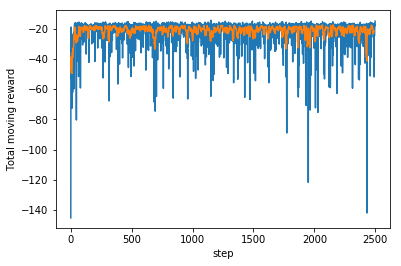

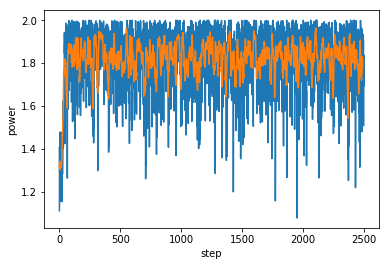

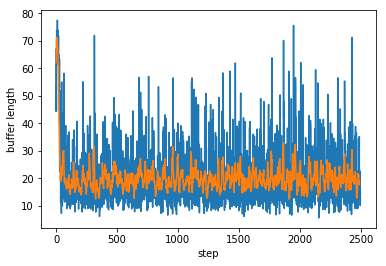

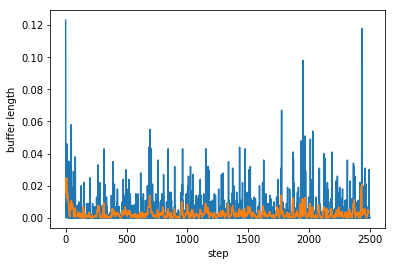

In [3]:
name = 't_10/test_1000_' + time.strftime("%b_%d_%Y_%H_%M_%S", time.localtime(time.time()))
a,b,c,d = plot_everything(res_rec, win=10)
np.savez(name, a,b,c,d)

In [1]:
cur_init_ds_ep = env.reset()
    
cur_r_ep = np.zeros(len(user_list))
cur_p_ep = np.zeros(len(user_list))
cur_n_ep = np.zeros(len(user_list))
cur_ts_ep = np.zeros(len(user_list))
cur_rs_ep = np.zeros(len(user_list))
cur_ps_ep = np.zeros(len(user_list))
cur_ds_ep = np.zeros(len(user_list))
cur_ch_ep = np.zeros(len(user_list))
    
for j in range(1000):
    # first try to transmit from current state
    [cur_r, done, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
    cur_r_ep += cur_r
    cur_p_ep += cur_p
    cur_ts_ep += cur_ts
    cur_ps_ep += cur_ps
    cur_rs_ep += cur_rs
    cur_ds_ep += cur_ds
    cur_ch_ep += cur_ch
        
    print('%d:r:%f,p:%s,n:%s,tr:%s,pr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (j, cur_r, cur_p, cur_n, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_init_ds_ep))
        
print('r:%f,p:%s,n:%s,tr:%s,rev:%s,dbuf:%s,ch:%s,ibuf:%s' % (cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_n_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep))

NameError: name 'env' is not defined

In [3]:
graph = tf.get_default_graph()
inputs = graph.get_tensor_by_name("input_1"+":0")
scaled_out = graph.get_tensor_by_name("output_1"+":0")
print sess.run(scaled_out, feed_dict={inputs: [[7.22254768,2.3384,2.7784888e-05]]})

[[0.78826445 1.        ]]


In [2]:
res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit(False)
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])

0:r:-50.8910,p:1.4033,tr:1.4707,pr:1.3505,rev:2.9594,dbuf:72.5261,ch:0.00002568,ibuf:4
1:r:-57.9454,p:1.3913,tr:1.6529,pr:1.2218,rev:3.0360,dbuf:74.1439,ch:0.00002761,ibuf:30
2:r:-51.0844,p:1.1953,tr:1.5476,pr:1.2320,rev:2.8984,dbuf:73.1955,ch:0.00002990,ibuf:39
3:r:-18.2811,p:1.3469,tr:1.5860,pr:1.3673,rev:2.9762,dbuf:61.5868,ch:0.00002683,ibuf:35
4:r:-17.5547,p:1.2180,tr:1.7657,pr:1.2518,rev:3.0115,dbuf:55.9275,ch:0.00003238,ibuf:63
5:r:-55.6239,p:1.4116,tr:1.4240,pr:1.3390,rev:2.8791,dbuf:69.1011,ch:0.00002492,ibuf:48
6:r:-37.3900,p:1.2706,tr:1.3830,pr:1.5578,rev:3.0240,dbuf:59.5109,ch:0.00002915,ibuf:8
7:r:-32.6223,p:1.4738,tr:1.3452,pr:1.6902,rev:3.0674,dbuf:63.5657,ch:0.00002512,ibuf:71
8:r:-20.8140,p:1.2057,tr:1.4394,pr:1.5456,rev:3.0451,dbuf:49.6221,ch:0.00002902,ibuf:38
9:r:-19.3836,p:1.1973,tr:1.4459,pr:1.4838,rev:2.9358,dbuf:56.0717,ch:0.00002922,ibuf:86


In [3]:
from mec_env_var import *
from helper import *
import tensorflow as tf
import ipdb as pdb
import time

MAX_EPISODE = 50
MAX_EPISODE_LEN = 1000

NUM_T = 1
NUM_R = 1
SIGMA2 = 0.3e-9

config = {'state_dim':3, 'action_dim':2};
train_config = {'minibatch_size':64, 'actor_lr':0.0001, 'tau':0.001, 
                 'critic_lr':0.001, 'gamma':0.99, 'buffer_size':250000, 
                 'random_seed':1234}
user_config = [{'id':'1', 'rate':3, 'dis':100, 'action_bound':1, 
                'data_buf_size':100, 't_factor':0.9, 'penalty':1000}];

print user_config
# 0. initialize the session object
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
    
# 1. include all user in the system according to the user_config
user_list = [];
for info in user_config:
    info.update(config)
    user_list.append(MecTermLD(sess, info, train_config))
    print 'test'

# 2. create the simulation env
env = MecSvrEnv(user_list, NUM_R, SIGMA2, MAX_EPISODE_LEN)
env.init_target_network()

res_rec = []
res_init_buf = []
# 3. start to explore for each episode
for i in range(MAX_EPISODE):
    
    cur_init_ds_ep = env.reset(3)
        
    res_init_buf.append(cur_init_ds_ep)
    
    cur_r_ep = np.zeros(len(user_list))
    cur_p_ep = np.zeros(len(user_list))
    cur_ts_ep = np.zeros(len(user_list))
    cur_ps_ep = np.zeros(len(user_list))
    cur_rs_ep = np.zeros(len(user_list))
    cur_ds_ep = np.zeros(len(user_list))
    cur_ch_ep = np.zeros(len(user_list))
    cur_of_ep = np.zeros(len(user_list))
    
    res_rec_tmp = []
    for j in range(MAX_EPISODE_LEN):
        
        # first try to transmit from current state
        [cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of] = env.step_transmit()
        
        res_rec_tmp.append([cur_r, done, cur_p, temp, cur_ts, cur_ps, cur_rs, cur_ds, cur_ch, cur_of])
        cur_r_ep += cur_r
        cur_p_ep += cur_p
        cur_ts_ep += cur_ts
        cur_ps_ep += cur_ps
        cur_rs_ep += cur_rs
        cur_ds_ep += cur_ds
        cur_ch_ep += cur_ch
        cur_of_ep += cur_of
        
        if done:
            res_rec.append(res_rec_tmp)
            print('%d:r:%.4f,p:%.4f,tr:%.4f,pr:%.4f,rev:%.4f,dbuf:%.4f,ch:%.8f,ibuf:%d' % (i, cur_r_ep/MAX_EPISODE_LEN, cur_p_ep/MAX_EPISODE_LEN, cur_ts_ep/MAX_EPISODE_LEN, cur_ps_ep/MAX_EPISODE_LEN, cur_rs_ep/MAX_EPISODE_LEN, cur_ds_ep/MAX_EPISODE_LEN, cur_ch_ep/MAX_EPISODE_LEN, cur_init_ds_ep[0]))
                
name = 'test_1000_' + str(time.asctime( time.localtime(time.time()) )) + '.npy'
np.save(name, [res_rec, res_init_buf])
sess.close()

[{'data_buf_size': 100, 'penalty': 1000, 'rate': 3, 'action_bound': 1, 'id': '1', 't_factor': 0.9, 'dis': 100}]
INFO:tensorflow:Restoring parameters from model/my_test_model
--Return--
None
> <ipython-input-3-a12846566f97>(30)<module>()
     29 graph = tf.get_default_graph()
---> 30 pdb.set_trace()
     31 

ipdb> graph
ipdb> graph.trainable_variables
*** AttributeError: 'Graph' object has no attribute 'trainable_variables'
ipdb> tf.trainable_variables()
[<tf.Variable 'fully_connected/weights:0' shape=(3, 400) dtype=float32_ref>, <tf.Variable 'fully_connected/BatchNorm/beta:0' shape=(400,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(3, 300) dtype=float32_ref>, <tf.Variable 'fully_connected_1/BatchNorm/beta:0' shape=(300,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(300, 2) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(3, 400) dtype=float32

BdbQuit: 

In [9]:
sess = tf.Session() 
saver = tf.train.import_meta_graph('model/my_test_model.meta')
sess.run(tf.global_variables_initializer())

saver.restore(sess, tf.train.latest_checkpoint('model/'))

graph = tf.get_default_graph()
variable_names = [v.name for v in tf.trainable_variables()]
values = sess.run(variable_names)
print sess.run('fully_connected_2/weights:0')

INFO:tensorflow:Restoring parameters from model/my_test_model
[[0.1545126  0.15780352]
 [0.15616506 0.15971294]
 [0.06559879 0.09880391]
 [0.06487427 0.10064688]
 [0.15168335 0.16229852]
 [0.06257845 0.09748891]
 [0.06430701 0.09924787]
 [0.06548443 0.10012874]
 [0.15782878 0.15414344]
 [0.15429462 0.17596859]
 [0.05945097 0.0991616 ]
 [0.06383383 0.09632684]
 [0.06522399 0.10438306]
 [0.06095436 0.09916781]
 [0.06635379 0.0955418 ]
 [0.06379106 0.09433711]
 [0.06133086 0.09875894]
 [0.06503102 0.09639146]
 [0.15047684 0.17412661]
 [0.15663381 0.15740666]
 [0.17768952 0.15899988]
 [0.15730077 0.14491995]
 [0.05902164 0.10017106]
 [0.06845198 0.09686822]
 [0.15724926 0.14774598]
 [0.1529071  0.16426612]
 [0.1520101  0.15706535]
 [0.16091335 0.16260217]
 [0.15082897 0.16070077]
 [0.06310375 0.09398151]
 [0.06018374 0.10056869]
 [0.05968894 0.10066012]
 [0.15474424 0.16255529]
 [0.15111688 0.1622602 ]
 [0.0838669  0.18973866]
 [0.06870251 0.24295035]
 [0.06702217 0.10505467]
 [0.1529     

In [3]:
np.save('t_08/1', [1])